In [1]:
%matplotlib inline

In [2]:
import os
import dolfin
import mshr

import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [3]:
import sys
sys.path.append("/pyurdme")

In [4]:
import pyurdme

In [5]:
class Edge1(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dolfin.near(x[0], MAX_X_DIM)
class Edge2(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dolfin.near(x[0], MIN_X_DIM)


In [6]:
class cylinderDemo3D(pyurdme.URDMEModel):
    def __init__(self, model_name="cylinder_demo3d"):
        pyurdme.URDMEModel.__init__(self, model_name)

        # System constants
        D_const = 0.1

        # Define Species
        A = pyurdme.Species(name="A", diffusion_constant=D_const)
        B = pyurdme.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        pt1 = dolfin.Point(MAX_X_DIM, 0, 0)
        pt2 = dolfin.Point(MIN_X_DIM, 0, 0)
        cylinder = mshr.Cylinder(pt1, pt2, 1.0, 1.0)
        self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(cylinder, 32))

        # Define Subdomains
        self.add_subdomain(Edge1(), 2)
        self.add_subdomain(Edge2(), 3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        data = self.get_solver_datastructure()
        vol = data['vol']
        sd = data['sd']
        left = numpy.sum(vol[sd == 2])
        right = numpy.sum(vol[sd == 3])

        k_react = pyurdme.Parameter(name="k_react", expression=1.0)

        k_creat1 = pyurdme.Parameter(name="k_creat1", expression=100/left)
        k_creat2 = pyurdme.Parameter(name="k_creat2", expression=100/right)

        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = pyurdme.Reaction(name="R1", reactants=None, products={A:1}, rate=k_creat1, restrict_to=2)
        R2 = pyurdme.Reaction(name="R2", reactants=None, products={B:1}, rate=k_creat2, restrict_to=3)
        R3 = pyurdme.Reaction(name="R3", reactants={A:1, B:1}, products=None, rate=k_react)
        self.add_reaction([R1, R2, R3])

        # Define simulation timespan
        self.timespan(range(200))

In [7]:
model = cylinderDemo3D()
result = model.run()


In [11]:
result.display('A',-1)

In [12]:
model.mesh

[    0.   100.   189.   281.   383.   474.   575.   650.   750.   851.
   950.  1050.  1149.  1262.  1351.  1466.  1557.  1655.  1751.  1839.
  1949.  2037.  2132.  2216.  2322.  2416.  2495.  2562.  2645.  2716.
  2806.  2917.  2991.  3081.  3146.  3218.  3300.  3380.  3449.  3526.
  3599.  3684.  3778.  3843.  3921.  3999.  4060.  4141.  4195.  4255.
  4313.  4381.  4441.  4489.  4529.  4576.  4632.  4692.  4725.  4782.
  4831.  4891.  4952.  5011.  5061.  5123.  5154.  5187.  5223.  5257.
  5304.  5352.  5418.  5475.  5505.  5553.  5597.  5642.  5683.  5740.
  5787.  5822.  5857.  5883.  5907.  5959.  5989.  6049.  6115.  6136.
  6166.  6192.  6238.  6268.  6305.  6323.  6356.  6409.  6430.  6474.
  6502.  6525.  6531.  6557.  6584.  6615.  6631.  6651.  6685.  6712.
  6738.  6754.  6780.  6790.  6801.  6810.  6856.  6898.  6898.  6912.
  6925.  6927.  6957.  6978.  6998.  7011.  7040.  7035.  7071.  7091.
  7130.  7154.  7196.  7224.  7245.  7241.  7274.  7292.  7299.  7308.
  7315

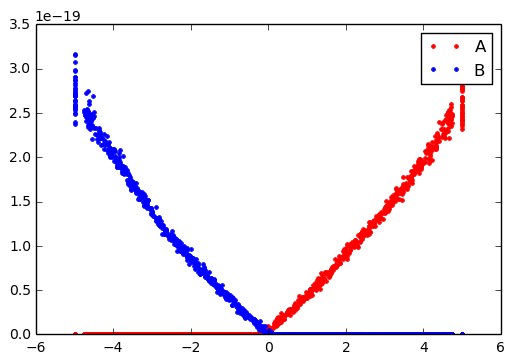

In [9]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=True), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=True), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print A_sum
print B_sum
data = model.get_solver_datastructure()
vol = data['vol']
sd = data['sd']
print numpy.sum(vol[sd == 2])
print numpy.sum(vol[sd == 3])


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'])


# ================================

In [13]:
from pyurdme.nsmsolver import NSMSolver

In [23]:
sol = NSMSolver(model, report_level=2)

In [24]:
result2 = sol.run()

Compiling Solver
Creating propensity file /tmp/tmpXDRqzp/.urdme/cylinder_demo3d_pyurdme_generated_model.c
cmd: cd /tmp/tmpXDRqzp ; make -f /pyurdme/pyurdme/urdme/build/Makefile.nsm URDME_ROOT=/pyurdme/pyurdme/urdme URDME_MODEL=cylinder_demo3d_pyurdme_generated_model

mpicc  -gdwarf-2 -m64 -c  -O3 -std=gnu99  -Wall -Wlong-long -Wformat -Wpointer-arith  -I/pyurdme/pyurdme/urdme/include  -DURDME_LIBMAT /pyurdme/pyurdme/urdme/src/nsm/nsm.c -o .urdme/nsm.o
mpicc  -gdwarf-2 -m64 -c  -O3 -std=gnu99  -Wall -Wlong-long -Wformat -Wpointer-arith  -I/pyurdme/pyurdme/urdme/include  -DURDME_LIBMAT /pyurdme/pyurdme/urdme/src/nsm/nsmcore.c -o .urdme/nsmcore.o
mpicc  -gdwarf-2 -m64 -c  -O3 -std=gnu99  -Wall -Wlong-long -Wformat -Wpointer-arith  -I/pyurdme/pyurdme/urdme/include  -DURDME_LIBMAT /pyurdme/pyurdme/urdme/src/report.c -o .urdme/report.o
mpicc  -gdwarf-2 -m64 -c  -O3 -std=gnu99  -Wall -Wlong-long -Wformat -Wpointer-arith  -I/pyurdme/pyurdme/urdme/include  -DURDME_LIBMAT /pyurdme/pyurdme/urdme/

In [17]:
sol.solver_base_dir

'/tmp/tmp0qyv2U'

In [21]:
os.listdir(sol.solver_base_dir+"/.urdme/")

['report.o',
 'urdmemodel.o',
 'cylinder_demo3d_pyurdme_generated_model.nsm',
 'outputwriter.o',
 'nsmcore.o',
 'nsm.o',
 'cylinder_demo3d_pyurdme_generated_model.o',
 'read_matfile.o',
 'cylinder_demo3d_pyurdme_generated_model.c',
 'binheap.o']

In [22]:
with open(sol.solver_base_dir+"/.urdme/cylinder_demo3d_pyurdme_generated_model.c", 'r') as f:
    print(f.read())

/* URDME model file, automatically generated by pyURDME. */
#include <stdlib.h>
#include <math.h>
#include "propensities.h"
#include <stdio.h>

/* Species names */
#define A x[0]
#define A_INDEX 0
#define B x[1]
#define B_INDEX 1


/* Number of reactions */
#define NR 3  // Depricated, will remove in future version.
#define NUM_REACTIONS 3
#define NUM_SPECIES 2
#define NUM_VOXELS 1059

/* Define DataFunctions */


/* Parameter definitions */
const double k_react = 1.0;
const double k_creat1 = 624.860437513;
const double k_creat2 = 326.672047576;


/* Reaction definitions */
double rxn246022f0_78cd_494b_bd39_cd6bbab09a90(const int *x, double t, const double vol, const double *data, int sd)
{
if(sd == 2){
return k_creat1*vol;
}else{
	return 0.0;}
}

double rxneb6f03f9_9394_42e6_9bb5_49e3d5e02577(const int *x, double t, const double vol, const double *data, int sd)
{
if(sd == 3){
return k_creat2*vol;
}else{
	return 0.0;}
}

double rxn13f041e3_4ff8_4ed4_8c15_f3d2f75246e7(const int *x, doub

In [26]:
model.mesh.coordinates()[0,:]

array([-4.18878999, -0.26594176,  0.61296663])

In [27]:
model.sd[0]

1.0

In [29]:
for i in range(len(model.sd)):
    print("    init_create_particle(sys,id++,{0},{1},{2},{3});".format(model.mesh.coordinates()[i,0],model.mesh.coordinates()[i,1],model.mesh.coordinates()[i,2],model.sd[i]))

    init_create_particle(sys,id++,-4.18878998677,-0.265941756729,0.612966634951,1.0)
    init_create_particle(sys,id++,-3.96380438828,-0.457901430417,0.45666035024,1.0)
    init_create_particle(sys,id++,-4.32683217006,-0.537299628544,0.357035294533,1.0)
    init_create_particle(sys,id++,-4.10508604259,-0.214783219085,0.250865753943,1.0)
    init_create_particle(sys,id++,-3.37322136902,-0.0838897823831,0.0685190753655,1.0)
    init_create_particle(sys,id++,-3.25946859937,-0.535059763916,0.0213350680117,1.0)
    init_create_particle(sys,id++,-3.163961735,-0.250211129871,-0.154376902844,1.0)
    init_create_particle(sys,id++,-3.14115117837,-0.206669086907,0.463249565264,1.0)
    init_create_particle(sys,id++,-0.191129931779,0.453695459213,-0.481753905571,1.0)
    init_create_particle(sys,id++,-0.133509713368,0.569227268056,-0.820261573302,1.0)
    init_create_particle(sys,id++,-0.421604425449,0.458167238155,-0.883532597733,1.0)
    init_create_particle(sys,id++,-0.362224085469,0.764940073

In [31]:
model.u0.shape

(2, 1059)

In [36]:
nspecies = model.u0.shape[0]
ncells = model.u0.shape[1]
outstr = "static unsigned int input_u0[{0}] = ".format(nspecies*ncells)
outstr+="{"
for i in range(ncells):
    for s in range(nspecies):
        if i+s>0: outstr+=','
        outstr+= str(model.u0[s,i])
outstr+="};"
print(outstr)

unsigned int u0[2118] = {0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [40]:
sol_data = model.get_solver_datastructure()
sol_data

{'D': <2118x2118 sparse matrix of type '<type 'numpy.float64'>'
 	with 20662 stored elements in Compressed Sparse Column format>,
 'G': <3x5 sparse matrix of type '<type 'numpy.float64'>'
 	with 5 stored elements in Compressed Sparse Column format>,
 'K': <1059x1059 sparse matrix of type '<type 'numpy.float64'>'
 	with 13523 stored elements in Compressed Sparse Column format>,
 'N': <2x3 sparse matrix of type '<type 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Column format>,
 'data': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'dofvolumes': array([ 0.00635104,  0.00635104,  0.04124781, ...,  0.01022525,
         0.0093375 ,  0.0093375 ]),
 'p': array([[-5.        ,  0.40738155, -0.91067812],
        [-4.72150049,  0.25644217, -0.66280953],
        [-5.        ,  0.1207702 , -0.98810517],
        ..., 
        [ 5.        ,  0.22188934, -0.97265589],
        [ 5.        ,  0.98536021, -0.14864025],
        [ 5.        ,  0.98536021,  0.14864025]]),
 'report': 0,
 

In [166]:
sol_data['D'].shape

(2118, 2118)

In [169]:
2*int(sol_data['vol'].shape[0])

2118

In [175]:
#dof_2_vertex_map = model.xmesh.dof_to_vertex_map[model.xmesh.dof_to_vertex_map.keys()[0]]
#dof_2_vertex_map.shape

In [174]:
vertex_to_dof_map = model.xmesh.vertex_to_dof_map[model.xmesh.dof_to_vertex_map.keys()[0]]
vertex_to_dof_map.shape

(1078,)

In [181]:
for i in range (len(vertex_to_dof_map)):
    print("{0} {1}".format(i,vertex_to_dof_map[i]))

0 158
1 264
2 262
3 266
4 1440
5 1578
6 1438
7 1576
8 1702
9 1704
10 1706
11 1700
12 930
13 928
14 836
15 834
16 410
17 412
18 478
19 482
20 480
21 484
22 862
23 708
24 710
25 706
26 1204
27 1206
28 1202
29 1318
30 414
31 512
32 514
33 1186
34 1184
35 1188
36 1190
37 1696
38 1666
39 1694
40 1698
41 1376
42 1494
43 1496
44 1378
45 270
46 154
47 156
48 272
49 1114
50 1116
51 1020
52 1118
53 316
54 318
55 124
56 314
57 1820
58 1818
59 1822
60 1824
61 2034
62 2102
63 2104
64 2100
65 830
66 832
67 926
68 150
69 148
70 72
71 152
72 1286
73 1214
74 1288
75 1290
76 1784
77 1768
78 1786
79 1526
80 1524
81 1608
82 1610
83 1212
84 1898
85 1900
86 1902
87 2024
88 2066
89 2148
90 2068
91 2070
92 2072
93 2074
94 2008
95 2076
96 1972
97 1910
98 1970
99 1908
100 1548
101 1634
102 1550
103 1552
104 1308
105 1374
106 1284
107 1260
108 1354
109 718
110 720
111 716
112 722
113 1008
114 1148
115 1010
116 1006
117 786
118 788
119 790
120 882
121 902
122 1052
123 1054
124 904
125 1082
126 994
127 1080
128 99

In [163]:
outstr = "static double input_vol[{0}] = ".format(sol_data['vol'].shape[0])
outstr+="{"
print("length=")
print(sol_data['vol'].shape)
for i in range(sol_data['vol'].shape[0]):
    if i>0: outstr+=','
    j = dof_2_vertex_map[i]
    print(i,j)
    outstr+= str(sol_data['vol'][j])
outstr+="};"
print(outstr)


length=
(1059,)
(0, 1009)
(1, 160)
(2, 162)
(3, 311)
(4, 1054)
(5, 1051)
(6, 652)
(7, 159)
(8, 161)
(9, 312)
(10, 493)
(11, 494)
(12, 837)
(13, 685)
(14, 634)
(15, 403)
(16, 654)
(17, 653)
(18, 655)
(19, 378)
(20, 830)
(21, 983)
(22, 1071)


IndexError: index out of bounds

In [182]:
outstr = "static int input_sd[{0}] = ".format(model.sd.shape[0])
outstr+="{"
for i in range(model.sd.shape[0]):
    if i>0: outstr+=','
    outstr+= str(model.sd[i])
outstr+="};"
print(outstr)


static int input_sd[1078] = {1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [54]:
outstr = "static double input_data[{0}] = ".format(sol_data['data'].shape[1])
outstr+="{"
for i in range(sol_data['data'].shape[1]):
    if i>0: outstr+=','
    outstr+= str(sol_data['data'][0][i])
outstr+="};"
print(outstr)
outstr = "static int input_dsize = {0};".format(int(sol_data['data'].shape[1]/model.mesh.coordinates().shape[0]))
print(outstr)

static double input_data[1059] = {0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [138]:
N = sol_data['N']
outstr = "static size_t input_irN[{0}] = ".format(len(N.indices))
outstr+="{"
for i in range(len(N.indices)):
    if i>0: outstr+=','
    outstr+= str(N.indices[i])
outstr+="};"
print(outstr)

outstr = "static size_t input_jcN[{0}] = ".format(len(N.indptr))
outstr+="{"
for i in range(len(N.indptr)):
    if i>0: outstr+=','
    outstr+= str(N.indptr[i])
outstr+="};"
print(outstr)

outstr = "static int input_prN[{0}] = ".format(len(N.data))
outstr+="{"
for i in range(len((N.data))):
    if i>0: outstr+=','
    outstr+= str(N.data[i])
outstr+="};"
print(outstr)


static size_t input_irN[4] = {0,1,0,1};
static size_t input_jcN[4] = {0,1,2,4};
static int input_prN[4] = {1.0,1.0,-1.0,-1.0};


In [129]:
print(N.todense())

[[ 1.  0. -1.]
 [ 0.  1. -1.]]


In [132]:
N.indptr

array([0, 1, 2, 4], dtype=int32)

In [133]:
N.data

array([ 1.,  1., -1., -1.])

In [137]:
N.indices

array([0, 1, 0, 1], dtype=int32)

In [140]:
G = sol_data['G']
outstr = "static size_t input_irG[{0}] = ".format(len(G.indices))
outstr+="{"
for i in range(len(G.indices)):
    if i>0: outstr+=','
    outstr+= str(G.indices[i])
outstr+="};"
print(outstr)

outstr = "static size_t input_jcG[{0}] = ".format(len(G.indptr))
outstr+="{"
for i in range(len(G.indptr)):
    if i>0: outstr+=','
    outstr+= str(G.indptr[i])
outstr+="};"
print(outstr)

static size_t input_irG[5] = {2,2,2,2,2};
static size_t input_jcG[6] = {0,1,2,3,4,5};


In [ ]:
#const char* const arr[] = { "foo", "bar", 0 }; // all const


In [88]:
outstr = "const char* const input_species_names[] = {"
for i,s in enumerate(model.listOfSpecies.keys()):
    if i>0: outstr+=","
    outstr+='"'+s+'"'
outstr+=", 0};"
print(outstr)

const char* const input_species_names[] = {"A","B", 0};


In [101]:
model.species_to_subdomains

{<pyurdme.model.Species instance at 0x7faa3564f0e0>: [2, 3],
 <pyurdme.model.Species instance at 0x7faa3564fbd8>: [1, 2]}

In [103]:
model.subdomains

OrderedDict([(2,
              <__main__.Edge1; proxy of <Swig Object of type 'std::shared_ptr< dolfin::SubDomain > *' at 0x7faa356538a0> >),
             (3,
              <__main__.Edge2; proxy of <Swig Object of type 'std::shared_ptr< dolfin::SubDomain > *' at 0x7faa35640030> >)])

In [126]:
num_subdomains = len(model.subdomains)+1
outstr = "const int input_num_subdomain = {0};".format(num_subdomains)
print(outstr)
outstr = "const double input_subdomain_diffusion_matrix[{0}]".format(len(model.listOfSpecies)*num_subdomains)
outstr+="{"
for i, sname in enumerate(model.listOfSpecies.keys()):
    s = model.listOfSpecies[sname]
    #print sname,
    for j, sd_ndx in enumerate(range(num_subdomains)):
        sd_ndx+=1
        #print sd_ndx, 
        if i+j>0: outstr+=','
        if sd_ndx in model.species_to_subdomains[s]:
            outstr+= "{0}".format(s.diffusion_constant)
        else:
            outstr+= "0.0"
outstr+="};"
print(outstr)
            
    

const int input_num_subdomain = 3;
const double input_subdomain_diffusion_matrix[6]{0.1,0.1,0.0,0.1,0.0,0.1};


In [186]:
prD

NameError: name 'prD' is not defined

In [191]:
import scipy
import numpy

In [195]:
irD = numpy.array([1918,110,6,1742,278,2,1744,1616,1800,690,998,974,0,1919,111,7,1743,279,3,1745,1617,1801,691,999,975,1,1744,1616,690,998,1448,974,1758,1316,1002,758,1000,2,1745,1617,691,999,1449,975,1759,1317,1003,759,1001,3,1920,0,1918,692,576,6,1000,2,1744,688,4,1921,1,1919,693,577,7,1001,3,1745,689,5,1836,1528,278,2,1744,690,1448,682,974,280,1758,6,1837,1529,279,3,1745,691,1449,683,975,281,1759,7,64,10,786,1198,12,14,824,776,404,826,8,65,11,787,1199,13,15,825,777,405,827,9,1338,1336,12,14,1560,180,1978,178,404,676,826,182,822,770,1556,1136,10,1339,1337,13,15,1561,181,1979,179,405,677,827,183,823,771,1557,1137,11,1560,180,824,1558,404,826,438,182,822,1556,1542,12,1561,181,825,1559,405,827,439,183,823,1557,1543,13,780,824,478,1792,776,404,826,822,1542,1086,1248,14,781,825,479,1793,777,405,827,823,1543,1087,1249,15,78,18,80,1088,652,650,648,1288,1144,1220,1830,1146,484,16,79,19,81,1089,653,651,649,1289,1145,1221,1831,1147,485,17,1088,648,1144,1830,484,78,18,1089,649,1145,1831,485,79,19,22,16,78,18,80,1088,20,23,17,79,19,81,1089,21,16,18,1088,650,648,22,17,19,1089,651,649,23,286,28,664,284,1776,288,532,928,1050,536,1328,1490,24,287,29,665,285,1777,289,533,929,1051,537,1329,1491,25,1950,30,1866,1322,24,286,1344,28,284,26,1951,31,1867,1323,25,287,1345,29,285,27,1618,522,1776,288,928,858,916,1490,1592,1396,1876,28,1619,523,1777,289,929,859,917,1491,1593,1397,1877,29,526,1412,24,28,664,522,1776,1708,30,527,1413,25,29,665,523,1777,1709,31,34,1770,630,38,1936,1868,382,638,32,35,1771,631,39,1937,1869,383,639,33,630,328,632,636,38,1936,382,638,1262,2046,834,1730,34,631,329,633,637,39,1937,383,639,1263,2047,835,1731,35,970,32,34,630,636,38,1936,36,971,33,35,631,637,39,1937,37,1936,382,638,834,840,838,1584,636,38,1937,383,639,835,841,839,1585,637,39,266,442,2106,884,824,776,2102,914,440,438,1542,40,267,443,2107,885,825,777,2103,915,441,439,1543,41,44,46,1658,786,40,1626,442,2106,2102,440,42,45,47,1659,787,41,1627,443,2107,2103,441,43,46,40,266,2106,884,2102,440,44,47,41,267,2107,885,2103,441,45,40,1626,2106,2102,440,46,41,1627,2107,2103,441,47,1264,52,50,54,1380,918,48,1265,53,51,55,1381,919,49,1930,54,1844,918,1932,670,672,50,1931,55,1845,919,1933,671,673,51,50,1206,1930,54,1844,1210,1390,918,1932,1464,670,672,52,51,1207,1931,55,1845,1211,1391,919,1933,1465,671,673,53,1380,918,670,672,946,654,54,1381,919,671,673,947,655,55,904,58,604,62,702,356,428,1272,868,790,716,426,56,905,59,605,63,703,357,429,1273,869,791,717,427,57,62,354,702,1688,430,356,428,1720,2116,790,1722,426,1294,58,63,355,703,1689,431,357,429,1721,2117,791,1723,427,1295,59,352,902,56,904,58,62,702,430,60,353,903,2043,57,905,59,63,703,431,61,702,1688,430,356,428,2116,790,426,1274,62,703,1689,431,357,429,2117,791,427,1275,63,530,10,1338,1336,14,178,478,1792,404,676,826,64,531,11,1339,1337,15,179,479,1793,405,677,827,65,1588,432,750,1424,434,1416,1612,398,814,1004,812,66,1589,433,751,1425,435,1417,1613,399,815,1005,813,67,1376,72,300,226,1704,1706,70,228,1586,66,68,1377,73,301,227,1705,1707,71,229,1587,67,69,746,228,66,1588,432,750,434,436,1416,1612,346,70,747,229,67,1589,433,751,435,437,1417,1613,347,71,1704,70,362,358,1586,66,1588,432,1424,72,1705,71,363,359,1587,67,1589,433,1425,73,1694,78,80,76,1992,74,1695,79,81,77,1993,75,1992,1144,1146,1094,1904,1938,1142,1998,76,1993,1145,1147,1095,1905,1939,1143,1999,77,18,80,76,1144,1146,78,19,81,77,1145,1147,79,652,254,76,1992,648,1144,1146,1290,1094,1938,1142,80,653,255,77,1993,649,1145,1147,1291,1095,1939,1143,81,1130,174,1812,84,86,1470,1472,1474,1480,1832,82,1131,175,1813,85,87,1471,1473,1475,1833,83,472,86,468,470,1044,1474,1480,1832,1870,2018,84,473,87,471,1045,1475,1833,2019,85,1074,1470,1472,1474,1732,1822,1832,1870,2024,132,86,1471,1473,1475,1823,1833,2025,133,87,130,82,1130,1068,84,1292,132,86,468,470,1074,1470,1474,1822,1870,88,131,83,1131,1069,85,1293,133,87,471,1471,1475,1823,89,94,92,1856,1658,1632,96,90,95,93,1857,1659,1633,97,91,1856,1078,42,1658,786,12,1632,96,1560,1624,442,1846,1558,1848,92,1857,1079,43,1659,787,13,1633,97,1561,1625,443,1847,1559,1849,93,1076,92,1078,1440,1658,1632,96,94,1077,93,1079,1441,1659,1633,97,95,1624,1626,1846,1558,1848,1660,1628,1826,96,1625,1627,1847,1559,1849,1661,1629,1827,97,104,518,802,610,102,520,546,1070,804,806,156,1068,1072,472,158,98,105,519,803,611,103,521,547,1071,805,807,157,1069,1073,473,159,99,1922,98,1058,104,1054,610,102,612,1056,152,546,804,156,100,1923,99,1059,105,1055,611,103,613,1057,153,547,805,157,101,612,152,546,804,806,156,1072,1388,472,158,102,613,153,547,805,807,157,1073,1389,473,159,103,518,1566,88,612,1070,804,1068,84,1072,472,1292,104,519,1567,89,613,1071,805,1069,85,1073,473,1293,105,410,1634,0,744,110,6,1742,278,1744,1616,1800,316,1746,106,411,1635,1,745,111,7,1743,279,1745,1617,1801,317,1747,107,106,1634,0,110,1742,108,107,1635,1,111,1743,109,1742,1744,1616,1800,316,1746,110,1743,1745,1617,1801,317,1747,111,146,118,254,2010,1114,1278,1514,1280,1098,1290,1512,1094,148,112,147,119,255,2011,1115,1279,1515,1281,1099,1291,1513,1095,149,113,312,2076,1694,1112,112,118,254,2010,1992,1114,1808,114,313,2077,1695,1113,113,119,255,2011,1993,1115,1809,115,1258,114,312,2076,80,144,112,146,118,254,2010,116,1259,115,313,2077,81,145,113,147,119,255,2011,117,254,1288,150,1280,1290,1512,1094,148,376,1548,118,255,1289,151,1281,1291,1513,1095,149,377,1549,119,474,1014,122,330,1270,816,126,496,1760,336,120,475,1015,123,331,1271,817,127,497,1761,337,121,896,1204,1270,126,1760,898,590,412,1406,594,1892,1696,122,897,1205,1271,127,1761,899,591,413,1407,595,1893,1697,123,120,1014,1202,122,1204,126,496,1760,1568,124,121,1015,1203,123,1205,127,497,1761,1569,125,496,1760,1568,590,476,412,1570,1892,416,414,550,68,126,497,1761,1569,591,477,413,1571,1893,417,415,551,69,127,1126,1566,88,130,966,1370,1130,1812,1292,132,86,272,128,1127,1567,89,131,967,1371,1131,1813,1293,133,87,273,129,966,1370,270,274,1812,706,1292,132,86,272,710,1074,1732,1822,1870,1970,2002,2024,130,967,1371,271,275,1813,707,1293,133,87,273,1823,1971,2003,2025,131,86,272,1472,1474,1732,1822,1870,1970,2002,2024,132,87,273,1473,1475,1823,1971,2003,2025,133,128,1126,130,966,1370,1812,132,86,272,134,129,1127,131,967,1371,1813,133,87,273,135,820,1462,142,1772,1494,138,136,821,1463,143,1773,1495,139,137,380,1082,384,642,608,1080,138,381,1083,385,643,609,1081,139,136,1638,142,1896,1772,606,138,140,137,1639,143,1897,1773,607,139,141,1896,1772,606,1494,138,326,380,1082,328,384,142,1897,1773,607,1495,139,327,381,1083,329,385,143,652,146,118,374,558,1288,1220,150,1686,1290,1512,148,376,1548,144,653,147,119,375,559,1289,1221,151,1687,1291,1513,149,377,1549,145,118,374,2058,1288,150,1280,1686,560,1290,1512,1926,148,376,146,119,375,2059,1289,151,1281,1687,561,1291,1513,1927,149,377,147,376,1548,1508,1510,980,494,662,660,454,474,148,377,1549,1509,1511,981,495,663,661,455,475,149,1686,1512,148,376,842,1508,1510,662,660,1012,150,1687,1513,149,377,843,1509,1511,663,661,1013,151,156,1388,158,154,548,1384,1386,1444,2006,152,157,1389,159,155,549,1385,153,548,1386,1444,2006,154,549,155,1388,158,154,548,1030,1386,1444,2006,156,1389,159,155,549,157,154,548,1030,1044,1386,1444,1600,1860,2006,2060,158,155,549,1045,1601,1861,159,1644,1942,1738,162,1890,1886,1872,1450,1740,2000,1914,160,1645,1943,1739,163,1891,1887,1873,1451,1741,2001,1915,161,1890,1886,1898,1872,434,628,1450,1740,810,626,1914,1912,162,1891,1887,1899,1873,435,629,1451,1741,811,627,1915,1913,163,1672,166,362,358,160,364,1942,1738,162,1890,1898,1872,164,1673,167,363,359,161,365,1943,1739,163,1891,1899,1873,165,160,364,1942,162,1890,1886,1898,1872,166,161,365,1943,163,1891,1887,1899,1873,167,170,900,104,518,128,1566,88,130,1070,168,171,901,105,519,129,1567,89,131,1071,169,900,104,518,128,172,88,82,174,516,176,1068,84,472,170,901,105,519,129,173,89,83,175,517,177,1069,85,473,171,174,516,176,84,472,172,175,517,177,85,473,173,176,84,468,470,1470,1474,1480,1832,2018,174,177,85,471,1471,1475,1833,2019,175,84,472,468,1172,1474,1480,2018,176,85,473,1173,1475,2019,177,1976,404,770,184,766,1108,772,768,178,1977,405,771,185,767,1109,773,769,179,1978,178,1846,1976,404,182,822,770,1556,184,766,1630,180,1979,179,1847,1977,405,183,823,771,1557,185,767,1631,181,822,770,1556,184,1630,26,772,1950,768,1866,2066,1322,1482,182,823,771,1557,185,1631,27,773,1951,769,1867,2067,1323,1483,183,766,768,2066,1482,1484,184,767,769,2067,1483,1485,185,536,1930,190,1052,1064,1390,1716,1932,186,537,1931,191,1053,1065,1391,1717,1933,187,534,1048,288,192,986,186,1050,536,190,188,535,1049,289,193,987,187,1051,537,191,189,2080,1052,1064,1212,1390,1716,1066,1062,1554,1230,782,1060,1122,190,2081,1053,1065,1213,1391,1717,1067,1063,1555,1231,783,1061,1123,191,986,186,190,2080,1964,1064,1716,1214,192,987,187,191,2081,1965,1065,1717,1215,193,848,2072,198,200,1196,194,849,2073,199,201,1197,195,194,1158,848,198,200,196,195,1159,849,199,201,197,200,552,1196,490,164,1672,1038,166,362,366,160,1644,198,201,553,1197,491,165,1673,1039,167,363,367,161,1645,199,1196,164,1672,166,160,364,1942,200,1197,165,1673,167,161,365,1943,201,504,1132,1464,204,502,1134,206,1446,1756,720,202,505,1133,1465,205,503,1135,207,1447,1757,721,203,502,206,784,720,718,1028,944,204,503,207,785,721,719,1029,945,205,1756,720,568,1026,718,1028,944,2088,1300,206,1757,721,569,1027,719,1029,945,2089,1301,207,1544,202,1208,1132,584,204,502,1134,206,1756,720,208,1545,203,1209,1133,585,205,503,1135,207,1757,721,209,1400,970,214,1730,212,1398,216,636,210,1401,971,215,1731,213,1399,217,637,211,1398,216,636,640,638,1262,830,1222,212,1399,217,637,641,639,1263,831,1223,213,1730,212,1308,1398,216,1312,1798,638,1262,830,214,1731,213,1309,1399,217,1313,1799,639,1263,831,215,640,638,1262,830,1222,1224,216,641,639,1263,831,1223,1225,217,852,850,224,622,220,1282,1284,222,994,218,853,851,225,623,221,1283,1285,223,995,219,1454,1282,1284,222,994,1286,996,1456,268,2044,1154,220,1455,1283,1285,223,995,1287,997,1457,269,2045,1155,221,994,1286,996,2044,992,1572,222,995,1287,997,2045,993,1573,223,622,220,618,1284,222,994,624,1286,996,1154,224,623,221,619,1285,223,995,625,1287,997,1155,225,70,746,228,2040,1342,66,750,1426,1850,436,1416,748,226,71,747,229,2041,1343,67,751,1427,1851,437,1417,749,227,2040,1586,66,750,1424,1426,1850,1416,1612,398,396,400,228,2041,1587,67,751,1425,1427,1851,1417,1613,399,397,401,229,226,1706,228,2040,750,1424,1426,230,227,1707,229,2041,751,1425,1427,231,1102,1116,236,1168,1276,1256,170,1128,900,232,1103,1117,237,1169,1277,1257,171,1129,901,233,232,1102,236,1170,1168,1276,1256,170,900,518,234,233,1103,237,1171,1169,1277,1257,171,901,519,235,542,1168,168,1276,1256,170,1128,900,128,1566,236,543,1169,169,1277,1257,171,1129,901,129,1567,237,1724,1166,234,232,1102,236,1168,1276,238,1725,1167,235,233,1103,237,1169,1277,239,932,20,1200,308,74,22,16,78,18,80,240,933,21,1201,309,75,23,17,79,19,81,241,434,1740,244,2000,424,246,242,435,1741,245,2001,425,247,243,424,246,420,344,422,418,244,425,247,421,345,423,419,245,1008,1906,422,418,1980,246,1009,1907,423,419,1981,247,242,434,346,244,2000,424,246,248,243,435,347,245,2001,425,247,249,1102,1910,236,1502,1320,252,168,170,98,1058,104,518,250,1103,1911,237,1503,1321,253,169,171,99,1059,105,519,251,542,168,1058,104,1456,1566,88,612,130,1056,252,543,169,1059,105,1457,1567,89,613,131,1057,253,1992,1288,1808,1146,1290,1512,1094,1904,1548,254,1993,1289,1809,1147,1291,1513,1095,1905,1549,255,260,258,1308,614,1642,2050,262,616,1314,256,261,259,1309,615,1643,2051,263,617,1315,257,614,324,1614,1312,2050,262,1798,616,1036,1498,258,615,325,1615,1313,2051,263,1799,617,1037,1499,259,258,614,1642,2050,262,616,292,260,259,615,1643,2051,263,617,293,261,616,292,1314,538,1118,218,852,850,262,617,293,1315,539,1119,219,853,851,263,44,40,882,266,884,2102,264,45,41,883,267,885,2103,265,884,2102,914,440,1680,266,885,2103,915,441,1681,267,2044,1566,130,966,1252,894,270,274,706,1292,132,272,268,2045,1567,131,967,1253,895,271,275,707,1293,133,273,269,274,706,1292,272,704,708,710,892,1074,1254,1970,2098,270,275,707,1293,273,705,709,893,1255,1971,2099,271,710,892,1254,1732,1822,1870,1970,2002,2024,272,893,1255,1823,1971,2003,2025,273,272,1254,1732,2002,2098,274,273,1255,2003,2099,275,740,958,1836,278,1366,282,1378,974,280,1834,828,276,741,959,1837,279,1367,283,1379,975,281,1835,829,277,1744,282,316,1448,974,280,320,758,976,278,1745,283,317,1449,975,281,321,759,977,279,1834,828,1758,1368,686,976,340,8,42,778,786,1198,280,1835,829,1759,1369,687,977,341,9,43,779,787,1199,281,1534,316,1378,342,280,1368,1236,976,340,338,264,282,1535,317,1379,343,281,1369,1237,977,341,339,265,283,188,1776,288,928,916,1050,536,1396,52,1206,284,189,1777,289,929,917,1051,537,1397,53,1207,285,664,284,188,1438,982,288,532,928,986,536,1328,1396,984,286,665,285,189,1439,983,289,533,929,987,537,1329,1397,985,287,532,928,536,1328,1816,1396,1206,190,1392,288,533,929,537,1329,1817,1397,1207,191,1393,289,446,292,294,1602,296,538,2026,1724,290,447,293,295,1603,297,539,2027,1725,291,294,296,538,2026,1118,852,1646,540,1120,292,295,297,539,2027,1119,853,1647,541,1121,293,1602,1318,1036,296,538,2026,544,1032,1646,540,1120,1116,236,294,1603,1319,1037,297,539,2027,545,1033,1647,541,1121,1117,237,295,538,2026,1646,540,1120,1116,668,1648,296,539,2027,1647,541,1121,1117,669,1649,297,1704,1706,304,1956,302,1424,2012,2114,298,1705,1707,305,1957,303,1425,2013,2115,299,298,1704,304,358,228,1586,1364,302,1588,1358,1424,2012,300,299,1705,305,359,229,1587,1365,303,1589,1359,1425,2013,301,1358,1424,2012,2114,2014,396,400,302,1359,1425,2013,2115,2015,397,401,303,1956,1364,302,1358,2012,2114,2014,396,304,1957,1365,303,1359,2013,2115,2015,397,305,240,722,570,466,1200,308,574,312,310,16,306,241,723,571,467,1201,309,575,313,311,17,307,574,312,16,18,80,652,1218,118,254,650,308,575,313,17,19,81,653,1219,119,255,651,309,144,652,1218,118,374,650,558,554,1288,1796,1220,150,1686,1290,310,145,653,1219,119,375,651,559,555,1289,1797,1221,151,1687,1291,311,310,16,144,652,146,118,254,558,648,1288,1220,150,312,311,17,145,653,147,119,255,559,649,1289,1221,151,313,318,320,1176,338,1174,314,319,321,1177,339,1175,315,1746,314,974,318,280,760,320,758,1176,976,340,8,316,1747,315,975,319,281,761,321,759,1177,977,341,9,317,342,320,340,338,264,1174,1260,778,318,343,321,341,339,265,1175,1261,779,319,758,1176,976,340,1174,1260,778,774,1198,764,780,320,759,1177,977,341,1175,1261,779,775,1199,765,781,321,386,1318,2046,1036,1702,1034,544,1032,250,1102,1910,236,1502,322,387,1319,2047,1037,1703,1035,545,1033,251,1103,1911,237,1503,323,1614,1798,322,1262,386,1318,2046,1036,1498,1034,324,1615,1799,323,1263,387,1319,2047,1037,1499,1035,325,448,380,328,632,324,1614,642,608,322,386,326,449,381,329,633,325,1615,643,609,323,387,327,632,324,384,608,322,382,386,1318,2046,1702,1034,840,328,633,325,385,609,323,383,387,1319,2047,1703,1035,841,329,456,1270,332,460,496,1760,336,476,1350,1878,1042,330,457,1271,333,461,497,1761,337,477,1351,1879,1043,331,460,336,1158,1878,1042,848,1696,198,550,552,332,461,337,1159,1879,1043,849,1697,199,551,553,333,330,458,1270,1194,1598,332,460,1760,336,590,1878,1042,334,331,459,1271,1195,1599,333,461,1761,337,591,1879,1043,335,590,1878,1042,848,1696,1040,550,552,596,490,72,336,591,1879,1043,849,1697,1041,551,553,597,491,73,337,264,1174,1260,778,40,882,266,884,338,265,1175,1261,779,41,883,267,885,339,338,264,44,778,786,774,1198,40,882,266,884,340,339,265,45,779,787,775,1199,41,883,267,885,341,1236,340,338,264,44,342,1237,341,339,265,45,343,350,562,564,348,972,210,422,418,1400,1714,566,214,1730,344,351,563,565,349,973,211,423,419,1401,1715,567,215,1731,345,244,812,424,420,344,350,562,564,348,972,210,422,346,245,813,425,421,345,351,563,565,349,973,211,423,347,968,972,210,1400,970,566,214,1730,34,212,348,969,973,211,1401,971,567,215,1731,35,213,349,348,968,210,1400,214,212,350,349,969,211,1401,215,213,351,902,906,1582,1622,56,904,58,604,62,354,702,430,352,903,907,911,1583,1623,2043,57,905,59,605,63,355,703,431,353,356,1720,930,408,426,1294,1982,788,354,357,1721,931,409,427,1295,1983,789,355,428,1272,1720,930,790,716,426,1294,1274,1982,788,1802,958,794,356,429,1273,1721,931,791,717,427,1295,1275,1983,789,1803,959,795,357,364,1364,1588,1358,1356,2114,2034,628,1450,626,358,365,1365,1589,1359,1357,2115,2035,629,1451,627,359,1348,164,1672,1674,1362,1774,362,358,364,1942,162,360,1349,165,1673,1675,1363,1775,363,359,365,1943,163,361,358,364,1738,162,1588,432,628,1450,810,626,362,359,365,1739,163,1589,433,629,1451,811,627,363,1942,162,1890,1898,2034,628,1450,626,1914,364,1943,163,1891,1899,2035,629,1451,627,1915,365,1644,2036,1738,432,248,242,434,1740,810,346,244,2000,366,1645,2037,1739,433,249,243,435,1741,811,347,245,2001,367,370,366,1644,1886,248,242,434,368,371,367,1645,1887,249,243,435,369,366,1644,2036,248,242,434,370,367,1645,2037,249,243,435,371,2008,2028,388,660,2030,1726,1250,372,2009,2029,389,661,2031,1727,1251,373,2022,558,150,1280,1686,378,148,376,372,2008,1508,374,2023,559,151,1281,1687,379,149,377,373,2009,1509,375,392,1508,1510,980,662,388,660,454,474,376,393,1509,1511,981,663,389,661,455,475,377,560,1926,376,372,392,394,662,388,660,2030,378,561,1927,377,373,393,395,663,389,661,2031,379,1082,328,384,642,608,322,382,1080,386,1700,1702,380,1083,329,385,643,609,323,383,1081,387,1701,1703,381,386,2046,834,840,838,1620,1428,1504,250,836,1864,1910,866,1502,382,387,2047,835,841,839,1621,1429,1505,251,837,1865,1911,867,1503,383,642,1868,382,1080,386,1620,384,643,1869,383,1081,387,1621,385,2046,1702,1034,1986,2020,1032,250,1102,1910,1502,386,2047,1703,1035,1987,2021,1033,251,1103,1911,1503,387,660,2030,390,2094,456,1148,856,388,661,2031,391,2095,457,1149,857,389,2094,456,856,846,1880,2072,1150,390,2095,457,857,847,1881,2073,1151,391,978,394,662,388,660,390,392,979,395,663,389,661,391,393,662,388,1090,458,390,2094,456,856,194,394,663,389,1091,459,391,2095,457,857,195,395,1306,140,402,136,1638,1712,634,396,1307,141,403,137,1639,1713,635,397,396,400,818,1418,402,820,972,1462,398,397,401,819,1419,403,821,973,1463,399,818,402,136,820,1462,634,142,400,819,403,137,821,1463,635,143,401,1638,820,1712,634,142,1670,1772,606,1494,326,402,1639,821,1713,635,143,1671,1773,607,1495,327,403,676,826,182,822,770,678,1248,766,26,1108,772,1950,768,404,677,827,183,823,771,679,1249,767,27,1109,773,1951,769,405,354,870,1182,1720,930,988,408,106,410,872,1294,0,1982,406,355,871,1183,1721,931,989,409,107,411,873,1295,1,1983,407,4,410,1294,1982,276,576,6,954,1836,278,2,1744,1366,408,5,411,1295,1983,277,577,7,955,1837,279,3,1745,1367,409,872,276,742,740,1836,278,1744,282,316,314,410,873,277,743,741,1837,279,1745,283,317,315,411,1570,1406,1892,416,68,1376,1606,230,412,1571,1407,1893,417,69,1377,1607,231,413,550,68,596,1606,72,1604,226,488,70,414,551,69,597,1607,73,1605,227,489,71,415,414,68,1376,1606,230,226,70,416,415,69,1377,1607,231,227,71,417,1980,1400,566,214,258,1308,614,1398,1312,2050,418,1981,1401,567,215,259,1309,615,1399,1313,2051,419,344,350,348,422,418,1400,214,420,345,351,349,423,419,1401,215,421,418,1980,1400,214,1308,614,1398,422,419,1981,1401,215,1309,615,1399,423,246,1452,420,344,562,564,1906,422,418,1980,1400,424,247,1453,421,345,563,565,1907,423,419,1981,1401,425,1294,1274,1982,788,1802,950,954,794,990,2110,1366,2112,756,426,1295,1275,1983,789,1803,951,955,795,991,2111,1367,2113,757,427,790,426,1274,788,1802,794,428,791,427,1275,789,1803,795,429,356,428,2116,2038,426,1274,1802,950,430,357,429,2117,2039,427,1275,1803,951,431,434,436,1612,1450,1740,810,814,812,432,435,437,1613,1451,1741,811,815,813,433,436,1450,1740,810,346,814,812,424,246,344,350,562,564,434,437,1451,1741,811,347,815,813,425,247,345,351,563,565,435,1750,1416,748,346,814,1004,812,808,344,350,564,348,968,972,436,1751,1417,749,347,815,1005,813,809,345,351,565,349,969,973,437,822,1556,1542,1826,1894,1858,26,1866,878,666,438,823,1557,1543,1827,1895,1859,27,1867,879,667,439,438,1542,2084,1680,1858,1682,1838,30,1538,440,439,1543,2085,1681,1859,1683,1839,31,1539,441,824,1558,440,438,2084,1628,1894,1858,2108,26,442,825,1559,441,439,2085,1629,1895,1859,2109,27,443,2052,448,1082,446,608,450,1602,444,2053,449,1083,447,609,451,1603,445,450,1602,1318,296,238,2026,1724,446,451,1603,1319,297,239,2027,1725,447,324,1614,446,608,450,322,294,1602,1318,1036,448,325,1615,447,609,451,323,295,1603,1319,1037,449,1700,1702,238,1724,1166,234,450,1701,1703,239,1725,1167,235,451,240,926,20,308,22,16,78,18,452,241,927,21,309,23,17,79,19,453,474,334,330,458,456,816,332,460,454,475,335,331,459,457,817,333,461,455,816,460,856,846,1350,1878,848,1668,1880,1150,456,817,461,857,847,1351,1879,849,1669,1881,1151,457,456,196,332,460,856,194,1350,848,2072,198,200,458,457,197,333,461,857,195,1351,849,2073,199,201,459,336,476,1350,1878,848,198,360,550,552,1348,460,337,477,1351,1879,849,199,361,551,553,1349,461,934,1016,464,1478,466,116,932,462,935,1017,465,1479,467,117,933,463,306,240,722,466,116,932,308,114,312,310,464,307,241,723,467,117,933,309,115,313,311,465,116,932,308,74,1692,114,1694,78,80,112,652,118,254,76,466,117,933,309,75,1693,115,1695,79,81,113,653,119,255,77,467,470,1044,1172,1480,1860,1870,2018,468,471,1045,1173,1861,2019,469,1044,1074,1172,1474,1832,1860,1870,2018,468,470,1045,1173,1475,1833,1861,2019,471,468,470,1044,1172,1480,1794,1860,2018,472,471,1045,1173,1795,1861,2019,473,330,816,460,126,498,496,1760,476,846,1350,474,331,817,461,127,499,497,1761,477,847,1351,475,846,1350,1878,1668,500,552,68,1348,72,476,847,1351,1879,1669,501,553,69,1349,73,477,1792,676,1332,678,1248,1108,1840,1104,478,1793,677,1333,679,1249,1109,1841,1105,479,486,124,120,1268,1266,122,330,896,1270,480,487,125,121,1269,1267,123,331,897,1271,481,1998,728,480,1882,486,1268,1266,1202,122,482,1999,729,481,1883,487,1269,1267,1203,123,483,726,482,728,480,486,124,1266,484,727,483,729,481,487,125,1267,485,1266,1202,122,896,898,486,1267,1203,123,897,899,487,370,70,366,1678,746,2036,248,434,436,1750,488,371,71,367,1679,747,2037,249,435,437,1751,489,164,72,368,488,70,362,366,1644,1738,162,432,490,165,73,369,489,71,363,367,1645,1739,163,433,491,920,854,458,1598,196,194,1158,492,921,855,459,1599,197,195,1159,493,454,922,492,920,854,334,458,1194,1598,196,332,460,194,494,455,923,493,921,855,335,459,1195,1599,197,333,461,195,495,1760,1752,2086,476,1570,1878,1668,2054,416,500,68,1954,496,1761,1753,2087,477,1571,1879,1669,2055,417,501,69,1955,497,496,1728,1162,1752,476,1570,1350,1668,500,1754,1152,68,1348,1954,498,497,1729,1163,1753,477,1571,1351,1669,501,1755,1153,69,1349,1955,499,1754,1152,68,1348,1954,72,300,298,1704,304,500,1755,1153,69,1349,1955,73,301,299,1705,305,501,1234,206,1446,784,568,718,572,1028,306,938,570,502,1235,207,1447,785,569,719,573,1029,307,939,571,503,1464,1230,782,204,502,1234,784,720,568,504,1465,1231,783,205,503,1235,785,721,569,505,1900,202,504,1496,1768,1230,502,1234,206,1446,506,1901,203,505,1497,1769,1231,503,1235,207,1447,507,510,514,512,708,1384,1786,1810,508,511,515,709,1385,1787,1811,509,706,1388,514,512,704,708,710,892,1444,1600,1786,1810,510,707,1389,515,705,709,893,1601,1787,1811,511,708,1384,1386,1444,1810,514,512,709,1385,1811,515,513,512,704,708,1384,1386,1444,1600,1810,2006,2060,514,705,709,1385,1601,1811,515,806,176,84,472,468,470,1044,1172,1480,1794,2018,516,807,177,85,473,471,1045,1173,1795,2019,517,102,172,520,804,174,516,176,1068,84,472,518,103,173,521,805,175,517,177,1069,85,473,519,546,804,516,806,176,472,468,1030,1044,1172,1794,2018,520,547,805,517,807,177,473,1045,1173,1795,2019,521,1776,1708,528,858,1246,1490,1592,1244,1876,1206,1710,522,1777,1709,529,859,1247,1491,1593,1245,1877,1207,1711,523,1242,860,522,528,1244,524,1243,861,523,529,1245,525,1110,524,28,1242,860,522,1776,528,858,526,1111,525,29,1243,861,523,1777,529,859,527,1244,1876,1468,1710,1466,528,1245,1877,1469,1711,1467,529,1338,14,478,404,676,530,1339,15,479,405,677,531,1330,986,536,1328,984,1562,1564,2080,1964,1908,1392,532,1331,987,537,1329,985,1563,1565,2081,1965,1909,1393,533,982,532,192,986,536,984,190,534,983,533,193,987,537,985,191,535,1328,984,190,2080,1964,1392,1232,1212,1716,1214,536,1329,985,191,2081,1965,1393,1233,1213,1717,1215,537,1118,852,544,1032,1646,540,1120,1454,668,542,1648,538,1119,853,545,1033,1647,541,1121,1455,669,543,1649,539,1120,1116,236,668,542,1648,964,170,1128,900,134,128,540,1121,1117,237,669,543,1649,965,171,1129,901,135,129,541,168,170,900,268,128,1566,88,130,1070,542,169,171,901,269,129,1567,89,131,1071,543,1032,540,250,622,1454,668,252,542,168,1058,104,544,1033,541,251,623,1455,669,253,543,169,1059,105,545,804,806,156,158,154,548,1030,1794,2006,546,805,807,157,159,155,549,1795,547,1030,2006,154,548,155,549,552,68,596,490,72,488,70,362,366,746,66,550,553,69,597,491,73,489,71,363,367,747,67,551,1348,490,164,72,362,364,1738,1586,162,552,1349,491,165,73,363,365,1739,1587,163,553,1888,1796,1220,1852,1686,1854,844,842,1790,1788,1508,554,1889,1797,1221,1853,1687,1855,845,843,1791,1789,1509,555,942,1298,310,1996,1218,1994,558,554,1888,1288,1796,556,943,1299,311,1997,1219,1995,559,555,1889,1289,1797,557,554,1888,1288,1796,1220,150,1686,1946,844,148,842,1508,558,555,1889,1289,1797,1221,151,1687,1947,845,149,843,1509,559,1926,376,392,978,394,662,388,560,1927,377,393,979,395,663,389,561,564,1906,1670,418,698,1714,256,566,214,258,562,565,1907,1671,419,699,1715,257,567,215,259,563,348,1712,972,1360,1670,418,1714,566,214,258,1730,564,349,1713,973,1361,1671,419,1715,567,215,259,1731,565,214,258,1730,614,632,324,1614,1312,1798,1262,2046,566,215,259,1731,615,633,325,1615,1313,1799,1263,2047,567,718,572,1028,306,938,570,800,1492,940,2100,574,568,719,573,1029,307,939,571,801,1493,941,2101,575,569,926,1200,308,724,2100,574,556,312,310,570,927,1201,309,725,2101,575,557,313,311,571,306,1640,570,800,926,1492,1200,308,574,310,572,307,1641,571,801,927,1493,1201,309,575,311,573,556,310,1996,652,1218,1994,924,650,558,554,1796,574,557,311,1997,653,1219,1995,925,651,559,555,1797,575,6,954,1528,1000,2,1744,688,690,1448,694,682,974,1530,1758,576,7,955,1529,1001,3,1745,689,691,1449,695,683,975,1531,1759,577,4,1920,1610,1918,692,576,1528,1000,688,578,5,1921,1611,1919,693,577,1529,1001,689,579,1720,988,578,408,4,1920,1722,1610,1982,692,576,6,580,1721,989,579,409,5,1921,1723,1611,1983,693,577,7,581,588,656,886,586,2088,1024,1022,1300,2070,582,589,657,887,587,2089,1025,1023,1301,2071,583,204,1134,582,206,588,720,586,1026,718,1028,584,205,1135,583,207,589,721,587,1027,719,1029,585,2088,1024,1022,1300,2070,890,586,2089,1025,1023,1301,2071,891,587,720,656,886,586,888,722,1024,1022,1300,2070,890,1018,588,721,657,887,587,889,723,1025,1023,1301,2071,891,1019,589,1406,594,592,1696,416,414,550,596,1676,1606,1604,590,1407,595,593,1697,417,415,551,597,1677,1607,1605,591,1696,596,1676,1606,1604,488,592,1697,597,1677,1607,1605,489,593,592,596,1376,1606,1604,488,594,593,597,1377,1607,1605,489,595,1676,1606,1604,226,488,70,1678,746,2036,750,596,1677,1607,1605,227,489,71,1679,747,2037,751,597,1580,1582,602,604,406,354,870,598,601,911,1575,1579,1581,1583,603,605,407,355,871,599,1582,2064,2092,602,604,2016,406,714,870,1608,600,1575,1583,1763,1973,2065,2093,603,605,2017,407,715,871,1609,601,604,2016,714,870,1608,930,868,874,716,410,956,872,1818,602,605,2017,715,871,1609,931,869,875,717,411,957,873,1819,603,714,1608,712,356,1272,930,868,716,956,1294,1818,604,715,1609,713,357,1273,931,869,717,957,1295,1819,605,444,138,326,448,380,1082,328,608,450,322,606,445,139,327,449,381,1083,329,609,451,323,607,450,322,1080,386,1318,1036,1700,1702,238,2020,608,451,323,1081,387,1319,1037,1701,1703,239,2021,609,102,152,546,156,1388,158,610,103,153,547,157,1389,159,611,1382,1056,152,546,1070,804,1068,1072,1388,158,514,154,548,704,708,1386,1444,1600,1860,2006,2060,612,1383,1057,153,547,1071,805,1069,1073,1389,159,515,155,549,705,709,1601,1861,613,1312,2050,262,1798,616,1314,1498,1310,1224,614,1313,2051,263,1799,617,1315,1499,1311,1225,615,292,294,1036,1498,538,1118,852,544,1032,540,616,293,295,1037,1499,539,1119,853,545,1033,541,617,1420,994,624,996,1154,992,1460,618,1421,995,625,997,1155,993,1461,619,622,866,862,618,1320,1420,624,864,620,623,867,863,619,1321,1421,625,865,621,220,618,1454,1320,252,222,994,624,996,1058,1456,268,1154,622,221,619,1455,1321,253,223,995,625,997,1059,1457,269,1155,623,996,1058,1456,1054,1154,992,1460,1526,1056,894,1156,624,997,1059,1457,1055,1155,993,1461,1527,1057,895,1157,625,1914,1958,1520,1650,1360,1522,1952,646,626,1915,1959,1521,1651,1361,1523,1953,647,627,1450,626,814,1304,1638,1712,1650,1360,628,1451,627,815,1305,1639,1713,1651,1361,629,328,632,38,1936,1868,382,386,2046,834,630,329,633,39,1937,1869,383,387,2047,835,631,324,636,322,382,638,1262,386,2046,1034,840,632,325,637,323,383,639,1263,387,2047,1035,841,633,36,32,1494,1730,34,1770,630,328,632,38,634,37,33,1495,1731,35,1771,631,329,633,39,635,38,1936,640,638,834,840,1584,832,620,636,39,1937,641,639,835,841,1585,833,621,637,1262,830,834,840,838,1584,832,1428,620,836,866,862,638,1263,831,835,841,839,1585,833,1429,621,837,867,863,639,638,1262,830,1584,832,620,862,640,639,1263,831,1585,833,621,863,641,608,1868,1080,386,1702,1620,1986,642,609,1869,1081,387,1703,1621,1987,643,1952,646,1896,606,1652,444,2052,448,644,1953,647,1897,607,1653,445,2053,449,645,1896,606,1652,444,2052,326,700,448,1082,646,1897,607,1653,445,2053,327,701,449,1083,647,1288,1796,1220,1146,1290,484,726,1548,482,1510,1550,480,648,1289,1797,1221,1147,1291,485,727,1549,483,1511,1551,481,649,648,1796,1220,1830,1852,484,726,844,1790,1788,650,649,1797,1221,1831,1853,485,727,845,1791,1789,651,1218,118,254,650,648,1288,1220,1146,1290,726,844,148,1548,652,1219,119,255,651,649,1289,1221,1147,1291,727,845,149,1549,653,582,658,588,656,886,586,888,654,583,659,589,657,887,587,889,655,886,1016,888,1024,890,1018,1258,656,887,1017,889,1025,891,1019,1259,657,588,462,720,674,656,1016,888,464,722,1022,890,1018,116,658,589,463,721,675,657,1017,889,465,723,1023,891,1019,117,659,2030,454,1726,1250,474,2094,456,816,1148,460,1728,660,2031,455,1727,1251,475,2095,457,817,1149,461,1729,661,388,660,454,1090,458,390,2094,456,460,856,194,662,389,661,455,1091,459,391,2095,457,461,857,195,663,2090,1776,1684,1708,288,928,1594,1328,1816,1490,1592,1396,664,2091,1777,1685,1709,289,929,1595,1329,1817,1491,1593,1397,665,1436,24,286,1718,1540,664,1438,1776,1684,288,532,666,1437,25,287,1719,1541,665,1439,1777,1685,289,533,667,542,1648,964,134,268,2044,128,1126,1566,88,130,668,543,1649,965,135,269,2045,129,1127,1567,89,131,669,672,946,1552,658,674,656,1016,670,673,947,1553,659,675,657,1017,671,946,654,658,588,674,656,886,1016,672,947,655,659,589,675,657,887,1017,673,656,1016,888,1340,1018,1258,674,657,1017,889,1341,1019,1259,675,770,678,1108,772,1104,676,771,679,1109,773,1105,677,1248,1108,772,1104,1106,1110,678,1249,1109,773,1105,1107,1111,679,682,952,1530,1076,1814,754,686,684,1078,1440,1136,10,680,683,953,1531,1077,1815,755,687,685,1079,1441,1137,11,681,952,1530,1758,1814,754,686,1862,684,8,64,1136,10,1336,1984,682,953,1531,1759,1815,755,687,1863,685,9,65,1137,11,1337,1985,683,1078,1440,1136,10,1984,12,1560,180,1978,178,1846,1976,684,1079,1441,1137,11,1985,13,1561,181,1979,179,1847,1977,685,92,684,8,1078,10,786,1198,12,1560,180,686,93,685,9,1079,11,787,1199,13,1561,181,687,690,680,694,682,1530,1814,1862,688,691,681,695,683,1531,1815,1863,689,1448,694,682,1758,1316,1814,1002,1862,64,530,690,1449,695,683,1759,1317,1815,1003,1863,65,531,691,576,1528,1000,688,690,694,682,1530,692,577,1529,1001,689,691,695,683,1531,693,682,1814,1002,1862,64,530,10,1338,694,683,1815,1003,1863,65,531,11,1339,695,260,700,1642,290,262,616,292,294,696,261,701,1643,291,263,617,293,295,697,1714,1524,696,260,258,700,448,1614,1642,290,262,698,1715,1525,697,261,259,701,449,1615,1643,291,263,699,448,1614,1642,290,616,292,294,1602,1318,1036,700,449,1615,1643,291,617,293,295,1603,1319,1037,701,712,356,428,1272,790,426,1274,788,702,713,357,429,1273,791,427,1275,789,703,708,710,892,1074,1444,1600,1822,1860,1970,2060,514,704,709,893,1601,1823,1861,1971,515,705,1072,1292,704,708,710,892,1074,1600,1822,1970,2060,706,1073,1293,705,709,893,1601,1823,1971,707,710,892,1444,1600,1784,1786,1810,1970,2060,704,512,514,708,893,1601,1785,1787,1811,1971,705,515,709,892,1074,1822,1970,2060,2098,708,704,710,893,1823,1971,2099,709,705,711,1272,868,790,716,956,788,792,712,1273,869,791,717,957,789,793,713,1608,712,1272,868,716,956,1818,792,714,1609,713,1273,869,717,957,1819,793,715,956,1294,1818,788,792,276,958,962,1366,716,957,1295,1819,789,793,277,959,963,1367,717,1028,464,306,722,570,1300,940,1200,724,556,312,1298,718,1029,465,307,723,571,1301,941,1201,725,557,313,1299,719,586,718,1028,722,2088,1022,1300,2070,948,724,720,587,719,1029,723,2089,1023,1301,2071,949,725,721,1022,116,308,724,1296,312,310,722,1023,117,309,725,1297,313,311,723,1296,312,1804,1298,310,144,146,118,374,558,724,1297,313,1805,1299,311,145,147,119,375,559,725,844,1548,1790,1788,728,480,486,2078,124,120,1268,474,726,845,1549,1791,1789,729,481,487,2079,125,121,1269,475,727,486,2078,124,1266,1202,122,896,1204,728,487,2079,125,1267,1203,123,897,1205,729,406,2104,870,1422,1442,1182,108,988,106,410,1634,0,730,407,2105,871,1423,1443,1183,109,989,107,411,1635,1,731,1138,736,730,2104,1422,1442,1182,732,735,1577,1963,1139,737,731,2105,1423,1443,1183,733,1138,736,730,2104,1422,2048,734,1579,2033,2075,1139,737,731,2105,1423,2049,735,730,2104,1422,108,106,1634,736,731,2105,1423,109,107,1635,737,410,1532,744,742,740,1430,738,411,1533,745,743,741,1431,739,278,1430,962,282,1534,316,314,318,342,280,1236,740,279,1431,963,283,1535,317,315,319,343,281,1237,741,740,1430,1534,316,1746,314,318,342,742,741,1431,1535,317,1747,315,319,343,743,1742,742,740,1800,1534,316,1746,314,318,744,1743,743,741,1801,1535,317,1747,315,319,745,2036,1342,750,1596,436,1750,1416,748,1006,346,746,2037,1343,751,1597,437,1751,1417,749,1007,347,747,1006,1004,808,348,968,972,748,1007,1005,809,349,969,973,749,1426,1850,436,1416,748,1612,1006,1004,812,1418,750,1427,1851,437,1417,749,1613,1007,1005,813,1419,751,688,756,680,682,1530,1076,1814,754,752,689,757,681,683,1531,1077,1815,755,753,684,1440,1136,1984,1560,180,1978,754,685,1441,1137,1985,1561,181,1979,755,680,952,1076,754,684,1078,1440,756,681,953,1077,755,685,1079,1441,757,1176,976,762,64,1174,774,1198,764,14,780,758,1177,977,763,65,1175,775,1199,765,15,781,759,1316,320,758,1176,762,774,764,760,1317,321,759,1177,763,775,765,761,530,1338,764,14,478,1792,762,531,1339,765,15,479,1793,763,780,478,1792,1332,764,781,479,1793,1333,765,1108,772,768,1482,1484,1346,766,1109,773,769,1483,1485,1347,767,1322,1482,1484,1944,1344,1346,1618,2068,1402,1486,768,1323,1483,1485,1945,1345,1347,1619,2069,1403,1487,769,678,766,1108,772,768,1106,1482,1484,770,679,767,1109,773,769,1107,1483,1485,771,768,1106,1484,1346,1618,2068,1188,1190,772,769,1107,1485,1347,1619,2069,1189,1191,773,1198,764,14,780,884,1792,776,826,1332,774,1199,765,15,781,885,1793,777,827,1333,775,912,826,440,1542,1086,1680,1518,26,1084,30,776,913,827,441,1543,1087,1681,1519,27,1085,31,777,774,1198,40,882,884,824,776,912,914,440,778,775,1199,41,883,885,825,777,913,915,441,779,1792,912,1332,1086,1518,1084,780,1793,913,1333,1087,1519,1085,781,1060,658,784,462,934,1016,718,888,464,306,782,1061,659,785,463,935,1017,719,889,465,307,783,462,720,1352,718,464,306,722,570,1022,116,784,463,721,1353,719,465,307,723,571,1023,117,785,1198,12,40,442,824,1846,1558,438,822,1556,1542,786,1199,13,41,443,825,1847,1559,439,823,1557,1543,787,792,958,794,990,2110,1366,1374,1372,1378,788,793,959,795,991,2111,1367,1375,1373,1379,789,426,1274,788,792,794,990,2110,790,427,1275,789,793,795,991,2111,791,958,794,1374,960,1372,1834,792,959,795,1375,961,1373,1835,793,990,2110,1374,1372,1834,90,94,794,991,2111,1375,1373,1835,91,95,795,568,572,938,800,1492,2100,796,569,573,939,801,1493,2101,797,796,568,1662,572,1640,800,926,1492,1200,798,797,569,1663,573,1641,801,927,1493,1201,799,926,1492,1200,574,1996,1088,800,927,1493,1201,575,1997,1089,801,102,520,546,804,516,806,472,802,103,521,547,805,517,807,473,803,806,1068,1072,472,158,468,470,1030,1044,1074,1794,1860,2060,804,807,1069,1073,473,159,471,1045,1795,1861,805,472,548,1030,1044,1172,1794,1860,806,473,549,1045,1173,1795,1861,807,344,350,348,968,210,1400,970,808,345,351,349,969,211,1401,971,809,814,812,424,1452,344,562,564,1712,1360,810,815,813,425,1453,345,563,565,1713,1361,811,424,344,564,348,1712,972,634,1670,418,1714,812,425,345,565,349,1713,973,635,1671,419,1715,813,812,402,562,564,1712,972,1360,1670,814,813,403,563,565,1713,973,1361,1671,815,1148,460,498,496,1760,1162,476,846,1350,1878,1668,1150,500,1754,816,1149,461,499,497,1761,1163,477,847,1351,1879,1669,1151,501,1755,817,1418,820,1462,634,1772,818,1419,821,1463,635,1773,819,1462,634,142,1772,32,1494,138,1770,820,1463,635,143,1773,33,1495,139,1771,821,1556,1542,1248,26,1108,1950,768,30,1866,1322,822,1557,1543,1249,27,1109,1951,769,31,1867,1323,823,776,826,438,182,822,1556,1542,1248,1858,1630,26,1950,824,777,827,439,183,823,1557,1543,1249,1859,1631,27,1951,825,182,822,1542,1086,1248,1858,26,1084,1950,30,826,183,823,1543,1087,1249,1859,27,1085,1951,31,827,1368,686,92,1856,8,1078,1658,786,12,40,828,1369,687,93,1857,9,1079,1659,787,13,41,829,1222,1224,1584,832,620,622,618,830,1223,1225,1585,833,621,623,619,831,620,622,618,1420,624,864,832,621,623,619,1421,625,865,833,840,838,1584,836,1864,866,1502,862,834,841,839,1585,837,1865,867,1503,863,835,1864,866,1502,862,100,1922,864,1054,610,836,1865,867,1503,863,101,1923,865,1055,611,837,1620,1504,836,1864,866,862,838,1621,1505,837,1865,867,863,839,838,1428,620,1504,250,836,1864,866,1502,862,1320,840,839,1429,621,1505,251,837,1865,867,1503,863,1321,841,1508,2028,1228,1226,1012,1726,1250,474,1014,1164,842,1509,2029,1229,1227,1013,1727,1251,475,1015,1165,843,1548,842,1790,1788,1508,1510,1536,1226,1012,124,120,1250,474,844,1549,843,1791,1789,1509,1511,1537,1227,1013,125,121,1251,475,845,1350,848,1668,1150,1152,360,1348,1362,300,846,1351,849,1669,1151,1153,361,1349,1363,301,847,1880,2072,198,200,360,552,1348,1196,164,1672,166,1674,848,1881,2073,199,201,361,553,1349,1197,165,1673,167,1675,849,224,220,1454,1282,1284,222,850,225,221,1455,1283,1285,223,851,850,544,220,1454,1282,1284,668,222,964,852,851,545,221,1455,1283,1285,669,223,965,853,458,196,194,1158,854,459,197,195,1159,855,194,848,1880,2072,1150,200,360,856,195,849,1881,2073,1151,201,361,857,916,1490,1244,1876,1468,1186,1206,1466,1488,858,917,1491,1245,1877,1469,1187,1207,1467,1489,859,522,1188,528,858,1876,1468,1192,860,523,1189,529,859,1877,1469,1193,861,1420,100,1922,864,1054,610,862,1421,101,1923,865,1055,611,863,1054,1460,612,1382,1526,152,508,1388,864,1055,1461,613,1383,1527,153,509,1389,865,1502,862,1320,624,100,1922,864,1058,104,1054,610,866,1503,863,1321,625,101,1923,865,1059,105,1055,611,867,874,716,956,872,1818,788,276,958,1430,962,868,875,717,957,873,1819,789,277,959,1431,963,869,1608,1988,1182,930,868,874,410,872,1294,1818,1532,276,870,1609,1989,1183,931,869,875,411,873,1295,1819,1533,277,871,1294,1818,1532,276,740,958,278,1430,962,1366,282,1534,316,872,1295,1819,1533,277,741,959,279,1431,963,1367,283,1535,317,873,872,1818,1532,742,740,1430,962,874,873,1819,1533,743,741,1431,963,875,878,1948,880,188,534,982,532,876,879,1949,881,189,535,983,533,877,1948,1944,880,286,284,188,534,288,532,878,1949,1945,881,287,285,189,535,289,533,879,188,534,1048,192,986,186,880,189,535,1049,193,987,187,881,266,884,912,914,1680,1518,882,267,885,913,915,1681,1519,883,776,912,2102,914,440,1542,1086,1680,1858,1084,1408,1682,884,777,913,2103,915,441,1543,1087,1681,1859,1085,1409,1683,885,586,888,1024,1022,2070,890,1258,886,587,889,1025,1023,2071,891,1259,887,1022,890,1018,116,1258,1020,1296,1968,888,1023,891,1019,117,1259,1021,1297,1969,889,1018,1258,1296,1804,2056,1968,1112,146,890,1019,1259,1297,1805,2057,1969,1113,147,891,1600,1784,1786,1810,2098,710,708,704,892,1601,1785,1787,1811,2099,709,705,893,270,1156,508,510,706,704,708,710,892,1600,1784,1786,1810,894,271,1157,509,511,707,705,709,893,1601,1785,1787,1811,895,898,590,412,1406,594,592,414,896,899,591,413,1407,595,593,415,897,590,1406,594,592,1696,596,1676,898,591,1407,595,593,1697,597,1677,899,128,1126,1566,172,88,82,1130,174,1812,1068,84,132,86,900,129,1127,1567,173,89,83,1131,175,1813,1069,85,133,87,901,1622,2064,56,904,702,712,902,1623,2065,57,905,703,713,903,604,702,714,712,356,1272,790,716,956,904,605,703,715,713,357,1273,791,717,957,905,1580,1238,908,1240,406,354,580,906,911,1581,1767,1783,1239,909,1241,407,355,581,907,58,1974,1688,1966,430,1720,2116,408,2038,1722,426,908,59,1975,1689,1967,431,1721,2117,409,2039,1723,427,909,1580,56,908,58,354,1688,430,910,1581,1691,1767,57,909,59,355,1689,431,911,914,1680,1518,1084,1408,912,915,1681,1519,1085,1409,913,440,1680,1518,1084,1408,1682,1538,1516,914,441,1681,1519,1085,1409,1683,1539,1517,915,48,1050,1264,52,50,1186,1206,54,1380,1488,1210,916,49,1051,1265,53,51,1187,1207,55,1381,1489,1211,917,1208,670,672,946,782,654,658,588,720,918,1209,671,673,947,783,655,659,589,721,919,854,1636,1598,196,332,1158,920,855,1637,1599,197,333,1159,921,1268,920,1636,334,1394,1270,1194,1598,332,336,922,1269,921,1637,335,1395,1271,1195,1599,333,337,923,650,554,1796,1830,1852,726,844,1790,1788,924,651,555,1797,1831,1853,727,845,1791,1789,925,1200,22,574,16,18,1088,1218,924,650,926,1201,23,575,17,19,1089,1219,925,651,927,858,1050,536,1490,1592,1396,1186,1206,1392,1488,1210,928,859,1051,537,1491,1593,1397,1187,1207,1393,1489,1211,929,868,716,410,872,1294,788,276,958,1836,278,930,869,717,411,873,1295,789,277,959,1837,279,931,20,308,74,16,78,18,80,254,76,932,21,309,75,17,79,19,81,255,77,933,1352,1124,1434,1432,936,464,306,240,466,116,932,20,308,74,934,1353,1125,1435,1433,937,465,307,241,467,117,933,21,309,75,935,452,240,466,932,20,74,22,16,78,936,453,241,467,933,21,75,23,17,79,937,944,570,1492,940,2100,574,556,942,938,945,571,1493,941,2101,575,557,943,939,948,724,1302,556,942,1298,310,144,1806,1934,558,554,1888,940,949,725,1303,557,943,1299,311,145,1807,1935,559,555,1889,941,1994,1934,558,554,1888,942,1995,1935,559,555,1889,943,940,948,2100,556,942,1298,944,941,949,2101,557,943,1299,945,782,1060,1552,658,1476,462,674,1016,888,946,783,1061,1553,659,1477,463,675,1017,889,947,1302,942,1298,1806,1934,374,1888,948,1303,943,1299,1807,1935,375,1889,949,954,752,2110,2112,756,680,952,1530,950,955,753,2111,2113,757,681,953,1531,951,828,94,1076,686,92,684,1078,1440,786,952,829,95,1077,687,93,685,1079,1441,787,953,1836,1528,752,990,756,1448,680,682,952,828,754,954,1837,1529,753,991,757,1449,681,683,953,829,755,955,1818,792,958,962,1374,960,956,1819,793,959,963,1375,961,957,962,1366,282,960,1372,1378,280,1834,828,1368,1236,958,963,1367,283,961,1373,1379,281,1835,829,1369,1237,959,1378,1834,1236,1940,1856,42,44,46,960,1379,1835,1237,1941,1857,43,45,47,961,1534,960,1378,342,1834,1236,340,962,1535,961,1379,343,1835,1237,341,963,134,268,2044,128,130,966,1370,274,964,135,269,2045,129,131,967,1371,275,965,1370,274,132,272,1254,1732,2002,2024,966,1371,275,133,273,1255,2003,2025,967,972,210,36,970,1730,34,212,968,973,211,37,971,1731,35,213,969,1730,34,212,216,636,38,970,1731,35,213,217,637,39,971,634,1670,970,566,214,1730,34,630,972,635,1671,971,567,215,1731,35,631,973,280,1758,1316,320,758,976,8,64,778,774,974,281,1759,1317,321,759,977,9,65,779,775,975,340,8,1260,778,774,1198,12,40,14,976,341,9,1261,779,775,1199,13,41,15,977,980,394,662,1090,854,458,390,978,981,395,663,1091,855,459,391,979,394,494,662,660,454,1090,492,854,458,456,196,332,460,980,395,495,663,661,455,1091,493,855,459,457,197,333,461,981,532,1330,986,536,984,1564,2080,1964,1908,982,533,1331,987,537,985,1565,2081,1965,1909,983,1564,2080,1964,1908,1212,1214,1902,1216,984,1565,2081,1965,1909,1213,1215,1903,1217,985,536,984,190,2080,1964,1908,1064,1212,1214,1902,986,537,985,191,2081,1965,1909,1065,1213,1215,1903,987,408,4,106,0,1918,576,6,1836,278,2,1744,988,409,5,107,1,1919,577,7,1837,279,3,1745,989,2110,1366,2112,1448,1372,952,828,90,94,1368,1076,686,990,2111,1367,2113,1449,1373,953,829,91,95,1369,1077,687,991,1572,1056,894,1156,510,992,1573,1057,895,1157,511,993,624,996,1154,992,1572,1056,894,1156,994,625,997,1155,993,1573,1057,895,1157,995,1058,1456,268,1154,992,1572,1056,1252,894,270,1156,510,706,272,996,1059,1457,269,1155,993,1573,1057,1253,895,271,1157,511,707,273,997,1758,760,1316,1002,762,64,530,998,1759,761,1317,1003,763,65,531,999,2,688,690,998,694,1316,1814,1002,1000,3,689,691,999,695,1317,1815,1003,1001,1862,762,64,530,10,1338,1336,1002,1863,763,65,531,11,1339,1337,1003,812,808,1418,348,968,972,210,634,1670,36,1004,813,809,1419,349,969,973,211,635,1671,37,1005,1004,808,1418,968,210,634,1006,1005,809,1419,969,211,635,1007,1906,1522,698,1980,696,256,260,258,614,1008,1907,1523,699,1981,697,257,261,259,615,1009,1204,496,1568,1162,1752,2086,1570,2054,1892,1754,1010,1205,497,1569,1163,1753,2087,1571,2055,1893,1755,1011,120,1250,474,1014,1164,330,1010,816,498,496,1760,1012,121,1251,475,1015,1165,331,1011,817,499,497,1761,1013,1010,1204,126,498,496,1760,1568,2086,412,1570,1014,1011,1205,127,499,497,1761,1569,2087,413,1571,1015,888,722,1340,1018,466,116,1258,1020,1692,114,1016,889,723,1341,1019,467,117,1259,1021,1693,115,1017,1258,1020,114,1968,1112,112,1018,1259,1021,115,1969,1113,113,1019,114,2076,1112,112,2010,1114,1278,1020,115,2077,1113,113,2011,1115,1279,1021,1300,890,116,724,1258,1296,312,2056,1968,144,112,1022,1301,891,117,725,1259,1297,313,2057,1969,145,113,1023,1022,1300,2070,890,1296,1804,2056,1968,1024,1023,1301,2071,891,1297,1805,2057,1969,1025,1028,944,2088,1300,940,948,1302,1026,1029,945,2089,1301,941,949,1303,1027,944,722,570,2088,1300,940,948,724,1302,574,556,942,1298,310,1028,945,723,571,2089,1301,941,949,725,1303,575,557,943,1299,311,1029,1172,1794,1860,548,1030,1173,1795,1861,549,1031,540,250,1102,236,252,542,168,170,900,104,1032,541,251,1103,237,253,543,169,171,901,105,1033,1428,544,1032,250,1502,1454,1320,252,542,168,1034,1429,545,1033,251,1503,1455,1321,253,543,169,1035,1498,1034,538,1428,544,1032,540,250,1102,236,1454,668,1036,1499,1035,539,1429,545,1033,541,251,1103,237,1455,669,1037,368,370,366,160,1644,1738,1886,248,242,1872,1038,369,371,367,161,1645,1739,1887,249,243,1873,1039,1698,490,1038,368,370,366,1644,1040,1699,491,1039,369,371,367,1645,1041,1696,198,1040,1698,550,1676,490,1038,368,488,370,1042,1697,199,1041,1699,551,1677,491,1039,369,489,371,1043,1074,1172,1794,1860,470,468,1044,1173,1795,1861,471,1045,186,1050,1842,52,1930,1052,1844,1046,187,1051,1843,53,1931,1053,1845,1047,1402,1046,186,1050,1842,1930,190,1052,1048,1403,1047,187,1051,1843,1931,191,1053,1049,52,1930,190,1052,1392,1210,1390,1932,1050,53,1931,191,1053,1393,1211,1391,1933,1051,1844,1390,1716,1932,1554,1060,1960,1052,1845,1391,1717,1933,1555,1061,1961,1053,1460,612,1382,1526,1056,152,1070,508,510,1388,158,514,1054,1461,613,1383,1527,1057,153,1071,509,511,1389,159,515,1055,1070,894,1156,508,510,706,1388,158,514,512,704,708,710,892,1444,1600,1786,1810,1970,2006,2060,1056,1071,895,1157,509,511,707,1389,159,515,705,709,893,1601,1787,1811,1971,1057,104,1456,1054,1566,612,1056,1070,894,510,706,1072,1388,1292,514,1058,105,1457,1055,1567,613,1057,1071,895,511,707,1073,1389,1293,515,1059,1960,1334,1476,462,934,1434,1016,1432,464,306,1060,1961,1335,1477,463,935,1435,1017,1433,465,307,1061,1060,1122,2096,1334,1736,1140,934,1124,1434,1062,1061,1123,2097,1335,1737,1141,935,1125,1435,1063,1716,1214,1062,1060,1122,2096,1960,1334,1064,1717,1215,1063,1061,1123,2097,1961,1335,1065,1230,782,1060,1122,2096,1960,1140,784,462,934,1352,1124,1066,1231,783,1061,1123,2097,1961,1141,785,463,935,1353,1125,1067,84,1072,472,1292,468,470,1044,1074,1474,1860,1870,1970,2060,1068,85,1073,473,1293,471,1045,1475,1861,1971,1069,804,270,1068,706,1072,1292,514,704,710,1074,1444,1600,1860,1870,1970,2006,2060,1070,805,271,1069,707,1073,1293,515,705,1601,1861,1971,1071,1388,158,470,704,1044,1074,1444,1600,1860,2006,2060,1072,1389,159,471,705,1045,1601,1861,1073,1600,1822,1860,1870,1970,2060,1044,710,704,470,1074,1601,1823,1861,1971,1045,705,471,1075,754,92,1078,1440,1984,1632,1560,1076,755,93,1079,1441,1985,1633,1561,1077,1440,786,1632,96,1560,180,1846,1558,1848,1078,1441,787,1633,97,1561,181,1847,1559,1849,1079,1700,1702,1986,2020,1166,234,1102,1910,1080,1701,1703,1987,2021,1167,235,1103,1911,1081,642,608,450,1080,1700,1702,238,1082,643,609,451,1081,1701,1703,239,1083,1408,1748,30,1538,1516,526,1412,524,28,1410,664,1242,522,1084,1409,1749,31,1539,1517,527,1413,525,29,1411,665,1243,523,1085,1248,1680,1518,1084,1840,1748,30,1516,526,1412,1110,524,28,1086,1249,1681,1519,1085,1841,1749,31,1517,527,1413,1111,525,29,1087,924,650,1830,484,726,482,1088,925,651,1831,485,727,483,1089,854,458,196,856,194,1090,855,459,197,857,195,1091,1928,978,980,394,494,662,1090,492,854,1092,1929,979,981,395,495,663,1091,493,855,1093,1904,1938,1142,1550,1096,1884,1100,1882,494,922,920,1636,1094,1905,1939,1143,1551,1097,1885,1101,1883,495,923,921,1637,1095,1884,1100,494,492,920,854,1598,1096,1885,1101,495,493,921,855,1599,1097,1512,1094,1904,1928,1096,1884,1100,494,922,1098,1513,1095,1905,1929,1097,1885,1101,495,923,1099,494,922,492,920,1636,1194,1598,196,332,1100,495,923,493,921,1637,1195,1599,197,333,1101,1910,236,1502,1170,542,1168,168,1256,170,98,104,518,1566,1102,1911,237,1503,1171,543,1169,169,1257,171,99,105,519,1567,1103,1106,526,1110,524,860,1188,1190,1104,1107,527,1111,525,861,1189,1191,1105,1110,1618,2068,860,1188,1190,1106,1111,1619,2069,861,1189,1191,1107,772,768,1106,1322,1484,1110,28,1346,1618,2068,1108,773,769,1107,1323,1485,1111,29,1347,1619,2069,1109,524,28,1618,860,1188,1190,528,858,1110,525,29,1619,861,1189,1191,529,859,1111,112,1114,1278,1514,1280,1512,1926,1112,113,1115,1279,1515,1281,1513,1927,1113,1278,1514,1280,1512,1092,1928,978,1096,980,1114,1279,1515,1281,1513,1093,1929,979,1097,981,1115,236,542,1648,1276,1128,900,134,128,1126,1116,237,543,1649,1277,1129,901,135,129,1127,1117,852,850,1454,1282,1284,668,964,1118,853,851,1455,1283,1285,669,965,1119,1116,668,1648,964,1128,134,128,1126,1120,1117,669,1649,965,1129,135,129,1127,1121,2096,1334,1736,1140,934,1352,1124,1434,572,936,464,306,452,1122,2097,1335,1737,1141,935,1353,1125,1435,573,937,465,307,453,1123,1434,936,1640,452,240,932,20,22,1124,1435,937,1641,453,241,933,21,23,1125,130,82,1370,1130,1812,132,86,1126,131,83,1371,1131,1813,133,87,1127,900,134,128,1126,88,82,1370,1130,1812,86,1128,901,135,129,1127,89,83,1371,1131,1813,87,1129,1812,86,1470,1472,1474,1832,2024,1130,1813,87,1471,1473,1475,1833,2025,1131,584,1134,206,1756,720,1026,1132,585,1135,207,1757,721,1027,1133,206,720,586,1026,1028,2088,1300,1134,207,721,587,1027,1029,2089,1301,1135,10,1336,1984,180,1978,178,1976,182,770,1136,11,1337,1985,181,1979,179,1977,183,771,1137,736,730,406,2104,1422,2048,108,988,4,106,1634,1138,737,731,407,2105,1423,2049,109,989,5,107,1635,1139,934,1124,1434,936,452,240,466,1140,935,1125,1435,937,453,241,467,1141,482,1998,1884,1882,922,1268,1266,1636,1142,483,1999,1885,1883,923,1269,1267,1637,1143,1146,1938,1142,482,1998,1882,1144,1147,1939,1143,483,1999,1883,1145,1290,1094,1904,1938,1142,1548,1998,1550,1884,480,1882,494,922,1268,1146,1291,1095,1905,1939,1143,1549,1999,1551,1885,481,1883,495,923,1269,1147,1728,846,1668,1150,1152,360,1148,1729,847,1669,1151,1153,361,1149,1152,360,1348,1674,1362,1774,358,1150,1153,361,1349,1675,1363,1775,359,1151,1362,300,304,358,1364,1152,1363,301,305,359,1365,1153,992,1460,1056,894,1156,508,510,514,1154,993,1461,1057,895,1157,509,511,515,1155,508,510,514,512,708,892,1784,1786,1810,1156,509,511,515,709,893,1785,1787,1811,1157,1042,198,1040,1196,1038,166,368,1158,1043,199,1041,1197,1039,167,369,1159,816,498,1728,1162,1752,2086,1668,500,1160,817,499,1729,1163,1753,2087,1669,501,1161,1752,2086,1668,500,1754,1152,1348,1954,1162,1753,2087,1669,501,1755,1153,1349,1955,1163,1160,1010,498,1728,1162,1752,2086,1164,1161,1011,499,1729,1163,1753,2087,1165,234,1102,1910,1170,1458,1168,1256,170,1166,235,1103,1911,1171,1459,1169,1257,171,1167,1256,170,518,172,1168,1257,171,519,173,1169,1458,1168,170,518,802,172,520,1170,1459,1169,171,519,803,173,521,1171,1794,2018,1044,1030,470,468,1172,1795,2019,1045,471,1173,1260,778,774,764,882,780,1792,776,912,914,1174,1261,779,775,765,883,781,1793,777,913,915,1175,1174,1260,774,764,780,1176,1175,1261,775,765,781,1177,2092,2016,1184,870,1988,1442,1182,1178,1181,1575,1963,2093,2017,1185,871,1989,1443,1183,1179,2092,730,1184,1422,1988,1442,1182,1180,1577,1963,2093,731,1185,1423,1989,1443,1183,1181,738,106,410,872,1532,744,1742,742,1182,739,107,411,873,1533,745,1743,743,1183,1988,1442,1182,738,410,1532,1184,1989,1443,1183,739,411,1533,1185,1206,1466,1380,1488,1210,918,208,1546,1208,1464,672,584,1186,1207,1467,1381,1489,1211,919,209,1547,1209,1465,673,585,1187,1190,858,1264,1468,1192,1186,1188,1191,859,1265,1469,1193,1187,1189,916,1264,1468,1192,1186,54,1190,917,1265,1469,1193,1187,55,1191,1186,1466,1380,1544,1546,1208,1192,1187,1467,1381,1545,1547,1209,1193,1598,332,336,1916,1042,592,1696,198,1040,1194,1599,333,337,1917,1043,593,1697,199,1041,1195,164,1672,1038,166,160,1644,1942,1738,162,1890,1886,1196,165,1673,1039,167,161,1645,1943,1739,163,1891,1887,1197,12,40,14,884,824,776,826,440,438,822,1556,1542,1198,13,41,15,885,825,777,827,441,439,823,1557,1543,1199,308,22,574,310,16,1996,1088,652,1218,924,650,1200,309,23,575,311,17,1997,1089,653,1219,925,651,1201,122,896,1204,126,898,412,1406,594,1202,123,897,1205,127,899,413,1407,595,1203,126,1568,412,1570,2054,1892,416,1204,127,1569,413,1571,2055,1893,417,1205,1392,1466,1488,1210,918,202,504,1208,1464,946,1230,1206,1393,1467,1489,1211,919,203,505,1209,1465,947,1231,1207,1464,584,204,654,582,658,784,588,720,886,586,1208,1465,585,205,655,583,659,785,589,721,887,587,1209,1390,918,1066,1208,1464,946,782,204,1552,658,1210,1391,919,1067,1209,1465,947,783,205,1553,659,1211,1214,1902,1216,1066,1230,1354,1122,2096,1234,1736,1140,784,1212,1215,1903,1217,1067,1231,1355,1123,2097,1235,1737,1141,785,1213,1902,1216,1066,1062,1122,2096,1334,1736,1140,1664,934,1214,1903,1217,1067,1063,1123,2097,1335,1737,1141,1665,935,1215,1062,1354,1122,1666,2096,1736,1140,1664,1352,1124,1216,1063,1355,1123,1667,2097,1737,1141,1665,1353,1125,1217,1994,650,558,554,648,1288,1796,1220,1830,1852,726,844,1548,1218,1995,651,559,555,649,1289,1797,1221,1831,1853,727,845,1549,1219,150,726,844,1548,1508,1510,1550,480,1220,151,727,845,1549,1509,1511,1551,481,1221,1310,1224,832,620,224,622,220,618,1222,1311,1225,833,621,225,623,221,619,1223,218,832,1428,620,224,622,220,618,1454,1320,1224,219,833,1429,621,225,623,221,619,1455,1321,1225,1012,1014,1164,1160,1010,498,496,1568,1226,1013,1015,1165,1161,1011,499,497,1569,1227,1226,1012,1726,1250,1164,1160,1010,816,1228,1227,1013,1727,1251,1165,1161,1011,817,1229,1354,782,1060,1122,1234,784,934,1352,718,572,464,306,1230,1355,783,1061,1123,1235,785,935,1353,719,573,465,307,1231,506,1212,504,1066,1230,1354,204,502,1234,784,1232,507,1213,505,1067,1231,1355,205,503,1235,785,1233,1664,798,1352,796,568,1662,718,572,306,570,800,1234,1665,799,1353,797,569,1663,719,573,307,571,801,1235,340,264,42,44,46,40,1236,341,265,43,45,47,41,1237,1240,1138,1324,2004,1326,580,2048,988,578,408,4,1920,1238,1241,1139,1325,2005,1327,581,2049,989,579,409,5,1921,1239,1138,730,406,354,580,1720,988,408,4,1722,1294,1240,1139,731,407,355,581,1721,989,409,5,1723,1295,1241,522,1708,528,1246,1244,1876,1242,523,1709,529,1247,1245,1877,1243,1876,1710,1990,1590,208,202,1132,1244,1877,1711,1991,1591,209,203,1133,1245,1594,1592,1244,1876,1990,1590,1246,1595,1593,1245,1877,1991,1591,1247,26,1108,1840,1748,1104,30,1106,1322,526,1110,28,1248,27,1109,1841,1749,1105,31,1107,1323,527,1111,29,1249,474,1164,1160,816,1148,498,496,1728,1162,1752,476,846,1250,475,1165,1161,817,1149,499,497,1729,1163,1753,477,847,1251,270,274,1254,1784,2002,2098,1252,271,275,1255,1785,2003,2099,1253,1784,2002,2098,1254,1785,2003,2099,1255,170,900,518,172,82,174,176,84,1256,171,901,519,173,83,175,177,85,1257,1020,1296,1968,1112,112,146,118,374,2058,1114,1278,1258,1021,1297,1969,1113,113,147,119,375,2059,1115,1279,1259,778,882,780,884,776,912,914,1260,779,883,781,885,777,913,915,1261,830,1224,1034,840,832,1428,620,544,622,866,1262,831,1225,1035,841,833,1429,621,545,623,867,1263,1192,1186,54,1380,918,1546,1208,1264,1193,1187,55,1381,919,1547,1209,1265,1202,122,896,1394,1270,898,590,1266,1203,123,897,1395,1271,899,591,1267,1266,1636,334,122,1394,1270,1194,332,898,336,1268,1267,1637,335,123,1395,1271,1195,333,899,337,1269,1194,126,1760,898,336,590,1878,594,1696,414,1270,1195,127,1761,899,337,591,1879,595,1697,415,1271,790,716,956,788,792,794,1272,791,717,957,789,793,795,1273,788,1802,794,990,2110,2112,1372,952,1274,789,1803,795,991,2111,2113,1373,953,1275,1256,170,1128,900,1126,88,82,1130,174,1812,1276,1257,171,1129,901,1127,89,83,1131,175,1813,1277,1280,560,1512,1926,1092,392,978,980,394,1278,1281,561,1513,1927,1093,393,979,981,395,1279,560,1290,1512,1926,148,376,1092,392,978,980,394,662,660,454,1280,561,1291,1513,1927,149,377,1093,393,979,981,395,663,661,455,1281,1284,222,964,1286,268,2044,1282,1285,223,965,1287,269,2045,1283,222,1286,996,268,2044,992,1572,1284,223,1287,997,269,2045,993,1573,1285,996,268,2044,1572,1252,270,274,1286,997,269,2045,1573,1253,271,275,1287,1220,150,1290,844,148,376,1548,1508,1510,1550,480,1288,1221,151,1291,845,149,377,1549,1509,1511,1551,481,1289,1512,1094,148,1548,1510,1550,980,494,454,922,1268,1290,1513,1095,149,1549,1511,1551,981,495,455,923,1269,1291,132,86,272,470,704,710,1074,1474,1822,1870,1970,2060,1292,133,87,273,471,705,1475,1823,1971,1293,1982,788,276,958,1836,990,1366,282,1448,1294,1983,789,277,959,1837,991,1367,283,1449,1295,1804,2056,1298,144,1806,146,374,2022,2058,150,1296,1805,2057,1299,145,1807,147,375,2023,2059,151,1297,310,144,1806,1934,374,558,554,150,1686,1946,1298,311,145,1807,1935,375,559,555,151,1687,1947,1299,2070,948,724,1302,1296,1804,1298,310,144,1806,146,1300,2071,949,725,1303,1297,1805,1299,311,145,1807,147,1301,1296,1804,1298,1806,1934,374,1302,1297,1805,1299,1807,1935,375,1303,1958,1638,1650,644,1952,646,1896,1304,1959,1639,1651,645,1953,647,1897,1305,1304,140,1638,1650,644,646,1896,1306,1305,141,1639,1651,645,647,1897,1307,614,1398,1312,2050,1314,1222,1310,1224,1308,615,1399,1313,2051,1315,1223,1311,1225,1309,1224,218,850,224,622,220,618,1284,1310,1225,219,851,225,623,221,619,1285,1311,1798,616,1314,1262,830,1498,1222,1310,1224,218,852,1428,1312,1799,617,1315,1263,831,1499,1223,1311,1225,219,853,1429,1313,1498,1310,218,852,850,224,622,220,1314,1499,1311,219,853,851,225,623,221,1315,1002,758,762,64,530,1338,764,14,1316,1003,759,763,65,531,1339,765,15,1317,1036,1702,1034,238,538,1724,1032,540,250,232,1102,236,668,1318,1037,1703,1035,239,539,1725,1033,541,251,233,1103,237,669,1319,252,624,100,864,1058,104,1054,102,612,1382,1320,253,625,101,865,1059,105,1055,103,613,1383,1321,1110,1344,28,1346,1618,284,1190,928,858,916,1322,1111,1345,29,1347,1619,285,1191,929,859,917,1323,2004,1326,580,2048,578,4,1920,1610,1918,1324,2005,1327,581,2049,579,5,1921,1611,1919,1325,1966,580,578,4,1722,1610,692,576,1326,1967,581,579,5,1723,1611,693,577,1327,1816,1396,1562,1564,1908,1734,1232,1212,1900,1902,504,1328,1817,1397,1563,1565,1909,1735,1233,1213,1901,1903,505,1329,986,1328,984,1564,1964,1908,1232,1212,1900,1214,1902,1330,987,1329,985,1565,1965,1909,1233,1213,1901,1215,1903,1331,1086,1248,1840,1748,1104,526,1110,1332,1087,1249,1841,1749,1105,527,1111,1333,1140,934,1124,1434,1432,936,240,1334,1141,935,1125,1435,1433,937,241,1335,180,178,404,676,182,770,1336,181,179,405,677,183,771,1337,1336,478,404,676,770,1338,1337,479,405,677,771,1339,1478,116,1020,1692,114,2076,1694,1112,1340,1479,117,1021,1693,115,2077,1695,1113,1341,750,1596,1850,1416,748,1006,1004,1342,751,1597,1851,1417,749,1007,1005,1343,1404,1346,284,188,1402,1486,1046,928,916,1050,1842,1344,1405,1347,285,189,1403,1487,1047,929,917,1051,1843,1345,1618,2068,1402,1486,916,48,1050,1264,1842,52,50,1186,1346,1619,2069,1403,1487,917,49,1051,1265,1843,53,51,1187,1347,72,1362,300,362,358,1586,66,1588,1348,73,1363,301,363,359,1587,67,1589,1349,1878,848,1668,500,360,552,1348,164,72,300,1350,1879,849,1669,501,361,553,1349,165,73,301,1351,572,464,306,1640,452,240,570,932,1200,308,1352,573,465,307,1641,453,241,571,933,1201,309,1353,1122,1666,1234,1736,1664,798,1352,1662,572,306,1640,1354,1123,1667,1235,1737,1665,799,1353,1663,573,307,1641,1355,2114,2034,628,1306,1304,1958,1638,1650,644,1356,2115,2035,629,1307,1305,1959,1639,1651,645,1357,1356,2012,2114,628,1612,396,1306,1304,140,402,1358,1357,2013,2115,629,1613,397,1307,1305,141,403,1359,1952,646,1670,698,1714,606,2052,326,700,448,1360,1953,647,1671,699,1715,607,2053,327,701,449,1361,300,1774,358,1364,1358,1356,1362,301,1775,359,1365,1359,1357,1363,1358,1356,2012,2114,396,1306,1304,1364,1359,1357,2013,2115,397,1307,1305,1365,282,1448,1372,1378,952,280,1834,828,1368,686,340,92,1366,283,1449,1373,1379,953,281,1835,829,1369,687,341,93,1367,340,1940,92,8,42,1658,786,1198,40,1626,1368,341,1941,93,9,43,1659,787,1199,41,1627,1369,1812,132,86,272,1472,1732,2002,2024,1370,1813,133,87,273,1473,2003,2025,1371,1378,1834,828,90,94,1368,1940,92,1856,42,1658,786,1372,1379,1835,829,91,95,1369,1941,93,1857,43,1659,787,1373,960,1372,1834,90,1940,92,1856,42,1374,961,1373,1835,91,1941,93,1857,43,1375,1606,1604,230,226,746,2040,1342,750,1376,1607,1605,231,227,747,2041,1343,751,1377,342,1834,1368,1236,976,340,1940,264,42,44,46,1658,1378,343,1835,1369,1237,977,341,1941,265,43,45,47,1659,1379,918,1546,1208,672,654,582,658,1380,919,1547,1209,673,655,583,659,1381,1526,152,508,1388,514,154,512,1384,1386,1444,2006,1382,1527,153,509,1389,515,155,1385,1383,1386,1444,1600,512,514,1384,1601,515,1385,1444,2006,1384,512,154,514,1386,1385,155,515,1387,158,514,154,548,1384,1386,1444,1600,1860,2006,2060,1388,159,515,155,549,1385,1601,1861,1389,1716,1932,1066,1554,946,782,1060,1960,1552,784,1390,1717,1933,1067,1555,947,783,1061,1961,1553,785,1391,1210,1232,1212,1390,504,1066,1464,1230,782,1060,1122,502,1392,1211,1233,1213,1391,505,1067,1465,1231,783,1061,1123,503,1393,1194,898,590,1916,1042,594,592,1696,1394,1195,899,591,1917,1043,595,593,1697,1395,1206,1392,1734,1488,1232,506,1212,504,1066,1396,1207,1393,1735,1489,1233,507,1213,505,1067,1397,216,1312,640,830,1222,1310,1224,1398,217,1313,641,831,1223,1311,1225,1399,214,212,1398,216,1312,1400,215,213,1399,217,1313,1401,1486,1046,1842,52,50,1930,1052,1402,1487,1047,1843,53,51,1931,1053,1403,1048,1402,1486,1046,186,1050,1842,52,1404,1049,1403,1487,1047,187,1051,1843,53,1405,594,592,414,596,1376,1606,1604,1406,595,593,415,597,1377,1607,1605,1407,1538,1516,1414,1412,1410,1242,2090,1408,1539,1517,1415,1413,1411,1243,2091,1409,1242,2090,1776,1708,1246,1594,1592,1244,1410,1243,2091,1777,1709,1247,1595,1593,1245,1411,24,1410,664,522,2090,1776,1684,1708,1246,1594,1412,25,1411,665,523,2091,1777,1685,1709,1247,1595,1413,1412,1410,664,2090,1684,1708,1246,1594,1414,1413,1411,665,2091,1685,1709,1247,1595,1415,1612,398,1006,814,1004,818,812,1418,402,344,348,972,1416,1613,399,1007,815,1005,819,813,1419,403,345,349,973,1417,1462,634,36,32,1418,1463,635,37,33,1419,624,864,1054,1154,1460,1382,1526,1056,1420,625,865,1055,1155,1461,1383,1527,1057,1421,1442,1182,108,106,0,744,110,1742,1422,1443,1183,109,107,1,745,111,1743,1423,1426,2012,2014,1612,398,396,400,818,1418,140,402,1424,1427,2013,2015,1613,399,397,401,819,1419,141,403,1425,1850,1416,398,400,818,1418,820,1426,1851,1417,399,401,819,1419,821,1427,620,544,250,622,1502,1320,252,624,1428,621,545,251,623,1503,1321,253,625,1429,962,282,1534,1378,318,342,1236,340,338,1430,963,283,1535,1379,319,343,1237,341,339,1431,1478,466,932,74,1692,1432,1479,467,933,75,1693,1433,1432,936,240,466,932,20,74,1434,1433,937,241,467,933,21,75,1435,286,1718,1540,534,1438,982,288,532,1330,986,1436,287,1719,1541,535,1439,983,289,533,1331,987,1437,982,532,1330,986,1328,984,1564,2080,1964,1438,983,533,1331,987,1329,985,1565,2081,1965,1439,1984,1632,1560,1978,1846,1976,1440,1985,1633,1561,1979,1847,1977,1441,1182,738,106,1532,744,1742,1442,1183,739,107,1533,745,1743,1443,1600,2006,2060,1386,1384,708,704,512,154,514,1444,1601,1385,709,705,155,515,1445,1756,796,568,1028,938,944,1446,1757,797,569,1029,939,945,1447,680,682,974,280,828,1758,686,976,684,8,64,10,786,1448,681,683,975,281,829,1759,687,977,685,9,65,11,787,1449,1740,810,626,1914,1912,1452,1958,562,564,1712,1520,1008,1360,1522,1450,1741,811,627,1915,1913,1453,1959,563,565,1713,1521,1009,1361,1523,1451,562,1520,1008,1360,1522,418,698,1714,1524,696,256,260,258,1452,563,1521,1009,1361,1523,419,699,1715,1525,697,257,261,259,1453,1282,1284,668,252,542,1286,996,1456,268,2044,1566,1454,1283,1285,669,253,543,1287,997,1457,269,2045,1567,1455,268,1566,130,1056,1070,894,270,510,706,1072,1292,1456,269,1567,131,1057,1071,895,271,511,707,1073,1293,1457,1506,98,518,802,520,546,804,1458,1507,99,519,803,521,547,805,1459,1382,1526,1056,894,1156,508,510,514,1460,1383,1527,1057,895,1157,509,511,515,1461,634,1772,32,1494,1770,630,384,1462,635,1773,33,1495,1771,631,385,1463,946,1230,782,204,658,784,588,720,1016,1464,947,1231,783,205,659,785,589,721,1017,1465,1488,208,1544,504,1546,1208,1132,1464,584,204,1134,582,206,1466,1489,209,1545,505,1547,1209,1133,1465,585,205,1135,583,207,1467,1192,1710,1466,1380,208,1544,1546,1468,1193,1711,1467,1381,209,1545,1547,1469,1472,1474,1832,2024,1470,1473,1475,1833,2025,1471,1822,1832,2024,1470,1472,1823,1833,2025,1471,1473,1480,1822,1832,1870,1470,470,1474,1823,1833,1471,471,1475,462,1432,1340,1478,466,1476,463,1433,1341,1479,467,1477,466,1692,114,2076,1694,1478,467,1693,115,2077,1695,1479,1832,2018,1474,468,1480,1833,2019,1475,1481,1484,1344,1404,1346,1402,1486,1046,916,1482,1485,1345,1405,1347,1403,1487,1047,917,1483,1346,1618,2068,1486,916,48,1484,1347,1619,2069,1487,917,49,1485,1046,916,48,1842,52,50,1930,54,1486,1047,917,49,1843,53,51,1931,55,1487,1210,1232,208,202,504,1208,1464,584,204,502,206,1756,1488,1211,1233,209,203,505,1209,1465,585,205,503,207,1757,1489,1592,1396,1876,1206,1392,1466,1488,1210,1232,506,208,202,504,1490,1593,1397,1877,1207,1393,1467,1489,1211,1233,507,209,203,505,1491,1200,2100,574,556,1996,1994,924,650,554,1492,1201,2101,575,557,1997,1995,925,651,555,1493,326,1770,630,380,328,632,384,608,322,1868,382,1494,327,1771,631,381,329,633,385,609,323,1869,383,1495,1768,1354,1666,1234,798,796,568,1496,1769,1355,1667,1235,799,797,569,1497,1224,1034,538,852,850,544,622,220,1454,1282,1284,668,1498,1225,1035,539,853,851,545,623,221,1455,1283,1285,669,1499,1170,1458,1506,98,802,102,1500,1171,1459,1507,99,803,103,1501,1320,252,1500,1506,100,1922,98,1058,104,518,802,1502,1321,253,1501,1507,101,1923,99,1059,105,519,803,1503,1864,1502,1500,1458,1506,100,98,1504,1865,1503,1501,1459,1507,101,99,1505,100,98,802,610,102,612,520,546,804,806,156,1506,101,99,803,611,103,613,521,547,805,807,157,1507,1510,1228,660,1012,454,120,1250,474,1164,1508,1511,1229,661,1013,455,121,1251,475,1165,1509,1550,480,1012,454,120,474,334,122,330,456,1270,1510,1551,481,1013,455,121,475,335,123,331,457,1271,1511,1094,148,1092,1928,978,1550,1096,980,494,454,1090,492,1512,1095,149,1093,1929,979,1551,1097,981,495,455,1091,493,1513,1098,1512,1904,1092,1928,1096,980,1100,494,1514,1099,1513,1905,1093,1929,1097,981,1101,495,1515,526,524,1410,1242,522,2090,1708,528,1246,1516,527,525,1411,1243,523,2091,1709,529,1247,1517,1084,1408,1748,1516,1414,1412,1410,1518,1085,1409,1749,1517,1415,1413,1411,1519,1522,1952,698,1524,696,2052,700,1520,1523,1953,699,1525,697,2053,701,1521,698,1524,696,260,700,1522,699,1525,697,261,701,1523,696,2052,700,1642,290,616,292,294,1602,1524,697,2053,701,1643,291,617,293,295,1603,1525,1056,152,508,510,1388,514,512,1384,1386,1444,1600,1810,1526,1057,153,509,511,1389,515,1385,1601,1811,1527,752,688,690,1448,680,694,682,952,1530,1758,1814,754,1528,753,689,691,1449,681,695,683,953,1531,1759,1815,755,1529,1814,754,684,1136,10,1336,1984,1530,1815,755,685,1137,11,1337,1985,1531,744,742,740,1430,962,282,1534,314,1532,745,743,741,1431,963,283,1535,315,1533,314,318,342,340,338,264,1534,315,319,343,341,339,265,1535,1226,2078,124,1014,1164,1010,1204,126,496,1536,1227,2079,125,1015,1165,1011,1205,127,497,1537,666,1414,1412,1540,664,2090,1776,1684,1708,288,1538,667,1415,1413,1541,665,2091,1777,1685,1709,289,1539,664,1438,1684,532,1330,1328,1816,1540,665,1439,1685,533,1331,1329,1817,1541,1248,1680,1858,26,1084,30,1538,666,1412,24,1542,1249,1681,1859,27,1085,31,1539,667,1413,25,1543,1546,1132,584,1134,582,206,720,1544,1547,1133,585,1135,583,207,721,1545,1208,584,654,1134,582,588,720,886,586,1546,1209,585,655,1135,583,589,721,887,587,1547,1510,1550,480,454,120,922,1268,474,334,1548,1511,1551,481,455,121,923,1269,475,335,1549,480,494,120,922,1268,334,330,1270,1194,1550,481,495,121,923,1269,335,331,1271,1195,1551,1476,462,674,1016,1340,1478,1552,1477,463,675,1017,1341,1479,1553,1060,1960,1552,1476,462,1432,1554,1061,1961,1553,1477,463,1433,1555,1542,1826,1894,1630,26,1950,1866,878,1322,1944,1556,1543,1827,1895,1631,27,1951,1867,879,1323,1945,1557,1848,1660,438,182,1924,1556,1628,1826,1894,1824,1858,1630,1828,1950,1866,1558,1849,1661,439,183,1925,1557,1629,1827,1895,1825,1859,1631,1829,1951,1867,1559,180,824,1846,1558,1976,182,1924,1556,1826,1560,181,825,1847,1559,1977,183,1925,1557,1827,1561,1564,1874,1734,506,1900,1902,1496,1768,1562,1565,1875,1735,507,1901,1903,1497,1769,1563,1908,1734,1900,1902,1216,1496,1354,1564,1909,1735,1901,1903,1217,1497,1355,1565,88,130,1070,1068,706,1292,86,272,1566,89,131,1071,1069,707,1293,87,273,1567,1752,2086,1570,2054,1892,416,68,1954,1568,1753,2087,1571,2055,1893,417,69,1955,1569,2054,1892,416,500,68,230,226,1704,1570,2055,1893,417,501,69,231,227,1705,1571,1252,894,270,274,710,892,1254,1784,1786,2098,1572,1253,895,271,275,893,1255,1785,1787,2099,1573,1580,602,730,1184,406,354,870,1988,1182,1574,1577,1579,1581,603,731,1185,407,355,871,1989,1183,1575,1240,736,730,1184,406,870,1422,1442,1182,1576,1579,1963,1241,737,731,1185,407,871,1423,1443,1183,1577,1580,1240,1138,730,406,2104,1182,580,1578,1581,1779,1783,1963,2075,1241,1139,731,407,2105,1183,581,1579,1582,908,1240,406,354,1580,1583,1779,1783,909,1241,407,355,1581,1622,2064,56,602,604,354,870,712,1582,1623,2065,57,603,605,355,871,713,1583,832,620,836,866,862,1320,1420,1922,864,1584,833,621,837,867,863,1321,1421,1923,865,1585,1956,66,1588,432,1358,1424,1416,628,2014,1612,398,396,814,1586,1957,67,1589,433,1359,1425,1417,629,2015,1613,399,397,815,1587,432,1358,628,1612,1450,396,810,814,812,1588,433,1359,629,1613,1451,397,811,815,813,1589,506,202,1768,502,1446,1590,507,203,1769,503,1447,1591,1396,1876,1990,1590,1734,1488,1232,506,208,202,504,1592,1397,1877,1991,1591,1735,1489,1233,507,209,203,505,1593,1816,1592,1562,1990,1874,1590,1734,506,1594,1817,1593,1563,1991,1875,1591,1735,507,1595,436,1750,748,1006,1004,808,350,348,968,1596,437,1751,749,1007,1005,809,351,349,969,1597,332,1158,1916,1042,1040,1598,333,1159,1917,1043,1041,1599,1860,2006,2060,1444,1384,1074,892,708,704,514,1600,1861,1385,893,709,705,515,1601,1036,296,2026,1724,1646,540,1120,232,1116,236,1602,1037,297,2027,1725,1647,541,1121,233,1117,237,1603,1678,746,1342,1596,1604,1679,747,1343,1597,1605,1604,226,1678,746,2040,1342,750,1596,1606,1605,227,1679,747,2041,1343,751,1597,1607,868,874,716,956,872,1818,1608,869,875,717,957,873,1819,1609,692,576,1528,752,688,690,1610,693,577,1529,753,689,691,1611,398,396,814,812,402,1638,564,1712,972,1612,399,397,815,813,403,1639,565,1713,973,1613,290,262,1798,616,322,294,1318,1036,1498,1034,538,2026,852,1614,291,263,1799,617,323,295,1319,1037,1499,1035,539,2027,853,1615,1800,998,760,1316,758,1176,762,1616,1801,999,761,1317,759,1177,763,1617,2068,1188,1190,858,916,48,1264,1192,1186,1206,1618,2069,1189,1191,859,917,49,1265,1193,1187,1207,1619,1986,2020,1504,1864,1910,1502,1500,1170,1458,1620,1987,2021,1505,1865,1911,1503,1501,1171,1459,1621,2064,56,904,604,702,714,712,1622,1763,2065,57,905,605,703,715,713,1623,1626,442,2106,1558,1848,1660,2084,1628,1894,1824,1624,1627,443,2107,1559,1849,1661,2085,1629,1895,1825,1625,442,2106,1660,2084,1628,1894,1626,443,2107,1661,2085,1629,1895,1627,1894,1824,2108,876,878,1948,1436,286,1718,1628,1895,1825,2109,877,879,1949,1437,287,1719,1629,1828,1950,768,1866,2066,1944,2062,880,1344,1404,1346,284,1630,1829,1951,769,1867,2067,1945,2063,881,1345,1405,1347,285,1631,96,1846,1558,1848,1924,1826,1632,97,1847,1559,1849,1925,1827,1633,0,1918,110,2,1744,1616,1800,998,1634,1,1919,111,3,1745,1617,1801,999,1635,1394,1194,1598,1916,1636,1395,1195,1599,1917,1637,1712,644,1360,646,142,1896,606,444,1494,138,326,1638,1713,645,1361,647,143,1897,607,445,1495,139,327,1639,452,800,926,20,1200,22,16,1640,453,801,927,21,1201,23,17,1641,262,616,292,294,538,1118,852,1642,263,617,293,295,539,1119,853,1643,1738,1886,248,242,1872,1740,2000,1912,1644,1739,1887,249,243,1873,1741,2001,1913,1645,540,1120,1116,668,1648,1276,964,1128,900,134,1646,541,1121,1117,669,1649,1277,965,1129,901,135,1647,1276,964,1128,900,134,128,1126,130,82,1370,1648,1277,965,1129,901,135,129,1127,131,83,1371,1649,644,1952,646,1652,444,2052,448,1650,645,1953,647,1653,445,2053,449,1651,444,2052,448,290,446,450,294,1602,1652,445,2053,449,291,447,451,295,1603,1653,1656,1780,1238,1324,2004,1326,1966,580,1654,1657,1767,1781,1239,1325,2005,1327,1967,581,1655,1764,1324,1974,1326,1966,580,1656,1765,1767,1325,1975,1327,1967,581,1657,786,96,1624,1626,442,1558,1848,1660,438,1658,787,97,1625,1627,443,1559,1849,1661,439,1659,1628,1826,1894,1824,2108,876,1660,1629,1827,1895,1825,2109,877,1661,572,1640,452,800,926,1492,1200,22,574,1662,573,1641,453,801,927,1493,1201,23,575,1663,798,1352,1124,1662,572,1640,452,800,926,20,1664,799,1353,1125,1663,573,1641,453,801,927,21,1665,1234,1736,1664,798,1662,572,1640,452,1666,1235,1737,1665,799,1663,573,1641,453,1667,500,1754,1152,1348,1362,300,298,1704,304,1668,501,1755,1153,1349,1363,301,299,1705,305,1669,1714,1494,326,566,1730,448,328,632,324,1670,1715,1495,327,567,1731,449,329,633,325,1671,166,1674,160,364,1942,162,1890,1898,1872,1672,167,1675,161,365,1943,163,1891,1899,1873,1673,1774,362,364,1942,1898,1356,1674,1775,363,365,1943,1899,1357,1675,488,370,366,1678,746,2036,248,1676,489,371,367,1679,747,2037,249,1677,746,2036,1342,1596,436,1750,748,346,1678,747,2037,1343,1597,437,1751,749,347,1679,1858,1084,1408,1682,30,1538,666,1414,1412,24,1410,1540,1680,1859,1085,1409,1683,31,1539,667,1415,1413,25,1411,1541,1681,1838,1538,666,1414,1412,1718,1540,2090,1682,1839,1539,667,1415,1413,1719,1541,2091,1683,1708,1594,1328,1816,1562,1564,1874,1590,1684,1709,1595,1329,1817,1563,1565,1875,1591,1685,1946,844,376,372,2008,842,1508,2028,1228,660,1012,2030,1686,1947,845,377,373,2009,843,1509,2029,1229,661,1013,2031,1687,1966,430,2116,2038,426,1688,1967,431,2117,2039,427,1689,1764,2082,908,58,62,1974,1688,430,1690,1765,2043,2083,909,59,63,1975,1689,431,1691,114,2076,1694,254,2010,1992,1808,1692,115,2077,1695,255,2011,1993,1809,1693,254,76,2010,1992,1808,1514,1146,1098,1694,255,77,2011,1993,1809,1515,1147,1099,1695,414,1698,550,596,1676,490,488,370,70,1696,415,1699,551,597,1677,491,489,371,71,1697,1676,368,488,370,366,1644,2036,1698,1677,369,489,371,367,1645,2037,1699,1702,238,2020,1166,234,232,1102,1910,236,1170,1700,1703,239,2021,1167,235,233,1103,1911,237,1171,1701,238,2020,1032,1166,234,1102,1910,236,1502,1170,1458,1168,168,1702,239,2021,1033,1167,235,1103,1911,237,1503,1171,1459,1169,169,1703,1706,304,228,1586,1956,66,302,1358,1424,1426,2012,1704,1707,305,229,1587,1957,67,303,1359,1425,1427,2013,1705,228,1956,302,1424,1426,2014,398,1706,229,1957,303,1425,1427,2015,399,1707,1246,1594,1816,1592,1396,1244,1562,1990,1874,1590,1708,1247,1595,1817,1593,1397,1245,1563,1991,1875,1591,1709,1466,208,1544,202,1132,584,1710,1467,209,1545,203,1133,585,1711,972,1360,646,142,1670,1714,606,326,448,380,1712,973,1361,647,143,1671,1715,607,327,449,381,1713,326,566,258,700,324,1614,1798,616,1714,327,567,259,701,325,1615,1799,617,1715,1932,1062,1554,1060,1960,1334,1476,934,1716,1933,1063,1555,1061,1961,1335,1477,935,1717,1540,664,1438,982,532,1330,1328,984,1718,1541,665,1439,983,533,1331,1329,985,1719,408,2038,1722,426,1294,1982,576,954,1836,1528,1720,409,2039,1723,427,1295,1983,577,955,1837,1529,1721,426,1610,1982,692,576,954,1528,752,688,1722,427,1611,1983,693,577,955,1529,753,689,1723,1646,234,232,1116,236,1648,1276,1724,1647,235,233,1117,237,1649,1277,1725,1250,1164,1160,1148,498,1728,1162,1752,1726,1251,1165,1161,1149,499,1729,1163,1753,1727,1162,1752,846,1668,500,1754,1152,1728,1163,1753,847,1669,501,1755,1153,1729,34,212,216,632,324,1798,640,638,1262,830,1730,35,213,217,633,325,1799,641,639,1263,831,1731,2002,2024,1732,2003,2025,1733,1232,506,1212,1900,1902,1496,1768,1354,1666,502,1234,1734,1233,507,1213,1901,1903,1497,1769,1355,1667,503,1235,1735,1140,1664,1352,1124,1662,936,1640,452,240,1736,1141,1665,1353,1125,1663,937,1641,453,241,1737,162,1890,1886,432,1872,434,1450,1740,810,2000,1914,1912,1738,163,1891,1887,433,1873,435,1451,1741,811,2001,1915,1913,1739,810,2000,1912,424,246,1452,562,564,1008,1906,1522,1740,811,2001,1913,425,247,1453,563,565,1009,1907,1523,1741,1744,1616,1800,316,1746,314,760,1742,1745,1617,1801,317,1747,315,761,1743,1616,1800,316,1746,974,280,1758,760,1316,320,758,1176,976,1744,1617,1801,317,1747,975,281,1759,761,1317,321,759,1177,977,1745,314,318,760,320,758,1176,1746,315,319,761,321,759,1177,1747,1516,526,524,1242,860,522,1748,1517,527,525,1243,861,523,1749,346,244,808,420,344,350,348,968,1750,347,245,809,421,345,351,349,969,1751,2086,476,2054,500,1754,1954,1752,2087,477,2055,501,1755,1955,1753,1152,1348,1954,300,298,1704,1706,304,1754,1153,1349,1955,301,299,1705,1707,305,1755,1026,1028,938,944,1756,1027,1029,939,945,1757,1316,758,8,64,530,10,774,12,14,1758,1317,759,9,65,531,11,775,13,15,1759,336,476,1570,1350,1878,416,414,550,68,1348,1760,337,477,1571,1351,1879,417,415,551,69,1349,1761,2064,602,604,2016,714,870,1608,712,1762,1973,2065,603,605,2017,715,871,1609,713,1763,2082,908,1974,1688,1326,1966,1764,1767,2083,909,1975,1689,1327,1967,1765,908,1240,58,1324,1974,1326,1966,580,1766,1783,909,1241,59,1325,1975,1327,1967,581,1767,1234,1446,1756,796,568,1768,1235,1447,1757,797,569,1769,630,384,642,1936,1868,382,1770,631,385,643,1937,1869,383,1771,1494,138,1770,380,384,642,1772,1495,139,1771,381,385,643,1773,358,364,1364,1898,1356,2034,628,1774,359,365,1365,1899,1357,2035,629,1775,1708,288,928,858,1328,1816,1490,1592,1396,1876,1206,1392,1776,1709,289,929,859,1329,1817,1491,1593,1397,1877,1207,1393,1777,1238,1240,1138,730,2104,2004,580,2048,1778,1783,2033,2075,1239,1241,1139,731,2105,2005,581,2049,1779,1238,1324,2004,1326,580,2048,1780,1783,2033,2075,1239,1325,2005,1327,581,2049,1781,1238,1240,1138,354,2004,1966,580,1782,1239,1241,1139,355,2005,1967,581,1783,1786,2098,1254,892,708,1784,1787,2099,1255,893,709,1785,1810,1784,892,708,1786,1811,1785,893,709,1787,728,1536,2078,124,1014,1202,122,1788,729,1537,2079,125,1015,1203,123,1789,1788,1536,1226,2078,124,1014,1790,1789,1537,1227,2079,125,1015,1791,776,404,826,1332,1086,1248,1084,1840,1748,1104,30,1792,777,405,827,1333,1087,1249,1085,1841,1749,1105,31,1793,1172,1044,1030,1794,1173,1045,1795,1220,1830,1852,726,844,1790,1788,728,480,1536,1796,1221,1831,1853,727,845,1791,1789,729,481,1537,1797,1262,2046,1036,1498,1224,1034,538,1428,620,544,1798,1263,2047,1037,1499,1225,1035,539,1429,621,545,1799,316,1746,760,1316,320,758,1176,762,1800,317,1747,761,1317,321,759,1177,763,1801,950,990,2110,2112,756,952,1802,951,991,2111,2113,757,953,1803,2056,1806,374,2022,2058,378,560,1804,2057,1807,375,2023,2059,379,561,1805,1934,374,1686,378,372,2008,842,1806,1935,375,1687,379,373,2009,843,1807,1514,1098,1094,1904,1938,1928,1096,1884,1100,1808,1515,1099,1095,1905,1939,1929,1097,1885,1101,1809,1786,892,708,512,514,1810,1787,893,709,515,1811,132,86,1470,1472,1732,1822,2024,1812,133,87,1471,1473,1823,2025,1813,1002,1862,684,64,1136,10,1338,1336,180,1814,1003,1863,685,65,1137,11,1339,1337,181,1815,1592,1396,1562,1564,1874,1590,1734,1232,506,1900,202,1816,1593,1397,1563,1565,1875,1591,1735,1233,507,1901,203,1817,740,958,1430,962,960,1818,741,959,1431,963,961,1819,1822,1870,1970,2002,1732,1254,892,710,1820,1823,1971,2003,1255,893,1821,1870,1970,2002,2024,1474,1472,1074,710,704,1822,1971,2003,2025,1475,1473,705,1823,1630,1828,876,878,1944,2062,880,1824,1631,1829,877,879,1945,2063,881,1825,1894,1824,1630,1828,1950,1866,876,878,1944,2062,880,286,1344,1826,1895,1825,1631,1829,1951,1867,877,879,1945,2063,881,287,1345,1827,2066,878,1944,2062,880,1404,188,1828,2067,879,1945,2063,881,1405,189,1829,484,726,1790,1788,728,486,2078,124,1830,485,727,1791,1789,729,487,2079,125,1831,1480,1474,1472,1470,470,1832,1475,1473,1471,471,1833,90,1368,1236,1940,92,1856,42,44,46,1658,786,40,1834,91,1369,1237,1941,93,1857,43,45,47,1659,787,41,1835,278,2,1366,282,316,1448,974,280,828,1758,1368,1836,279,3,1367,283,317,1449,975,281,829,1759,1369,1837,1538,666,1436,1718,1540,664,1438,1684,982,1838,1539,667,1437,1719,1541,665,1439,1685,983,1839,1748,1104,526,1110,524,1242,860,522,1188,1840,1749,1105,527,1111,525,1243,861,523,1189,1841,52,50,1930,1052,1844,1210,1932,1842,53,51,1931,1053,1845,1211,1933,1843,1210,1932,670,1554,946,1552,1844,1211,1933,671,1555,947,1553,1845,1558,1848,438,1924,1556,1826,1824,1630,1828,1846,1559,1849,439,1925,1557,1827,1825,1631,1829,1847,1660,1628,1826,1894,1824,1630,1828,1848,1661,1629,1827,1895,1825,1631,1829,1849,1416,398,1006,1004,818,1418,1850,1417,399,1007,1005,819,1419,1851,726,1854,844,1790,1788,1536,1226,2078,124,1852,727,1855,845,1791,1789,1537,1227,2079,125,1853,844,842,1790,1228,1536,1226,1012,1854,845,843,1791,1229,1537,1227,1013,1855,1658,96,1624,1626,442,2106,1558,1848,1856,1659,97,1625,1627,443,2107,1559,1849,1857,26,30,1866,1538,666,1436,24,286,1718,664,1858,27,31,1867,1539,667,1437,25,287,1719,665,1859,2006,2060,1600,1074,1044,1030,704,470,468,1860,1601,1045,705,471,1861,64,530,10,1338,1336,180,178,1862,65,531,11,1339,1337,181,179,1863,866,1500,1506,100,1922,98,1054,610,1864,867,1501,1507,101,1923,99,1055,611,1865,878,1944,24,286,1344,284,188,288,1866,879,1945,25,287,1345,285,189,289,1867,382,840,838,1620,1986,1504,1864,1502,1868,383,841,839,1621,1987,1505,1865,1503,1869,1970,2060,1822,1474,1074,470,468,1870,1971,1823,1475,471,1871,1450,1740,2000,1914,1912,1452,1872,1451,1741,2001,1915,1913,1453,1873,1590,1734,506,1496,1768,1234,1874,1591,1735,507,1497,1769,1235,1875,1468,1206,1710,1990,1466,1488,506,208,1544,202,504,1132,1876,1469,1207,1711,1991,1467,1489,507,209,1545,203,505,1133,1877,414,360,550,552,68,1348,490,72,1704,1878,415,361,551,553,69,1349,491,73,1705,1879,2072,1150,360,1672,1674,1362,1774,362,1880,2073,1151,361,1673,1675,1363,1775,363,1881,922,1268,1266,1636,1394,1194,898,1882,923,1269,1267,1637,1395,1195,899,1883,1100,1882,922,1268,920,1636,1194,1598,1884,1101,1883,923,1269,921,1637,1195,1599,1885,242,1872,1450,1740,2000,1912,246,1886,243,1873,1451,1741,2001,1913,247,1887,1852,1946,1854,844,842,1888,1853,1947,1855,845,843,1889,1886,1898,1872,1450,1740,626,1914,1912,1890,1887,1899,1873,1451,1741,627,1915,1913,1891,416,1376,230,226,1706,1892,417,1377,231,227,1707,1893,1824,1858,2108,1866,876,878,666,1948,24,880,286,1894,1825,1859,2109,1867,877,879,667,1949,25,881,287,1895,606,444,138,380,1082,642,608,1896,607,445,139,381,1083,643,609,1897,2034,1450,626,1914,1304,1958,1898,2035,1451,627,1915,1305,1959,1899,1902,1496,1354,1666,1234,1664,798,796,1900,1903,1497,1355,1667,1235,1665,799,797,1901,1216,1354,1666,2096,1234,1736,1664,798,1902,1217,1355,1667,2097,1235,1737,1665,799,1903,1938,1550,1096,1884,1100,922,492,920,1636,1904,1939,1551,1097,1885,1101,923,493,921,1637,1905,418,1980,256,260,258,1308,614,1906,419,1981,257,261,259,1309,615,1907,1212,1900,1214,1902,1216,1354,1666,2096,1908,1213,1901,1215,1903,1217,1355,1667,2097,1909,1502,1500,1170,1458,1168,98,104,518,802,1910,1503,1501,1171,1459,1169,99,105,519,803,1911,1452,1520,1008,1906,1522,698,1912,1453,1521,1009,1907,1523,699,1913,1912,1452,1958,1520,1522,698,1914,1913,1453,1959,1521,1523,699,1915,1042,592,1696,1040,1698,596,1676,368,1916,1043,593,1697,1041,1699,597,1677,369,1917,6,1000,2,1616,998,694,1918,7,1001,3,1617,999,695,1919,1634,1918,692,576,1000,2,1920,1635,1919,693,577,1001,3,1921,864,1054,610,102,612,1382,152,156,1922,865,1055,611,103,613,1383,153,157,1923,1826,1824,1630,1828,1866,2066,1944,2062,1924,1827,1825,1631,1829,1867,2067,1945,2063,1925,1092,392,978,980,394,662,388,1090,1926,1093,393,979,981,395,663,389,1091,1927,1096,980,1100,494,1090,492,920,854,458,1928,1097,981,1101,495,1091,493,921,855,459,1929,1052,1844,1390,1716,1932,670,1554,946,1930,1053,1845,1391,1717,1933,671,1555,947,1931,1554,946,1060,1960,1552,1476,462,1932,1555,947,1061,1961,1553,1477,463,1933,374,558,1888,1686,1946,372,2008,842,1934,375,559,1889,1687,1947,373,2009,843,1935,1868,382,638,834,840,838,1504,1936,1869,383,639,835,841,839,1505,1937,1142,1884,1100,1882,922,1268,1636,1938,1143,1885,1101,1883,923,1269,1637,1939,1856,42,46,1658,1624,1626,442,2106,1940,1857,43,47,1659,1625,1627,443,2107,1941,1738,162,1890,1898,1872,1450,626,1914,1912,1942,1739,163,1891,1899,1873,1451,627,1915,1913,1943,2062,24,880,1344,1404,284,188,1048,1046,192,186,1050,1944,2063,25,881,1345,1405,285,189,1049,1047,193,187,1051,1945,1854,2008,842,1508,1228,1226,1012,1946,1855,2009,843,1509,1229,1227,1013,1947,1436,286,1718,534,1438,982,532,1948,1437,287,1719,535,1439,983,533,1949,768,1866,2066,878,1322,1944,24,1344,28,1346,1618,284,188,1950,769,1867,2067,879,1323,1945,25,1345,29,1347,1619,285,189,1951,646,1524,1652,444,2052,700,448,1952,647,1525,1653,445,2053,701,449,1953,298,1704,1706,304,1956,302,1954,299,1705,1707,305,1957,303,1955,302,1424,2012,2014,398,396,400,818,1956,303,1425,2013,2015,399,397,401,819,1957,1520,1650,1360,1952,698,1524,1652,2052,700,1958,1521,1651,1361,1953,699,1525,1653,2053,701,1959,1334,1476,934,1434,1432,1478,1960,1335,1477,935,1435,1433,1479,1961,736,730,1184,1422,1442,1182,1962,737,731,1185,1423,1443,1183,1963,1908,1064,1212,1214,1902,1216,1062,1354,1122,2096,1964,1909,1065,1213,1215,1903,1217,1063,1355,1123,2097,1965,580,2116,2038,1722,1610,950,576,1966,581,2117,2039,1723,1611,951,577,1967,1112,112,2022,2058,1114,1278,1280,378,560,1968,1113,113,2023,2059,1115,1279,1281,379,561,1969,2060,1870,1822,1074,710,708,704,1970,1823,709,705,1971,2092,602,604,2016,714,870,1608,1988,1972,2093,603,605,2017,715,871,1609,1989,1973,1688,1966,430,1720,2116,2038,1722,1610,1974,1689,1967,431,1721,2117,2039,1723,1611,1975,182,1924,184,766,1630,768,2066,1976,183,1925,185,767,1631,769,2067,1977,178,1976,182,184,766,1978,179,1977,183,185,767,1979,256,1308,614,1312,2050,262,1980,257,1309,615,1313,2051,263,1981,788,576,6,954,1836,990,1366,690,1448,680,1372,682,952,280,1982,789,577,7,955,1837,991,1367,691,1449,681,1373,683,953,281,1983,1560,180,1978,178,1976,182,1924,184,1984,1561,181,1979,179,1977,183,1925,185,1985,2020,1504,1910,1500,1170,1458,1506,98,1986,2021,1505,1911,1501,1171,1459,1507,99,1987,1442,1182,874,738,872,1532,744,1988,1443,1183,875,739,873,1533,745,1989,1590,202,1132,1768,1990,1591,203,1133,1769,1991,1808,1146,1098,1094,1904,1938,1142,1550,1096,1884,1992,1809,1147,1099,1095,1905,1939,1143,1551,1097,1885,1993,554,1888,1796,1852,1946,1854,844,842,1994,555,1889,1797,1853,1947,1855,845,843,1995,1218,1994,924,650,554,1796,1852,726,1854,844,1996,1219,1995,925,651,555,1797,1853,727,1855,845,1997,1882,486,1268,1266,1998,1883,487,1269,1267,1999,1912,246,1452,562,1008,1906,2000,1913,247,1453,563,1009,1907,2001,2098,1822,1732,1254,2002,2099,1823,1255,2003,580,2048,578,4,1920,1634,1918,2004,581,2049,579,5,1921,1635,1919,2005,2060,1860,1600,1444,1386,548,154,514,2006,1861,1601,549,155,515,2007,842,2028,1228,660,2030,1726,1250,1164,2008,843,2029,1229,661,2031,1727,1251,1165,2009,1992,1808,1514,1098,1512,1094,1904,1928,2010,1993,1809,1515,1099,1513,1095,1905,1929,2011,2114,2014,396,140,136,1638,2012,2115,2015,397,141,137,1639,2013,396,400,140,136,820,1462,2014,397,401,141,137,821,1463,2015,870,1608,1988,868,874,872,1818,1532,2016,871,1609,1989,869,875,873,1819,1533,2017,1480,1172,470,468,2018,1173,471,2019,1166,1102,1910,1500,1170,1458,1168,98,2020,1167,1103,1911,1501,1171,1459,1169,99,2021,2058,378,560,1926,376,372,392,2022,2059,379,561,1927,377,373,393,2023,1822,1732,1472,1470,2024,1823,1473,1471,2025,1724,1646,540,1120,232,1116,236,542,1648,1276,2026,1725,1647,541,1121,233,1117,237,543,1649,1277,2027,1228,660,2030,1726,1250,1160,2094,2028,1229,661,2031,1727,1251,1161,2095,2029,1726,1250,2094,1148,1728,2030,1727,1251,2095,1149,1729,2031,1238,1138,1324,2104,2004,2048,2032,2075,1239,1139,1325,2105,2005,2049,2033,628,626,1306,1304,1958,1650,644,1952,2034,629,627,1307,1305,1959,1651,645,1953,2035,248,1750,346,244,2036,249,1751,347,245,2037,1722,1610,1802,950,954,1528,752,2038,1723,1611,1803,951,955,1529,753,2039,1342,750,1426,1850,1416,748,398,1006,1004,818,2040,1343,751,1427,1851,1417,749,399,1007,1005,819,2041,56,58,62,702,1688,430,2042,57,59,63,703,1689,431,2043,130,1572,966,1252,270,274,272,2044,131,1573,967,1253,271,275,273,2045,1034,840,1428,1032,250,1102,1910,866,1502,2046,1035,841,1429,1033,251,1103,1911,867,1503,2047,988,578,4,1920,1634,0,1918,6,2048,989,579,5,1921,1635,1,1919,7,2049,262,1314,1498,1310,1118,218,852,850,2050,263,1315,1499,1311,1119,219,853,851,2051,700,448,290,446,294,1602,2052,701,449,291,447,295,1603,2053,1892,416,68,1954,230,298,1704,1706,2054,1893,417,69,1955,231,299,1705,1707,2055,1968,146,2022,2058,1278,1280,378,560,2056,1969,147,2023,2059,1279,1281,379,561,2057,1278,1280,378,560,1926,376,392,978,2058,1279,1281,379,561,1927,377,393,979,2059,2006,1970,1870,1860,1600,1444,1074,710,708,704,514,2060,1971,1861,1601,709,705,515,2061,880,1404,188,1048,1402,1046,192,186,2062,881,1405,189,1049,1403,1047,193,187,2063,904,602,604,714,1608,712,2064,905,603,605,715,1609,713,2065,1482,1944,2062,1344,1404,1048,1402,1486,2066,1483,1945,2063,1345,1405,1049,1403,1487,2067,1190,916,48,1264,1192,52,50,1186,2068,1191,917,49,1265,1193,53,51,1187,2069,890,724,1302,1296,1804,2056,1806,2070,891,725,1303,1297,1805,2057,1807,2071,200,360,164,1672,166,1674,2072,201,361,165,1673,167,1675,2073,1238,1138,736,2104,2004,2048,2074,1239,1139,737,2105,2005,2049,2075,1694,1112,112,2010,1992,1114,1808,1514,2076,1695,1113,113,2011,1993,1115,1809,1515,2077,124,1014,1202,122,1010,1204,126,1568,2078,125,1015,1203,123,1011,1205,127,1569,2079,1964,1908,1064,1212,1214,1216,1066,1062,1122,2080,1965,1909,1065,1213,1215,1217,1067,1063,1123,2081,908,1974,1688,1966,430,2082,909,1975,1689,1967,431,2083,1628,1858,2108,1838,666,1948,1436,2084,1629,1859,2109,1839,667,1949,1437,2085,1570,2054,500,1754,68,1954,230,2086,1571,2055,501,1755,69,1955,231,2087,1300,2070,948,1302,1296,1804,1298,2088,1301,2071,949,1303,1297,1805,1299,2089,1684,1708,1246,1594,1816,1562,1990,2090,1685,1709,1247,1595,1817,1563,1991,2091,602,2016,1184,870,1608,1988,2092,603,2017,1185,871,1609,1989,2093,456,1148,856,846,1880,1150,2094,457,1149,857,847,1881,1151,2095,1334,1736,1140,1664,934,1124,1434,936,1640,452,240,2096,1335,1737,1141,1665,935,1125,1435,937,1641,453,241,2097,2002,1784,1254,892,710,2098,2003,1785,1255,893,2099,574,556,942,1996,1218,1994,554,1888,2100,575,557,943,1997,1219,1995,555,1889,2101,440,2084,1680,1682,1838,1538,2102,441,2085,1681,1683,1839,1539,2103,2004,2048,108,1920,106,1634,0,1918,2104,2005,2049,109,1921,107,1635,1,1919,2105,2102,440,2084,1628,2108,2106,2103,441,2085,1629,2109,2107,1838,876,666,1948,1436,286,1718,534,2108,1839,877,667,1949,1437,287,1719,535,2109,2112,756,1372,952,90,94,1076,92,2110,2113,757,1373,953,91,95,1077,93,2111,756,952,94,1076,754,92,1078,1440,2112,757,953,95,1077,755,93,1079,1441,2113,396,1306,1304,140,1638,644,2114,397,1307,1305,141,1639,645,2115,2038,426,1802,950,954,752,2110,2116,2039,427,1803,951,955,753,2111,2117])
jcD = numpy.array([0,13,26,38,50,61,72,84,96,107,118,135,152,164,176,188,200,214,228,235,242,249,256,262,268,281,294,304,314,326,338,347,356,365,374,387,400,408,416,425,434,446,458,469,480,488,496,502,508,515,522,530,538,551,564,571,578,591,604,618,632,641,651,661,671,683,695,707,719,730,741,753,765,775,785,791,797,806,815,821,827,839,851,862,872,883,891,902,910,926,939,946,953,968,983,991,999,1008,1017,1033,1049,1063,1077,1088,1099,1111,1123,1137,1151,1157,1163,1170,1177,1191,1205,1217,1229,1241,1253,1264,1275,1286,1297,1310,1323,1333,1343,1356,1369,1382,1395,1414,1429,1440,1449,1459,1469,1476,1483,1490,1497,1505,1513,1524,1535,1550,1565,1579,1593,1604,1615,1626,1637,1647,1654,1659,1661,1670,1675,1686,1692,1704,1716,1729,1742,1755,1768,1777,1786,1796,1806,1820,1834,1840,1846,1856,1864,1872,1878,1887,1896,1909,1922,1936,1950,1956,1962,1971,1980,1990,2000,2014,2028,2037,2046,2052,2058,2064,2070,2083,2096,2104,2112,2123,2134,2142,2150,2160,2170,2182,2194,2203,2212,2221,2230,2241,2252,2259,2266,2276,2286,2298,2310,2317,2324,2335,2346,2359,2372,2385,2398,2406,2414,2424,2434,2445,2456,2467,2478,2487,2496,2507,2518,2525,2532,2539,2546,2552,2558,2566,2574,2587,2600,2611,2622,2632,2642,2652,2662,2673,2684,2692,2700,2709,2718,2725,2732,2738,2744,2757,2770,2783,2794,2804,2811,2817,2822,2834,2846,2856,2866,2879,2892,2904,2916,2927,2938,2952,2966,2976,2986,2995,3004,3014,3024,3038,3052,3061,3070,3079,3088,3101,3114,3122,3130,3139,3148,3159,3170,3181,3192,3207,3222,3235,3248,3254,3260,3273,3286,3295,3304,3316,3328,3342,3356,3367,3378,3389,3400,3413,3426,3438,3450,3461,3472,3485,3498,3510,3522,3531,3540,3552,3564,3570,3576,3590,3604,3617,3630,3641,3652,3659,3666,3679,3694,3703,3712,3727,3742,3753,3764,3776,3788,3799,3810,3820,3830,3843,3856,3864,3872,3879,3886,3894,3902,3914,3926,3936,3946,3957,3968,3980,3992,4007,4022,4029,4036,4047,4058,4066,4074,4082,4090,4097,4104,4114,4124,4132,4140,4149,4158,4166,4174,4185,4196,4210,4224,4238,4252,4266,4280,4291,4302,4311,4320,4330,4340,4348,4356,4367,4378,4386,4394,4402,4410,4422,4434,4448,4462,4469,4476,4485,4494,4503,4512,4526,4540,4555,4570,4581,4592,4602,4612,4623,4634,4642,4650,4658,4666,4677,4688,4695,4702,4711,4720,4729,4738,4749,4760,4772,4784,4795,4806,4814,4822,4833,4844,4859,4874,4882,4888,4898,4905,4914,4921,4932,4943,4953,4963,4972,4981,4991,5001,5011,5021,5029,5037,5043,5049,5060,5071,5083,5095,5103,5111,5125,5139,5152,5165,5180,5195,5206,5217,5229,5241,5251,5261,5272,5283,5291,5298,5311,5321,5328,5333,5344,5350,5362,5372,5383,5394,5407,5418,5430,5442,5448,5454,5464,5474,5480,5486,5492,5498,5510,5522,5530,5538,5549,5560,5572,5584,5597,5610,5620,5630,5642,5654,5664,5672,5676,5678,5690,5702,5712,5722,5734,5746,5758,5770,5783,5796,5804,5812,5823,5834,5846,5858,5870,5882,5894,5906,5916,5926,5937,5948,5960,5972,5987,6002,6012,6022,6035,6048,6058,6068,6079,6090,6097,6104,6117,6130,6142,6154,6161,6168,6175,6182,6193,6204,6212,6224,6235,6249,6263,6277,6289,6301,6312,6323,6334,6345,6352,6359,6381,6399,6409,6419,6430,6441,6449,6457,6466,6475,6489,6503,6515,6527,6536,6545,6554,6563,6573,6583,6594,6605,6616,6627,6637,6647,6660,6673,6681,6689,6697,6705,6714,6723,6733,6743,6756,6769,6780,6791,6805,6819,6827,6835,6843,6851,6865,6879,6891,6903,6915,6927,6940,6953,6965,6977,6989,7001,7009,7017,7026,7035,7042,7049,7055,7061,7068,7075,7088,7101,7116,7131,7144,7157,7168,7179,7187,7195,7206,7217,7226,7235,7244,7253,7262,7271,7283,7295,7306,7317,7326,7335,7347,7355,7367,7376,7389,7398,7407,7414,7422,7430,7439,7448,7458,7468,7481,7494,7505,7516,7524,7532,7543,7554,7567,7580,7589,7598,7611,7624,7632,7643,7650,7660,7667,7674,7681,7688,7700,7712,7721,7730,7740,7750,7761,7772,7779,7786,7797,7808,7817,7826,7834,7842,7850,7858,7869,7880,7888,7896,7903,7910,7915,7920,7927,7934,7945,7956,7965,7974,7983,7992,8002,8012,8023,8034,8045,8056,8063,8070,8081,8092,8103,8114,8126,8138,8148,8158,8166,8174,8181,8188,8196,8204,8211,8218,8228,8238,8245,8252,8260,8268,8282,8292,8300,8307,8315,8323,8333,8343,8354,8365,8374,8383,8398,8413,8419,8425,8434,8443,8454,8465,8478,8491,8502,8513,8524,8535,8543,8551,8558,8565,8574,8583,8593,8603,8610,8617,8629,8641,8652,8663,8677,8691,8701,8711,8724,8737,8744,8751,8761,8771,8776,8781,8789,8797,8807,8817,8825,8833,8840,8847,8856,8865,8877,8889,8900,8911,8924,8937,8951,8965,8973,8981,8989,8997,9007,9017,9024,9031,9038,9045,9058,9071,9079,9087,9096,9105,9114,9123,9132,9140,9154,9167,9175,9183,9191,9199,9213,9227,9234,9241,9251,9261,9269,9280,9292,9304,9312,9322,9328,9334,9343,9352,9364,9376,9386,9396,9403,9410,9421,9432,9442,9452,9462,9472,9484,9496,9507,9518,9528,9538,9553,9568,9578,9588,9597,9606,9620,9634,9640,9646,9653,9660,9670,9680,9688,9696,9705,9714,9724,9734,9746,9758,9765,9772,9784,9796,9805,9814,9822,9830,9839,9848,9857,9865,9873,9881,9888,9895,9904,9913,9924,9935,9945,9955,9963,9971,9985,9999,10009,10019,10028,10037,10048,10059,10071,10083,10096,10109,10115,10121,10130,10139,10154,10169,10177,10185,10194,10203,10211,10219,10230,10241,10248,10255,10265,10275,10286,10297,10309,10321,10332,10343,10354,10365,10372,10379,10387,10395,10407,10419,10428,10437,10445,10453,10468,10483,10488,10493,10504,10515,10526,10537,10550,10563,10574,10585,10593,10601,10613,10625,10632,10637,10645,10653,10662,10671,10680,10689,10697,10705,10718,10731,10753,10770,10785,10800,10811,10822,10832,10842,10851,10860,10873,10886,10900,10910,10928,10940,10952,10960,10971,10979,10987,10995,11005,11015,11024,11033,11041,11049,11063,11077,11091,11105,11112,11119,11125,11131,11141,11151,11164,11177,11185,11193,11203,11213,11223,11233,11247,11261,11269,11277,11284,11291,11302,11313,11322,11331,11339,11347,11357,11367,11377,11387,11395,11403,11412,11421,11435,11449,11458,11467,11475,11483,11494,11505,11513,11521,11528,11535,11543,11551,11561,11571,11583,11595,11603,11611,11620,11629,11636,11643,11658,11673,11680,11687,11695,11703,11709,11715,11724,11733,11743,11752,11760,11768,11777,11786,11795,11804,11812,11820,11829,11838,11843,11848,11856,11864,11871,11876,11887,11898,11904,11910,11918,11929,11937,11947,11956,11965,11972,11979,11992,12005,12012,12019,12026,12033,12040,12047,12057,12067,12079,12091,12104,12117,12129,12141,12150,12159,12167,12175,12187,12199,12211,12223,12234,12245,12258,12271,12283,12295,12306,12317,12331,12345,12354,12363,12372,12381,12392,12403,12412,12421,12430,12439,12452,12465,12476,12487,12499,12511,12518,12525,12538,12551,12563,12575,12582,12589,12597,12605,12612,12619,12631,12643,12656,12669,12676,12683,12687,12691,12700,12709,12721,12733,12741,12749,12760,12771,12779,12787,12795,12803,12814,12825,12836,12847,12854,12861,12870,12879,12890,12901,12911,12921,12936,12951,12958,12965,12973,12981,12989,12997,13009,13021,13033,13045,13058,13067,13077,13087,13098,13109,13120,13131,13143,13155,13162,13169,13177,13185,13193,13201,13210,13219,13228,13237,13250,13263,13272,13281,13290,13299,13313,13327,13338,13349,13360,13371,13381,13391,13400,13409,13421,13433,13445,13457,13465,13473,13481,13489,13496,13503,13509,13515,13524,13533,13541,13549,13561,13573,13586,13599,13608,13617,13628,13639,13650,13661,13673,13685,13695,13705,13716,13727,13738,13749,13756,13763,13771,13779,13792,13805,13816,13827,13836,13844,13857,13870,13879,13888,13897,13906,13919,13932,13940,13948,13960,13968,13974,13977,13984,13988,14000,14008,14019,14030,14043,14056,14065,14074,14084,14094,14102,14110,14116,14122,14130,14138,14147,14156,14164,14172,14180,14188,14197,14206,14217,14228,14237,14246,14259,14272,14277,14282,14291,14300,14309,14318,14330,14342,14350,14358,14367,14376,14386,14396,14402,14408,14416,14424,14435,14446,14456,14466,14473,14480,14487,14494,14505,14512,14519,14526,14540,14554,14569,14584,14598,14612,14624,14636,14648,14660,14668,14676,14685,14694,14702,14710,14720,14730,14744,14758,14766,14774,14779,14784,14789,14794,14801,14806,14812,14818,14824,14830,14835,14839,14848,14857,14864,14871,14880,14889,14902,14915,14929,14943,14953,14963,14975,14987,14995,15003,15016,15029,15036,15043,15055,15067,15075,15083,15095,15107,15117,15127,15139,15151,15164,15177,15187,15197,15207,15217,15225,15233,15241,15249,15255,15261,15271,15281,15294,15304,15317,15330,15338,15346,15355,15364,15371,15378,15388,15398,15409,15420,15428,15436,15447,15458,15466,15474,15484,15494,15504,15514,15524,15534,15541,15548,15555,15562,15573,15584,15600,15616,15626,15636,15645,15654,15662,15670,15679,15688,15697,15706,15715,15724,15735,15745,15755,15767,15777,15789,15798,15811,15817,15825,15834,15843,15853,15863,15877,15891,15901,15911,15917,15923,15935,15947,15956,15965,15975,15985,15991,15997,16008,16015,16026,16037,16042,16047,16056,16065,16072,16079,16086,16093,16103,16113,16127,16141,16149,16157,16168,16179,16189,16199,16207,16216,16227,16238,16245,16252,16262,16272,16285,16298,16305,16312,16321,16330,16335,16340,16352,16364,16372,16380,16388,16396,16405,16414,16425,16436,16447,16458,16466,16474,16483,16492,16501,16511,16518,16526,16536,16546,16553,16560,16570,16580,16591,16602,16611,16620,16630,16640,16650,16660,16670,16680,16687,16694,16702,16710,16719,16728,16741,16754,16763,16772,16781,16790,16803,16816,16822,16828,16837,16847,16855,16863,16872,16881,16891,16901,16909,16917,16928,16939,16953,16967,16979,16991,16999,17007,17018,17029,17036,17043,17054,17065,17074,17083,17092,17101,17110,17119,17130,17141,17151,17161,17169,17177,17186,17195,17203,17211,17222,17233,17236,17239,17251,17263,17273,17283,17296,17309,17321,17333,17341,17349,17363,17377,17384,17391,17398,17405,17414,17423,17430,17437,17446,17455,17460,17465,17475,17485,17496,17507,17516,17526,17533,17541,17550,17560,17566,17572,17579,17586,17593,17600,17608,17616,17629,17642,17651,17663,17670,17680,17688,17696,17702,17708,17713,17718,17726,17734,17741,17748,17760,17772,17776,17779,17790,17801,17812,17823,17832,17841,17848,17855,17863,17871,17879,17887,17897,17907,17913,17918,17926,17933,17943,17953,17965,17977,17983,17989,17998,18004,18014,18021,18029,18037,18051,18065,18073,18081,18090,18099,18105,18110,18123,18136,18148,18160,18170,18180,18190,18200,18208,18216,18223,18230,18240,18250,18258,18266,18273,18280,18290,18300,18308,18316,18325,18334,18345,18356,18366,18371,18379,18387,18396,18405,18414,18423,18432,18441,18449,18454,18461,18468,18475,18482,18495,18508,18518,18528,18537,18546,18554,18562,18571,18580,18588,18596,18602,18608,18617,18626,18632,18638,18650,18662,18670,18678,18685,18692,18701,18710,18719,18728,18738,18748,18756,18764,18773,18782,18792,18802,18809,18816,18823,18830,18839,18848,18855,18862,18869,18876,18885,18894,18903,18912,18921,18930,18940,18950,18959,18968,18976,18984,18993,19002,19010,19018,19026,19034,19043,19052,19062,19072,19085,19098,19106,19114,19122,19130,19144,19158,19166,19174,19181,19188,19197,19206,19216,19226,19233,19240,19247,19254,19265,19276,19284,19292,19302,19312,19320,19324,19333,19342,19351,19360,19368,19376,19382,19388,19395,19402,19417,19432,19441,19450,19459,19468,19476,19484,19489,19494,19505,19516,19525,19534,19545,19556,19561,19566,19573,19580,19585,19589,19597,19605,19614,19620,19629,19638,19647,19656,19663,19670,19677,19684,19693,19702,19707,19710,19719,19728,19736,19744,19749,19753,19764,19775,19783,19791,19797,19803,19810,19818,19827,19836,19841,19846,19854,19862,19873,19884,19891,19898,19906,19914,19924,19934,19943,19952,19961,19970,19977,19984,19993,20002,20011,20020,20029,20038,20050,20057,20066,20075,20082,20089,20098,20107,20116,20125,20133,20141,20148,20155,20162,20169,20178,20187,20196,20205,20215,20225,20231,20237,20245,20253,20261,20269,20277,20285,20293,20301,20308,20315,20322,20329,20341,20353,20359,20364,20373,20382,20389,20396,20405,20414,20420,20426,20435,20444,20453,20462,20471,20480,20487,20494,20502,20510])
prD = numpy.array([5.902912e-04,6.960601e-04,8.286322e-04,1.398264e-03,7.340156e-04,1.656649e-03,1.704051e-03,2.954507e-04,1.072290e-03,5.543078e-03,1.846003e-03,2.622037e-03,-1.898682e-02,5.902912e-04,6.960601e-04,8.286322e-04,1.398264e-03,7.340156e-04,1.656649e-03,1.704051e-03,2.954507e-04,1.072290e-03,5.543078e-03,1.846003e-03,2.622037e-03,-1.898682e-02,3.268496e-03,5.043283e-04,3.679493e-03,1.966107e-03,6.286211e-03,1.729332e-04,1.145413e-03,2.339031e-03,7.475562e-03,2.826395e-03,1.256371e-03,-3.092034e-02,3.268496e-03,5.043283e-04,3.679493e-03,1.966107e-03,6.286211e-03,1.729332e-04,1.145413e-03,2.339031e-03,7.475562e-03,2.826395e-03,1.256371e-03,-3.092034e-02,1.872546e-03,6.734189e-04,4.968955e-04,9.810868e-05,2.557455e-03,7.720951e-04,1.987096e-05,1.783915e-03,6.657205e-03,1.740652e-02,-3.233804e-02,1.872546e-03,6.734189e-04,4.968955e-04,9.810868e-05,2.557455e-03,7.720951e-04,1.987096e-05,1.783915e-03,6.657205e-03,1.740652e-02,-3.233804e-02,2.139262e-03,6.176708e-03,8.319184e-04,2.156871e-03,2.308867e-03,1.098038e-04,1.724245e-04,3.301656e-03,2.971938e-04,2.106164e-03,1.015297e-07,-1.960097e-02,2.139262e-03,6.176708e-03,8.319184e-04,2.156871e-03,2.308867e-03,1.098038e-04,1.724245e-04,3.301656e-03,2.971938e-04,2.106164e-03,1.015297e-07,-1.960097e-02,4.353648e-04,1.211581e-04,9.482495e-04,1.793385e-03,1.661215e-03,1.085841e-04,7.756250e-04,7.294750e-03,7.692107e-03,7.195421e-04,-2.154998e-02,4.353648e-04,1.211581e-04,9.482495e-04,1.793385e-03,1.661215e-03,1.085841e-04,7.756250e-04,7.294750e-03,7.692107e-03,7.195421e-04,-2.154998e-02,1.336570e-03,9.098436e-05,2.365975e-03,1.420303e-03,1.125179e-04,2.999813e-03,2.016709e-03,4.124468e-04,9.353591e-04,1.059937e-02,1.954881e-02,1.052631e-04,2.423668e-04,1.352097e-02,1.226083e-02,1.370286e-05,-6.798199e-02,1.336570e-03,9.098436e-05,2.365975e-03,1.420303e-03,1.125179e-04,2.999813e-03,2.016709e-03,4.124468e-04,9.353591e-04,1.059937e-02,1.954881e-02,1.052631e-04,2.423668e-04,1.352097e-02,1.226083e-02,1.370286e-05,-6.798199e-02,2.934259e-03,1.518445e-03,2.748062e-03,7.218261e-07,1.329387e-03,4.204221e-03,6.137840e-04,1.391150e-03,1.477407e-03,1.322626e-03,1.552873e-02,-3.306880e-02,2.934259e-03,1.518445e-03,2.748062e-03,7.218261e-07,1.329387e-03,4.204221e-03,6.137840e-04,1.391150e-03,1.477407e-03,1.322626e-03,1.552873e-02,-3.306880e-02,2.418346e-02,5.717178e-04,9.681618e-04,4.970494e-03,5.000223e-05,2.346936e-03,8.963381e-03,4.859790e-05,1.353642e-02,6.285959e-03,5.705396e-05,-6.198219e-02,2.418346e-02,5.717178e-04,9.681618e-04,4.970494e-03,5.000223e-05,2.346936e-03,8.963381e-03,4.859790e-05,1.353642e-02,6.285959e-03,5.705396e-05,-6.198219e-02,2.690432e-04,1.696841e-03,5.173931e-04,1.047366e-03,9.866646e-04,1.333940e-03,2.027744e-03,2.290415e-02,1.085544e-02,4.442184e-03,5.162062e-03,8.309785e-03,2.892386e-03,-6.244501e-02,2.690432e-04,1.696841e-03,5.173931e-04,1.047366e-03,9.866646e-04,1.333940e-03,2.027744e-03,2.290415e-02,1.085544e-02,4.442184e-03,5.162062e-03,8.309785e-03,2.892386e-03,-6.244501e-02,1.535679e-03,4.095887e-04,5.794412e-06,1.225139e-02,6.067283e-06,2.624484e-03,-1.683300e-02,1.535679e-03,4.095887e-04,5.794412e-06,1.225139e-02,6.067283e-06,2.624484e-03,-1.683300e-02,4.435761e-03,2.593660e-04,5.122169e-03,4.494785e-03,2.403564e-03,8.967543e-03,-2.568319e-02,4.435761e-03,2.593660e-04,5.122169e-03,4.494785e-03,2.403564e-03,8.967543e-03,-2.568319e-02,1.755842e-03,3.771446e-03,5.888588e-03,8.497293e-04,4.642130e-02,-5.868691e-02,1.755842e-03,3.771446e-03,5.888588e-03,8.497293e-04,4.642130e-02,-5.868691e-02,2.231363e-03,1.722423e-03,2.196008e-03,3.856336e-03,1.460733e-03,3.341199e-03,5.174394e-03,3.549590e-03,3.782206e-02,4.304252e-03,1.227919e-02,1.739673e-02,-9.533427e-02,2.231363e-03,1.722423e-03,2.196008e-03,3.856336e-03,1.460733e-03,3.341199e-03,5.174394e-03,3.549590e-03,3.782206e-02,4.304252e-03,1.227919e-02,1.739673e-02,-9.533427e-02,2.768123e-03,1.136954e-03,1.258862e-03,2.134867e-03,2.333492e-03,1.622142e-02,1.016321e-02,6.610334e-04,6.235874e-04,-3.730155e-02,2.768123e-03,1.136954e-03,1.258862e-03,2.134867e-03,2.333492e-03,1.622142e-02,1.016321e-02,6.610334e-04,6.235874e-04,-3.730155e-02,9.969911e-06,4.334289e-03,3.466371e-03,8.040632e-03,6.079041e-03,1.974362e-03,8.628837e-04,1.553229e-03,9.177028e-03,8.756426e-03,1.377767e-02,-5.803190e-02,9.969911e-06,4.334289e-03,3.466371e-03,8.040632e-03,6.079041e-03,1.974362e-03,8.628837e-04,1.553229e-03,9.177028e-03,8.756426e-03,1.377767e-02,-5.803190e-02,1.177078e-03,1.934470e-03,2.226305e-04,2.299132e-03,2.174123e-04,1.130268e-03,4.637967e-04,5.075098e-03,-1.251989e-02,1.177078e-03,1.934470e-03,2.226305e-04,2.299132e-03,2.174123e-04,1.130268e-03,4.637967e-04,5.075098e-03,-1.251989e-02,5.924493e-04,4.110048e-03,2.729000e-03,7.928671e-04,2.766142e-03,1.817356e-03,6.139398e-03,1.405408e-01,-1.594881e-01,5.924493e-04,4.110048e-03,2.729000e-03,7.928671e-04,2.766142e-03,1.817356e-03,6.139398e-03,1.405408e-01,-1.594881e-01,1.893405e-03,8.767558e-03,2.203035e-03,1.890466e-03,1.461088e-03,2.360604e-06,1.694662e-03,7.145402e-04,1.048225e-02,8.823077e-03,1.010409e-03,3.058811e-03,-4.200166e-02,1.893405e-03,8.767558e-03,2.203035e-03,1.890466e-03,1.461088e-03,2.360604e-06,1.694662e-03,7.145402e-04,1.048225e-02,8.823077e-03,1.010409e-03,3.058811e-03,-4.200166e-02,3.345342e-03,2.741461e-03,2.073369e-03,2.760654e-04,1.859454e-05,3.859691e-04,1.280159e-03,-1.012096e-02,3.345342e-03,2.741461e-03,2.073369e-03,2.760654e-04,1.859454e-05,3.859691e-04,1.280159e-03,-1.012096e-02,2.144265e-03,9.490552e-04,2.144628e-05,2.831787e-03,8.749914e-04,1.471468e-04,3.902867e-03,2.105045e-03,-1.297660e-02,2.144265e-03,9.490552e-04,2.144628e-05,2.831787e-03,8.749914e-04,1.471468e-04,3.902867e-03,2.105045e-03,-1.297660e-02,1.356924e-04,2.756352e-04,2.399794e-03,2.049351e-03,1.369279e-04,3.164977e-05,1.581992e-03,8.010244e-03,1.317904e-03,2.091553e-04,1.239627e-07,-1.614847e-02,1.356924e-04,2.756352e-04,2.399794e-03,2.049351e-03,1.369279e-04,3.164977e-05,1.581992e-03,8.010244e-03,1.317904e-03,2.091553e-04,1.239627e-07,-1.614847e-02,2.834887e-07,2.154968e-03,4.361581e-03,1.388302e-03,1.055962e-03,1.825568e-03,1.825620e-03,8.938886e-05,1.198817e-02,2.218340e-03,-2.690819e-02,2.834887e-07,2.154968e-03,4.361581e-03,1.388302e-03,1.055962e-03,1.825568e-03,1.825620e-03,8.938886e-05,1.198817e-02,2.218340e-03,-2.690819e-02,2.282292e-03,1.181293e-04,1.620700e-03,4.486322e-04,4.692644e-03,4.005872e-04,9.592983e-04,-1.052228e-02,2.282292e-03,1.181293e-04,1.620700e-03,4.486322e-04,4.692644e-03,4.005872e-04,9.592983e-04,-1.052228e-02,1.292766e-03,2.043970e-05,1.857854e-03,1.305928e-05,2.773705e-03,-5.957824e-03,1.292766e-03,2.043970e-05,1.857854e-03,1.305928e-05,2.773705e-03,-5.957824e-03,6.892963e-03,4.468522e-05,5.340614e-03,2.995870e-03,1.774469e-02,4.489150e-03,-3.750797e-02,6.892963e-03,4.468522e-05,5.340614e-03,2.995870e-03,1.774469e-02,4.489150e-03,-3.750797e-02,4.287339e-06,2.125826e-03,2.738269e-03,7.717811e-04,7.004895e-03,5.072880e-04,4.358181e-03,-1.751053e-02,4.287339e-06,2.125826e-03,2.738269e-03,7.717811e-04,7.004895e-03,5.072880e-04,4.358181e-03,-1.751053e-02,2.231896e-03,1.558939e-03,2.394662e-04,1.926835e-04,8.679872e-04,2.935624e-03,5.174891e-04,6.150568e-05,2.460972e-03,4.341043e-02,4.601650e-03,3.020485e-02,-8.928349e-02,2.231896e-03,1.558939e-03,2.394662e-04,1.926835e-04,8.679872e-04,2.935624e-03,5.174891e-04,6.150568e-05,2.460972e-03,4.341043e-02,4.601650e-03,3.020485e-02,-8.928349e-02,5.366162e-04,2.036250e-03,9.011662e-04,2.017476e-03,1.180463e-02,1.956828e-03,-1.925297e-02,5.366162e-04,2.036250e-03,9.011662e-04,2.017476e-03,1.180463e-02,1.956828e-03,-1.925297e-02,2.844597e-03,1.145586e-03,1.107622e-03,1.079936e-04,3.688655e-03,3.930431e-03,2.330254e-05,1.259275e-03,2.923485e-02,7.855689e-05,2.398090e-04,9.096915e-03,-5.275759e-02,2.844597e-03,1.145586e-03,1.107622e-03,1.079936e-04,3.688655e-03,3.930431e-03,2.330254e-05,1.259275e-03,2.923485e-02,7.855689e-05,2.398090e-04,9.096915e-03,-5.275759e-02,6.820006e-03,2.223574e-05,1.463115e-03,2.505285e-04,2.167430e-03,6.195482e-03,6.657667e-04,8.569681e-04,1.322098e-03,2.562231e-02,3.585910e-02,1.547420e-03,1.187186e-02,-9.466432e-02,6.820006e-03,2.223574e-05,1.463115e-03,2.505285e-04,2.167430e-03,6.195482e-03,6.657667e-04,8.569681e-04,1.322098e-03,2.562231e-02,3.585910e-02,1.547420e-03,1.187186e-02,-9.466432e-02,2.202664e-03,8.538816e-03,5.556115e-04,5.523656e-04,2.160694e-03,2.190326e-03,3.444173e-03,8.491451e-03,-2.813610e-02,2.202664e-03,8.538816e-03,4.059713e-03,5.556115e-04,5.523656e-04,2.160694e-03,2.190326e-03,3.444173e-03,8.491451e-03,-3.219581e-02,3.030553e-03,1.036380e-04,4.280023e-03,3.208272e-03,5.212826e-03,2.396310e-03,4.861633e-04,2.424207e-03,1.398096e-04,-2.128180e-02,3.030553e-03,1.036380e-04,4.280023e-03,3.208272e-03,5.212826e-03,2.396310e-03,4.861633e-04,2.424207e-03,1.398096e-04,-2.128180e-02,3.877183e-03,2.543072e-03,3.963409e-03,4.220447e-05,5.691754e-03,3.270820e-02,3.746281e-03,2.081036e-02,1.980730e-03,1.469023e-03,3.011379e-02,-1.069460e-01,3.877183e-03,2.543072e-03,3.963409e-03,4.220447e-05,5.691754e-03,3.270820e-02,3.746281e-03,2.081036e-02,1.980730e-03,1.469023e-03,3.011379e-02,-1.069460e-01,1.084913e-03,1.079535e-03,8.524943e-05,1.993407e-04,3.246838e-02,6.413907e-03,4.593830e-03,1.649715e-05,4.134434e-04,2.807235e-02,2.815367e-03,-7.724281e-02,1.084913e-03,1.079535e-03,8.524943e-05,1.993407e-04,3.246838e-02,6.413907e-03,4.593830e-03,1.649715e-05,4.134434e-04,2.807235e-02,2.815367e-03,-7.724281e-02,2.552749e-02,3.605210e-04,5.180521e-03,2.274101e-03,1.285541e-03,3.869596e-03,6.285735e-04,1.302294e-03,9.915798e-04,7.054248e-05,-4.149076e-02,2.552749e-02,3.605210e-04,5.180521e-03,2.274101e-03,1.285541e-03,3.869596e-03,6.285735e-04,1.302294e-03,9.915798e-04,7.054248e-05,-4.149076e-02,2.374798e-03,1.094966e-03,4.185776e-03,6.580954e-03,9.040243e-04,2.523924e-04,9.005041e-04,6.296034e-04,1.436564e-05,3.535397e-03,7.462025e-03,-2.793481e-02,2.374798e-03,1.094966e-03,4.185776e-03,6.580954e-03,9.040243e-04,2.523924e-04,9.005041e-04,6.296034e-04,1.436564e-05,3.535397e-03,7.462025e-03,-2.793481e-02,4.456138e-03,1.315855e-03,2.306902e-03,6.131003e-03,2.152565e-03,3.211454e-03,2.808282e-03,1.113626e-03,4.908228e-02,-7.257811e-02,4.456138e-03,1.315855e-03,2.306902e-03,6.131003e-03,2.152565e-03,3.211454e-03,2.808282e-03,1.113626e-03,4.908228e-02,-7.257811e-02,6.321232e-04,1.873575e-03,2.257948e-04,1.408917e-03,1.463513e-03,-5.603923e-03,6.321232e-04,1.873575e-03,2.257948e-04,1.408917e-03,1.463513e-03,-5.603923e-03,2.058468e-03,2.442638e-03,6.943138e-04,1.593952e-02,3.809357e-04,1.968749e-03,1.149368e-03,1.600151e-03,-2.623414e-02,2.058468e-03,2.442638e-03,6.943138e-04,1.593952e-02,3.809357e-04,1.968749e-03,1.149368e-03,1.600151e-03,-2.623414e-02,2.624484e-03,1.812499e-03,2.279560e-03,3.941575e-03,2.381118e-03,-1.303924e-02,2.624484e-03,1.812499e-03,2.279560e-03,3.941575e-03,2.381118e-03,-1.303924e-02,2.025032e-04,1.319338e-03,1.023369e-03,1.724940e-03,1.896136e-03,9.499837e-05,1.472451e-03,4.625628e-03,1.595962e-02,1.027935e-02,3.950299e-03,-4.254863e-02,2.025032e-04,1.319338e-03,1.023369e-03,1.724940e-03,1.896136e-03,9.499837e-05,1.472451e-03,4.625628e-03,1.595962e-02,1.027935e-02,3.950299e-03,-4.254863e-02,4.837708e-03,5.428818e-03,3.529119e-03,5.209027e-05,8.595288e-04,5.610513e-04,1.624845e-02,7.969915e-03,1.764921e-02,2.652093e-04,-5.740110e-02,4.837708e-03,5.428818e-03,3.529119e-03,5.209027e-05,8.595288e-04,5.610513e-04,1.624845e-02,7.969915e-03,2.652093e-04,-3.975189e-02,2.495114e-03,9.471978e-06,2.569473e-03,3.391664e-03,1.312757e-03,2.621890e-03,1.347418e-03,9.054009e-06,6.770306e-04,1.856723e-05,-1.445244e-02,2.495114e-03,9.471978e-06,3.391664e-03,1.312757e-03,2.621890e-03,9.054009e-06,1.856723e-05,-9.858519e-03,4.381703e-02,1.324913e-03,1.926054e-03,5.552872e-03,3.240673e-02,1.219079e-03,1.924404e-03,7.431878e-04,2.254581e-04,3.142596e-03,-9.228232e-02,1.324913e-03,1.926054e-03,5.552872e-03,1.219079e-03,1.924404e-03,2.254581e-04,3.142596e-03,-1.531538e-02,8.581324e-04,4.108535e-06,1.042259e-03,2.382189e-03,3.717006e-03,1.558187e-03,2.163596e-03,4.470899e-03,2.559536e-02,1.979099e-03,2.556156e-02,3.394935e-02,3.378502e-06,1.011389e-02,2.892087e-04,-1.136882e-01,8.581324e-04,4.108535e-06,1.042259e-03,2.382189e-03,3.717006e-03,1.558187e-03,2.163596e-03,4.470899e-03,1.979099e-03,3.394935e-02,3.378502e-06,1.011389e-02,-6.224209e-02,2.679754e-03,3.043554e-04,1.884134e-03,3.138563e-04,1.608802e-02,1.001830e-04,-2.137030e-02,2.679754e-03,3.043554e-04,1.884134e-03,3.138563e-04,1.608802e-02,1.001830e-04,-2.137030e-02,2.031010e-06,2.713248e-03,1.638569e-03,3.036064e-03,2.852152e-03,3.465445e-03,1.106445e-03,6.045329e-05,2.153023e-03,2.112277e-03,7.059411e-04,1.072999e-03,2.851851e-04,8.451631e-03,-2.965547e-02,2.031010e-06,2.713248e-03,1.638569e-03,3.036064e-03,2.852152e-03,3.465445e-03,1.106445e-03,6.045329e-05,2.153023e-03,2.112277e-03,7.059411e-04,1.072999e-03,2.851851e-04,8.451631e-03,-2.965547e-02,4.013280e-03,1.369697e-04,1.084668e-03,2.393934e-03,1.927907e-02,3.175837e-04,1.028263e-03,-2.825377e-02,4.013280e-03,1.369697e-04,1.084668e-03,2.393934e-03,1.927907e-02,3.175837e-04,1.028263e-03,-2.825377e-02,5.904626e-03,1.572820e-03,1.763577e-03,2.206681e-04,4.556402e-03,6.428205e-03,8.722545e-04,1.108581e-02,-3.240436e-02,5.904626e-03,1.572820e-03,1.763577e-03,2.206681e-04,4.556402e-03,6.428205e-03,8.722545e-04,1.108581e-02,-3.240436e-02,2.808594e-03,1.650226e-03,1.981640e-03,1.196698e-02,3.284970e-03,1.426978e-05,1.265799e-03,3.474089e-02,3.232846e-03,1.142119e-04,2.221660e-02,8.166252e-03,4.271831e-03,3.407763e-04,6.694626e-03,-1.027505e-01,2.808594e-03,1.650226e-03,1.981640e-03,1.196698e-02,3.284970e-03,1.426978e-05,1.265799e-03,3.474089e-02,3.232846e-03,1.142119e-04,2.221660e-02,8.166252e-03,4.271831e-03,3.407763e-04,6.694626e-03,-1.027505e-01,2.923211e-03,3.357374e-04,9.926131e-04,2.298076e-03,2.100141e-04,2.932360e-03,4.454201e-03,2.293803e-03,2.401475e-02,9.760022e-04,2.595548e-03,3.171260e-03,9.436179e-04,-4.814119e-02,2.923211e-03,3.357374e-04,9.926131e-04,2.298076e-03,2.100141e-04,2.932360e-03,4.454201e-03,2.293803e-03,2.401475e-02,9.760022e-04,2.595548e-03,3.171260e-03,9.436179e-04,-4.814119e-02,5.169955e-03,3.683879e-04,7.746799e-03,7.026616e-03,1.156201e-04,1.522282e-03,9.999836e-04,7.169835e-04,1.261868e-02,2.299463e-03,-3.858477e-02,5.169955e-03,3.683879e-04,7.746799e-03,7.026616e-03,1.156201e-04,1.522282e-03,9.999836e-04,7.169835e-04,1.261868e-02,2.299463e-03,-3.858477e-02,1.042665e-03,4.194571e-03,3.873681e-06,1.718943e-11,1.436608e-03,2.275764e-03,3.113736e-03,1.183803e-02,1.278484e-03,3.308384e-03,1.444682e-02,-4.293894e-02,1.042665e-03,4.194571e-03,3.873681e-06,1.718943e-11,1.436608e-03,2.275764e-03,3.113736e-03,1.183803e-02,1.278484e-03,3.308384e-03,1.444682e-02,-4.293894e-02,3.431899e-03,4.575476e-06,1.558451e-03,6.195243e-05,3.356494e-03,3.268937e-04,3.882585e-03,4.118031e-05,3.858635e-03,9.379714e-03,2.531536e-03,4.056218e-03,9.782347e-03,-4.227248e-02,3.431899e-03,4.575476e-06,1.558451e-03,6.195243e-05,3.356494e-03,3.268937e-04,3.882585e-03,4.118031e-05,3.858635e-03,9.379714e-03,2.531536e-03,4.056218e-03,9.782347e-03,-4.227248e-02,3.026225e-03,4.116107e-03,1.108124e-05,4.809493e-03,7.711610e-05,-1.204002e-02,3.026225e-03,4.116107e-03,1.108124e-05,4.809493e-03,7.711610e-05,-1.204002e-02,7.958081e-03,4.971210e-05,7.743789e-03,6.512991e-03,5.393545e-02,3.592404e-06,-7.620361e-02,7.958081e-03,4.971210e-05,7.743789e-03,6.512991e-03,5.393545e-02,3.592404e-06,-7.620361e-02,2.602550e-03,5.566040e-03,1.202690e-03,8.701546e-05,5.260838e-04,2.880998e-03,1.666318e-05,4.021158e-06,8.177133e-03,1.940964e-03,1.510398e-03,5.238600e-03,1.669467e-02,-4.644782e-02,2.602550e-03,5.566040e-03,1.202690e-03,8.701546e-05,5.260838e-04,2.880998e-03,1.666318e-05,4.021158e-06,8.177133e-03,1.940964e-03,1.510398e-03,5.238600e-03,1.669467e-02,-4.644782e-02,1.000671e-02,1.700674e-03,4.964677e-04,4.070570e-02,7.064331e-03,4.028198e-05,3.235668e-03,6.876275e-05,6.834898e-03,1.189470e-01,8.246023e-03,-1.973465e-01,1.000671e-02,1.700674e-03,4.964677e-04,4.070570e-02,7.064331e-03,4.028198e-05,3.235668e-03,6.876275e-05,6.834898e-03,1.189470e-01,8.246023e-03,-1.973465e-01,4.315635e-03,8.971003e-03,2.834560e-03,7.048314e-03,4.208598e-02,8.341487e-03,2.549991e-03,9.925766e-04,1.449136e-03,3.789863e-04,4.918939e-02,-1.281571e-01,4.315635e-03,8.971003e-03,2.834560e-03,7.048314e-03,4.208598e-02,8.341487e-03,2.549991e-03,9.925766e-04,1.449136e-03,3.789863e-04,4.918939e-02,-1.281571e-01,3.140405e-03,3.741096e-03,2.103032e-04,2.793168e-04,3.309105e-03,1.571485e-03,3.723687e-03,2.237669e-03,9.900192e-03,9.138971e-03,-3.725223e-02,3.140405e-03,3.741096e-03,2.103032e-04,2.793168e-04,3.309105e-03,1.571485e-03,3.723687e-03,2.237669e-03,9.900192e-03,9.138971e-03,-3.725223e-02,5.844551e-03,3.444578e-03,5.604361e-04,1.745537e-03,8.837451e-04,2.312669e-02,1.849717e-03,1.588285e-04,2.688751e-03,3.180649e-02,-7.210933e-02,5.844551e-03,3.444578e-03,5.604361e-04,1.745537e-03,8.837451e-04,2.312669e-02,1.849717e-03,1.588285e-04,2.688751e-03,3.180649e-02,-7.210933e-02,5.056970e-03,3.116273e-02,3.117862e-03,5.346581e-03,8.033738e-05,9.998823e-06,1.281065e-03,5.717404e-03,3.274036e-04,6.803989e-03,1.442961e-01,2.526656e-02,-2.284670e-01,5.056970e-03,3.116273e-02,3.117862e-03,5.346581e-03,8.033738e-05,9.998823e-06,1.281065e-03,5.717404e-03,3.274036e-04,6.803989e-03,1.442961e-01,2.526656e-02,-2.284670e-01,4.395133e-03,3.810956e-03,3.938902e-03,3.922791e-03,3.758520e-04,3.953645e-03,1.286836e-02,3.353017e-03,2.294831e-02,-5.956697e-02,4.395133e-03,3.810956e-03,3.938902e-03,3.922791e-03,3.758520e-04,3.953645e-03,1.286836e-02,3.353017e-03,2.294831e-02,-5.956697e-02,1.586071e-03,3.934790e-03,2.749776e-03,2.012200e-03,1.430531e-02,1.559036e-03,5.239184e-03,9.370256e-04,5.438453e-03,1.459316e-03,2.834918e-02,8.937091e-04,-6.846405e-02,1.586071e-03,3.934790e-03,2.749776e-03,2.012200e-03,1.430531e-02,1.559036e-03,5.239184e-03,9.370256e-04,5.438453e-03,1.459316e-03,2.834918e-02,8.937091e-04,-6.846405e-02,2.757303e-03,2.642968e-03,3.880387e-03,6.261052e-03,1.926746e-02,1.241312e-04,1.559377e-05,3.177557e-04,4.053432e-05,2.095502e-03,4.286118e-03,3.523627e-03,-4.521243e-02,2.757303e-03,2.642968e-03,3.880387e-03,6.261052e-03,1.926746e-02,1.241312e-04,1.559377e-05,3.177557e-04,4.053432e-05,2.095502e-03,4.286118e-03,3.523627e-03,-4.521243e-02,5.591079e-06,6.996816e-04,1.541809e-03,1.167133e-03,7.701041e-03,4.074004e-04,9.119214e-03,4.397076e-03,7.009320e-04,3.852523e-03,1.384138e-02,4.020786e-02,2.553483e-02,5.038852e-06,7.424087e-03,9.284320e-04,2.229771e-02,1.748689e-02,-1.573186e-01,5.591079e-06,6.996816e-04,1.541809e-03,1.167133e-03,7.701041e-03,4.074004e-04,9.119214e-03,4.397076e-03,7.009320e-04,3.852523e-03,5.038852e-06,9.284320e-04,2.229771e-02,1.748689e-02,-7.031046e-02,3.142596e-03,2.724055e-03,4.077525e-04,6.545999e-03,8.182824e-04,2.866391e-03,9.306005e-04,1.351580e-03,1.087305e-03,6.001271e-04,-2.047469e-02,3.142596e-03,2.724055e-03,4.077525e-04,6.545999e-03,2.866391e-03,1.351580e-03,1.087305e-03,6.001271e-04,-1.872581e-02,5.794855e-04,2.270331e-03,1.287212e-03,5.555736e-04,3.101874e-03,3.543443e-04,1.482771e-05,1.458273e-02,4.663390e-03,-2.740977e-02,5.794855e-04,2.270331e-03,1.287212e-03,5.555736e-04,3.101874e-03,3.543443e-04,1.482771e-05,1.458273e-02,4.663390e-03,-2.740977e-02,2.325278e-03,3.346131e-03,1.957685e-03,2.157250e-03,8.545122e-03,3.397543e-04,-1.867122e-02,2.325278e-03,3.346131e-03,1.957685e-03,2.157250e-03,8.545122e-03,3.397543e-04,-1.867122e-02,2.767576e-03,1.242161e-03,6.833546e-04,6.177188e-03,1.275856e-03,1.632154e-08,-1.214615e-02,2.767576e-03,1.242161e-03,6.833546e-04,6.177188e-03,1.275856e-03,1.632154e-08,-1.214615e-02,2.033672e-03,2.725843e-04,8.666306e-04,2.516840e-03,1.789793e-02,3.502754e-03,2.184185e-05,-2.711225e-02,2.033672e-03,2.725843e-04,8.666306e-04,2.516840e-03,1.789793e-02,3.502754e-03,2.184185e-05,-2.711225e-02,1.433017e-05,1.963303e-03,1.535042e-03,3.799233e-03,2.876173e-03,4.833390e-04,2.563409e-03,7.872622e-03,1.646351e-03,7.087467e-03,-2.984127e-02,1.433017e-05,1.963303e-03,1.535042e-03,3.799233e-03,2.876173e-03,4.833390e-04,2.563409e-03,7.872622e-03,1.646351e-03,7.087467e-03,-2.984127e-02,4.874187e-04,7.745126e-03,4.549066e-03,4.397340e-03,1.276444e-03,3.282572e-03,1.781407e-03,8.225489e-03,1.778418e-03,8.681682e-03,1.998580e-02,2.175659e-07,1.133996e-03,6.806250e-02,-1.313875e-01,4.874187e-04,7.745126e-03,4.549066e-03,4.397340e-03,1.276444e-03,3.282572e-03,1.781407e-03,8.225489e-03,1.778418e-03,8.681682e-03,1.998580e-02,2.175659e-07,1.133996e-03,6.806250e-02,-1.313875e-01,6.303917e-03,1.325092e-03,3.885034e-04,3.910879e-04,4.650509e-04,4.830312e-03,3.025477e-02,1.157246e-02,8.883507e-03,2.201310e-05,2.438019e-02,4.191370e-04,3.027097e-04,-8.953875e-02,6.303917e-03,1.325092e-03,3.885034e-04,3.910879e-04,4.650509e-04,4.830312e-03,3.025477e-02,1.157246e-02,8.883507e-03,2.201310e-05,2.438019e-02,4.191370e-04,3.027097e-04,-8.953875e-02,5.204461e-03,3.294915e-04,9.811719e-07,4.233185e-03,2.479742e-04,1.042655e-02,3.117572e-04,7.097316e-03,1.655170e-03,9.154653e-03,-3.866154e-02,5.204461e-03,3.294915e-04,9.811719e-07,4.233185e-03,2.479742e-04,1.042655e-02,3.117572e-04,7.097316e-03,1.655170e-03,9.154653e-03,-3.866154e-02,2.084683e-03,1.055866e-02,8.838168e-03,5.018022e-03,1.870521e-03,5.067225e-03,1.101152e-03,3.785227e-02,4.268253e-03,5.403530e-02,-1.306943e-01,2.084683e-03,1.055866e-02,8.838168e-03,5.018022e-03,1.870521e-03,5.067225e-03,1.101152e-03,3.785227e-02,4.268253e-03,5.403530e-02,-1.306943e-01,2.885742e-03,6.506113e-03,7.439433e-04,8.699641e-04,1.131607e-02,6.436189e-03,6.526672e-04,5.595473e-03,1.491510e-03,-3.649767e-02,2.885742e-03,6.506113e-03,7.439433e-04,8.699641e-04,1.131607e-02,6.436189e-03,-2.875802e-02,5.620612e-03,3.099964e-03,2.699221e-04,6.228858e-04,-9.613384e-03,5.620612e-03,-5.620612e-03,5.847750e-06,1.438254e-03,1.434338e-03,1.795805e-03,8.831103e-04,7.799897e-04,1.519915e-02,1.034301e-03,-2.257080e-02,5.847750e-06,1.438254e-03,1.434338e-03,1.795805e-03,-4.674244e-03,7.115021e-04,7.675383e-04,4.443023e-04,3.406798e-03,2.105014e-04,1.021145e-07,1.902220e-03,1.416085e-03,1.260198e-03,1.926091e-04,-1.031186e-02,7.115021e-04,7.675383e-04,3.406798e-03,1.902220e-03,1.416085e-03,-8.204144e-03,1.058947e-04,1.291579e-04,1.214055e-04,1.147379e-03,3.875585e-03,2.343695e-03,3.099130e-03,1.142495e-02,9.379486e-03,1.689834e-03,7.148049e-03,-4.046456e-02,1.058947e-04,1.291579e-04,1.214055e-04,1.147379e-03,3.875585e-03,2.343695e-03,3.099130e-03,1.142495e-02,9.379486e-03,1.689834e-03,7.148049e-03,-4.046456e-02,2.854529e-03,1.200004e-04,4.414332e-05,6.201206e-04,2.116440e-02,4.380561e-03,2.992352e-03,8.308524e-04,3.512115e-04,1.271924e-04,1.506767e-04,1.300114e-03,-3.493615e-02,2.854529e-03,1.200004e-04,4.414332e-05,6.201206e-04,2.116440e-02,4.380561e-03,2.992352e-03,8.308524e-04,3.512115e-04,1.271924e-04,1.506767e-04,1.300114e-03,-3.493615e-02,1.916839e-03,3.180077e-03,3.411764e-03,7.975452e-03,8.100597e-06,2.634242e-03,2.606458e-04,1.854902e-04,2.710909e-03,8.617145e-05,7.516816e-03,9.970891e-03,-3.985740e-02,1.916839e-03,3.180077e-03,3.411764e-03,7.975452e-03,8.100597e-06,2.634242e-03,2.606458e-04,1.854902e-04,2.710909e-03,8.617145e-05,7.516816e-03,9.970891e-03,-3.985740e-02,4.312470e-03,3.658040e-03,6.165583e-03,4.544577e-04,4.254697e-03,1.078113e-03,6.797240e-03,2.307703e-04,-2.695137e-02,4.312470e-03,3.658040e-03,6.165583e-03,4.544577e-04,4.254697e-03,1.078113e-03,6.797240e-03,2.307703e-04,-2.695137e-02,2.754367e-03,3.179946e-04,3.936848e-03,3.260437e-05,4.537156e-04,3.237236e-03,1.242383e-03,1.687314e-02,5.051759e-03,-3.390005e-02,2.754367e-03,3.179946e-04,3.936848e-03,3.260437e-05,4.537156e-04,3.237236e-03,1.242383e-03,1.687314e-02,5.051759e-03,-3.390005e-02,1.324892e-03,5.413613e-05,1.537215e-03,4.560119e-03,3.265811e-04,2.451816e-03,2.140014e-03,4.414250e-04,1.246505e-02,4.201406e-03,1.964656e-03,2.439339e-04,1.242520e-02,-4.413645e-02,1.324892e-03,5.413613e-05,1.537215e-03,4.560119e-03,3.265811e-04,2.451816e-03,2.140014e-03,4.414250e-04,1.246505e-02,4.201406e-03,1.964656e-03,2.439339e-04,1.242520e-02,-4.413645e-02,4.212739e-03,3.686941e-03,4.262073e-03,2.038232e-03,8.100028e-04,-1.500999e-02,4.212739e-03,3.686941e-03,4.262073e-03,2.038232e-03,8.100028e-04,-1.500999e-02,1.769122e-03,3.361081e-03,1.429617e-02,1.441394e-02,2.794782e-03,4.050179e-03,2.365772e-03,1.343075e-03,1.197359e-03,-4.559148e-02,1.769122e-03,3.361081e-03,1.441394e-02,2.794782e-03,4.050179e-03,1.343075e-03,1.197359e-03,-2.892954e-02,2.069229e-03,9.997429e-04,2.552089e-05,3.311611e-05,3.035812e-02,1.771544e-03,1.590349e-03,-3.684762e-02,2.069229e-03,9.997429e-04,3.311611e-05,3.035812e-02,1.590349e-03,-3.505056e-02,9.419196e-06,3.570611e-03,3.188265e-03,2.270620e-03,1.856072e-03,3.584047e-02,5.016233e-03,2.328095e-03,-5.407979e-02,9.419196e-06,3.570611e-03,3.188265e-03,2.270620e-03,1.856072e-03,3.584047e-02,5.016233e-03,2.328095e-03,-5.407979e-02,3.497311e-03,1.519989e-03,5.088775e-03,1.010413e-03,6.347319e-04,4.838609e-03,1.580744e-03,6.406710e-03,2.574561e-03,2.511047e-04,2.573438e-03,4.373500e-03,-3.434989e-02,3.497311e-03,1.519989e-03,5.088775e-03,1.010413e-03,6.347319e-04,4.838609e-03,1.580744e-03,6.406710e-03,2.574561e-03,2.511047e-04,2.573438e-03,4.373500e-03,-3.434989e-02,6.365825e-03,7.055432e-03,3.456699e-03,1.092645e-05,2.431537e-03,2.064403e-04,5.049692e-02,2.995531e-03,1.848082e-03,3.804755e-03,2.659081e-02,8.750367e-04,1.667118e-02,-1.228092e-01,6.365825e-03,7.055432e-03,3.456699e-03,1.092645e-05,2.431537e-03,2.064403e-04,5.049692e-02,2.995531e-03,1.848082e-03,3.804755e-03,2.659081e-02,8.750367e-04,1.667118e-02,-1.228092e-01,3.833143e-03,5.330279e-04,1.764393e-03,3.240531e-03,5.661074e-04,-9.937202e-03,3.833143e-03,5.330279e-04,1.764393e-03,3.240531e-03,5.661074e-04,-9.937202e-03,1.574763e-02,3.924764e-03,1.803518e-03,3.803221e-03,1.355305e-04,7.328580e-03,8.220203e-04,2.447554e-02,-5.804080e-02,1.574763e-02,3.924764e-03,1.803518e-03,3.803221e-03,1.355305e-04,7.328580e-03,8.220203e-04,2.447554e-02,-5.804080e-02,1.746772e-04,4.001790e-07,3.328260e-04,4.411711e-05,6.245970e-03,1.489365e-06,1.861480e-03,9.872733e-04,5.360127e-06,-9.653593e-03,1.746772e-04,4.001790e-07,3.328260e-04,4.411711e-05,6.245970e-03,1.489365e-06,1.861480e-03,9.872733e-04,5.360127e-06,-9.653593e-03,1.159465e-05,3.564915e-05,2.734782e-03,7.921114e-04,1.403092e-03,1.036365e-03,1.608919e-03,2.203607e-03,9.028149e-03,2.486830e-02,1.235499e-02,1.152460e-05,5.128410e-03,-6.121749e-02,1.159465e-05,3.564915e-05,2.734782e-03,7.921114e-04,1.403092e-03,1.036365e-03,1.608919e-03,2.203607e-03,9.028149e-03,2.486830e-02,1.235499e-02,1.152460e-05,5.128410e-03,-6.121749e-02,3.782787e-03,4.476197e-03,1.022112e-03,2.344057e-03,1.668235e-03,4.827002e-03,1.176907e-03,3.897647e-03,-2.319494e-02,3.782787e-03,4.476197e-03,1.022112e-03,2.344057e-03,1.668235e-03,4.827002e-03,1.176907e-03,3.897647e-03,-2.319494e-02,2.799220e-04,3.329826e-03,2.558206e-03,1.809880e-03,3.363551e-03,-1.134139e-02,2.799220e-04,3.329826e-03,2.558206e-03,1.809880e-03,3.363551e-03,-1.134139e-02,1.995315e-03,1.333972e-03,8.052492e-03,1.502072e-04,2.780567e-04,-1.181004e-02,1.995315e-03,1.333972e-03,8.052492e-03,1.502072e-04,2.780567e-04,-1.181004e-02,2.906204e-05,1.262755e-03,1.062371e-03,3.860952e-04,1.685700e-03,6.687369e-03,7.256181e-05,2.778359e-04,4.564956e-03,4.905234e-03,2.858626e-03,1.299999e-02,-3.679256e-02,2.906204e-05,1.262755e-03,1.062371e-03,3.860952e-04,1.685700e-03,6.687369e-03,7.256181e-05,2.778359e-04,4.564956e-03,4.905234e-03,2.858626e-03,1.299999e-02,-3.679256e-02,2.447123e-03,5.775781e-04,1.952021e-03,2.824312e-03,2.370628e-04,1.334545e-02,4.899313e-04,-2.187348e-02,2.447123e-03,5.775781e-04,1.952021e-03,2.824312e-03,2.370628e-04,1.334545e-02,4.899313e-04,-2.187348e-02,2.839574e-05,1.375785e-03,1.550808e-02,9.537737e-04,1.762853e-03,7.594224e-03,2.213618e-03,4.121644e-04,3.456528e-04,1.563856e-02,-4.583311e-02,2.839574e-05,1.375785e-03,1.550808e-02,9.537737e-04,1.762853e-03,7.594224e-03,2.213618e-03,4.121644e-04,3.456528e-04,1.563856e-02,-4.583311e-02,4.892314e-03,5.706880e-03,1.390256e-03,6.762117e-03,7.537970e-04,1.614190e-04,8.876858e-02,-1.084354e-01,4.892314e-03,5.706880e-03,1.390256e-03,6.762117e-03,7.537970e-04,1.614190e-04,8.876858e-02,-1.084354e-01,3.974891e-03,5.232542e-03,1.312422e-02,2.439450e-03,3.576880e-03,2.110036e-03,3.439780e-03,3.900405e-03,3.793054e-03,-4.159125e-02,3.974891e-03,5.232542e-03,1.312422e-02,2.439450e-03,3.576880e-03,2.110036e-03,3.439780e-03,3.900405e-03,3.793054e-03,-4.159125e-02,6.339048e-03,3.372881e-03,2.854435e-03,4.019756e-03,7.860203e-03,1.932948e-03,7.930694e-03,9.736697e-04,5.296633e-03,6.860890e-03,3.621448e-03,-5.106261e-02,6.339048e-03,3.372881e-03,2.854435e-03,4.019756e-03,7.860203e-03,1.932948e-03,7.930694e-03,9.736697e-04,5.296633e-03,6.860890e-03,3.621448e-03,-5.106261e-02,4.363508e-04,1.752988e-03,1.347462e-03,1.366394e-04,8.039192e-03,6.802642e-03,3.039749e-04,2.012451e-02,-3.894376e-02,4.363508e-04,1.752988e-03,1.347462e-03,1.366394e-04,8.039192e-03,6.802642e-03,3.039749e-04,2.012451e-02,-3.894376e-02,1.191440e-04,5.173945e-03,2.871921e-05,6.631323e-03,9.313928e-04,1.741957e-02,2.428073e-04,1.553104e-02,-4.607794e-02,1.191440e-04,5.173945e-03,2.871921e-05,6.631323e-03,9.313928e-04,1.741957e-02,2.428073e-04,1.553104e-02,-4.607794e-02,5.272203e-03,2.319589e-04,1.109443e-03,2.820872e-03,1.353030e-03,7.077207e-03,6.256546e-04,3.757943e-02,2.914806e-06,3.768734e-03,-5.984145e-02,5.272203e-03,2.319589e-04,1.109443e-03,2.820872e-03,1.353030e-03,7.077207e-03,6.256546e-04,3.757943e-02,2.914806e-06,3.768734e-03,-5.984145e-02,3.842375e-03,3.044909e-03,1.777773e-03,3.993641e-03,2.205550e-04,2.802467e-03,-1.568172e-02,3.842375e-03,3.044909e-03,1.777773e-03,3.993641e-03,2.205550e-04,2.802467e-03,-1.568172e-02,1.014516e-04,5.778066e-03,4.047962e-03,2.146611e-03,1.958889e-03,2.563380e-03,2.118265e-03,1.125843e-03,4.847014e-04,-2.032517e-02,1.014516e-04,5.778066e-03,4.047962e-03,2.146611e-03,1.958889e-03,2.563380e-03,2.118265e-03,1.125843e-03,4.847014e-04,-2.032517e-02,1.863393e-03,1.065905e-04,2.457342e-03,1.589202e-03,5.163863e-07,2.193871e-05,5.933569e-04,6.969952e-04,6.147327e-05,9.041204e-03,1.915581e-02,-3.558782e-02,1.863393e-03,1.065905e-04,2.457342e-03,1.589202e-03,5.163863e-07,2.193871e-05,5.933569e-04,6.969952e-04,6.147327e-05,9.041204e-03,1.915581e-02,-3.558782e-02,1.472537e-03,3.645333e-03,2.942583e-03,4.939452e-03,5.316955e-05,1.378044e-03,-1.443112e-02,1.472537e-03,3.645333e-03,2.942583e-03,4.939452e-03,5.316955e-05,1.378044e-03,-1.443112e-02,8.654381e-05,1.487665e-03,2.359892e-03,2.471502e-05,2.700093e-03,1.892708e-03,8.423621e-03,1.681461e-02,2.003224e-04,1.600640e-03,-3.559081e-02,8.654381e-05,1.487665e-03,2.359892e-03,2.471502e-05,2.700093e-03,1.892708e-03,8.423621e-03,1.681461e-02,2.003224e-04,1.600640e-03,-3.559081e-02,1.871236e-03,9.988486e-04,2.041898e-03,6.606512e-04,8.183119e-08,1.362345e-03,5.443423e-03,1.926779e-02,7.678592e-03,1.182303e-02,8.366484e-05,1.694044e-02,-6.817200e-02,1.871236e-03,9.988486e-04,2.041898e-03,6.606512e-04,8.183119e-08,1.362345e-03,5.443423e-03,1.926779e-02,7.678592e-03,1.182303e-02,8.366484e-05,1.694044e-02,-6.817200e-02,2.588620e-04,1.643398e-03,4.676375e-03,8.984856e-05,4.837667e-03,6.585965e-04,1.776552e-03,1.541300e-03,1.326625e-04,2.166716e-03,3.311790e-03,4.450988e-03,-2.554475e-02,2.588620e-04,1.643398e-03,4.676375e-03,8.984856e-05,4.837667e-03,6.585965e-04,1.776552e-03,1.541300e-03,1.326625e-04,2.166716e-03,3.311790e-03,4.450988e-03,-2.554475e-02,7.828971e-04,5.458135e-03,5.067369e-04,1.663844e-03,7.456939e-03,5.825499e-02,7.607111e-04,-7.488426e-02,7.828971e-04,5.458135e-03,5.067369e-04,1.663844e-03,7.456939e-03,5.825499e-02,7.607111e-04,-7.488426e-02,5.670975e-03,2.416991e-03,3.024304e-03,1.626166e-04,3.377103e-03,2.926464e-03,1.790909e-05,2.167504e-03,2.060853e-05,-1.978448e-02,5.670975e-03,2.416991e-03,3.024304e-03,1.626166e-04,3.377103e-03,2.926464e-03,1.790909e-05,2.167504e-03,2.060853e-05,-1.978448e-02,4.761570e-03,6.744222e-05,1.522095e-06,1.157367e-07,5.359476e-03,7.360350e-08,2.905408e-03,2.605602e-06,4.795868e-03,1.008283e-02,-2.797691e-02,4.761570e-03,6.744222e-05,1.522095e-06,1.157367e-07,5.359476e-03,7.360350e-08,2.905408e-03,2.605602e-06,4.795868e-03,1.008283e-02,-2.797691e-02,2.492842e-03,1.347239e-02,1.879577e-03,1.275474e-03,5.734946e-04,2.476795e-03,1.473918e-04,1.648665e-03,2.108773e-03,2.685176e-02,-5.292716e-02,2.492842e-03,1.347239e-02,1.879577e-03,1.275474e-03,5.734946e-04,2.476795e-03,1.473918e-04,1.648665e-03,2.108773e-03,2.685176e-02,-5.292716e-02,7.669475e-03,2.514669e-04,5.846351e-03,6.644804e-03,9.911246e-03,9.762580e-06,2.209702e-03,7.713554e-04,-3.331416e-02,7.669475e-03,2.514669e-04,5.846351e-03,6.644804e-03,9.911246e-03,9.762580e-06,2.209702e-03,7.713554e-04,-3.331416e-02,7.298256e-03,6.358557e-03,1.440069e-04,5.542379e-03,3.550337e-03,6.003825e-05,3.718783e-04,4.306580e-03,3.096704e-03,1.407172e-03,-3.213591e-02,7.298256e-03,6.358557e-03,1.440069e-04,5.542379e-03,3.550337e-03,6.003825e-05,3.718783e-04,4.306580e-03,3.096704e-03,1.407172e-03,-3.213591e-02,1.016587e-03,1.380596e-03,5.797852e-04,1.354447e-03,7.372233e-06,3.083283e-03,-7.422070e-03,1.016587e-03,1.380596e-03,5.797852e-04,1.354447e-03,7.372233e-06,3.083283e-03,-7.422070e-03,2.929429e-03,2.484011e-03,2.987248e-03,2.338029e-03,5.900331e-04,6.037329e-03,-1.736608e-02,2.929429e-03,2.484011e-03,2.987248e-03,2.338029e-03,5.900331e-04,6.037329e-03,-1.736608e-02,8.648391e-03,1.768827e-03,6.102001e-04,2.001271e-05,1.440477e-03,-1.248791e-02,8.648391e-03,1.768827e-03,6.102001e-04,2.001271e-05,1.440477e-03,-1.248791e-02,3.599409e-03,7.257820e-05,2.699685e-05,3.011804e-03,4.042117e-03,5.634243e-05,3.086413e-04,-1.111789e-02,3.599409e-03,7.257820e-05,2.699685e-05,3.011804e-03,4.042117e-03,5.634243e-05,3.086413e-04,-1.111789e-02,6.310805e-03,7.681997e-04,1.317962e-02,7.020121e-03,5.379285e-06,4.030351e-03,2.824383e-03,7.938106e-03,1.640994e-03,4.704526e-03,1.988487e-03,1.027804e-02,-6.068901e-02,6.310805e-03,7.681997e-04,1.317962e-02,7.020121e-03,5.379285e-06,4.030351e-03,2.824383e-03,7.938106e-03,1.640994e-03,4.704526e-03,1.988487e-03,1.027804e-02,-6.068901e-02,1.387274e-03,1.834465e-03,1.332905e-03,1.438944e-03,1.313752e-03,2.076533e-03,1.598177e-02,1.205214e-02,1.687358e-02,1.328503e-02,-6.757639e-02,1.387274e-03,1.834465e-03,1.332905e-03,1.438944e-03,1.313752e-03,2.076533e-03,1.598177e-02,1.205214e-02,1.687358e-02,1.328503e-02,-6.757639e-02,8.882207e-05,2.562913e-04,3.593554e-04,3.453826e-04,2.234583e-03,1.292291e-05,2.199925e-03,5.246505e-03,4.832970e-03,-1.557676e-02,8.882207e-05,2.562913e-04,3.593554e-04,3.453826e-04,2.234583e-03,1.292291e-05,2.199925e-03,5.246505e-03,4.832970e-03,-1.557676e-02,4.959799e-03,9.825786e-04,5.441303e-04,2.591878e-03,9.757656e-05,3.762669e-03,2.036718e-03,3.357464e-03,2.101466e-03,-2.043428e-02,4.959799e-03,9.825786e-04,5.441303e-04,2.591878e-03,9.757656e-05,3.762669e-03,2.036718e-03,3.357464e-03,2.101466e-03,-2.043428e-02,3.345410e-03,2.902320e-03,1.131028e-03,1.599131e-04,1.094144e-04,3.920349e-04,7.583954e-06,1.397308e-03,1.584184e-02,1.347382e-05,-2.530033e-02,3.345410e-03,2.902320e-03,1.131028e-03,1.599131e-04,1.094144e-04,3.920349e-04,7.583954e-06,1.397308e-03,1.584184e-02,1.347382e-05,-2.530033e-02,2.355503e-04,5.349446e-03,4.318163e-03,2.931994e-04,3.304631e-03,5.892847e-08,4.043360e-04,-1.390539e-02,2.355503e-04,5.349446e-03,4.318163e-03,2.931994e-04,3.304631e-03,5.892847e-08,4.043360e-04,-1.390539e-02,2.752619e-03,2.257927e-04,4.575454e-03,7.364246e-03,4.449462e-03,2.552236e-02,6.530832e-05,1.319901e-03,-4.627514e-02,2.752619e-03,2.257927e-04,4.575454e-03,7.364246e-03,4.449462e-03,2.552236e-02,6.530832e-05,1.319901e-03,-4.627514e-02,1.776387e-03,2.837600e-04,1.296470e-04,1.562982e-03,2.682933e-04,7.558123e-04,-4.776881e-03,1.776387e-03,2.837600e-04,1.296470e-04,1.562982e-03,2.682933e-04,7.558123e-04,-4.776881e-03,1.657500e-03,2.241843e-03,3.616113e-03,6.179041e-04,2.577367e-03,-1.071073e-02,1.657500e-03,2.241843e-03,3.616113e-03,6.179041e-04,2.577367e-03,-1.071073e-02,1.659887e-03,1.093897e-03,2.158040e-03,3.284504e-05,5.915012e-05,4.642175e-03,1.492615e-03,1.331451e-04,2.145219e-03,5.273073e-03,3.363833e-03,2.285823e-04,-2.228246e-02,1.659887e-03,1.093897e-03,2.158040e-03,3.284504e-05,5.915012e-05,4.642175e-03,1.492615e-03,1.331451e-04,2.145219e-03,5.273073e-03,3.363833e-03,2.285823e-04,-2.228246e-02,3.893160e-05,3.595135e-03,5.900753e-05,1.444381e-03,2.426012e-03,3.320407e-03,1.052739e-03,1.139605e-04,1.870588e-02,1.586253e-03,9.202658e-06,4.307079e-04,-3.278262e-02,3.893160e-05,3.595135e-03,5.900753e-05,1.444381e-03,2.426012e-03,3.320407e-03,1.139605e-04,1.586253e-03,9.202658e-06,4.307079e-04,-1.302400e-02,8.042325e-04,2.659663e-02,2.881911e-05,3.574943e-04,1.034703e-03,8.441004e-03,1.623766e-04,1.162669e-03,1.747874e-03,-4.033580e-02,2.659663e-02,2.881911e-05,1.034703e-03,1.623766e-04,1.162669e-03,1.747874e-03,-3.073307e-02,1.486783e-03,1.633377e-03,1.488557e-03,1.090856e-03,7.273578e-04,-6.426931e-03,1.486783e-03,1.633377e-03,1.090856e-03,7.273578e-04,-4.938374e-03,1.603089e-04,2.242944e-03,2.868889e-03,1.490026e-03,1.976043e-03,3.014112e-03,9.363832e-04,5.349703e-03,1.617698e-06,1.802091e-02,1.188738e-02,-4.794832e-02,1.603089e-04,2.242944e-03,2.868889e-03,1.490026e-03,1.976043e-03,3.014112e-03,9.363832e-04,5.349703e-03,1.617698e-06,1.802091e-02,1.188738e-02,-4.794832e-02,2.594166e-03,1.434061e-03,2.590226e-03,7.493969e-04,1.669821e-03,8.638487e-04,2.662766e-03,2.982848e-03,1.674300e-07,-1.554730e-02,2.594166e-03,1.434061e-03,2.590226e-03,7.493969e-04,1.669821e-03,8.638487e-04,2.662766e-03,2.982848e-03,1.674300e-07,-1.554730e-02,1.146267e-02,1.114695e-03,1.024212e-04,2.103822e-03,1.139312e-04,2.015648e-03,3.494529e-04,1.473870e-03,2.132145e-02,1.190012e-02,6.702365e-06,1.895509e-04,-5.215433e-02,1.146267e-02,1.114695e-03,1.024212e-04,2.103822e-03,1.139312e-04,2.015648e-03,3.494529e-04,1.473870e-03,2.132145e-02,1.190012e-02,6.702365e-06,1.895509e-04,-5.215433e-02,5.845348e-05,3.508416e-03,5.346541e-03,1.309725e-04,1.206024e-03,6.136743e-06,1.221836e-02,5.801958e-06,1.645591e-03,1.831820e-02,1.138543e-02,-5.382993e-02,5.845348e-05,3.508416e-03,5.346541e-03,1.309725e-04,1.206024e-03,6.136743e-06,1.221836e-02,5.801958e-06,1.645591e-03,1.831820e-02,1.138543e-02,-5.382993e-02,4.803449e-03,5.641952e-03,8.742215e-04,6.528200e-03,8.216021e-04,4.329515e-03,1.630825e-04,1.203527e-02,9.546091e-03,1.369594e-02,-5.843932e-02,4.803449e-03,5.641952e-03,8.742215e-04,6.528200e-03,8.216021e-04,4.329515e-03,1.630825e-04,1.203527e-02,9.546091e-03,1.369594e-02,-5.843932e-02,2.216749e-06,1.810605e-04,3.538502e-04,4.002316e-05,4.019452e-05,2.785052e-03,3.689034e-03,1.111595e-02,1.109842e-02,1.441046e-04,7.545939e-04,1.410921e-02,1.303076e-02,-5.734446e-02,2.216749e-06,1.810605e-04,3.538502e-04,4.002316e-05,4.019452e-05,2.785052e-03,3.689034e-03,1.111595e-02,1.109842e-02,1.441046e-04,7.545939e-04,1.410921e-02,1.303076e-02,-5.734446e-02,3.010613e-03,3.812297e-03,2.460488e-03,4.239040e-03,1.466353e-03,3.100086e-03,1.901294e-02,1.693447e-02,1.964798e-04,-5.423276e-02,3.010613e-03,3.812297e-03,2.460488e-03,4.239040e-03,1.466353e-03,3.100086e-03,1.901294e-02,1.693447e-02,1.964798e-04,-5.423276e-02,1.670097e-03,1.136025e-03,6.100281e-04,2.157755e-03,1.345430e-03,4.759718e-03,2.970312e-04,3.406579e-02,-4.604188e-02,1.670097e-03,1.136025e-03,6.100281e-04,2.157755e-03,1.345430e-03,4.759718e-03,2.970312e-04,3.406579e-02,-4.604188e-02,7.119361e-05,1.266633e-03,6.949904e-05,1.979944e-03,8.519007e-05,9.810644e-03,6.784559e-04,8.728280e-03,6.726510e-05,-2.275710e-02,7.119361e-05,1.266633e-03,6.949904e-05,1.979944e-03,8.519007e-05,9.810644e-03,6.784559e-04,8.728280e-03,6.726510e-05,-2.275710e-02,1.489012e-03,1.659392e-03,1.887336e-03,5.831945e-04,1.432592e-03,7.161036e-04,1.479378e-03,1.899813e-04,3.029787e-04,9.614135e-04,4.441519e-03,1.927374e-03,8.283319e-04,-1.789861e-02,1.489012e-03,1.659392e-03,1.887336e-03,5.831945e-04,1.432592e-03,7.161036e-04,1.479378e-03,1.899813e-04,3.029787e-04,9.614135e-04,4.441519e-03,1.927374e-03,8.283319e-04,-1.789861e-02,1.054824e-04,2.249533e-03,2.230015e-03,3.817383e-04,1.596709e-03,5.834045e-04,2.199431e-03,6.649159e-06,-9.352962e-03,1.054824e-04,2.249533e-03,2.230015e-03,3.817383e-04,1.596709e-03,5.834045e-04,2.199431e-03,6.649159e-06,-9.352962e-03,2.420542e-03,1.704236e-03,4.330260e-03,4.924967e-03,3.304702e-03,1.551829e-05,6.073353e-10,1.473354e-02,-3.143377e-02,2.420542e-03,1.704236e-03,4.330260e-03,4.924967e-03,3.304702e-03,1.551829e-05,6.073353e-10,1.473354e-02,-3.143377e-02,8.342765e-04,1.889197e-03,2.191085e-03,6.365890e-06,7.852248e-03,2.400242e-03,1.487446e-04,1.588927e-05,5.978679e-04,1.728727e-03,8.149436e-05,1.413748e-03,-1.915988e-02,8.342765e-04,1.889197e-03,2.191085e-03,6.365890e-06,7.852248e-03,2.400242e-03,1.487446e-04,1.588927e-05,5.978679e-04,1.728727e-03,8.149436e-05,1.413748e-03,-1.915988e-02,1.952398e-04,1.483367e-03,2.587361e-03,9.345944e-05,3.607262e-03,1.560449e-04,1.682626e-03,-9.805360e-03,1.952398e-04,1.483367e-03,2.587361e-03,9.345944e-05,3.607262e-03,1.560449e-04,1.682626e-03,-9.805360e-03,1.814591e-03,2.783146e-03,2.548178e-03,2.299863e-04,1.498218e-03,1.642993e-04,7.581303e-03,1.004685e-02,-2.666658e-02,1.814591e-03,2.783146e-03,2.548178e-03,2.299863e-04,1.498218e-03,1.642993e-04,7.581303e-03,1.004685e-02,-2.666658e-02,2.505510e-04,6.853948e-04,6.310926e-03,1.810702e-02,2.464966e-03,6.120956e-03,6.368584e-03,1.331227e-04,1.635340e-03,4.667047e-03,-4.674391e-02,2.505510e-04,6.853948e-04,6.310926e-03,1.810702e-02,2.464966e-03,6.120956e-03,6.368584e-03,1.331227e-04,1.635340e-03,4.667047e-03,-4.674391e-02,2.689382e-02,2.198581e-03,2.107220e-03,1.464464e-02,2.010011e-03,2.984176e-03,1.681007e-03,1.621523e-02,4.212842e-03,9.615961e-03,-8.256348e-02,2.689382e-02,2.198581e-03,2.107220e-03,1.464464e-02,2.010011e-03,2.984176e-03,1.681007e-03,1.621523e-02,4.212842e-03,9.615961e-03,-8.256348e-02,6.336110e-03,1.621681e-03,2.797065e-03,7.646363e-03,4.347486e-03,1.789596e-02,3.443751e-03,6.476234e-04,3.529273e-04,1.774363e-02,1.119483e-04,7.294038e-04,1.397409e-02,7.414276e-02,-1.517908e-01,6.336110e-03,1.621681e-03,2.797065e-03,7.646363e-03,4.347486e-03,1.789596e-02,3.443751e-03,6.476234e-04,3.529273e-04,1.774363e-02,1.119483e-04,7.294038e-04,1.397409e-02,7.414276e-02,-1.517908e-01,5.529574e-03,1.202887e-02,5.922123e-03,2.811573e-03,1.970766e-05,4.954012e-03,1.921654e-04,5.767648e-03,2.040276e-02,1.537755e-03,2.273228e-03,6.282589e-03,-6.772201e-02,5.529574e-03,1.202887e-02,5.922123e-03,2.811573e-03,1.970766e-05,4.954012e-03,1.921654e-04,5.767648e-03,2.040276e-02,1.537755e-03,2.273228e-03,6.282589e-03,-6.772201e-02,4.884706e-03,1.563245e-03,4.761074e-06,1.290874e-03,5.960342e-06,-7.749547e-03,4.884706e-03,1.563245e-03,4.761074e-06,1.290874e-03,5.960342e-06,-7.749547e-03,9.400887e-04,3.250246e-03,1.121089e-03,3.103031e-04,7.719068e-04,3.964778e-02,2.895348e-03,6.005419e-04,5.657346e-03,1.674522e-03,8.066468e-05,2.645387e-02,-8.340371e-02,9.400887e-04,3.250246e-03,1.121089e-03,3.103031e-04,7.719068e-04,3.964778e-02,2.895348e-03,6.005419e-04,5.657346e-03,1.674522e-03,8.066468e-05,2.645387e-02,-8.340371e-02,4.399502e-06,1.363088e-04,1.008842e-05,5.100796e-03,3.313119e-03,1.295370e-03,1.621450e-03,9.184017e-04,-1.239993e-02,4.399502e-06,1.363088e-04,1.008842e-05,5.100796e-03,3.313119e-03,1.295370e-03,1.621450e-03,9.184017e-04,-1.239993e-02,1.074350e-03,2.091613e-03,1.864984e-03,1.838999e-04,1.847191e-03,7.284248e-04,1.420662e-03,2.869465e-03,3.426510e-03,4.586834e-03,1.466790e-03,-2.156072e-02,1.074350e-03,2.091613e-03,1.864984e-03,1.838999e-04,1.847191e-03,7.284248e-04,1.420662e-03,2.869465e-03,3.426510e-03,4.586834e-03,1.466790e-03,-2.156072e-02,2.203087e-03,2.107463e-03,1.429356e-03,1.648887e-03,1.321237e-04,1.922608e-03,1.697347e-03,6.988411e-04,3.504775e-04,1.991537e-04,1.109163e-02,1.041231e-02,8.677164e-03,-4.257045e-02,2.203087e-03,2.107463e-03,1.429356e-03,1.648887e-03,1.321237e-04,1.922608e-03,1.697347e-03,6.988411e-04,3.504775e-04,1.991537e-04,1.109163e-02,1.041231e-02,8.677164e-03,-4.257045e-02,3.209052e-03,5.832868e-03,2.171322e-03,1.426246e-03,6.128480e-03,2.186566e-03,4.796353e-04,1.881096e-03,3.066333e-03,1.967559e-03,-2.834916e-02,3.209052e-03,5.832868e-03,2.171322e-03,1.426246e-03,6.128480e-03,2.186566e-03,4.796353e-04,1.881096e-03,3.066333e-03,1.967559e-03,-2.834916e-02,1.958735e-03,9.176457e-04,3.755548e-03,2.544337e-03,2.461681e-03,5.230246e-03,7.546995e-02,2.908864e-03,5.914921e-04,3.360422e-03,-9.919892e-02,1.958735e-03,9.176457e-04,3.755548e-03,2.544337e-03,2.461681e-03,5.230246e-03,7.546995e-02,2.908864e-03,5.914921e-04,3.360422e-03,-9.919892e-02,2.886938e-03,2.754359e-03,1.110627e-02,1.027039e-03,1.982397e-03,1.115451e-03,3.454169e-03,6.219451e-03,1.968445e-03,4.494105e-03,6.446946e-04,7.509360e-03,-4.516268e-02,2.886938e-03,2.754359e-03,1.110627e-02,1.027039e-03,1.982397e-03,1.115451e-03,3.454169e-03,6.219451e-03,1.968445e-03,4.494105e-03,6.446946e-04,7.509360e-03,-4.516268e-02,8.326310e-03,1.185848e-03,1.562602e-04,2.675316e-03,4.957892e-03,2.606474e-03,9.738708e-04,2.734780e-04,1.078097e-03,1.146058e-03,2.023527e-02,-4.361488e-02,8.326310e-03,1.185848e-03,1.562602e-04,2.675316e-03,4.957892e-03,2.606474e-03,9.738708e-04,2.734780e-04,1.078097e-03,1.146058e-03,2.023527e-02,-4.361488e-02,1.926920e-03,2.145410e-03,2.362163e-04,4.157604e-04,1.867975e-03,2.656595e-04,3.915319e-03,8.154420e-04,1.371141e-02,9.871832e-04,-2.628730e-02,1.926920e-03,2.145410e-03,2.362163e-04,4.157604e-04,1.867975e-03,2.656595e-04,3.915319e-03,8.154420e-04,1.371141e-02,9.871832e-04,-2.628730e-02,2.868156e-03,3.400479e-03,2.095809e-03,3.537226e-03,7.888007e-03,2.985570e-03,9.700181e-06,3.280754e-03,1.747747e-03,1.343745e-02,2.549830e-03,4.880375e-04,-4.428877e-02,2.868156e-03,3.400479e-03,2.095809e-03,3.537226e-03,7.888007e-03,2.985570e-03,9.700181e-06,3.280754e-03,1.747747e-03,1.343745e-02,2.549830e-03,4.880375e-04,-4.428877e-02,1.447290e-05,2.053620e-03,1.493369e-03,6.716011e-03,1.990716e-03,1.981029e-02,1.917743e-03,8.576792e-05,3.230465e-03,1.957475e-04,7.574288e-03,-4.508249e-02,1.447290e-05,2.053620e-03,1.493369e-03,6.716011e-03,1.990716e-03,1.981029e-02,1.917743e-03,8.576792e-05,3.230465e-03,1.957475e-04,7.574288e-03,-4.508249e-02,1.384254e-03,7.752246e-03,4.907414e-03,2.694511e-04,1.268705e-02,3.710581e-03,1.799089e-03,3.215005e-03,-3.572509e-02,1.384254e-03,7.752246e-03,4.907414e-03,2.694511e-04,1.268705e-02,3.710581e-03,1.799089e-03,3.215005e-03,-3.572509e-02,1.641976e-03,5.807087e-04,1.174649e-04,1.584946e-03,1.604951e-02,1.651439e-02,2.460086e-07,1.026164e-03,3.815595e-04,2.765295e-03,5.491192e-06,-4.066776e-02,1.641976e-03,5.807087e-04,1.174649e-04,1.584946e-03,1.604951e-02,1.651439e-02,2.460086e-07,1.026164e-03,3.815595e-04,2.765295e-03,5.491192e-06,-4.066776e-02,3.614691e-03,6.518908e-04,2.499379e-03,1.622326e-03,1.616076e-04,-8.549894e-03,3.614691e-03,6.518908e-04,2.499379e-03,1.622326e-03,1.616076e-04,-8.549894e-03,3.708329e-07,5.548305e-08,3.693904e-03,2.170401e-03,4.169914e-05,4.739570e-03,1.675870e-03,1.733098e-03,7.707147e-04,1.336926e-02,5.941616e-05,2.784003e-04,1.657549e-03,-3.019031e-02,3.708329e-07,5.548305e-08,3.693904e-03,2.170401e-03,4.169914e-05,4.739570e-03,1.675870e-03,1.733098e-03,7.707147e-04,1.336926e-02,5.941616e-05,2.784003e-04,1.657549e-03,-3.019031e-02,1.329189e-03,2.317254e-05,1.639358e-03,6.965424e-04,1.270084e-03,5.916126e-05,8.723875e-03,2.170035e-03,4.166029e-05,1.616792e-02,1.219343e-02,2.607529e-03,-4.692195e-02,1.329189e-03,2.317254e-05,1.639358e-03,6.965424e-04,1.270084e-03,5.916126e-05,8.723875e-03,2.170035e-03,4.166029e-05,1.616792e-02,1.219343e-02,2.607529e-03,-4.692195e-02,2.401198e-03,2.368430e-03,3.217058e-03,1.408141e-03,2.733112e-04,8.780432e-03,7.474595e-05,7.049175e-04,2.714923e-03,6.738988e-04,-2.261705e-02,2.401198e-03,2.368430e-03,3.217058e-03,1.408141e-03,2.733112e-04,8.780432e-03,7.474595e-05,7.049175e-04,2.714923e-03,6.738988e-04,-2.261705e-02,1.488669e-03,3.614478e-05,4.790255e-03,3.133340e-03,1.160516e-03,1.204256e-03,-1.181318e-02,1.488669e-03,3.614478e-05,4.790255e-03,3.133340e-03,1.160516e-03,1.204256e-03,-1.181318e-02,2.616846e-03,1.690051e-02,6.168318e-03,1.725603e-04,3.689630e-03,1.289286e-03,8.827542e-04,4.638838e-04,1.230748e-02,2.928813e-03,1.042335e-03,4.238625e-02,-9.084867e-02,2.616846e-03,1.690051e-02,3.084551e-03,6.168318e-03,1.725603e-04,3.529892e-04,3.689630e-03,1.289286e-03,8.827542e-04,4.638838e-04,1.230748e-02,2.928813e-03,1.042335e-03,4.238625e-02,-9.428621e-02,4.830887e-03,3.475031e-03,1.015583e-03,2.923021e-03,1.082850e-02,7.640958e-04,4.947742e-04,6.100617e-02,-8.533807e-02,4.830887e-03,3.475031e-03,1.015583e-03,2.923021e-03,1.082850e-02,7.640958e-04,4.947742e-04,6.100617e-02,-8.533807e-02,6.879831e-06,2.206406e-04,6.367163e-05,4.528300e-05,9.807228e-05,2.046348e-04,3.212433e-03,2.512722e-03,4.023380e-03,5.892804e-04,4.715052e-03,5.038906e-02,2.917004e-02,3.231726e-02,-1.275684e-01,6.879831e-06,2.206406e-04,6.367163e-05,4.528300e-05,9.807228e-05,2.046348e-04,3.212433e-03,2.512722e-03,4.023380e-03,5.892804e-04,4.715052e-03,5.038906e-02,2.917004e-02,3.231726e-02,-1.275684e-01,7.167834e-03,2.611017e-04,3.939590e-03,1.974324e-03,2.234363e-04,1.681316e-02,2.633520e-03,8.215186e-04,2.401364e-02,1.327785e-03,-5.917591e-02,7.167834e-03,2.611017e-04,3.939590e-03,1.974324e-03,2.234363e-04,1.681316e-02,2.633520e-03,8.215186e-04,2.401364e-02,1.327785e-03,-5.917591e-02,2.328016e-03,8.398179e-05,2.242963e-03,2.164507e-03,4.680560e-04,1.358294e-03,6.544748e-05,4.997383e-03,2.340819e-03,3.832795e-02,1.888549e-02,-7.326291e-02,2.328016e-03,8.398179e-05,2.242963e-03,2.164507e-03,4.680560e-04,1.358294e-03,6.544748e-05,4.997383e-03,2.340819e-03,3.832795e-02,1.888549e-02,-7.326291e-02,4.557125e-03,6.749692e-03,6.742603e-04,3.310662e-03,6.854476e-03,1.247686e-03,4.898311e-05,1.432010e-04,2.673858e-04,5.455175e-03,-2.930865e-02,4.557125e-03,6.749692e-03,6.742603e-04,3.310662e-03,6.854476e-03,1.247686e-03,4.898311e-05,1.432010e-04,2.673858e-04,5.455175e-03,-2.930865e-02,5.182921e-03,3.780480e-03,8.682403e-04,3.241143e-03,1.414526e-03,1.427489e-04,1.361438e-05,5.970562e-04,8.497604e-03,-2.373833e-02,5.182921e-03,3.780480e-03,8.682403e-04,3.241143e-03,1.414526e-03,1.427489e-04,1.361438e-05,5.970562e-04,8.497604e-03,-2.373833e-02,3.106194e-03,1.336974e-03,1.827520e-03,1.801496e-03,1.472453e-03,2.589990e-03,3.211511e-03,2.908450e-04,2.685028e-03,9.392322e-04,5.348598e-03,5.903224e-03,-3.051307e-02,3.106194e-03,1.336974e-03,1.827520e-03,1.801496e-03,1.472453e-03,2.589990e-03,3.211511e-03,2.908450e-04,2.685028e-03,9.392322e-04,5.348598e-03,5.903224e-03,-3.051307e-02,2.685044e-03,2.381164e-03,4.659368e-03,1.429265e-04,1.102083e-04,1.286771e-03,2.121637e-02,-3.248185e-02,2.685044e-03,2.381164e-03,4.659368e-03,1.429265e-04,1.102083e-04,1.286771e-03,2.121637e-02,-3.248185e-02,2.312848e-03,3.171118e-04,9.100701e-04,2.319635e-03,9.692301e-04,5.805859e-03,-1.263475e-02,2.312848e-03,3.171118e-04,9.100701e-04,2.319635e-03,9.692301e-04,5.805859e-03,-1.263475e-02,2.729489e-03,5.034585e-03,2.114902e-05,2.778986e-04,1.958139e-03,5.390143e-06,9.552209e-03,-1.957886e-02,2.729489e-03,5.034585e-03,2.114902e-05,2.778986e-04,1.958139e-03,5.390143e-06,9.552209e-03,-1.957886e-02,1.855120e-05,7.763601e-04,4.911646e-03,6.016718e-03,1.969562e-03,2.350355e-04,5.223217e-03,9.755390e-04,1.181576e-03,1.572352e-02,2.698205e-03,-3.972993e-02,1.855120e-05,7.763601e-04,4.911646e-03,6.016718e-03,1.969562e-03,2.350355e-04,5.223217e-03,9.755390e-04,1.181576e-03,1.572352e-02,2.698205e-03,-3.972993e-02,1.497352e-04,2.231639e-04,8.651127e-04,5.831586e-06,4.701269e-03,2.834343e-03,2.346652e-03,1.212303e-04,2.034901e-02,-3.159635e-02,1.497352e-04,2.231639e-04,8.651127e-04,5.831586e-06,4.701269e-03,2.834343e-03,2.346652e-03,1.212303e-04,2.034901e-02,-3.159635e-02,5.631165e-03,4.191491e-04,2.160248e-04,9.677586e-04,3.735257e-03,2.381781e-03,7.775136e-03,1.390995e-03,8.595344e-03,3.367906e-03,-3.448052e-02,5.631165e-03,4.191491e-04,2.160248e-04,9.677586e-04,3.735257e-03,2.381781e-03,7.775136e-03,1.390995e-03,8.595344e-03,3.367906e-03,-3.448052e-02,2.746548e-05,1.663929e-03,1.743703e-03,3.619064e-03,3.218741e-03,3.795378e-04,1.493286e-03,1.424712e-05,1.363868e-03,1.182824e-02,2.493310e-04,-2.560141e-02,2.746548e-05,1.663929e-03,1.743703e-03,3.619064e-03,3.218741e-03,3.795378e-04,1.493286e-03,1.424712e-05,1.363868e-03,1.182824e-02,2.493310e-04,-2.560141e-02,3.092805e-03,2.321382e-03,2.279740e-03,2.975309e-03,5.533820e-04,2.099354e-04,2.516184e-02,7.421717e-05,9.390888e-03,1.991862e-02,3.709676e-03,1.113957e-02,6.003158e-03,5.167397e-06,-8.683568e-02,3.092805e-03,2.321382e-03,2.279740e-03,2.975309e-03,5.533820e-04,2.099354e-04,2.516184e-02,7.421717e-05,9.390888e-03,1.991862e-02,3.709676e-03,1.113957e-02,6.003158e-03,5.167397e-06,-8.683568e-02,1.048505e-02,3.339645e-03,5.084210e-04,2.168834e-03,1.875279e-03,9.929316e-04,-1.937016e-02,1.048505e-02,3.339645e-03,5.084210e-04,2.168834e-03,1.875279e-03,9.929316e-04,-1.937016e-02,2.681986e-03,2.888017e-03,5.668747e-04,7.446523e-04,2.883185e-03,4.101368e-03,8.449244e-04,2.674223e-05,1.075489e-03,7.740272e-05,-1.589064e-02,2.681986e-03,2.888017e-03,5.668747e-04,7.446523e-04,2.883185e-03,4.101368e-03,8.449244e-04,2.674223e-05,1.075489e-03,7.740272e-05,-1.589064e-02,3.471864e-03,2.341053e-03,1.897486e-03,3.580277e-03,1.816865e-03,3.351698e-05,4.395801e-02,-5.709907e-02,3.471864e-03,2.341053e-03,1.897486e-03,3.580277e-03,1.816865e-03,3.351698e-05,4.395801e-02,-5.709907e-02,2.520125e-03,1.126133e-03,3.032283e-03,1.224302e-03,1.415234e-03,2.891608e-03,7.328447e-04,-1.294253e-02,2.520125e-03,1.126133e-03,3.032283e-03,1.224302e-03,1.415234e-03,2.891608e-03,7.328447e-04,-1.294253e-02,2.019743e-06,2.463536e-03,2.080542e-03,4.520612e-03,8.073270e-04,3.922938e-07,-9.874428e-03,2.019743e-06,2.463536e-03,2.080542e-03,4.520612e-03,8.073270e-04,3.922938e-07,-9.874428e-03,2.728559e-03,1.183472e-05,1.049438e-03,3.065653e-03,1.001947e-03,3.366321e-03,2.323556e-03,3.344163e-05,6.358179e-03,-1.993893e-02,2.728559e-03,1.183472e-05,1.049438e-03,3.065653e-03,1.001947e-03,3.366321e-03,2.323556e-03,3.344163e-05,6.358179e-03,-1.993893e-02,1.353554e-02,4.429953e-05,2.261080e-03,1.696793e-05,1.710456e-03,2.081741e-03,6.145854e-02,-8.110862e-02,1.353554e-02,4.429953e-05,2.261080e-03,1.696793e-05,1.710456e-03,2.081741e-03,6.145854e-02,-8.110862e-02,3.225246e-04,2.768385e-03,1.816323e-03,1.845692e-05,2.650449e-03,6.828290e-05,1.131583e-02,1.235454e-03,-2.019571e-02,3.225246e-04,2.768385e-03,1.816323e-03,1.845692e-05,2.650449e-03,6.828290e-05,1.131583e-02,1.235454e-03,-2.019571e-02,3.566842e-03,6.456980e-04,1.032670e-03,6.939482e-03,1.322547e-06,2.819555e-02,1.818325e-02,-5.856482e-02,3.566842e-03,6.456980e-04,1.032670e-03,6.939482e-03,1.322547e-06,2.819555e-02,1.818325e-02,-5.856482e-02,3.398155e-04,9.563463e-05,4.356351e-07,2.072412e-03,2.905293e-03,2.101594e-04,3.369909e-03,5.819835e-02,1.311789e-03,4.632306e-03,-7.313610e-02,3.398155e-04,9.563463e-05,4.356351e-07,2.072412e-03,2.905293e-03,2.101594e-04,3.369909e-03,5.819835e-02,1.311789e-03,4.632306e-03,-7.313610e-02,1.154536e-03,1.079150e-03,1.998534e-03,7.000298e-03,8.961186e-06,6.655465e-05,1.231214e-03,1.120127e-02,7.121928e-03,3.826565e-03,6.640287e-03,5.621330e-03,2.063925e-03,-4.901455e-02,1.154536e-03,1.079150e-03,1.998534e-03,7.000298e-03,8.961186e-06,6.655465e-05,1.231214e-03,1.120127e-02,7.121928e-03,3.826565e-03,6.640287e-03,5.621330e-03,2.063925e-03,-4.901455e-02,4.310788e-03,2.632305e-03,1.471797e-03,3.073606e-02,3.879904e-05,7.260966e-04,1.051596e-03,4.025418e-03,1.182964e-03,1.873339e-02,8.092613e-03,1.577747e-02,3.496647e-02,-1.237458e-01,4.310788e-03,2.632305e-03,1.471797e-03,3.073606e-02,3.879904e-05,7.260966e-04,1.051596e-03,4.025418e-03,1.182964e-03,1.873339e-02,8.092613e-03,1.577747e-02,3.496647e-02,-1.237458e-01,2.898352e-04,6.111678e-04,1.097644e-03,2.357191e-03,5.766487e-06,1.388312e-04,1.636862e-03,6.203136e-03,2.456307e-03,5.863193e-05,1.557289e-02,8.368540e-03,5.635166e-03,-4.443197e-02,2.898352e-04,6.111678e-04,1.097644e-03,2.357191e-03,5.766487e-06,1.388312e-04,1.636862e-03,6.203136e-03,2.456307e-03,5.863193e-05,1.557289e-02,8.368540e-03,5.635166e-03,-4.443197e-02,4.006700e-03,1.905930e-03,1.799917e-03,6.285050e-03,6.714032e-04,2.456720e-03,3.143857e-07,1.103891e-05,1.365346e-03,3.954311e-02,-5.804553e-02,4.006700e-03,1.905930e-03,1.799917e-03,6.285050e-03,6.714032e-04,2.456720e-03,3.143857e-07,1.103891e-05,1.365346e-03,3.954311e-02,-5.804553e-02,6.812787e-04,4.812812e-04,5.630206e-03,4.667559e-03,2.727552e-02,3.017873e-03,3.238852e-03,6.873076e-03,-5.186565e-02,6.812787e-04,4.812812e-04,5.630206e-03,4.667559e-03,2.727552e-02,3.017873e-03,3.238852e-03,6.873076e-03,-5.186565e-02,3.330279e-03,9.425004e-05,2.513249e-03,4.693491e-04,1.004476e-02,2.403846e-03,1.419324e-03,4.057016e-03,7.575137e-05,-2.440782e-02,3.330279e-03,9.425004e-05,2.513249e-03,4.693491e-04,1.004476e-02,2.403846e-03,1.419324e-03,4.057016e-03,7.575137e-05,-2.440782e-02,4.596992e-03,3.931805e-03,1.953040e-03,3.080419e-03,1.747782e-04,3.623288e-03,1.015562e-02,-2.751594e-02,4.596992e-03,3.931805e-03,1.953040e-03,3.080419e-03,1.747782e-04,3.623288e-03,1.015562e-02,-2.751594e-02,1.768082e-03,4.597595e-04,2.953496e-03,2.387632e-03,8.887332e-04,7.164486e-06,1.592543e-03,1.007024e-02,1.470377e-06,1.647138e-02,-3.660050e-02,1.768082e-03,4.597595e-04,2.953496e-03,2.387632e-03,8.887332e-04,7.164486e-06,1.592543e-03,1.007024e-02,1.470377e-06,1.647138e-02,-3.660050e-02,4.076393e-05,3.241583e-03,2.217058e-03,4.278567e-03,3.706356e-04,3.188711e-03,1.396592e-03,-1.473391e-02,4.076393e-05,3.241583e-03,2.217058e-03,4.278567e-03,3.706356e-04,3.188711e-03,1.396592e-03,-1.473391e-02,2.535187e-03,3.738506e-03,4.269180e-03,8.091232e-05,1.347083e-03,3.875183e-03,1.138460e-04,-1.595990e-02,2.535187e-03,3.738506e-03,4.269180e-03,8.091232e-05,1.347083e-03,3.875183e-03,1.138460e-04,-1.595990e-02,3.405995e-03,1.681933e-02,3.757125e-05,3.065605e-03,5.250014e-03,7.631320e-04,3.215144e-04,2.235550e-05,3.874311e-03,4.620038e-04,1.853075e-02,-5.255258e-02,3.405995e-03,1.681933e-02,3.757125e-05,3.065605e-03,5.250014e-03,7.631320e-04,3.215144e-04,2.235550e-05,3.874311e-03,4.620038e-04,1.853075e-02,-5.255258e-02,2.532972e-04,4.616022e-04,1.809682e-03,2.702872e-05,3.066729e-03,1.578079e-04,2.106951e-03,1.797595e-02,2.504094e-03,2.788257e-04,8.644005e-03,9.843626e-04,1.097117e-02,-4.924151e-02,2.532972e-04,4.616022e-04,1.809682e-03,2.702872e-05,3.066729e-03,1.578079e-04,2.106951e-03,1.797595e-02,2.504094e-03,2.788257e-04,8.644005e-03,9.843626e-04,1.097117e-02,-4.924151e-02,4.740128e-03,1.288271e-06,2.991805e-03,6.005579e-03,1.040034e-04,2.903406e-03,-1.674621e-02,4.740128e-03,1.288271e-06,2.991805e-03,6.005579e-03,1.040034e-04,2.903406e-03,-1.674621e-02,4.739563e-03,2.624733e-03,1.177746e-03,4.710641e-03,2.967792e-04,1.045135e-05,1.364139e-03,3.745082e-04,-1.529856e-02,4.739563e-03,2.624733e-03,1.177746e-03,4.710641e-03,2.967792e-04,1.045135e-05,1.364139e-03,3.745082e-04,-1.529856e-02,1.025263e-03,7.086384e-04,1.943730e-05,3.288893e-04,1.927043e-03,1.435969e-03,9.765466e-04,1.048607e-04,-6.526647e-03,1.025263e-03,7.086384e-04,1.943730e-05,3.288893e-04,1.927043e-03,1.435969e-03,9.765466e-04,1.048607e-04,-6.526647e-03,1.667004e-04,6.991859e-03,3.591348e-03,2.126257e-03,1.400231e-03,6.956969e-04,6.075676e-05,3.984120e-03,5.176729e-03,4.503607e-05,6.805419e-02,7.999771e-04,5.874722e-04,-9.368038e-02,1.667004e-04,6.991859e-03,3.591348e-03,2.126257e-03,1.400231e-03,6.956969e-04,6.075676e-05,3.984120e-03,5.176729e-03,4.503607e-05,6.805419e-02,7.999771e-04,5.874722e-04,-9.368038e-02,2.714335e-05,8.933774e-04,2.542063e-05,1.129544e-03,2.577085e-03,3.720144e-03,3.584146e-03,1.970977e-05,5.716389e-04,4.976211e-03,6.205066e-03,8.845891e-04,7.164724e-03,5.966320e-04,-3.237543e-02,2.714335e-05,8.933774e-04,2.542063e-05,1.129544e-03,2.577085e-03,3.720144e-03,3.584146e-03,1.970977e-05,5.716389e-04,4.976211e-03,6.205066e-03,8.845891e-04,7.164724e-03,5.966320e-04,-3.237543e-02,4.015265e-04,2.161764e-03,1.027940e-03,2.545431e-04,2.289798e-03,2.626744e-03,7.199617e-04,1.476167e-04,4.209298e-03,8.646951e-03,-2.248614e-02,4.015265e-04,2.161764e-03,1.027940e-03,2.545431e-04,2.289798e-03,2.626744e-03,7.199617e-04,1.476167e-04,4.209298e-03,8.646951e-03,-2.248614e-02,1.224204e-04,2.041286e-04,4.229198e-04,2.028175e-03,1.954681e-03,4.659763e-06,9.630897e-04,1.155195e-02,3.061386e-05,-1.728264e-02,1.224204e-04,2.041286e-04,4.229198e-04,2.028175e-03,1.954681e-03,4.659763e-06,9.630897e-04,1.155195e-02,3.061386e-05,-1.728264e-02,6.950743e-04,3.245181e-04,9.792626e-05,1.481071e-03,1.454609e-04,1.985527e-03,7.469504e-04,4.110912e-04,2.087697e-03,2.228923e-02,-3.026455e-02,6.950743e-04,3.245181e-04,9.792626e-05,1.481071e-03,1.454609e-04,1.985527e-03,7.469504e-04,4.110912e-04,2.087697e-03,2.228923e-02,-3.026455e-02,2.913592e-04,1.279677e-04,2.674314e-04,3.001349e-03,4.629201e-03,1.324909e-03,2.774999e-02,-3.739220e-02,2.913592e-04,1.279677e-04,2.674314e-04,3.001349e-03,4.629201e-03,1.324909e-03,2.774999e-02,-3.739220e-02,2.833238e-03,2.968232e-03,1.704920e-03,1.306515e-02,9.835811e-06,3.828419e-03,1.090501e-03,-2.550030e-02,2.833238e-03,2.968232e-03,1.704920e-03,1.306515e-02,9.835811e-06,3.828419e-03,1.090501e-03,-2.550030e-02,3.948506e-03,2.809182e-03,1.634938e-03,2.291621e-04,3.218639e-03,5.033749e-04,7.152460e-04,3.001113e-03,1.888631e-03,8.313223e-04,-1.878011e-02,3.948506e-03,2.809182e-03,1.634938e-03,2.291621e-04,3.218639e-03,5.033749e-04,7.152460e-04,3.001113e-03,1.888631e-03,8.313223e-04,-1.878011e-02,2.574654e-03,2.809812e-04,5.043780e-03,9.682045e-04,5.429341e-03,8.546138e-08,-1.429705e-02,2.574654e-03,2.809812e-04,5.043780e-03,9.682045e-04,5.429341e-03,8.546138e-08,-1.429705e-02,4.052820e-03,5.283948e-05,5.396901e-03,1.754751e-02,5.994285e-03,5.175276e-04,1.409949e-02,4.758738e-06,-4.766612e-02,4.052820e-03,5.283948e-05,5.396901e-03,1.754751e-02,5.994285e-03,5.175276e-04,1.409949e-02,4.758738e-06,-4.766612e-02,1.271967e-04,8.117850e-05,8.070088e-04,7.231005e-04,7.473802e-04,9.537497e-04,2.894153e-04,1.747455e-03,-5.476484e-03,1.271967e-04,8.117850e-05,8.070088e-04,7.231005e-04,7.473802e-04,9.537497e-04,2.894153e-04,1.747455e-03,-5.476484e-03,1.367896e-03,3.210325e-03,1.515364e-05,2.316076e-03,1.814724e-03,9.125075e-03,1.083048e-03,2.104577e-02,1.654775e-03,9.109898e-03,-5.074274e-02,1.367896e-03,3.210325e-03,1.515364e-05,2.316076e-03,1.814724e-03,9.125075e-03,1.083048e-03,2.104577e-02,1.654775e-03,9.109898e-03,-5.074274e-02,3.845825e-04,4.275109e-04,1.002013e-03,1.491938e-03,1.251621e-05,9.103569e-04,4.853091e-03,6.150735e-04,3.134954e-03,4.007955e-04,2.124713e-03,-1.535754e-02,3.845825e-04,4.275109e-04,1.002013e-03,1.491938e-03,1.251621e-05,9.103569e-04,4.853091e-03,6.150735e-04,3.134954e-03,4.007955e-04,2.124713e-03,-1.535754e-02,1.359393e-04,1.360812e-06,2.927009e-03,2.459177e-03,2.567748e-03,1.607216e-03,1.394033e-02,1.854612e-02,7.259671e-05,7.923837e-03,-5.018133e-02,1.359393e-04,1.360812e-06,2.927009e-03,2.459177e-03,2.567748e-03,1.607216e-03,1.394033e-02,1.854612e-02,7.259671e-05,7.923837e-03,-5.018133e-02,8.220865e-04,2.495017e-03,1.225974e-03,3.364391e-04,3.347001e-04,3.239502e-04,1.486580e-02,-2.040397e-02,8.220865e-04,2.495017e-03,1.225974e-03,3.364391e-04,3.347001e-04,3.239502e-04,1.486580e-02,-2.040397e-02,2.696106e-03,2.714676e-04,1.735303e-03,1.671795e-03,1.937973e-03,8.739274e-05,1.716906e-03,1.768993e-03,3.005292e-04,1.943227e-02,-3.161874e-02,2.696106e-03,2.714676e-04,1.735303e-03,1.671795e-03,1.937973e-03,8.739274e-05,1.716906e-03,1.768993e-03,3.005292e-04,1.943227e-02,-3.161874e-02,6.700754e-04,5.699897e-03,5.126408e-04,2.380026e-04,1.945945e-04,5.595825e-03,2.710186e-04,2.142859e-02,1.357577e-03,2.775471e-02,1.636060e-02,1.754094e-02,1.904178e-04,8.222787e-03,-1.060377e-01,6.700754e-04,5.699897e-03,5.126408e-04,2.380026e-04,1.945945e-04,5.595825e-03,2.710186e-04,2.142859e-02,1.357577e-03,2.775471e-02,1.636060e-02,1.754094e-02,1.904178e-04,8.222787e-03,-1.060377e-01,4.467189e-03,4.706379e-03,3.896990e-03,4.965773e-04,9.148178e-04,2.140536e-03,1.742691e-03,-1.836518e-02,4.467189e-03,4.706379e-03,3.896990e-03,9.148178e-04,1.742691e-03,-1.572807e-02,3.419833e-03,4.033822e-04,5.396967e-03,4.011236e-03,3.716509e-03,2.698421e-04,2.468153e-03,1.578775e-04,4.467189e-03,-2.431099e-02,3.419833e-03,5.396967e-03,4.011236e-03,3.716509e-03,2.698421e-04,1.578775e-04,-1.697226e-02,5.087821e-03,8.724139e-04,4.715849e-03,2.871716e-03,1.787686e-02,2.364633e-04,1.844079e-03,4.886671e-05,-3.355407e-02,8.724139e-04,4.715849e-03,2.871716e-03,2.364633e-04,1.844079e-03,4.886671e-05,-1.058939e-02,2.559854e-03,3.994942e-03,1.775380e-04,2.132076e-02,2.030871e-05,1.606107e-03,1.399460e-03,7.117938e-04,2.667259e-02,1.987034e-03,-6.045039e-02,2.559854e-03,3.994942e-03,1.775380e-04,2.132076e-02,2.030871e-05,1.606107e-03,1.399460e-03,7.117938e-04,2.667259e-02,1.987034e-03,-6.045039e-02,2.130650e-04,3.559889e-03,4.020575e-03,7.441143e-04,5.957977e-03,5.784732e-03,5.069955e-04,1.333670e-03,2.141262e-04,-2.233514e-02,2.130650e-04,3.559889e-03,4.020575e-03,7.441143e-04,5.957977e-03,5.784732e-03,5.069955e-04,1.333670e-03,2.141262e-04,-2.233514e-02,1.038548e-05,8.350919e-05,1.312598e-04,2.326871e-03,1.155000e-03,7.810239e-03,2.268139e-02,1.501376e-04,-3.434879e-02,1.038548e-05,8.350919e-05,1.312598e-04,2.326871e-03,1.155000e-03,7.810239e-03,2.268139e-02,1.501376e-04,-3.434879e-02,5.117581e-04,3.116789e-04,8.715068e-04,2.938685e-03,1.404705e-05,5.193230e-03,4.530231e-03,7.818584e-03,2.142095e-04,-2.240393e-02,5.117581e-04,3.116789e-04,8.715068e-04,2.938685e-03,1.404705e-05,5.193230e-03,4.530231e-03,7.818584e-03,2.142095e-04,-2.240393e-02,3.540021e-03,8.661354e-03,1.668959e-04,6.844471e-06,2.043386e-03,1.513376e-03,2.917229e-03,8.272128e-02,2.247153e-02,-1.240419e-01,3.540021e-03,8.661354e-03,1.668959e-04,6.844471e-06,2.043386e-03,1.513376e-03,2.917229e-03,8.272128e-02,2.247153e-02,-1.240419e-01,2.113408e-06,4.851663e-03,3.450224e-03,1.428725e-03,3.111898e-03,1.799641e-02,8.076730e-03,-3.891776e-02,2.113408e-06,4.851663e-03,3.450224e-03,1.428725e-03,3.111898e-03,1.799641e-02,8.076730e-03,-3.891776e-02,2.126853e-03,2.938329e-03,1.484204e-03,4.706020e-03,3.490989e-04,-1.160451e-02,2.126853e-03,2.938329e-03,1.484204e-03,4.706020e-03,3.490989e-04,-1.160451e-02,1.975692e-04,1.131175e-03,1.350369e-03,6.039331e-04,7.338280e-04,1.524347e-03,2.015312e-03,2.817467e-04,2.249909e-04,3.823343e-03,-1.188661e-02,1.975692e-04,1.131175e-03,1.350369e-03,6.039331e-04,7.338280e-04,1.524347e-03,2.015312e-03,2.817467e-04,2.249909e-04,3.823343e-03,-1.188661e-02,7.710736e-04,1.626173e-04,3.669427e-04,4.582179e-04,3.716473e-04,4.353384e-04,1.069497e-03,3.897152e-03,2.675423e-04,5.793708e-03,1.025160e-04,-1.369625e-02,7.710736e-04,1.626173e-04,3.669427e-04,4.582179e-04,3.716473e-04,4.353384e-04,1.069497e-03,3.897152e-03,2.675423e-04,5.793708e-03,1.025160e-04,-1.369625e-02,7.835209e-03,8.103668e-03,1.707384e-04,7.946279e-04,2.763897e-03,3.227708e-03,1.292114e-04,-2.302506e-02,7.835209e-03,8.103668e-03,1.707384e-04,7.946279e-04,2.763897e-03,3.227708e-03,1.292114e-04,-2.302506e-02,7.800066e-08,8.603512e-03,2.450788e-03,3.862432e-03,1.751617e-03,1.925905e-03,1.498583e-04,3.937699e-03,3.014216e-03,5.044658e-03,1.414560e-03,1.437055e-02,6.274770e-02,-1.092736e-01,7.800066e-08,8.603512e-03,2.450788e-03,3.862432e-03,1.751617e-03,1.925905e-03,1.498583e-04,3.937699e-03,3.014216e-03,5.044658e-03,1.414560e-03,1.437055e-02,6.274770e-02,-1.092736e-01,3.674263e-03,5.120282e-04,1.693900e-05,7.122955e-03,7.182482e-03,1.771078e-03,1.528103e-02,1.772756e-03,2.690218e-03,1.788552e-03,1.086524e-04,1.323495e-02,-5.515591e-02,3.674263e-03,5.120282e-04,1.693900e-05,7.122955e-03,7.182482e-03,1.771078e-03,1.528103e-02,1.772756e-03,2.690218e-03,1.788552e-03,1.086524e-04,1.323495e-02,-5.515591e-02,3.412123e-03,1.698455e-03,1.166566e-03,1.784010e-03,2.189596e-03,4.452587e-03,2.648626e-03,2.158528e-03,2.515449e-03,8.353856e-06,1.577115e-02,1.658696e-02,6.048200e-03,5.918971e-03,-6.635957e-02,3.412123e-03,1.698455e-03,1.166566e-03,1.784010e-03,2.189596e-03,4.452587e-03,2.648626e-03,2.158528e-03,2.515449e-03,8.353856e-06,1.577115e-02,1.658696e-02,6.048200e-03,5.918971e-03,-6.635957e-02,1.984464e-03,6.636543e-03,1.447716e-03,1.142796e-03,1.765085e-04,3.267487e-03,1.795807e-03,1.091537e-04,2.585082e-03,7.305047e-03,-2.645060e-02,1.984464e-03,6.636543e-03,1.447716e-03,1.142796e-03,1.765085e-04,3.267487e-03,1.795807e-03,1.091537e-04,2.585082e-03,7.305047e-03,-2.645060e-02,1.620341e-03,1.088834e-03,6.538280e-05,1.130357e-04,4.065243e-03,1.079472e-03,2.043821e-02,6.285604e-04,1.821578e-02,2.642455e-02,1.003105e-03,-7.474251e-02,1.620341e-03,1.088834e-03,6.538280e-05,1.130357e-04,4.065243e-03,1.079472e-03,2.043821e-02,6.285604e-04,1.821578e-02,2.642455e-02,1.003105e-03,-7.474251e-02,3.840114e-03,1.931440e-03,6.788275e-04,3.502010e-03,3.392025e-03,3.370339e-04,8.720934e-04,9.104430e-03,1.459897e-02,-3.825694e-02,3.840114e-03,1.931440e-03,6.788275e-04,3.502010e-03,3.392025e-03,3.370339e-04,8.720934e-04,9.104430e-03,1.459897e-02,-3.825694e-02,3.426699e-03,8.825558e-04,6.661224e-04,3.338126e-04,1.666156e-03,1.060427e-02,1.915526e-03,6.648631e-06,2.711563e-02,2.259721e-03,-4.887714e-02,3.426699e-03,8.825558e-04,6.661224e-04,3.338126e-04,1.666156e-03,1.060427e-02,1.915526e-03,6.648631e-06,2.711563e-02,2.259721e-03,-4.887714e-02,4.366938e-03,5.627444e-03,5.115828e-03,1.157846e-03,5.419798e-04,5.093900e-04,4.173237e-03,-2.149266e-02,4.366938e-03,5.627444e-03,1.157846e-03,5.419798e-04,5.093900e-04,4.173237e-03,-1.637684e-02,1.121552e-04,6.632328e-03,3.602206e-03,2.388395e-04,1.452950e-03,2.408344e-03,1.887012e-03,4.226904e-04,1.068870e-03,2.521467e-05,3.185118e-04,1.623817e-03,-1.979294e-02,1.121552e-04,6.632328e-03,3.602206e-03,1.452950e-03,2.408344e-03,4.226904e-04,2.521467e-05,3.185118e-04,1.623817e-03,-1.659822e-02,2.016711e-04,4.090165e-03,2.362821e-03,3.269395e-04,3.810157e-03,2.876256e-03,-1.366801e-02,2.016711e-04,4.090165e-03,3.810157e-03,2.876256e-03,-1.097825e-02,2.876256e-03,4.723844e-03,2.048227e-04,2.561282e-03,3.125749e-04,4.389722e-03,7.053784e-03,4.665091e-04,8.843501e-05,1.986699e-03,-2.466393e-02,4.723844e-03,2.048227e-04,2.561282e-03,7.053784e-03,4.665091e-04,-1.501024e-02,1.804871e-03,3.051222e-03,1.907012e-06,3.532655e-03,1.177737e-07,1.229246e-02,3.170363e-03,2.115975e-03,2.524140e-03,2.490472e-03,9.081972e-04,-3.189238e-02,1.804871e-03,3.051222e-03,1.907012e-06,3.532655e-03,1.229246e-02,3.170363e-03,2.115975e-03,2.490472e-03,9.081972e-04,-2.936812e-02,9.972782e-03,1.015631e-03,4.517533e-04,3.825967e-04,5.852618e-03,7.893980e-04,7.523490e-05,7.410560e-05,2.145703e-04,1.773014e-03,-2.060170e-02,9.972782e-03,1.015631e-03,4.517533e-04,3.825967e-04,5.852618e-03,7.893980e-04,7.523490e-05,7.410560e-05,2.145703e-04,1.773014e-03,-2.060170e-02,6.267153e-03,3.921679e-04,4.627092e-03,3.107356e-03,6.212779e-05,5.953367e-03,7.502941e-03,6.845854e-03,3.863659e-03,1.372786e-03,1.353252e-03,3.318124e-03,-4.466588e-02,6.267153e-03,3.921679e-04,4.627092e-03,3.107356e-03,6.212779e-05,5.953367e-03,3.863659e-03,1.372786e-03,1.353252e-03,3.318124e-03,-3.031708e-02,3.716300e-03,3.461384e-04,3.951573e-06,9.716405e-04,7.609510e-05,3.573379e-03,1.438343e-03,1.147921e-03,5.586707e-03,3.414767e-02,3.345260e-02,-8.446074e-02,3.716300e-03,3.461384e-04,3.951573e-06,9.716405e-04,7.609510e-05,3.573379e-03,1.438343e-03,1.147921e-03,5.586707e-03,3.414767e-02,3.345260e-02,-8.446074e-02,3.914730e-03,3.108385e-03,4.986286e-05,4.336367e-03,1.527312e-03,-1.293666e-02,3.914730e-03,3.108385e-03,4.986286e-05,4.336367e-03,1.527312e-03,-1.293666e-02,4.212392e-03,4.143975e-03,6.569819e-04,7.979565e-08,3.616737e-04,4.477610e-03,4.155665e-03,2.465935e-04,7.252112e-05,-1.832749e-02,4.212392e-03,4.143975e-03,6.569819e-04,7.979565e-08,3.616737e-04,4.477610e-03,4.155665e-03,2.465935e-04,7.252112e-05,-1.832749e-02,2.954256e-03,1.413230e-03,2.902991e-04,3.180204e-03,8.284649e-03,-1.612264e-02,2.954256e-03,1.413230e-03,2.902991e-04,3.180204e-03,8.284649e-03,-1.612264e-02,4.794539e-03,2.992453e-03,3.533156e-03,9.013188e-03,5.975978e-06,-2.033931e-02,4.794539e-03,2.992453e-03,3.533156e-03,9.013188e-03,5.975978e-06,-2.033931e-02,2.724634e-03,2.591456e-04,2.915929e-03,5.586636e-03,2.467436e-03,2.030776e-02,5.529886e-03,5.000339e-03,2.689468e-04,1.456608e-04,3.101740e-02,-7.622377e-02,2.724634e-03,2.591456e-04,2.915929e-03,5.586636e-03,2.467436e-03,2.030776e-02,5.529886e-03,5.000339e-03,2.689468e-04,1.456608e-04,3.101740e-02,-7.622377e-02,8.826059e-04,8.220749e-04,4.384515e-03,5.264533e-03,1.735942e-03,4.128317e-03,1.921192e-02,-3.642991e-02,8.826059e-04,8.220749e-04,4.384515e-03,5.264533e-03,1.735942e-03,4.128317e-03,1.921192e-02,-3.642991e-02,9.673685e-04,3.812148e-04,1.520311e-03,1.176334e-04,4.350169e-04,1.775345e-04,1.543308e-03,1.437690e-03,4.382080e-02,7.212562e-03,-5.761344e-02,9.673685e-04,3.812148e-04,1.520311e-03,1.176334e-04,4.350169e-04,1.775345e-04,1.543308e-03,1.437690e-03,4.382080e-02,7.212562e-03,-5.761344e-02,1.322658e-04,6.091083e-04,3.487233e-03,9.971250e-07,6.645741e-05,3.040733e-03,2.047867e-04,3.348698e-04,3.302281e-03,2.540423e-04,8.167488e-03,-1.960026e-02,1.322658e-04,6.091083e-04,3.487233e-03,9.971250e-07,6.645741e-05,3.040733e-03,2.047867e-04,3.348698e-04,3.302281e-03,2.540423e-04,8.167488e-03,-1.960026e-02,1.114041e-03,4.391133e-03,4.440880e-03,3.790316e-03,4.736414e-03,1.864555e-03,1.225874e-02,1.431899e-02,1.785766e-04,1.032452e-04,2.861222e-03,1.237579e-06,-5.005935e-02,1.114041e-03,4.391133e-03,4.440880e-03,3.790316e-03,4.736414e-03,1.864555e-03,1.225874e-02,1.431899e-02,1.785766e-04,1.032452e-04,2.861222e-03,1.237579e-06,-5.005935e-02,3.795247e-03,1.262279e-03,4.549324e-04,1.887246e-03,5.515130e-03,5.947928e-03,3.690973e-06,6.743144e-06,3.220377e-02,-5.107696e-02,3.795247e-03,1.262279e-03,4.549324e-04,1.887246e-03,5.515130e-03,5.947928e-03,3.690973e-06,6.743144e-06,3.220377e-02,-5.107696e-02,3.761115e-03,1.538722e-04,7.589265e-06,2.687890e-04,3.555942e-03,9.421830e-04,2.518607e-03,5.342714e-03,1.342738e-04,1.785205e-02,6.231211e-02,-9.684924e-02,3.761115e-03,1.538722e-04,7.589265e-06,2.687890e-04,3.555942e-03,9.421830e-04,2.518607e-03,5.342714e-03,1.342738e-04,1.785205e-02,6.231211e-02,-9.684924e-02,1.865019e-04,3.027342e-03,2.889004e-03,5.763557e-04,6.522205e-03,1.517630e-03,8.319822e-04,1.044051e-02,1.988298e-02,-4.587451e-02,1.865019e-04,3.027342e-03,2.889004e-03,5.763557e-04,6.522205e-03,1.517630e-03,1.044051e-02,-2.515955e-02,5.355063e-03,1.655116e-04,5.620612e-03,-1.114119e-02,5.620612e-03,-5.620612e-03,1.050548e-03,7.291112e-04,4.996002e-04,9.639691e-04,2.753617e-03,7.070744e-04,2.434423e-03,1.737667e-02,1.282030e-02,4.955106e-03,4.012565e-03,-4.830299e-02,1.050548e-03,7.291112e-04,4.996002e-04,9.639691e-04,2.753617e-03,7.070744e-04,2.434423e-03,1.737667e-02,1.282030e-02,4.955106e-03,4.012565e-03,-4.830299e-02,1.226705e-04,9.459526e-04,1.864896e-03,2.817581e-03,3.728263e-03,8.093316e-03,2.670188e-04,4.926322e-02,3.521042e-03,-7.062396e-02,1.226705e-04,9.459526e-04,1.864896e-03,2.817581e-03,3.728263e-03,8.093316e-03,2.670188e-04,4.926322e-02,3.521042e-03,-7.062396e-02,1.803061e-03,3.072039e-03,2.118706e-04,2.732837e-04,4.783891e-03,7.543694e-04,3.161825e-03,4.616597e-04,7.400537e-03,5.655709e-02,1.310693e-02,-9.158655e-02,1.803061e-03,3.072039e-03,2.118706e-04,2.732837e-04,4.783891e-03,7.543694e-04,3.161825e-03,4.616597e-04,7.400537e-03,5.655709e-02,1.310693e-02,-9.158655e-02,1.238488e-03,1.357033e-05,5.757383e-03,1.945657e-03,6.331796e-04,2.895228e-04,1.597902e-03,3.501739e-03,1.213874e-04,5.306419e-02,1.016056e-02,-7.832358e-02,1.238488e-03,1.357033e-05,5.757383e-03,1.945657e-03,6.331796e-04,2.895228e-04,1.597902e-03,3.501739e-03,1.213874e-04,5.306419e-02,1.016056e-02,-7.832358e-02,2.498454e-03,2.086556e-04,1.832125e-04,1.076960e-02,1.907069e-06,2.545527e-03,1.701710e-03,4.799702e-04,1.542682e-04,2.255808e-02,8.576880e-04,1.882017e-06,-4.196096e-02,2.498454e-03,2.086556e-04,1.832125e-04,1.076960e-02,1.907069e-06,2.545527e-03,1.701710e-03,4.799702e-04,1.542682e-04,2.255808e-02,8.576880e-04,1.882017e-06,-4.196096e-02,6.674131e-03,2.464220e-04,4.154936e-03,2.397885e-04,6.105456e-04,1.258691e-03,2.059106e-04,-1.339042e-02,6.674131e-03,2.464220e-04,4.154936e-03,2.397885e-04,6.105456e-04,1.258691e-03,2.059106e-04,-1.339042e-02,8.234784e-03,2.065196e-04,7.230347e-03,2.973223e-03,6.791271e-04,3.230274e-03,1.764518e-02,5.488006e-04,6.933388e-02,1.111083e-03,-1.111932e-01,8.234784e-03,2.065196e-04,7.230347e-03,2.973223e-03,6.791271e-04,3.230274e-03,1.764518e-02,5.488006e-04,6.933388e-02,1.111083e-03,-1.111932e-01,2.355034e-03,2.695956e-04,3.384367e-08,1.269658e-03,9.088814e-03,1.078062e-03,4.386946e-03,3.728528e-03,1.165820e-02,2.702137e-03,1.979252e-02,-5.632953e-02,2.355034e-03,2.695956e-04,3.384367e-08,1.269658e-03,9.088814e-03,1.078062e-03,4.386946e-03,3.728528e-03,1.165820e-02,2.702137e-03,1.979252e-02,-5.632953e-02,6.299611e-03,1.104891e-03,1.887619e-03,1.582429e-06,2.955184e-03,3.088037e-03,6.987224e-03,3.747794e-03,6.949654e-03,7.261445e-05,2.778236e-02,-6.087657e-02,6.299611e-03,1.104891e-03,1.887619e-03,1.582429e-06,2.955184e-03,3.088037e-03,6.987224e-03,3.747794e-03,6.949654e-03,7.261445e-05,2.778236e-02,-6.087657e-02,4.863995e-05,3.850707e-04,8.815209e-04,1.219147e-02,4.570841e-03,4.346091e-03,1.790636e-02,3.052153e-03,8.314547e-04,4.124251e-04,6.150429e-04,-4.524107e-02,4.863995e-05,3.850707e-04,8.815209e-04,1.219147e-02,4.570841e-03,4.346091e-03,1.790636e-02,3.052153e-03,8.314547e-04,4.124251e-04,6.150429e-04,-4.524107e-02,3.769974e-02,3.457265e-03,3.090794e-03,3.438766e-03,4.191078e-03,6.364287e-03,2.711719e-03,5.063500e-03,1.865513e-03,-6.788266e-02,3.769974e-02,3.457265e-03,3.090794e-03,3.438766e-03,4.191078e-03,6.364287e-03,2.711719e-03,5.063500e-03,1.865513e-03,-6.788266e-02,1.323374e-03,5.804649e-05,6.218573e-03,5.570976e-03,7.995031e-04,8.319733e-05,7.265113e-03,1.578431e-02,2.245021e-03,7.669448e-02,-1.160426e-01,1.323374e-03,5.804649e-05,6.218573e-03,5.570976e-03,7.995031e-04,8.319733e-05,7.265113e-03,1.578431e-02,2.245021e-03,7.669448e-02,-1.160426e-01,5.732202e-03,5.366483e-04,3.347150e-03,4.767309e-03,2.865476e-03,1.129453e-05,2.132479e-04,9.463061e-06,1.141312e-02,5.592492e-04,3.915334e-07,-2.945556e-02,5.732202e-03,5.366483e-04,3.347150e-03,4.767309e-03,2.865476e-03,1.129453e-05,2.132479e-04,9.463061e-06,1.141312e-02,5.592492e-04,3.915334e-07,-2.945556e-02,2.316687e-03,7.574310e-04,2.734115e-03,7.820286e-04,3.299780e-03,2.487900e-02,3.154891e-04,2.958741e-03,1.479165e-04,1.276723e-02,5.746845e-04,1.694190e-02,4.235376e-02,5.407482e-04,-1.113695e-01,2.316687e-03,7.574310e-04,2.734115e-03,7.820286e-04,3.299780e-03,2.487900e-02,3.154891e-04,2.958741e-03,1.479165e-04,1.276723e-02,5.746845e-04,1.694190e-02,4.235376e-02,5.407482e-04,-1.113695e-01,3.893448e-04,2.830584e-03,6.211540e-04,6.229701e-03,3.408554e-03,1.625599e-03,5.007136e-03,5.000916e-04,8.828766e-04,-2.149504e-02,3.893448e-04,2.830584e-03,6.211540e-04,6.229701e-03,3.408554e-03,1.625599e-03,5.007136e-03,5.000916e-04,8.828766e-04,-2.149504e-02,3.738406e-04,6.378748e-05,1.512446e-04,1.017417e-05,1.554706e-03,1.722138e-03,4.007910e-04,2.578426e-03,4.799225e-03,4.007996e-03,4.252762e-04,1.409791e-03,-1.749740e-02,3.738406e-04,6.378748e-05,1.512446e-04,1.017417e-05,1.554706e-03,1.722138e-03,4.007910e-04,2.578426e-03,4.799225e-03,4.007996e-03,4.252762e-04,1.409791e-03,-1.749740e-02,2.340247e-03,2.794902e-03,3.475059e-03,2.724228e-03,1.874606e-02,4.152108e-04,9.679002e-03,2.155826e-02,1.362046e-03,-6.309502e-02,2.340247e-03,2.794902e-03,3.475059e-03,2.724228e-03,1.874606e-02,4.152108e-04,9.679002e-03,2.155826e-02,1.362046e-03,-6.309502e-02,3.224626e-03,3.838161e-03,1.643996e-04,4.493898e-03,7.086631e-04,8.042543e-03,5.929885e-05,9.648156e-03,8.576712e-02,1.555242e-02,-1.314993e-01,3.224626e-03,3.838161e-03,1.643996e-04,4.493898e-03,7.086631e-04,8.042543e-03,5.929885e-05,9.648156e-03,8.576712e-02,1.555242e-02,-1.314993e-01,1.295862e-04,3.738040e-03,9.104510e-04,1.671459e-04,2.364231e-03,1.744251e-04,-7.483879e-03,1.295862e-04,3.738040e-03,9.104510e-04,1.671459e-04,2.364231e-03,1.744251e-04,-7.483879e-03,4.274583e-03,5.220766e-05,2.735632e-03,8.698583e-04,5.154188e-04,1.643169e-03,1.403745e-05,2.239211e-03,1.917454e-04,3.603580e-03,8.918394e-04,4.882123e-02,-6.585252e-02,4.274583e-03,5.220766e-05,2.735632e-03,8.698583e-04,5.154188e-04,1.643169e-03,1.403745e-05,2.239211e-03,1.917454e-04,3.603580e-03,8.918394e-04,4.882123e-02,-6.585252e-02,2.688302e-03,2.568524e-03,2.500355e-03,2.612113e-03,8.011463e-03,4.331371e-03,1.671764e-04,2.568940e-03,8.712805e-03,8.120409e-03,1.605566e-03,-4.388702e-02,2.688302e-03,2.568524e-03,2.500355e-03,2.612113e-03,8.011463e-03,4.331371e-03,1.671764e-04,2.568940e-03,8.712805e-03,8.120409e-03,1.605566e-03,-4.388702e-02,6.882539e-04,1.669596e-03,3.052581e-03,1.545664e-02,9.622437e-05,3.617117e-03,-2.458041e-02,6.882539e-04,1.669596e-03,3.052581e-03,1.545664e-02,9.622437e-05,3.617117e-03,-2.458041e-02,2.998261e-03,1.506304e-03,1.407077e-02,7.027188e-05,1.653072e-03,1.322370e-02,-3.352238e-02,2.998261e-03,1.506304e-03,1.407077e-02,7.027188e-05,1.653072e-03,1.322370e-02,-3.352238e-02,1.074754e-04,3.829423e-05,1.864502e-03,2.176170e-03,2.153908e-03,2.306004e-05,2.250667e-04,1.241320e-03,4.538026e-03,2.089874e-02,-3.326656e-02,1.074754e-04,3.829423e-05,1.864502e-03,2.176170e-03,2.153908e-03,2.306004e-05,2.250667e-04,1.241320e-03,4.538026e-03,2.089874e-02,-3.326656e-02,3.080188e-03,6.575628e-03,6.001396e-05,1.291483e-04,4.128102e-04,1.680341e-04,8.703087e-05,-1.051285e-02,5.730650e-03,5.251192e-03,6.873619e-03,6.080700e-03,3.080188e-03,6.575628e-03,6.001396e-05,1.291483e-04,4.128102e-04,1.680341e-04,8.703087e-05,-3.444901e-02,5.549991e-03,3.114544e-04,1.355958e-04,3.327213e-03,5.784397e-04,4.023090e-03,1.174139e-02,3.012430e-03,4.767106e-04,2.980262e-03,-3.213657e-02,5.791537e-03,5.549991e-03,9.961325e-04,1.078738e-03,3.114544e-04,1.355958e-04,3.327213e-03,5.784397e-04,4.023090e-03,1.174139e-02,3.012430e-03,4.767106e-04,2.980262e-03,-4.000298e-02,2.715935e-03,1.516362e-03,1.177069e-03,3.703474e-03,2.977211e-03,1.434608e-03,2.464272e-03,5.135004e-05,1.998257e-04,3.255009e-02,4.280892e-03,1.708656e-04,9.536188e-04,-5.419557e-02,2.715935e-03,1.516362e-03,1.177069e-03,3.703474e-03,2.977211e-03,1.434608e-03,2.464272e-03,5.135004e-05,1.998257e-04,3.255009e-02,4.280892e-03,1.708656e-04,9.536188e-04,-5.419557e-02,1.504664e-03,2.767429e-04,2.684034e-03,1.331325e-05,3.404098e-05,1.975460e-03,1.279944e-03,1.776128e-03,3.377043e-03,5.176496e-03,1.347746e-02,-3.157533e-02,1.504664e-03,2.767429e-04,2.684034e-03,1.331325e-05,3.404098e-05,1.975460e-03,1.279944e-03,1.776128e-03,3.377043e-03,5.176496e-03,1.347746e-02,-3.157533e-02,2.547396e-03,1.791730e-04,5.474561e-03,4.383984e-03,8.184641e-04,2.408111e-03,4.057497e-03,6.242086e-03,1.124573e-03,4.918902e-03,-3.215475e-02,2.547396e-03,1.791730e-04,5.474561e-03,4.383984e-03,8.184641e-04,2.408111e-03,4.057497e-03,6.242086e-03,1.124573e-03,4.918902e-03,-3.215475e-02,9.021096e-05,1.703569e-03,3.684994e-04,3.149304e-03,2.823287e-03,1.037899e-02,7.592609e-05,3.227982e-03,8.756561e-03,2.476094e-02,-5.533527e-02,9.021096e-05,1.703569e-03,3.684994e-04,3.149304e-03,2.823287e-03,1.037899e-02,7.592609e-05,3.227982e-03,8.756561e-03,2.476094e-02,-5.533527e-02,6.868180e-03,5.994565e-03,6.014515e-03,3.204267e-03,8.480992e-03,3.317089e-05,-3.059569e-02,6.868180e-03,5.994565e-03,6.014515e-03,3.204267e-03,8.480992e-03,3.317089e-05,-3.059569e-02,1.793509e-03,2.099576e-04,1.650554e-11,9.381493e-03,1.111978e-03,5.186984e-04,5.455402e-03,4.735015e-03,5.637296e-03,1.973396e-03,1.002404e-05,2.247216e-02,6.009698e-02,2.911712e-02,6.974945e-02,2.096008e-02,1.497198e-03,3.981059e-03,1.441180e-03,5.988305e-12,9.674115e-04,-2.411094e-01,1.793509e-03,2.099576e-04,1.650554e-11,9.381493e-03,1.111978e-03,5.186984e-04,5.455402e-03,4.735015e-03,5.637296e-03,1.973396e-03,1.002404e-05,2.247216e-02,6.009698e-02,2.911712e-02,6.974945e-02,3.981059e-03,1.441180e-03,-2.176847e-01,6.309635e-03,3.490886e-03,4.878720e-04,8.148279e-06,7.935718e-05,2.698440e-03,7.069664e-04,1.491757e-03,6.746186e-03,-2.201925e-02,6.309635e-03,3.490886e-03,4.878720e-04,8.148279e-06,7.935718e-05,2.698440e-03,7.069664e-04,1.491757e-03,6.746186e-03,-2.201925e-02,9.158648e-04,2.787069e-05,1.537640e-05,2.346989e-03,2.509668e-03,6.980528e-04,1.551980e-03,1.641497e-03,4.751150e-02,1.994176e-02,-7.716056e-02,9.158648e-04,2.787069e-05,1.537640e-05,2.346989e-03,2.509668e-03,6.980528e-04,1.551980e-03,1.641497e-03,4.751150e-02,1.994176e-02,-7.716056e-02,2.809797e-04,1.615150e-03,1.846188e-03,6.467457e-03,2.446819e-03,1.859287e-03,6.060093e-04,-1.512189e-02,2.809797e-04,1.615150e-03,1.846188e-03,6.467457e-03,2.446819e-03,1.859287e-03,6.060093e-04,-1.512189e-02,2.189206e-04,5.989410e-04,6.919388e-05,1.612230e-03,2.953262e-03,1.720033e-04,5.858974e-04,6.744076e-03,-1.295452e-02,2.189206e-04,5.989410e-04,6.919388e-05,1.612230e-03,2.953262e-03,1.720033e-04,5.858974e-04,6.744076e-03,-1.295452e-02,2.053982e-03,5.934209e-05,1.408821e-04,3.192609e-04,3.428384e-05,2.888743e-03,3.816638e-04,1.557180e-03,1.095478e-07,8.659542e-04,1.044943e-04,1.053500e-02,9.462825e-03,-2.840372e-02,2.053982e-03,5.934209e-05,1.408821e-04,3.192609e-04,3.428384e-05,2.888743e-03,3.816638e-04,1.557180e-03,1.095478e-07,8.659542e-04,1.044943e-04,1.053500e-02,9.462825e-03,-2.840372e-02,1.033680e-04,1.012948e-03,1.826946e-04,1.321397e-03,1.012285e-03,2.494017e-03,2.269219e-04,1.479365e-03,1.042924e-03,6.185894e-04,2.303529e-03,-1.179804e-02,1.033680e-04,1.012948e-03,1.826946e-04,1.321397e-03,1.012285e-03,2.494017e-03,2.269219e-04,1.479365e-03,1.042924e-03,6.185894e-04,2.303529e-03,-1.179804e-02,3.374196e-04,1.541387e-03,6.504705e-05,8.609002e-04,3.033105e-04,1.693276e-02,3.152262e-06,7.402976e-04,-2.078427e-02,3.374196e-04,1.541387e-03,6.504705e-05,8.609002e-04,3.033105e-04,1.693276e-02,3.152262e-06,7.402976e-04,-2.078427e-02,1.257525e-05,9.588076e-04,4.067063e-05,2.981723e-04,1.225330e-04,8.397576e-05,4.968249e-03,3.528914e-05,-6.520273e-03,1.257525e-05,9.588076e-04,4.067063e-05,2.981723e-04,1.225330e-04,8.397576e-05,4.968249e-03,3.528914e-05,-6.520273e-03,2.277072e-04,2.141419e-03,1.844512e-04,1.470772e-03,1.609061e-04,2.312719e-03,3.894747e-03,5.863214e-04,4.022672e-03,-1.500171e-02,2.277072e-04,2.141419e-03,1.844512e-04,1.470772e-03,1.609061e-04,2.312719e-03,3.894747e-03,5.863214e-04,4.022672e-03,-1.500171e-02,5.682912e-04,5.096345e-03,2.470411e-04,2.204146e-03,2.110904e-04,4.488310e-05,4.980931e-04,2.149049e-03,2.170690e-03,6.905584e-04,-1.388019e-02,5.682912e-04,5.096345e-03,2.470411e-04,2.204146e-03,2.110904e-04,4.488310e-05,4.980931e-04,2.149049e-03,2.170690e-03,6.905584e-04,-1.388019e-02,5.352829e-04,2.985118e-03,3.241695e-03,1.452108e-02,1.200476e-03,1.380222e-04,2.267662e-03,5.123829e-03,1.293699e-04,6.236097e-03,-3.637864e-02,5.352829e-04,2.985118e-03,3.241695e-03,1.452108e-02,1.200476e-03,1.380222e-04,2.267662e-03,5.123829e-03,1.293699e-04,6.236097e-03,-3.637864e-02,2.105045e-03,1.434400e-05,2.405134e-04,2.768665e-03,3.192341e-03,3.851676e-03,1.999499e-05,7.240382e-02,1.381021e-02,-9.840661e-02,2.105045e-03,1.434400e-05,2.405134e-04,2.768665e-03,3.192341e-03,3.851676e-03,1.999499e-05,7.240382e-02,1.381021e-02,-9.840661e-02,3.899894e-03,8.462601e-04,1.608835e-03,4.863526e-03,3.838952e-02,2.239847e-03,7.610703e-03,3.260103e-04,3.413525e-03,2.165766e-02,2.317873e-04,2.303889e-03,-8.739146e-02,3.899894e-03,8.462601e-04,1.608835e-03,4.863526e-03,3.838952e-02,2.239847e-03,7.610703e-03,3.260103e-04,3.413525e-03,2.165766e-02,2.317873e-04,2.303889e-03,-8.739146e-02,7.035878e-03,6.778270e-04,6.924922e-03,3.082285e-03,6.491072e-03,5.932432e-04,1.442146e-02,-3.922669e-02,7.035878e-03,6.778270e-04,6.924922e-03,3.082285e-03,6.491072e-03,5.932432e-04,1.442146e-02,-3.922669e-02,2.199597e-04,1.341646e-02,4.599054e-03,5.737599e-04,3.631725e-04,5.004156e-03,2.167927e-05,-2.419824e-02,2.199597e-04,1.341646e-02,4.599054e-03,5.737599e-04,3.631725e-04,5.004156e-03,2.167927e-05,-2.419824e-02,8.884971e-05,9.646198e-04,9.227871e-04,3.133050e-05,4.134567e-04,1.588579e-03,3.405176e-03,4.855294e-03,-1.227009e-02,8.884971e-05,9.646198e-04,9.227871e-04,3.133050e-05,4.134567e-04,1.588579e-03,3.405176e-03,4.855294e-03,-1.227009e-02,2.652314e-04,3.016434e-03,6.118428e-04,7.264531e-04,2.664943e-04,5.631367e-05,3.463962e-04,2.572928e-03,1.896757e-02,-2.682966e-02,2.652314e-04,3.016434e-03,6.118428e-04,7.264531e-04,2.664943e-04,5.631367e-05,3.463962e-04,2.572928e-03,1.896757e-02,-2.682966e-02,4.263888e-04,1.699046e-02,2.488043e-04,1.762268e-03,1.067164e-03,6.721172e-04,1.180658e-03,5.297437e-03,7.732363e-04,2.143617e-02,4.435953e-03,6.813833e-04,-5.497204e-02,4.263888e-04,1.699046e-02,2.488043e-04,1.762268e-03,1.067164e-03,6.721172e-04,1.180658e-03,5.297437e-03,7.732363e-04,2.143617e-02,4.435953e-03,6.813833e-04,-5.497204e-02,5.258452e-04,3.836559e-03,5.426001e-05,1.545039e-03,4.649467e-03,2.942288e-05,2.424757e-03,5.611581e-03,1.152659e-02,2.487842e-03,-3.269136e-02,5.258452e-04,3.836559e-03,5.426001e-05,1.545039e-03,4.649467e-03,2.942288e-05,2.424757e-03,5.611581e-03,1.152659e-02,2.487842e-03,-3.269136e-02,1.867310e-03,1.743968e-09,5.092071e-04,5.591391e-05,2.843593e-03,2.152042e-03,1.424703e-03,4.186391e-03,5.718356e-04,3.053385e-04,1.207721e-02,2.162873e-02,2.501372e-04,-4.787242e-02,1.867310e-03,1.743968e-09,5.092071e-04,5.591391e-05,2.843593e-03,2.152042e-03,1.424703e-03,4.186391e-03,5.718356e-04,3.053385e-04,1.207721e-02,2.162873e-02,2.501372e-04,-4.787242e-02,3.737973e-03,3.049948e-03,1.827702e-03,2.644796e-03,3.464704e-03,1.763852e-04,3.860088e-03,-1.876159e-02,3.737973e-03,3.049948e-03,1.827702e-03,2.644796e-03,3.464704e-03,1.763852e-04,3.860088e-03,-1.876159e-02,3.391989e-03,5.537173e-03,2.894105e-03,5.751569e-03,2.583843e-03,5.979434e-03,4.087243e-03,-3.022536e-02,3.391989e-03,5.537173e-03,2.894105e-03,5.751569e-03,2.583843e-03,5.979434e-03,4.087243e-03,-3.022536e-02,3.319040e-03,4.074071e-05,1.858720e-03,7.542429e-04,7.366058e-05,3.293870e-03,2.461317e-03,3.151101e-03,1.874313e-05,3.113629e-04,3.059221e-02,2.296139e-02,6.887741e-04,-6.952517e-02,3.319040e-03,4.074071e-05,1.858720e-03,7.542429e-04,7.366058e-05,3.293870e-03,2.461317e-03,3.151101e-03,1.874313e-05,3.113629e-04,3.059221e-02,2.296139e-02,6.887741e-04,-6.952517e-02,1.232249e-03,1.549249e-04,1.814227e-03,2.502684e-03,5.814229e-05,8.866323e-06,2.305850e-03,2.069089e-03,9.820709e-04,9.192841e-03,6.317741e-02,-8.349836e-02,1.232249e-03,1.549249e-04,1.814227e-03,2.502684e-03,5.814229e-05,8.866323e-06,2.305850e-03,2.069089e-03,9.820709e-04,9.192841e-03,6.317741e-02,-8.349836e-02,1.673095e-03,7.280387e-03,2.134029e-03,8.422687e-05,5.281204e-05,4.382487e-04,1.084602e-03,4.791695e-03,3.043537e-03,4.366694e-03,3.120798e-02,-5.615731e-02,1.673095e-03,7.280387e-03,2.134029e-03,8.422687e-05,5.281204e-05,4.382487e-04,1.084602e-03,4.791695e-03,3.043537e-03,4.366694e-03,3.120798e-02,-5.615731e-02,8.214917e-04,2.728859e-03,3.428680e-04,3.119810e-04,2.436585e-03,4.105352e-04,1.319158e-02,1.269695e-03,1.127788e-03,8.763520e-03,8.364386e-06,1.124443e-03,-3.253771e-02,8.214917e-04,2.728859e-03,3.428680e-04,3.119810e-04,2.436585e-03,4.105352e-04,1.319158e-02,1.269695e-03,1.127788e-03,8.763520e-03,8.364386e-06,1.124443e-03,-3.253771e-02,8.153879e-04,1.421547e-05,2.716180e-03,3.574691e-03,1.792820e-03,2.676483e-03,4.180559e-06,1.217327e-02,7.445141e-03,1.624931e-05,1.461635e-04,-3.137478e-02,8.153879e-04,1.421547e-05,2.716180e-03,3.574691e-03,1.792820e-03,2.676483e-03,4.180559e-06,1.217327e-02,7.445141e-03,1.624931e-05,1.461635e-04,-3.137478e-02,5.922322e-03,8.267072e-04,3.518925e-03,5.978411e-04,1.976868e-04,2.185500e-03,8.195131e-04,4.158769e-03,1.434255e-02,6.787676e-02,2.515436e-04,-1.006981e-01,5.922322e-03,8.267072e-04,3.518925e-03,5.978411e-04,1.976868e-04,2.185500e-03,8.195131e-04,4.158769e-03,1.434255e-02,6.787676e-02,2.515436e-04,-1.006981e-01,3.030386e-03,1.769225e-03,7.276887e-04,3.294377e-03,2.060338e-03,3.610424e-03,6.287652e-03,-2.078009e-02,3.030386e-03,1.769225e-03,7.276887e-04,3.294377e-03,2.060338e-03,3.610424e-03,6.287652e-03,-2.078009e-02,5.302782e-03,3.104602e-03,8.337479e-04,2.641384e-03,1.826547e-04,2.295364e-03,2.928434e-03,2.993106e-02,-4.722003e-02,5.302782e-03,3.104602e-03,8.337479e-04,2.641384e-03,1.826547e-04,2.295364e-03,2.928434e-03,2.993106e-02,-4.722003e-02,4.993582e-03,4.165360e-03,1.358793e-03,2.741817e-03,6.053616e-03,2.087727e-02,-4.019044e-02,4.993582e-03,4.165360e-03,1.358793e-03,2.741817e-03,6.053616e-03,2.087727e-02,-4.019044e-02,3.824703e-03,1.792562e-03,3.569510e-04,1.405643e-03,4.444939e-02,-5.182925e-02,3.824703e-03,1.792562e-03,3.569510e-04,1.405643e-03,4.444939e-02,-5.182925e-02,6.500708e-05,1.648433e-03,8.944603e-05,3.500894e-04,2.355916e-03,1.534754e-03,-6.043646e-03,6.500708e-05,1.648433e-03,8.944603e-05,3.500894e-04,2.355916e-03,1.534754e-03,-6.043646e-03,1.529559e-03,2.756229e-03,1.497749e-03,7.811357e-04,3.209974e-03,1.760482e-03,5.215820e-04,1.813522e-03,1.945580e-03,7.052936e-04,2.695216e-03,6.108033e-03,-2.532436e-02,1.529559e-03,2.756229e-03,1.497749e-03,7.811357e-04,3.209974e-03,1.760482e-03,5.215820e-04,1.813522e-03,1.945580e-03,7.052936e-04,2.695216e-03,6.108033e-03,-2.532436e-02,7.987669e-04,5.387857e-04,4.003491e-04,1.052113e-04,6.407622e-04,6.368272e-04,1.348539e-03,1.079844e-03,2.065099e-03,4.053613e-03,2.471105e-03,1.520551e-04,1.283659e-02,1.591833e-02,-4.304588e-02,7.987669e-04,5.387857e-04,4.003491e-04,1.052113e-04,6.407622e-04,6.368272e-04,1.348539e-03,1.079844e-03,2.065099e-03,4.053613e-03,2.471105e-03,1.520551e-04,1.283659e-02,1.591833e-02,-4.304588e-02,3.079915e-05,1.650104e-06,1.849877e-03,2.123607e-03,2.375349e-03,7.303144e-04,2.638815e-03,3.722862e-03,1.333548e-07,4.277542e-03,8.428019e-03,1.625479e-03,-2.780445e-02,3.079915e-05,1.650104e-06,1.849877e-03,2.123607e-03,2.375349e-03,7.303144e-04,2.638815e-03,3.722862e-03,1.333548e-07,4.277542e-03,8.428019e-03,1.625479e-03,-2.780445e-02,4.324058e-04,3.526011e-03,9.402262e-04,1.301140e-03,1.103819e-04,3.529732e-04,7.430383e-02,3.737763e-03,9.233187e-04,2.704161e-03,-8.833221e-02,4.324058e-04,3.526011e-03,9.402262e-04,1.301140e-03,1.103819e-04,3.529732e-04,7.430383e-02,3.737763e-03,9.233187e-04,2.704161e-03,-8.833221e-02,2.781287e-04,1.910022e-03,3.335818e-03,6.102439e-05,1.942525e-03,1.630701e-03,1.502987e-04,-9.308518e-03,2.781287e-04,1.910022e-03,3.335818e-03,6.102439e-05,1.942525e-03,1.630701e-03,1.502987e-04,-9.308518e-03,1.781717e-05,3.862293e-03,1.802263e-03,1.904219e-03,3.682759e-04,7.784198e-06,1.152131e-03,3.682407e-04,1.003448e-05,1.978578e-02,-2.927884e-02,1.781717e-05,3.862293e-03,1.802263e-03,1.904219e-03,3.682759e-04,7.784198e-06,1.152131e-03,3.682407e-04,1.003448e-05,1.978578e-02,-2.927884e-02,1.578807e-04,2.614341e-04,5.587934e-03,3.105019e-03,4.641162e-05,2.045481e-03,5.205984e-03,1.130910e-02,-2.771925e-02,1.578807e-04,2.614341e-04,5.587934e-03,3.105019e-03,4.641162e-05,2.045481e-03,5.205984e-03,1.130910e-02,-2.771925e-02,1.138916e-04,3.854004e-03,8.436252e-03,8.003936e-03,1.101793e-02,2.589578e-02,1.503595e-02,1.030886e-03,-7.338864e-02,1.138916e-04,3.854004e-03,8.436252e-03,8.003936e-03,1.101793e-02,2.589578e-02,1.503595e-02,1.030886e-03,-7.338864e-02,4.364931e-03,2.227594e-05,3.691916e-03,1.765263e-05,7.953718e-06,4.865769e-04,6.140206e-04,1.839724e-02,-2.760257e-02,4.364931e-03,2.227594e-05,3.691916e-03,1.765263e-05,7.953718e-06,4.865769e-04,6.140206e-04,1.839724e-02,-2.760257e-02,2.336231e-03,9.999581e-04,1.837091e-03,5.664820e-04,1.685623e-03,2.118360e-03,7.100194e-03,9.765913e-04,1.841284e-04,4.378603e-03,1.253766e-02,-3.472092e-02,2.336231e-03,9.999581e-04,1.837091e-03,5.664820e-04,1.685623e-03,2.118360e-03,7.100194e-03,9.765913e-04,1.841284e-04,4.378603e-03,1.253766e-02,-3.472092e-02,3.287405e-03,3.198020e-03,2.801170e-03,1.428652e-03,1.196192e-03,9.903841e-04,6.748139e-04,6.665698e-04,9.144261e-03,4.038032e-03,-2.742550e-02,3.287405e-03,3.198020e-03,2.801170e-03,1.428652e-03,1.196192e-03,9.903841e-04,6.748139e-04,6.665698e-04,9.144261e-03,4.038032e-03,-2.742550e-02,6.364580e-03,7.419614e-05,4.089882e-03,4.026793e-03,8.916536e-03,3.092499e-02,7.972614e-04,1.099213e-02,-6.618636e-02,6.364580e-03,7.419614e-05,4.089882e-03,4.026793e-03,8.916536e-03,3.092499e-02,7.972614e-04,1.099213e-02,-6.618636e-02,4.119088e-03,4.343556e-03,2.778807e-03,8.042983e-03,9.263399e-05,8.522485e-03,6.303498e-03,5.312038e-03,7.043393e-03,4.056883e-03,4.723844e-03,-5.533921e-02,4.119088e-03,2.778807e-03,8.522485e-03,6.303498e-03,5.312038e-03,7.043393e-03,4.723844e-03,-3.880315e-02,5.932416e-03,3.536350e-03,7.877866e-03,1.648973e-03,4.226315e-03,2.950778e-03,8.658544e-04,3.528681e-05,1.201342e-02,4.792515e-03,1.801564e-07,-4.387996e-02,5.932416e-03,3.536350e-03,7.877866e-03,1.648973e-03,2.950778e-03,3.528681e-05,1.201342e-02,4.792515e-03,-3.878761e-02,2.729376e-03,5.414078e-03,9.103651e-06,4.234870e-03,3.084734e-04,1.083455e-03,1.047184e-03,1.936635e-03,1.255853e-04,4.119088e-03,2.016711e-04,2.048227e-04,-2.141434e-02,5.414078e-03,4.234870e-03,3.084734e-04,1.083455e-03,1.047184e-03,1.936635e-03,4.119088e-03,2.048227e-04,-1.834861e-02,4.909647e-03,2.173751e-04,8.472578e-04,4.582728e-03,5.817761e-04,2.789468e-04,2.729376e-03,4.343556e-03,-1.849066e-02,4.909647e-03,8.472578e-04,4.582728e-03,2.789468e-04,2.729376e-03,4.343556e-03,-1.769151e-02,4.004884e-03,2.760481e-05,1.242845e-02,2.373700e-03,2.037839e-03,1.050050e-02,2.975508e-03,-3.434849e-02,4.004884e-03,2.760481e-05,1.242845e-02,2.373700e-03,2.037839e-03,1.050050e-02,2.975508e-03,-3.434849e-02,2.621129e-03,3.013698e-03,3.343496e-03,1.429296e-03,7.184509e-05,1.412183e-03,1.146093e-04,6.451024e-03,-1.845728e-02,2.621129e-03,3.013698e-03,3.343496e-03,1.429296e-03,7.184509e-05,1.412183e-03,1.146093e-04,6.451024e-03,-1.845728e-02,1.643406e-03,1.389168e-04,1.292284e-03,2.539889e-03,2.212495e-03,2.764695e-04,2.518732e-03,2.653886e-02,2.801072e-03,-3.996213e-02,1.643406e-03,1.389168e-04,1.292284e-03,2.539889e-03,2.212495e-03,2.764695e-04,2.518732e-03,2.653886e-02,2.801072e-03,-3.996213e-02,2.959390e-03,1.036521e-04,5.113761e-03,4.717624e-03,5.941807e-03,4.274154e-03,1.408081e-03,2.802910e-02,2.902929e-03,3.768446e-03,6.099605e-04,2.170827e-02,-8.153717e-02,2.959390e-03,1.036521e-04,5.113761e-03,4.717624e-03,5.941807e-03,4.274154e-03,1.408081e-03,2.802910e-02,2.902929e-03,3.768446e-03,6.099605e-04,2.170827e-02,-8.153717e-02,1.295287e-04,8.100474e-04,7.116126e-04,4.310883e-04,1.616490e-03,5.811272e-04,8.405326e-03,3.706303e-03,1.194498e-01,3.340172e-04,-1.361753e-01,1.295287e-04,8.100474e-04,7.116126e-04,4.310883e-04,1.616490e-03,5.811272e-04,8.405326e-03,3.706303e-03,1.194498e-01,3.340172e-04,-1.361753e-01,2.570312e-03,4.678085e-03,6.372821e-03,4.057292e-03,4.141086e-03,2.679723e-03,1.727738e-03,-2.622706e-02,2.570312e-03,4.678085e-03,6.372821e-03,4.057292e-03,4.141086e-03,2.679723e-03,1.727738e-03,-2.622706e-02,3.338015e-03,2.412598e-03,4.399163e-02,3.971196e-03,6.179937e-03,7.409877e-03,6.839745e-04,1.175517e-02,4.821171e-04,2.323817e-06,-8.022683e-02,3.338015e-03,2.412598e-03,4.399163e-02,3.971196e-03,6.179937e-03,7.409877e-03,6.839745e-04,1.175517e-02,4.821171e-04,2.323817e-06,-8.022683e-02,1.083592e-03,1.317705e-03,7.661251e-04,2.843273e-04,2.681567e-05,1.310069e-03,5.499293e-03,4.030239e-03,1.082255e-03,7.955754e-05,4.035247e-02,5.126109e-02,-1.070935e-01,1.083592e-03,1.317705e-03,7.661251e-04,2.843273e-04,2.681567e-05,1.310069e-03,5.499293e-03,4.030239e-03,1.082255e-03,7.955754e-05,4.035247e-02,5.126109e-02,-1.070935e-01,3.919718e-03,3.503230e-05,3.218918e-03,1.618546e-02,5.336138e-03,9.823923e-05,1.415955e-06,1.788144e-02,-4.667636e-02,3.919718e-03,3.503230e-05,3.218918e-03,1.618546e-02,5.336138e-03,9.823923e-05,1.415955e-06,1.788144e-02,-4.667636e-02,2.452137e-03,1.911211e-03,1.788933e-02,1.687153e-03,3.998264e-04,2.542157e-03,3.404318e-04,5.104282e-04,4.537091e-03,1.449117e-03,3.514468e-02,2.257891e-03,-7.112145e-02,2.452137e-03,1.911211e-03,1.788933e-02,1.687153e-03,3.998264e-04,2.542157e-03,3.404318e-04,5.104282e-04,4.537091e-03,1.449117e-03,3.514468e-02,2.257891e-03,-7.112145e-02,2.303092e-03,6.720276e-03,1.929235e-05,2.309187e-03,5.825157e-04,7.362545e-03,3.864502e-02,-5.794192e-02,8.237889e-03,4.008908e-04,7.306658e-03,2.303092e-03,6.720276e-03,1.929235e-05,2.309187e-03,5.825157e-04,7.362545e-03,3.864502e-02,-7.388736e-02,1.642296e-04,6.267098e-03,4.615084e-03,1.712837e-03,3.217255e-03,5.741931e-03,-2.171843e-02,4.544292e-04,1.812207e-03,2.370534e-03,1.642296e-04,6.267098e-03,4.615084e-03,1.712837e-03,3.217255e-03,5.741931e-03,-2.635561e-02,2.335196e-03,3.815350e-03,2.954507e-03,6.784193e-03,7.528149e-04,2.874616e-04,-1.692952e-02,2.335196e-03,3.815350e-03,2.954507e-03,6.784193e-03,7.528149e-04,2.874616e-04,-1.692952e-02,7.978184e-04,2.360727e-03,4.097746e-03,8.104030e-03,4.375791e-04,2.082797e-02,-3.662587e-02,7.978184e-04,2.360727e-03,4.097746e-03,8.104030e-03,4.375791e-04,2.082797e-02,-3.662587e-02,7.150850e-04,9.118044e-04,6.397714e-03,6.701892e-03,3.157717e-03,7.470806e-03,5.088914e-05,1.267241e-04,2.253159e-03,2.259189e-02,1.382666e-01,-1.886442e-01,7.150850e-04,9.118044e-04,6.397714e-03,6.701892e-03,3.157717e-03,7.470806e-03,5.088914e-05,1.267241e-04,2.253159e-03,2.259189e-02,1.382666e-01,-1.886442e-01,6.591950e-03,1.842066e-04,3.716395e-03,4.636914e-07,3.842865e-03,4.191967e-03,2.313450e-03,1.422788e-02,-3.506918e-02,6.591950e-03,1.842066e-04,3.716395e-03,4.636914e-07,3.842865e-03,4.191967e-03,2.313450e-03,1.422788e-02,-3.506918e-02,4.045627e-03,4.993700e-03,1.560329e-04,3.017930e-03,4.985264e-03,9.146743e-06,2.639875e-03,3.697098e-03,5.854040e-04,-2.413008e-02,4.045627e-03,4.993700e-03,1.560329e-04,3.017930e-03,4.985264e-03,9.146743e-06,2.639875e-03,3.697098e-03,5.854040e-04,-2.413008e-02,1.253613e-02,1.709433e-03,4.136439e-03,2.020186e-03,2.618738e-03,1.808635e-03,1.571959e-03,2.631831e-04,8.543869e-03,2.653016e-03,-3.786159e-02,1.253613e-02,1.709433e-03,4.136439e-03,2.020186e-03,2.618738e-03,1.808635e-03,1.571959e-03,2.631831e-04,8.543869e-03,2.653016e-03,-3.786159e-02,5.320685e-03,3.442640e-03,6.608534e-04,1.409454e-03,1.221358e-03,1.846484e-02,-3.051983e-02,5.320685e-03,3.442640e-03,6.608534e-04,1.409454e-03,1.221358e-03,1.846484e-02,-3.051983e-02,4.430107e-03,4.121353e-03,5.223918e-04,7.046111e-03,2.499130e-03,1.545058e-02,7.253508e-03,4.263899e-03,1.086158e-02,9.084265e-03,-6.553292e-02,4.430107e-03,4.121353e-03,5.223918e-04,7.046111e-03,2.499130e-03,1.545058e-02,7.253508e-03,4.263899e-03,1.086158e-02,9.084265e-03,-6.553292e-02,3.802375e-04,3.720834e-04,2.434389e-03,1.216566e-04,3.966724e-03,4.917315e-02,4.420326e-03,1.184625e-03,-6.205320e-02,3.802375e-04,3.720834e-04,2.434389e-03,1.216566e-04,3.966724e-03,4.917315e-02,4.420326e-03,1.184625e-03,-6.205320e-02,1.883353e-03,1.045724e-03,1.028950e-03,2.686441e-03,2.573560e-03,1.707586e-03,7.082985e-04,-1.163391e-02,1.883353e-03,1.045724e-03,1.028950e-03,2.686441e-03,2.573560e-03,1.707586e-03,7.082985e-04,-1.163391e-02,1.472947e-03,3.101598e-03,3.777945e-03,5.847079e-04,6.488166e-03,1.777966e-03,3.167486e-04,-1.752008e-02,1.472947e-03,3.101598e-03,3.777945e-03,5.847079e-04,6.488166e-03,1.777966e-03,3.167486e-04,-1.752008e-02,8.031551e-05,1.026413e-03,4.781247e-04,7.426981e-06,5.512227e-03,2.594392e-03,5.350220e-03,2.942630e-04,1.736322e-03,2.193750e-02,-3.901720e-02,8.031551e-05,1.026413e-03,4.781247e-04,7.426981e-06,5.512227e-03,2.594392e-03,5.350220e-03,2.942630e-04,1.736322e-03,2.193750e-02,-3.901720e-02,1.622681e-05,7.919381e-04,1.337828e-03,3.200953e-03,5.111516e-03,2.624562e-03,8.613930e-04,-1.394442e-02,1.622681e-05,7.919381e-04,1.337828e-03,3.200953e-03,5.111516e-03,2.624562e-03,8.613930e-04,-1.394442e-02,3.751084e-03,2.236274e-02,2.162557e-03,3.005871e-03,1.697315e-04,7.932285e-03,-3.938427e-02,3.751084e-03,2.236274e-02,2.162557e-03,3.005871e-03,1.697315e-04,7.932285e-03,-3.938427e-02,1.456121e-03,2.313642e-04,2.505860e-03,1.858011e-03,-6.051357e-03,1.456121e-03,2.313642e-04,2.505860e-03,1.858011e-03,-6.051357e-03,6.120786e-03,1.286017e-03,1.351915e-03,2.183035e-03,2.151743e-03,1.706421e-03,-1.479992e-02,6.120786e-03,1.286017e-03,1.351915e-03,2.183035e-03,2.151743e-03,1.706421e-03,-1.479992e-02,1.981404e-03,1.546910e-03,8.880301e-04,3.970182e-03,1.978321e-03,2.065347e-03,9.235231e-04,1.982679e-03,1.031184e-02,2.625483e-03,-2.827372e-02,1.981404e-03,1.546910e-03,8.880301e-04,3.970182e-03,1.978321e-03,2.065347e-03,9.235231e-04,1.982679e-03,1.031184e-02,2.625483e-03,-2.827372e-02,1.182602e-03,3.503973e-03,3.268276e-05,6.792673e-03,4.626614e-04,4.035520e-02,1.587552e-02,2.043169e-05,-6.822575e-02,1.182602e-03,3.503973e-03,3.268276e-05,6.792673e-03,4.626614e-04,4.035520e-02,1.587552e-02,2.043169e-05,-6.822575e-02,9.058288e-05,1.073553e-03,2.157511e-03,6.101863e-03,3.929430e-04,8.808136e-04,4.051329e-02,3.327284e-04,-5.154328e-02,9.058288e-05,1.073553e-03,2.157511e-03,6.101863e-03,3.929430e-04,8.808136e-04,4.051329e-02,3.327284e-04,-5.154328e-02,4.081620e-04,1.924676e-03,4.345711e-03,2.603817e-03,1.171522e-02,4.914477e-03,3.504546e-03,2.019317e-04,9.270527e-03,-3.888907e-02,4.081620e-04,1.924676e-03,4.345711e-03,2.603817e-03,1.171522e-02,4.914477e-03,3.504546e-03,2.019317e-04,9.270527e-03,-3.888907e-02,3.076546e-05,5.917533e-03,2.159869e-03,2.194026e-03,2.662611e-03,1.101214e-03,1.532647e-03,1.032993e-02,1.971304e-03,2.528702e-05,-2.792519e-02,3.076546e-05,5.917533e-03,2.159869e-03,2.194026e-03,2.662611e-03,1.101214e-03,1.532647e-03,1.032993e-02,1.971304e-03,2.528702e-05,-2.792519e-02,2.056541e-03,2.487738e-03,4.327937e-04,1.106963e-03,2.305940e-03,1.494316e-02,2.276544e-03,9.071591e-05,2.444617e-03,4.820519e-03,-3.296554e-02,2.056541e-03,2.487738e-03,4.327937e-04,1.106963e-03,2.305940e-03,1.494316e-02,2.276544e-03,9.071591e-05,2.444617e-03,4.820519e-03,-3.296554e-02,9.264129e-04,9.995283e-05,7.405564e-05,5.011178e-06,4.269257e-05,1.021935e-02,-1.136747e-02,9.264129e-04,9.995283e-05,7.405564e-05,5.011178e-06,4.269257e-05,1.021935e-02,-1.136747e-02,1.182631e-03,8.454621e-04,3.424831e-03,2.521280e-03,3.799348e-04,2.870255e-03,2.558198e-02,2.544270e-02,7.091456e-06,1.867189e-02,-8.092806e-02,1.182631e-03,8.454621e-04,3.424831e-03,2.521280e-03,3.799348e-04,2.870255e-03,2.558198e-02,2.544270e-02,7.091456e-06,1.867189e-02,-8.092806e-02,9.866473e-04,2.682478e-04,6.096512e-05,5.380231e-03,1.658697e-03,3.630246e-03,3.514950e-03,2.865195e-03,1.207314e-02,1.253424e-02,-4.297256e-02,9.866473e-04,2.682478e-04,6.096512e-05,5.380231e-03,1.658697e-03,3.630246e-03,3.514950e-03,2.865195e-03,1.207314e-02,1.253424e-02,-4.297256e-02,1.781713e-03,1.778582e-03,4.392372e-04,1.454782e-03,2.707814e-03,1.359213e-02,9.785520e-04,9.727110e-04,3.275712e-02,1.336135e-03,6.973318e-03,-6.477210e-02,1.781713e-03,1.778582e-03,4.392372e-04,1.454782e-03,2.707814e-03,1.359213e-02,9.785520e-04,9.727110e-04,3.275712e-02,1.336135e-03,6.973318e-03,-6.477210e-02,2.669872e-03,4.754601e-03,4.093625e-03,3.364173e-03,4.047652e-03,1.355884e-03,1.426812e-04,7.330669e-04,6.568444e-02,-8.684599e-02,2.669872e-03,4.754601e-03,4.093625e-03,3.364173e-03,4.047652e-03,1.355884e-03,1.426812e-04,7.330669e-04,6.568444e-02,-8.684599e-02,5.883160e-03,4.834159e-03,3.550068e-03,3.883590e-04,6.889033e-03,2.678951e-02,2.407184e-03,-5.074148e-02,5.883160e-03,4.834159e-03,3.550068e-03,3.883590e-04,6.889033e-03,2.678951e-02,2.407184e-03,-5.074148e-02,6.284259e-04,3.676172e-04,3.079368e-03,1.273579e-04,3.548121e-03,2.411911e-03,-1.016280e-02,6.284259e-04,3.676172e-04,3.079368e-03,1.273579e-04,3.548121e-03,2.411911e-03,-1.016280e-02,6.056235e-04,3.786022e-04,5.523630e-03,2.847510e-04,1.457951e-02,2.512634e-03,1.837637e-03,-2.572239e-02,6.056235e-04,3.786022e-04,5.523630e-03,2.847510e-04,1.457951e-02,2.512634e-03,1.837637e-03,-2.572239e-02,2.419933e-03,2.718413e-05,1.543672e-03,5.080090e-05,6.558582e-04,8.232675e-05,-4.779775e-03,2.419933e-03,2.718413e-05,1.543672e-03,5.080090e-05,6.558582e-04,8.232675e-05,-4.779775e-03,9.981553e-04,3.952285e-03,2.960029e-03,2.692797e-03,2.341242e-04,2.992192e-03,3.772941e-05,7.770397e-05,1.187940e-02,-2.582441e-02,9.981553e-04,3.952285e-03,2.960029e-03,2.692797e-03,2.341242e-04,2.992192e-03,3.772941e-05,7.770397e-05,1.187940e-02,-2.582441e-02,6.073844e-03,8.156472e-03,5.371653e-04,1.310988e-03,1.116005e-04,1.250313e-02,-2.869320e-02,6.073844e-03,8.156472e-03,5.371653e-04,1.310988e-03,1.116005e-04,1.250313e-02,-2.869320e-02,5.446182e-04,2.579669e-03,2.441663e-03,3.004897e-05,6.865174e-03,2.230624e-03,2.908563e-03,-1.760036e-02,5.446182e-04,2.579669e-03,2.441663e-03,3.004897e-05,6.865174e-03,2.230624e-03,2.908563e-03,-1.760036e-02,8.764665e-04,1.197779e-03,5.777636e-03,6.163320e-03,7.114031e-04,1.425522e-03,4.844810e-03,3.155661e-03,1.516012e-03,4.320490e-02,4.693186e-03,1.560609e-03,7.057090e-03,-8.218439e-02,8.764665e-04,1.197779e-03,5.777636e-03,6.163320e-03,7.114031e-04,4.844810e-03,1.516012e-03,4.693186e-03,1.560609e-03,-2.734122e-02,7.847411e-05,1.303138e-03,1.380765e-03,1.777323e-03,1.262102e-03,1.729905e-03,1.174602e-02,-1.927773e-02,7.847411e-05,1.303138e-03,1.777323e-03,1.262102e-03,1.729905e-03,1.174602e-02,-1.789697e-02,2.306097e-03,3.210075e-03,2.214676e-03,3.338856e-03,4.010548e-03,3.423156e-03,3.983215e-03,-2.248662e-02,2.306097e-03,3.210075e-03,2.214676e-03,3.338856e-03,4.010548e-03,3.423156e-03,3.983215e-03,-2.248662e-02,2.054768e-03,2.828256e-07,1.600690e-04,1.857305e-05,5.470827e-04,2.109168e-03,1.635502e-03,8.194135e-04,1.506643e-03,-8.851502e-03,2.054768e-03,2.828256e-07,1.600690e-04,1.857305e-05,5.470827e-04,2.109168e-03,1.635502e-03,8.194135e-04,1.506643e-03,-8.851502e-03,4.171931e-03,2.912626e-03,5.120198e-03,1.543057e-03,2.392905e-03,3.236519e-03,1.143242e-02,1.035064e-03,1.296363e-02,2.933400e-02,-7.414235e-02,4.171931e-03,2.912626e-03,5.120198e-03,1.543057e-03,2.392905e-03,3.236519e-03,1.143242e-02,1.035064e-03,1.296363e-02,2.933400e-02,-7.414235e-02,3.265876e-03,3.963711e-04,2.844750e-04,4.260126e-03,2.009317e-03,7.677426e-04,5.216196e-04,1.968443e-03,-1.347397e-02,3.265876e-03,3.963711e-04,2.844750e-04,4.260126e-03,2.009317e-03,7.677426e-04,5.216196e-04,1.968443e-03,-1.347397e-02,1.164724e-03,1.480877e-04,2.902946e-03,1.077108e-04,8.628268e-04,2.561242e-03,5.334227e-03,2.358424e-03,2.507095e-03,6.890140e-04,1.705185e-03,4.693712e-02,8.443358e-05,5.262172e-02,-1.199848e-01,1.164724e-03,1.480877e-04,2.902946e-03,1.077108e-04,8.628268e-04,2.561242e-03,5.334227e-03,2.358424e-03,2.507095e-03,6.890140e-04,1.705185e-03,4.693712e-02,8.443358e-05,5.262172e-02,-1.199848e-01,2.563129e-03,3.357319e-03,2.266362e-03,2.416521e-06,1.291654e-03,-9.480880e-03,2.563129e-03,3.357319e-03,2.266362e-03,2.416521e-06,1.291654e-03,-9.480880e-03,3.399152e-03,6.539972e-04,9.391139e-05,6.893982e-03,1.277450e-02,2.606559e-03,1.409200e-02,9.207346e-05,-4.060618e-02,3.399152e-03,6.539972e-04,9.391139e-05,6.893982e-03,1.277450e-02,2.606559e-03,1.409200e-02,9.207346e-05,-4.060618e-02,3.591256e-03,7.239887e-08,7.889502e-04,4.743736e-03,2.042946e-04,1.867122e-03,5.015933e-04,5.409038e-03,5.136598e-03,5.477185e-04,-2.279038e-02,3.591256e-03,7.239887e-08,7.889502e-04,4.743736e-03,2.042946e-04,1.867122e-03,5.015933e-04,5.409038e-03,5.136598e-03,5.477185e-04,-2.279038e-02,3.155342e-05,4.467142e-03,2.098902e-03,5.052219e-04,4.248838e-03,2.507889e-03,1.931769e-03,7.188737e-03,2.119543e-03,4.796328e-02,1.395350e-03,2.753671e-03,-7.721190e-02,3.155342e-05,4.467142e-03,2.098902e-03,5.052219e-04,4.248838e-03,2.507889e-03,1.931769e-03,7.188737e-03,2.119543e-03,4.796328e-02,1.395350e-03,2.753671e-03,-7.721190e-02,2.082643e-02,8.664284e-03,2.702016e-03,2.019366e-03,4.133706e-03,6.204514e-02,1.646971e-03,1.202634e-02,1.582772e-02,1.058206e-04,-1.299978e-01,2.082643e-02,8.664284e-03,2.702016e-03,2.019366e-03,4.133706e-03,6.204514e-02,1.646971e-03,1.202634e-02,1.582772e-02,1.058206e-04,-1.299978e-01,2.398118e-03,4.058236e-03,3.051569e-03,1.696585e-02,9.664836e-05,2.053333e-05,1.014854e-03,1.212589e-03,2.391485e-03,3.273994e-02,-6.394982e-02,2.398118e-03,4.058236e-03,3.051569e-03,1.696585e-02,9.664836e-05,2.053333e-05,1.014854e-03,1.212589e-03,2.391485e-03,3.273994e-02,-6.394982e-02,2.316946e-03,9.388987e-04,2.395883e-03,6.362981e-03,9.160846e-07,2.321426e-02,8.527010e-04,-3.608259e-02,2.316946e-03,9.388987e-04,2.395883e-03,6.362981e-03,9.160846e-07,2.321426e-02,8.527010e-04,-3.608259e-02,2.758975e-03,7.334542e-03,6.619577e-03,2.423388e-03,4.600884e-04,8.176001e-02,-1.013566e-01,2.758975e-03,7.334542e-03,6.619577e-03,2.423388e-03,4.600884e-04,8.176001e-02,-1.013566e-01,1.188515e-03,7.179950e-03,5.482327e-04,7.095601e-03,3.408991e-05,1.852381e-05,9.611839e-02,6.717607e-04,-1.128551e-01,1.188515e-03,7.179950e-03,5.482327e-04,7.095601e-03,3.408991e-05,1.852381e-05,9.611839e-02,6.717607e-04,-1.128551e-01,3.399520e-03,3.828520e-03,1.740541e-02,4.366420e-03,3.895125e-04,8.580913e-03,3.505075e-05,1.869417e-02,4.297596e-04,-5.712928e-02,3.399520e-03,3.828520e-03,1.740541e-02,4.366420e-03,3.895125e-04,8.580913e-03,3.505075e-05,1.869417e-02,4.297596e-04,-5.712928e-02,8.627141e-06,3.794162e-03,8.189337e-03,3.336223e-03,1.520843e-05,2.725832e-03,-1.806939e-02,8.627141e-06,3.794162e-03,8.189337e-03,3.336223e-03,1.520843e-05,2.725832e-03,-1.806939e-02,2.879023e-04,6.936125e-04,3.924254e-04,4.724809e-03,1.424114e-03,7.555666e-05,7.033679e-04,3.401303e-03,1.037118e-03,7.966106e-04,1.361093e-03,-1.489791e-02,2.879023e-04,6.936125e-04,3.924254e-04,4.724809e-03,1.424114e-03,7.555666e-05,7.033679e-04,3.401303e-03,1.037118e-03,7.966106e-04,1.361093e-03,-1.489791e-02,3.908125e-03,8.098908e-03,4.064332e-03,6.964658e-04,5.069340e-03,7.419653e-03,1.079746e-03,2.634401e-03,1.538772e-02,1.662342e-03,-5.002104e-02,3.908125e-03,8.098908e-03,4.064332e-03,6.964658e-04,5.069340e-03,7.419653e-03,1.079746e-03,2.634401e-03,1.538772e-02,1.662342e-03,-5.002104e-02,5.916814e-03,4.022036e-03,8.637865e-05,8.943171e-03,2.347787e-04,4.985182e-04,3.971176e-04,2.715020e-03,2.324233e-03,3.047025e-03,3.217607e-04,1.652187e-02,2.930854e-03,-4.795958e-02,5.916814e-03,4.022036e-03,8.637865e-05,8.943171e-03,2.347787e-04,4.985182e-04,3.971176e-04,2.715020e-03,2.324233e-03,3.047025e-03,3.217607e-04,1.652187e-02,2.930854e-03,-4.795958e-02,2.527263e-03,2.632835e-04,3.620365e-03,3.033264e-03,3.004260e-05,2.689710e-03,1.963341e-03,3.134130e-03,5.943342e-03,-2.320474e-02,2.527263e-03,2.632835e-04,3.620365e-03,3.033264e-03,3.004260e-05,2.689710e-03,1.963341e-03,3.134130e-03,5.943342e-03,-2.320474e-02,1.943833e-04,2.315325e-04,7.694059e-04,1.158283e-04,2.259399e-03,2.222412e-03,9.348545e-04,1.695774e-02,2.063644e-03,1.591129e-03,7.956814e-03,9.198632e-03,-4.449578e-02,1.943833e-04,2.315325e-04,7.694059e-04,1.158283e-04,2.259399e-03,2.222412e-03,9.348545e-04,1.695774e-02,2.063644e-03,1.591129e-03,7.956814e-03,9.198632e-03,-4.449578e-02,1.297568e-05,2.283974e-03,9.430452e-04,4.625661e-03,1.044744e-02,7.825466e-04,-1.909564e-02,1.297568e-05,2.283974e-03,9.430452e-04,4.625661e-03,1.044744e-02,7.825466e-04,-1.909564e-02,6.662651e-03,1.141918e-05,2.283397e-03,3.807878e-03,3.558377e-03,1.860678e-03,6.656513e-06,4.271278e-03,1.229667e-02,-3.475901e-02,6.662651e-03,1.141918e-05,2.283397e-03,3.807878e-03,3.558377e-03,1.860678e-03,6.656513e-06,4.271278e-03,1.229667e-02,-3.475901e-02,1.299436e-03,3.384853e-03,2.438698e-03,1.474658e-03,-8.597644e-03,1.299436e-03,3.384853e-03,2.438698e-03,1.474658e-03,-8.597644e-03,2.754621e-03,1.971145e-04,3.608803e-03,5.479192e-03,3.210478e-02,8.266620e-05,7.793781e-03,-5.202095e-02,2.754621e-03,1.971145e-04,3.608803e-03,5.479192e-03,3.210478e-02,8.266620e-05,7.793781e-03,-5.202095e-02,2.852215e-06,2.656014e-03,1.611100e-02,1.937227e-03,9.032008e-05,1.292427e-03,1.030244e-03,7.620570e-04,1.097005e-04,-2.399184e-02,2.852215e-06,2.656014e-03,1.611100e-02,1.937227e-03,9.032008e-05,1.292427e-03,1.030244e-03,7.620570e-04,1.097005e-04,-2.399184e-02,3.668084e-03,1.776045e-03,2.175814e-03,5.985977e-05,4.481367e-03,1.678948e-03,6.782535e-03,-2.062265e-02,3.668084e-03,1.776045e-03,2.175814e-03,5.985977e-05,4.481367e-03,1.678948e-03,6.782535e-03,-2.062265e-02,3.475810e-04,5.180326e-04,3.599279e-03,4.280292e-03,2.257218e-04,1.027164e-02,-1.924255e-02,3.475810e-04,5.180326e-04,3.599279e-03,4.280292e-03,2.257218e-04,1.027164e-02,-1.924255e-02,2.762307e-03,7.895129e-03,1.035750e-02,8.672181e-03,1.245803e-03,7.122091e-04,9.361060e-02,4.975386e-03,-1.302311e-01,2.762307e-03,7.895129e-03,1.035750e-02,8.672181e-03,1.245803e-03,7.122091e-04,9.361060e-02,4.975386e-03,-1.302311e-01,1.848919e-04,2.512275e-03,4.099162e-03,9.465350e-03,2.765845e-03,2.006650e-03,4.360319e-04,3.143720e-03,4.980777e-02,2.762289e-04,3.527885e-03,-7.822581e-02,1.848919e-04,2.512275e-03,4.099162e-03,9.465350e-03,2.765845e-03,2.006650e-03,4.360319e-04,3.143720e-03,4.980777e-02,2.762289e-04,3.527885e-03,-7.822581e-02,3.880882e-04,1.970348e-03,3.435773e-03,3.051612e-03,1.709784e-03,1.301911e-02,7.801165e-05,3.554367e-04,8.271229e-03,1.833200e-03,-3.411259e-02,3.880882e-04,1.970348e-03,3.435773e-03,3.051612e-03,1.709784e-03,1.301911e-02,7.801165e-05,3.554367e-04,8.271229e-03,1.833200e-03,-3.411259e-02,1.829961e-04,3.082746e-03,2.635359e-03,1.577998e-03,2.781649e-04,8.295556e-05,3.702229e-04,3.963473e-03,3.610895e-02,6.792037e-03,2.552210e-03,2.746675e-03,-6.037379e-02,1.829961e-04,3.082746e-03,2.635359e-03,1.577998e-03,2.781649e-04,8.295556e-05,3.702229e-04,3.963473e-03,3.610895e-02,6.792037e-03,2.552210e-03,2.746675e-03,-6.037379e-02,7.602996e-03,7.974513e-04,8.151181e-04,3.266870e-03,7.982457e-03,2.496550e-08,4.842909e-04,4.960168e-04,1.162335e-04,2.247906e-02,4.219779e-03,2.839854e-03,1.406418e-02,-6.516433e-02,7.602996e-03,7.974513e-04,8.151181e-04,3.266870e-03,7.982457e-03,2.496550e-08,4.842909e-04,4.960168e-04,1.162335e-04,2.247906e-02,4.219779e-03,2.839854e-03,1.406418e-02,-6.516433e-02,1.574001e-03,1.547294e-03,1.455160e-03,5.741330e-03,1.348291e-03,5.183131e-04,1.080627e-04,-1.229245e-02,1.574001e-03,1.547294e-03,1.455160e-03,5.741330e-03,1.348291e-03,5.183131e-04,1.080627e-04,-1.229245e-02,3.512958e-03,2.913080e-03,2.108718e-03,7.799638e-04,4.173425e-03,1.294871e-03,2.270787e-02,-3.749089e-02,3.512958e-03,2.913080e-03,2.108718e-03,7.799638e-04,4.173425e-03,1.294871e-03,2.270787e-02,-3.749089e-02,5.394313e-04,1.349745e-03,1.496879e-03,2.780397e-03,6.248887e-04,5.072084e-03,1.074413e-03,8.742070e-03,6.343602e-03,-2.802351e-02,5.394313e-04,1.349745e-03,1.496879e-03,2.780397e-03,6.248887e-04,5.072084e-03,1.074413e-03,8.742070e-03,6.343602e-03,-2.802351e-02,7.223771e-04,1.771856e-03,5.656699e-06,2.674360e-04,4.617647e-03,6.315356e-07,-7.385604e-03,7.223771e-04,1.771856e-03,5.656699e-06,2.674360e-04,4.617647e-03,6.315356e-07,-7.385604e-03,1.138056e-03,2.295773e-03,3.336085e-03,4.309203e-03,9.331528e-03,5.892378e-03,-2.630302e-02,1.138056e-03,2.295773e-03,3.336085e-03,4.309203e-03,9.331528e-03,5.892378e-03,-2.630302e-02,2.659187e-03,7.499508e-04,1.280846e-03,3.543745e-03,1.685211e-03,1.073611e-04,1.766737e-02,4.207858e-03,6.150469e-03,2.874919e-04,3.107433e-03,1.277644e-02,-5.422336e-02,2.659187e-03,7.499508e-04,1.280846e-03,3.543745e-03,1.685211e-03,1.073611e-04,1.766737e-02,4.207858e-03,6.150469e-03,2.874919e-04,3.107433e-03,1.277644e-02,-5.422336e-02,2.475458e-03,6.597012e-05,5.313754e-03,7.747801e-06,1.140657e-04,3.414123e-03,1.691595e-02,-2.830706e-02,2.475458e-03,6.597012e-05,5.313754e-03,7.747801e-06,1.140657e-04,3.414123e-03,1.691595e-02,-2.830706e-02,2.034457e-03,2.849879e-04,2.507438e-03,8.846070e-04,2.724446e-03,3.420393e-04,8.829877e-03,2.451358e-03,-2.005921e-02,2.034457e-03,2.849879e-04,2.507438e-03,8.846070e-04,2.724446e-03,3.420393e-04,8.829877e-03,2.451358e-03,-2.005921e-02,5.202772e-04,1.114237e-03,2.166783e-04,7.244259e-03,3.234336e-03,3.840660e-03,6.275093e-03,1.979994e-02,-4.224548e-02,5.202772e-04,1.114237e-03,2.166783e-04,7.244259e-03,3.234336e-03,3.840660e-03,6.275093e-03,1.979994e-02,-4.224548e-02,1.643057e-03,4.193982e-03,3.296436e-03,2.371093e-04,2.832948e-04,4.909647e-03,5.414078e-03,2.778807e-03,-2.275641e-02,1.643057e-03,4.193982e-03,3.296436e-03,2.371093e-04,2.832948e-04,5.414078e-03,2.778807e-03,-1.784677e-02,2.252888e-03,2.035371e-03,2.135297e-03,3.997066e-03,7.897423e-03,1.048740e-03,1.961540e-03,5.200353e-04,5.235238e-03,1.114150e-02,2.681690e-04,4.043054e-06,3.605375e-03,-4.210268e-02,2.252888e-03,2.035371e-03,2.135297e-03,3.997066e-03,7.897423e-03,1.048740e-03,1.961540e-03,5.235238e-03,1.114150e-02,2.681690e-04,4.043054e-06,3.605375e-03,-4.158265e-02,3.286447e-03,7.202515e-05,5.574250e-04,7.807887e-03,1.558061e-04,1.448269e-02,1.623234e-02,-4.259462e-02,3.286447e-03,7.202515e-05,5.574250e-04,7.807887e-03,1.558061e-04,1.448269e-02,1.623234e-02,-4.259462e-02,2.731032e-03,3.196036e-03,2.589290e-03,2.407979e-03,3.212515e-03,5.418601e-04,2.245044e-02,-3.712915e-02,2.731032e-03,3.196036e-03,2.589290e-03,2.407979e-03,3.212515e-03,5.418601e-04,2.245044e-02,-3.712915e-02,1.708806e-03,7.139606e-06,3.705210e-04,9.534181e-03,1.536417e-03,5.093512e-04,8.394270e-06,1.269062e-03,2.843546e-03,8.063015e-03,1.309011e-03,7.365316e-03,2.460999e-06,-3.452722e-02,1.708806e-03,7.139606e-06,3.705210e-04,9.534181e-03,1.536417e-03,5.093512e-04,8.394270e-06,1.269062e-03,2.843546e-03,8.063015e-03,1.309011e-03,7.365316e-03,2.460999e-06,-3.452722e-02,3.579484e-03,3.785439e-03,1.805937e-03,5.416300e-03,4.091429e-03,2.115709e-02,-3.983568e-02,3.579484e-03,3.785439e-03,1.805937e-03,5.416300e-03,4.091429e-03,2.115709e-02,-3.983568e-02,2.645095e-04,5.432480e-03,2.039988e-03,4.382656e-03,2.930487e-03,3.838602e-03,4.362915e-04,4.288755e-04,5.740089e-02,-7.715478e-02,2.645095e-04,5.432480e-03,2.039988e-03,4.382656e-03,2.930487e-03,3.838602e-03,4.362915e-04,4.288755e-04,5.740089e-02,-7.715478e-02,3.875773e-03,1.110900e-02,2.513080e-05,2.379647e-03,1.551802e-02,4.343818e-04,8.885284e-04,-3.423049e-02,2.299826e-03,3.875773e-03,8.951076e-03,4.704600e-03,1.110900e-02,2.513080e-05,2.379647e-03,1.551802e-02,4.343818e-04,8.885284e-04,-5.018599e-02,3.057701e-03,2.886460e-03,1.040393e-03,6.309551e-05,6.749669e-04,2.482498e-03,1.224215e-06,1.584780e-02,1.266834e-04,1.400108e-04,1.246231e-03,-2.756706e-02,3.057701e-03,2.886460e-03,1.040393e-03,6.309551e-05,6.749669e-04,2.482498e-03,1.224215e-06,1.584780e-02,1.266834e-04,1.400108e-04,1.246231e-03,-2.756706e-02,1.317093e-04,2.421991e-04,6.438192e-04,2.639424e-03,1.790222e-05,8.183001e-03,1.352906e-02,-2.538711e-02,1.317093e-04,2.968492e-04,5.044356e-04,2.421991e-04,6.438192e-04,2.639424e-03,1.790222e-05,8.183001e-03,1.352906e-02,-2.618840e-02,3.165022e-03,1.489193e-03,1.791453e-03,1.784034e-05,8.388545e-04,-7.302364e-03,3.165022e-03,1.489193e-03,1.791453e-03,1.784034e-05,8.388545e-04,-7.302364e-03,7.253883e-05,1.664231e-03,1.250695e-03,2.813613e-03,4.258416e-03,1.766720e-03,4.878067e-03,6.939293e-02,-8.609721e-02,7.253883e-05,1.664231e-03,1.250695e-03,2.813613e-03,4.258416e-03,1.766720e-03,4.878067e-03,6.939293e-02,-8.609721e-02,5.624673e-06,2.539495e-04,6.309295e-04,2.002670e-03,2.937447e-03,1.626235e-03,1.651577e-03,2.507341e-03,2.854379e-02,4.084613e-02,4.992479e-06,-8.101069e-02,5.624673e-06,2.539495e-04,6.309295e-04,2.002670e-03,2.937447e-03,1.626235e-03,1.651577e-03,2.507341e-03,2.854379e-02,4.084613e-02,4.992479e-06,-8.101069e-02,4.103068e-03,3.994222e-04,3.054628e-03,3.301359e-04,7.653164e-03,1.016696e-04,3.306495e-04,1.008053e-03,9.586244e-02,-1.128432e-01,4.103068e-03,3.994222e-04,3.054628e-03,3.301359e-04,7.653164e-03,1.016696e-04,3.306495e-04,1.008053e-03,9.586244e-02,-1.128432e-01,3.661056e-04,5.761116e-03,3.037392e-03,6.108804e-06,3.051605e-03,1.504726e-04,-1.237280e-02,3.661056e-04,5.761116e-03,3.037392e-03,6.108804e-06,3.051605e-03,1.504726e-04,-1.237280e-02,1.285443e-03,4.188980e-04,6.847368e-03,4.080651e-03,1.208487e-02,5.409795e-03,5.226159e-03,4.613093e-04,1.613229e-04,6.108363e-03,-4.208418e-02,1.285443e-03,4.188980e-04,6.847368e-03,4.080651e-03,1.208487e-02,5.409795e-03,5.226159e-03,4.613093e-04,1.613229e-04,6.108363e-03,-4.208418e-02,3.403771e-03,8.260300e-03,5.976744e-03,2.179314e-03,3.589319e-03,8.478614e-04,3.051910e-02,3.657521e-04,1.678625e-05,-5.515894e-02,3.403771e-03,8.260300e-03,5.976744e-03,2.179314e-03,3.589319e-03,8.478614e-04,3.051910e-02,3.657521e-04,1.678625e-05,-5.515894e-02,2.828374e-03,5.891882e-03,1.693037e-03,7.411342e-04,1.363515e-02,1.936207e-03,1.645885e-02,6.956496e-05,2.807726e-04,-4.353497e-02,2.828374e-03,5.891882e-03,1.693037e-03,7.411342e-04,1.363515e-02,1.936207e-03,1.645885e-02,6.956496e-05,2.807726e-04,-4.353497e-02,9.311932e-05,1.994896e-04,4.825356e-04,7.913631e-03,1.204765e-03,4.419689e-03,2.086103e-02,4.818232e-03,1.809739e-03,1.961449e-02,1.757250e-02,-7.898922e-02,9.311932e-05,1.994896e-04,4.825356e-04,7.913631e-03,1.204765e-03,4.419689e-03,2.086103e-02,4.818232e-03,1.809739e-03,1.961449e-02,1.757250e-02,-7.898922e-02,2.602416e-03,1.893565e-03,4.577858e-04,2.415534e-03,1.823064e-03,8.858137e-04,2.269218e-03,3.394006e-04,4.483002e-03,6.236116e-03,-2.340592e-02,2.602416e-03,1.893565e-03,4.577858e-04,2.415534e-03,1.823064e-03,8.858137e-04,2.269218e-03,3.394006e-04,4.483002e-03,6.236116e-03,-2.340592e-02,2.030187e-03,3.598088e-03,2.747202e-03,3.121034e-05,2.157303e-03,4.171124e-03,4.161295e-03,6.674105e-03,7.293455e-04,-2.629986e-02,2.030187e-03,3.598088e-03,2.747202e-03,3.121034e-05,2.157303e-03,4.171124e-03,4.161295e-03,6.674105e-03,7.293455e-04,-2.629986e-02,8.428533e-04,8.564606e-05,1.069850e-03,9.248415e-11,1.385326e-04,5.776118e-04,1.003671e-03,2.127598e-03,3.037003e-05,4.463664e-02,6.136231e-04,1.435141e-02,1.385687e-03,4.682541e-03,-7.154604e-02,8.428533e-04,8.564606e-05,1.069850e-03,9.248415e-11,1.385326e-04,5.776118e-04,1.003671e-03,2.127598e-03,3.037003e-05,4.463664e-02,6.136231e-04,1.435141e-02,1.385687e-03,4.682541e-03,-7.154604e-02,5.848036e-04,2.921179e-03,1.172949e-02,2.026433e-03,3.950049e-03,4.030438e-04,1.428818e-02,1.176039e-02,1.403211e-05,-4.767760e-02,5.848036e-04,2.921179e-03,1.172949e-02,2.026433e-03,3.950049e-03,4.030438e-04,1.428818e-02,1.176039e-02,1.403211e-05,-4.767760e-02,2.250920e-03,7.357125e-03,3.326942e-04,5.239785e-06,4.325434e-03,6.127467e-03,9.013448e-06,3.518202e-04,-2.075971e-02,2.250920e-03,7.357125e-03,3.326942e-04,5.239785e-06,4.325434e-03,6.127467e-03,9.013448e-06,3.518202e-04,-2.075971e-02,3.232003e-03,2.026392e-04,3.618783e-04,3.606476e-03,1.938250e-03,3.290175e-03,8.185082e-05,2.069479e-02,1.210245e-02,1.229447e-06,5.289967e-07,3.355588e-03,4.763020e-03,-5.363088e-02,3.232003e-03,2.026392e-04,3.618783e-04,3.606476e-03,1.938250e-03,3.290175e-03,8.185082e-05,2.069479e-02,1.210245e-02,1.229447e-06,5.289967e-07,3.355588e-03,4.763020e-03,-5.363088e-02,1.947560e-04,5.304752e-04,1.213734e-03,2.603958e-04,1.725169e-03,-3.924529e-03,1.947560e-04,5.304752e-04,1.213734e-03,2.603958e-04,1.725169e-03,-3.924529e-03,2.857262e-03,2.739066e-03,4.448751e-03,1.638259e-03,1.524390e-03,3.551868e-03,-1.675960e-02,2.857262e-03,2.739066e-03,4.448751e-03,1.638259e-03,1.524390e-03,3.551868e-03,-1.675960e-02,3.685965e-03,3.382172e-05,1.856146e-03,3.583886e-03,1.183028e-03,2.511916e-03,1.685900e-03,1.734989e-03,5.232252e-03,-2.150790e-02,3.685965e-03,3.382172e-05,1.856146e-03,3.583886e-03,1.183028e-03,2.511916e-03,1.685900e-03,1.734989e-03,5.232252e-03,-2.150790e-02,7.783721e-03,3.384485e-04,3.649775e-03,8.677601e-04,2.333933e-03,2.596004e-02,3.297000e-02,-7.390368e-02,7.783721e-03,3.384485e-04,3.649775e-03,8.677601e-04,2.333933e-03,2.596004e-02,3.297000e-02,-7.390368e-02,7.159118e-04,4.675031e-04,1.132375e-03,6.901164e-04,4.036958e-03,2.566705e-04,2.554548e-03,5.858407e-02,-6.843816e-02,7.159118e-04,4.675031e-04,1.132375e-03,6.901164e-04,4.036958e-03,2.566705e-04,2.554548e-03,5.858407e-02,-6.843816e-02,1.935566e-03,2.196257e-04,4.340300e-03,5.367219e-03,9.904069e-06,4.198113e-06,2.969728e-03,4.849503e-05,7.047874e-02,-8.537377e-02,1.935566e-03,2.196257e-04,4.340300e-03,5.367219e-03,9.904069e-06,4.198113e-06,2.969728e-03,4.849503e-05,7.047874e-02,-8.537377e-02,3.712873e-03,2.774631e-03,5.343376e-04,5.394603e-04,6.406071e-05,2.209582e-04,2.738195e-03,6.378508e-04,3.117978e-03,5.146064e-03,1.040556e-02,-2.989197e-02,3.712873e-03,2.774631e-03,5.343376e-04,5.394603e-04,6.406071e-05,2.209582e-04,2.738195e-03,6.378508e-04,3.117978e-03,5.146064e-03,1.040556e-02,-2.989197e-02,2.276475e-03,2.552837e-03,5.126542e-04,1.659360e-05,6.502866e-02,1.147595e-04,-7.050198e-02,2.276475e-03,2.552837e-03,5.126542e-04,1.659360e-05,6.502866e-02,1.147595e-04,-7.050198e-02,2.457395e-03,4.193801e-03,4.318267e-04,5.666812e-04,1.872697e-04,5.951366e-03,7.665667e-03,2.222511e-03,7.119212e-03,2.925499e-04,3.702525e-02,-6.811353e-02,2.457395e-03,4.193801e-03,4.318267e-04,5.666812e-04,1.872697e-04,5.951366e-03,7.665667e-03,2.222511e-03,7.119212e-03,2.925499e-04,3.702525e-02,-6.811353e-02,3.824797e-03,4.238409e-03,9.311003e-04,4.844074e-03,7.031626e-03,8.406339e-04,6.392871e-03,1.938524e-05,-2.812290e-02,3.824797e-03,4.238409e-03,9.311003e-04,4.844074e-03,7.031626e-03,8.406339e-04,6.392871e-03,1.938524e-05,-2.812290e-02,1.319822e-05,1.672014e-05,1.807482e-03,2.803779e-03,1.239003e-02,3.568876e-03,4.237970e-03,-2.483806e-02,1.319822e-05,1.672014e-05,1.807482e-03,2.803779e-03,1.239003e-02,3.568876e-03,4.237970e-03,-2.483806e-02,2.473964e-03,4.372517e-05,1.765667e-03,4.513561e-03,3.577103e-03,2.279912e-03,1.971958e-04,1.249069e-03,-1.610020e-02,2.473964e-03,4.372517e-05,1.765667e-03,4.513561e-03,3.577103e-03,2.279912e-03,1.971958e-04,1.249069e-03,-1.610020e-02,5.146762e-03,2.973881e-03,6.746145e-04,2.471539e-03,6.015250e-03,4.339087e-04,6.631950e-04,3.797433e-03,-2.217658e-02,5.146762e-03,2.973881e-03,6.746145e-04,2.471539e-03,6.015250e-03,6.631950e-04,3.797433e-03,-2.174267e-02,8.595557e-04,5.091161e-03,1.893391e-05,4.418260e-03,6.062493e-03,3.588605e-03,3.320943e-05,-2.007222e-02,8.595557e-04,5.091161e-03,1.893391e-05,4.418260e-03,6.062493e-03,3.588605e-03,3.320943e-05,-2.007222e-02,7.940164e-05,3.178361e-03,5.259019e-03,9.566681e-03,3.253110e-03,5.886621e-05,-2.139544e-02,7.940164e-05,3.178361e-03,5.259019e-03,9.566681e-03,3.253110e-03,5.886621e-05,-2.139544e-02,2.095358e-03,1.944756e-03,3.055731e-03,3.034779e-03,1.246495e-02,1.056751e-03,5.965400e-04,2.526552e-03,-2.677542e-02,2.095358e-03,1.944756e-03,3.055731e-03,3.034779e-03,1.246495e-02,1.056751e-03,5.965400e-04,2.526552e-03,-2.677542e-02,2.810479e-03,1.993259e-03,5.299294e-06,2.313257e-05,2.574904e-03,2.414243e-03,7.726190e-04,7.288546e-03,9.980296e-03,5.493213e-03,-3.335599e-02,2.810479e-03,1.993259e-03,5.299294e-06,2.313257e-05,2.574904e-03,2.414243e-03,7.726190e-04,7.288546e-03,9.980296e-03,5.493213e-03,-3.335599e-02,1.142973e-03,6.951692e-04,9.063437e-03,1.720915e-03,8.294954e-04,3.348290e-03,2.700647e-02,1.202488e-04,1.386942e-03,-4.531394e-02,1.142973e-03,6.951692e-04,9.063437e-03,1.720915e-03,8.294954e-04,3.348290e-03,2.700647e-02,1.202488e-04,1.386942e-03,-4.531394e-02,3.035622e-03,3.592928e-03,2.734527e-04,2.511166e-03,7.953528e-05,3.533549e-03,1.266572e-02,-2.569197e-02,3.035622e-03,3.592928e-03,2.734527e-04,2.511166e-03,7.953528e-05,3.533549e-03,1.266572e-02,-2.569197e-02,1.702008e-04,7.716665e-04,3.812883e-03,1.573399e-02,1.422726e-03,1.098107e-03,1.998472e-03,7.890685e-04,1.611439e-03,2.273502e-03,6.657996e-03,9.698518e-03,5.409668e-03,-5.144824e-02,1.702008e-04,7.716665e-04,3.812883e-03,1.573399e-02,1.422726e-03,1.098107e-03,1.998472e-03,7.890685e-04,1.611439e-03,2.273502e-03,6.657996e-03,9.698518e-03,5.409668e-03,-5.144824e-02,1.526208e-03,8.400001e-04,1.671335e-03,1.742365e-04,1.725876e-03,9.772241e-03,3.046290e-05,6.124292e-04,4.865602e-05,-1.640145e-02,1.526208e-03,8.400001e-04,1.671335e-03,1.742365e-04,1.725876e-03,9.772241e-03,3.046290e-05,6.124292e-04,4.865602e-05,-1.640145e-02,3.312520e-06,2.046854e-04,4.914251e-03,3.380384e-03,4.057423e-05,2.955827e-05,3.668706e-04,2.962345e-04,-9.235870e-03,3.312520e-06,2.046854e-04,4.914251e-03,3.380384e-03,4.057423e-05,2.955827e-05,3.668706e-04,2.962345e-04,-9.235870e-03,9.434206e-05,2.429168e-03,2.406195e-03,3.472276e-03,5.303941e-03,4.124237e-03,9.363928e-04,6.302672e-03,1.805882e-04,9.213235e-02,-1.173822e-01,9.434206e-05,2.429168e-03,2.406195e-03,3.472276e-03,5.303941e-03,4.124237e-03,9.363928e-04,6.302672e-03,1.805882e-04,9.213235e-02,-1.173822e-01,1.872241e-03,1.854069e-03,2.018931e-03,1.398222e-03,7.122020e-03,5.933571e-04,1.753461e-03,4.191368e-03,1.079184e-03,3.575984e-04,4.669437e-05,-2.228715e-02,1.872241e-03,1.854069e-03,2.018931e-03,1.398222e-03,7.122020e-03,5.933571e-04,1.753461e-03,4.191368e-03,1.079184e-03,3.575984e-04,4.669437e-05,-2.228715e-02,7.976068e-05,3.728852e-03,2.475874e-04,1.457466e-03,1.863917e-03,4.144513e-03,3.487565e-03,3.798837e-03,2.029819e-03,1.120736e-03,1.291060e-02,6.406080e-04,-3.551026e-02,7.976068e-05,3.728852e-03,2.475874e-04,1.457466e-03,1.863917e-03,4.144513e-03,3.487565e-03,3.798837e-03,2.029819e-03,1.120736e-03,1.291060e-02,6.406080e-04,-3.551026e-02,2.562498e-03,4.927206e-03,1.739127e-03,1.990103e-03,5.905873e-06,-1.122484e-02,2.562498e-03,4.927206e-03,1.739127e-03,1.990103e-03,5.905873e-06,-1.122484e-02,3.305804e-05,1.539291e-03,1.329980e-03,1.267175e-03,6.488919e-06,1.548670e-02,1.300320e-03,2.859884e-04,-2.124900e-02,3.305804e-05,1.539291e-03,1.329980e-03,1.267175e-03,6.488919e-06,1.548670e-02,1.300320e-03,2.859884e-04,-2.124900e-02,3.426716e-03,5.322245e-03,4.875254e-04,1.430972e-04,2.111024e-03,4.952668e-03,1.813118e-03,1.597146e-03,5.581830e-03,1.145160e-03,1.706948e-03,2.666853e-03,1.264539e-03,4.150286e-02,-7.372172e-02,3.426716e-03,5.322245e-03,4.875254e-04,1.430972e-04,2.111024e-03,4.952668e-03,1.813118e-03,1.597146e-03,5.581830e-03,1.145160e-03,1.706948e-03,2.666853e-03,1.264539e-03,4.150286e-02,-7.372172e-02,2.133677e-03,1.047000e-03,5.111230e-03,1.946159e-03,1.978749e-03,3.767360e-03,4.556548e-04,-1.643983e-02,2.133677e-03,1.047000e-03,5.111230e-03,1.946159e-03,1.978749e-03,3.767360e-03,4.556548e-04,-1.643983e-02,1.256371e-03,5.173677e-04,2.723966e-03,1.022956e-06,9.254327e-03,2.082244e-02,4.967325e-03,1.204515e-03,-4.074733e-02,1.256371e-03,5.173677e-04,2.723966e-03,1.022956e-06,9.254327e-03,2.082244e-02,4.967325e-03,1.204515e-03,-4.074733e-02,8.059609e-03,2.083043e-02,2.884551e-03,3.695412e-03,7.826958e-03,6.338819e-03,9.566073e-04,-5.059239e-02,8.059609e-03,2.083043e-02,2.884551e-03,3.695412e-03,7.826958e-03,6.338819e-03,9.566073e-04,-5.059239e-02,2.486408e-03,1.378017e-04,9.697628e-04,3.280385e-03,2.231729e-03,3.272315e-03,7.962348e-03,2.055894e-03,7.335676e-02,1.364085e-03,-9.711749e-02,2.486408e-03,1.378017e-04,9.697628e-04,3.280385e-03,2.231729e-03,3.272315e-03,7.962348e-03,2.055894e-03,7.335676e-02,1.364085e-03,-9.711749e-02,5.895486e-03,1.325242e-02,1.773092e-03,2.534517e-04,1.482365e-01,3.182498e-02,-2.012360e-01,5.895486e-03,1.325242e-02,1.773092e-03,2.534517e-04,1.482365e-01,3.182498e-02,-2.012360e-01,2.664540e-03,2.503142e-03,1.280983e-05,7.692636e-03,8.896765e-05,3.438645e-03,4.666941e-03,1.355055e-03,2.915593e-02,-5.157867e-02,2.664540e-03,2.503142e-03,1.280983e-05,7.692636e-03,8.896765e-05,3.438645e-03,4.666941e-03,1.355055e-03,2.915593e-02,-5.157867e-02,3.656921e-04,1.717980e-04,1.271308e-02,4.366836e-03,1.500809e-03,5.942290e-03,6.811035e-04,1.561606e-03,1.527046e-02,1.385769e-01,-1.811505e-01,3.656921e-04,1.717980e-04,1.271308e-02,4.366836e-03,1.500809e-03,5.942290e-03,6.811035e-04,1.561606e-03,1.527046e-02,1.385769e-01,-1.811505e-01,2.415674e-03,4.595465e-03,5.272195e-03,4.397245e-03,4.835936e-04,1.903168e-02,1.959568e-04,1.036736e-03,7.515219e-04,2.917697e-03,3.719945e-03,-4.481771e-02,2.415674e-03,4.595465e-03,5.272195e-03,4.397245e-03,4.835936e-04,1.903168e-02,1.959568e-04,1.036736e-03,7.515219e-04,2.917697e-03,3.719945e-03,-4.481771e-02,3.438395e-03,3.693291e-03,3.274277e-03,5.066313e-03,4.276036e-03,8.031489e-05,3.096082e-03,2.283265e-03,2.229137e-02,1.617931e-03,-4.911727e-02,3.438395e-03,3.693291e-03,3.274277e-03,5.066313e-03,4.276036e-03,8.031489e-05,3.096082e-03,2.283265e-03,2.229137e-02,1.617931e-03,-4.911727e-02,2.441034e-03,3.558023e-03,2.378330e-03,2.572650e-04,3.305850e-03,4.709328e-03,8.175117e-04,1.023670e-03,8.309215e-03,1.146315e-04,-2.691486e-02,2.441034e-03,3.558023e-03,2.378330e-03,2.572650e-04,3.305850e-03,4.709328e-03,8.175117e-04,1.023670e-03,8.309215e-03,1.146315e-04,-2.691486e-02,5.439827e-03,4.147356e-03,4.920523e-02,1.377943e-03,4.817726e-03,5.256672e-03,-7.024476e-02,5.439827e-03,4.147356e-03,4.920523e-02,1.377943e-03,4.817726e-03,5.256672e-03,-7.024476e-02,1.137529e-04,2.106390e-03,3.945537e-03,1.204755e-03,6.465047e-05,2.711483e-05,6.274085e-03,-1.373629e-02,1.137529e-04,2.106390e-03,3.945537e-03,1.204755e-03,6.465047e-05,2.711483e-05,6.274085e-03,-1.373629e-02,2.442373e-03,4.185715e-04,6.079759e-04,5.452972e-04,2.948819e-03,3.184943e-03,5.117960e-03,1.165235e-03,5.045479e-03,3.153463e-03,1.948789e-02,-4.411800e-02,2.442373e-03,4.185715e-04,6.079759e-04,5.452972e-04,2.948819e-03,3.184943e-03,5.117960e-03,1.165235e-03,5.045479e-03,3.153463e-03,1.948789e-02,-4.411800e-02,3.204052e-04,3.500322e-06,3.881119e-03,5.826226e-03,6.505795e-04,2.151932e-03,4.393522e-03,2.192948e-03,-1.942023e-02,3.204052e-04,3.500322e-06,3.881119e-03,5.826226e-03,6.505795e-04,2.151932e-03,4.393522e-03,2.192948e-03,-1.942023e-02,9.420313e-05,9.729889e-04,1.467699e-03,8.009347e-04,1.596212e-04,2.584224e-03,3.764136e-04,-6.456085e-03,9.420313e-05,9.729889e-04,1.467699e-03,8.009347e-04,1.596212e-04,2.584224e-03,3.764136e-04,-6.456085e-03,5.106754e-04,1.558693e-03,2.125430e-04,4.582398e-03,9.462155e-05,2.350235e-03,5.171040e-04,6.776123e-04,1.044568e-02,2.154220e-02,1.824562e-05,4.606883e-03,9.036201e-05,3.114403e-03,-5.032166e-02,5.106754e-04,1.558693e-03,2.125430e-04,4.582398e-03,9.462155e-05,2.350235e-03,5.171040e-04,6.776123e-04,1.044568e-02,2.154220e-02,1.824562e-05,4.606883e-03,9.036201e-05,3.114403e-03,-5.032166e-02,3.701394e-03,5.077631e-03,7.554027e-04,5.355063e-03,-1.488949e-02,3.701394e-03,5.077631e-03,7.554027e-04,5.355063e-03,-1.488949e-02,9.163788e-04,4.643904e-03,3.242017e-03,3.374775e-03,9.797432e-04,3.577214e-03,2.840807e-03,5.965842e-04,1.200568e-03,4.871883e-03,-2.624387e-02,9.163788e-04,4.643904e-03,3.242017e-03,3.374775e-03,9.797432e-04,3.577214e-03,2.840807e-03,5.965842e-04,1.200568e-03,4.871883e-03,-2.624387e-02,2.879622e-03,3.901643e-03,2.664955e-03,4.854205e-03,5.007760e-03,7.669874e-03,4.280508e-03,1.065984e-03,4.649751e-03,2.301312e-03,-3.927561e-02,2.879622e-03,3.901643e-03,2.664955e-03,4.854205e-03,5.007760e-03,7.669874e-03,4.280508e-03,1.065984e-03,4.649751e-03,2.301312e-03,-3.927561e-02,4.206367e-07,3.403416e-03,2.714910e-03,8.634962e-03,4.360193e-03,3.288549e-03,4.138965e-05,1.803951e-03,1.164627e-02,2.686872e-03,7.820707e-03,1.425640e-02,-6.065804e-02,4.206367e-07,3.403416e-03,2.714910e-03,8.634962e-03,4.360193e-03,3.288549e-03,4.138965e-05,1.803951e-03,1.164627e-02,2.686872e-03,7.820707e-03,1.425640e-02,-6.065804e-02,3.367129e-03,6.102710e-04,6.542566e-09,5.112096e-04,5.274070e-03,1.499836e-04,1.195475e-03,1.550953e-02,9.989767e-04,4.278932e-03,-3.189558e-02,3.367129e-03,6.102710e-04,6.542566e-09,5.112096e-04,5.274070e-03,1.499836e-04,1.195475e-03,1.550953e-02,9.989767e-04,4.278932e-03,-3.189558e-02,2.066791e-03,8.272649e-04,1.680398e-03,2.996368e-03,6.898566e-04,1.002713e-03,3.314366e-04,-9.594828e-03,2.066791e-03,8.272649e-04,1.680398e-03,2.996368e-03,6.898566e-04,1.002713e-03,3.314366e-04,-9.594828e-03,1.187928e-03,1.166461e-03,1.721429e-03,1.071021e-04,1.354692e-03,8.538990e-03,8.402891e-04,7.920028e-04,9.569609e-05,5.590139e-03,2.654216e-03,-2.404895e-02,1.187928e-03,1.166461e-03,1.721429e-03,1.071021e-04,1.354692e-03,8.538990e-03,8.402891e-04,7.920028e-04,9.569609e-05,5.590139e-03,2.654216e-03,-2.404895e-02,4.894821e-03,1.762863e-03,1.747253e-03,4.656519e-03,3.419833e-03,4.706379e-03,-2.118767e-02,1.762863e-03,1.747253e-03,4.656519e-03,3.419833e-03,-1.158647e-02,2.670704e-05,1.576775e-04,2.459130e-03,1.252660e-03,3.245580e-03,3.634743e-03,6.750183e-04,-1.145152e-02,2.670704e-05,1.576775e-04,2.459130e-03,1.252660e-03,3.245580e-03,3.634743e-03,6.750183e-04,-1.145152e-02,3.385639e-04,8.454682e-03,8.832112e-03,1.370581e-03,1.185648e-02,3.311594e-04,6.925318e-03,1.169881e-03,-3.927877e-02,3.385639e-04,8.454682e-03,8.832112e-03,1.370581e-03,1.185648e-02,3.311594e-04,6.925318e-03,1.169881e-03,-3.927877e-02,3.013297e-03,6.887266e-04,2.593350e-03,2.134026e-03,8.478224e-05,1.617530e-04,1.303218e-03,1.962365e-02,-2.960280e-02,3.013297e-03,6.887266e-04,2.593350e-03,2.134026e-03,8.478224e-05,1.617530e-04,1.303218e-03,1.962365e-02,-2.960280e-02,2.469087e-05,1.054838e-03,2.957829e-03,5.430234e-03,1.436096e-03,1.987992e-03,3.747918e-03,-1.663960e-02,2.469087e-05,1.054838e-03,2.957829e-03,5.430234e-03,1.436096e-03,1.987992e-03,3.747918e-03,-1.663960e-02,3.091624e-04,2.283150e-03,1.803753e-03,9.919992e-04,1.568182e-03,3.826678e-04,4.160656e-03,7.884806e-03,1.870941e-03,1.366882e-03,3.141548e-03,9.138615e-04,-2.667761e-02,3.091624e-04,2.283150e-03,1.803753e-03,9.919992e-04,1.568182e-03,3.826678e-04,4.160656e-03,7.884806e-03,1.870941e-03,1.366882e-03,3.141548e-03,9.138615e-04,-2.667761e-02,6.092623e-04,1.989684e-03,1.230435e-04,8.484943e-05,2.422888e-03,1.665867e-03,2.149284e-04,9.069262e-03,3.401813e-03,5.977467e-03,2.856524e-04,5.094541e-05,4.952569e-03,4.442363e-03,2.773022e-04,2.511772e-04,1.991460e-02,6.756386e-03,3.538389e-02,3.895208e-03,1.856920e-03,-1.036261e-01,6.092623e-04,1.989684e-03,1.230435e-04,8.484943e-05,2.422888e-03,1.665867e-03,2.149284e-04,9.069262e-03,3.401813e-03,2.856524e-04,5.094541e-05,4.442363e-03,2.511772e-04,1.991460e-02,6.756386e-03,3.538389e-02,-8.666661e-02,2.247941e-05,2.426811e-03,1.354971e-03,2.247807e-06,1.268454e-03,1.646059e-03,2.118384e-03,1.265401e-03,2.458180e-03,9.228759e-05,1.708199e-04,3.102530e-03,1.102548e-02,2.224318e-03,-2.917842e-02,2.247941e-05,2.426811e-03,1.354971e-03,2.247807e-06,1.268454e-03,1.646059e-03,2.118384e-03,1.265401e-03,2.458180e-03,9.228759e-05,1.708199e-04,3.102530e-03,1.102548e-02,2.224318e-03,-2.917842e-02,3.849415e-03,3.044683e-04,5.118886e-07,2.771255e-03,1.445639e-03,4.408682e-03,1.689366e-02,9.697194e-05,4.728496e-03,1.075368e-01,-1.420359e-01,3.849415e-03,3.044683e-04,5.118886e-07,2.771255e-03,1.445639e-03,4.408682e-03,1.689366e-02,9.697194e-05,4.728496e-03,1.075368e-01,-1.420359e-01,2.366217e-03,1.132609e-03,2.703353e-03,3.247042e-03,1.685521e-03,2.201676e-03,2.729181e-04,2.176219e-05,5.620573e-04,-1.419316e-02,2.366217e-03,1.132609e-03,2.703353e-03,3.247042e-03,1.685521e-03,2.201676e-03,2.729181e-04,2.176219e-05,5.620573e-04,-1.419316e-02,2.768332e-03,2.764038e-03,4.512475e-03,6.258890e-03,3.563207e-03,1.769694e-03,2.974058e-03,8.612887e-05,-2.469682e-02,2.768332e-03,2.764038e-03,4.512475e-03,6.258890e-03,3.563207e-03,1.769694e-03,2.974058e-03,8.612887e-05,-2.469682e-02,2.271577e-03,2.303876e-03,2.558607e-03,2.245518e-03,6.804248e-03,4.677653e-03,4.884922e-03,2.112988e-03,1.851091e-04,7.225718e-04,6.375818e-04,3.751101e-02,-6.691566e-02,2.271577e-03,2.303876e-03,2.558607e-03,2.245518e-03,6.804248e-03,4.677653e-03,4.884922e-03,2.112988e-03,1.851091e-04,7.225718e-04,6.375818e-04,3.751101e-02,-6.691566e-02,2.222984e-03,3.527355e-03,7.766093e-04,2.862504e-03,1.600688e-09,2.224354e-03,3.415767e-05,1.482784e-03,2.433848e-04,2.633427e-04,9.908296e-04,6.479532e-03,1.421128e-04,-2.124995e-02,2.222984e-03,3.527355e-03,7.766093e-04,2.862504e-03,2.224354e-03,3.415767e-05,2.433848e-04,2.633427e-04,6.479532e-03,-1.863422e-02,3.072189e-03,2.340906e-03,2.260874e-03,5.244840e-03,4.313304e-03,3.099586e-03,9.509700e-03,7.626349e-04,3.263928e-03,1.413349e-03,1.405272e-02,5.165398e-04,4.562936e-03,2.552305e-03,4.765417e-04,5.035411e-03,7.047324e-04,-6.318250e-02,3.072189e-03,2.340906e-03,2.260874e-03,5.244840e-03,4.313304e-03,3.099586e-03,9.509700e-03,7.626349e-04,5.165398e-04,4.562936e-03,4.765417e-04,-3.616005e-02,3.119111e-05,1.471202e-03,2.296155e-03,7.587622e-04,2.651079e-05,9.096581e-04,2.623147e-03,1.198065e-04,6.224015e-03,3.477367e-04,2.800757e-03,-1.760894e-02,3.119111e-05,1.471202e-03,2.296155e-03,7.587622e-04,2.651079e-05,1.198065e-04,6.224015e-03,-1.092764e-02,1.904628e-04,7.074502e-04,2.562687e-04,4.349078e-03,8.984613e-03,4.255639e-03,4.894821e-03,2.173751e-04,8.042983e-03,4.033822e-04,-3.230207e-02,1.904628e-04,7.074502e-04,2.562687e-04,8.984613e-03,4.894821e-03,8.042983e-03,4.033822e-04,-2.347998e-02,1.208015e-03,4.863097e-03,3.231771e-03,3.902706e-03,1.690670e-02,3.782423e-04,9.374805e-03,-3.986534e-02,1.208015e-03,4.863097e-03,3.231771e-03,3.902706e-03,1.690670e-02,3.782423e-04,9.374805e-03,-3.986534e-02,2.569795e-03,5.696652e-03,3.458636e-03,3.329118e-03,2.792329e-03,1.293553e-02,1.537183e-03,2.265803e-05,5.615816e-03,-3.795772e-02,2.569795e-03,5.696652e-03,3.458636e-03,3.329118e-03,2.792329e-03,1.293553e-02,1.537183e-03,2.265803e-05,5.615816e-03,-3.795772e-02,2.439518e-03,2.320142e-03,2.368273e-06,3.155377e-03,2.857479e-03,2.408476e-03,1.092622e-02,2.921527e-03,-2.703110e-02,2.439518e-03,2.320142e-03,2.368273e-06,3.155377e-03,2.857479e-03,2.408476e-03,1.092622e-02,2.921527e-03,-2.703110e-02,2.109793e-04,2.368456e-03,2.118584e-03,1.980913e-03,1.637801e-03,1.835086e-04,3.414922e-03,-1.191516e-02,2.109793e-04,2.368456e-03,2.118584e-03,1.980913e-03,1.637801e-03,1.835086e-04,3.414922e-03,-1.191516e-02,4.892514e-03,8.954996e-06,3.276356e-03,8.156284e-04,1.977965e-03,1.292815e-06,7.368999e-03,3.732163e-02,4.301183e-02,3.595419e-04,1.770826e-02,7.599333e-03,9.776110e-04,-1.253199e-01,4.892514e-03,8.954996e-06,3.276356e-03,8.156284e-04,1.977965e-03,1.292815e-06,7.368999e-03,3.732163e-02,4.301183e-02,3.595419e-04,1.770826e-02,7.599333e-03,9.776110e-04,-1.253199e-01,2.067608e-03,4.369560e-03,2.250839e-04,5.722516e-03,8.649617e-04,1.873623e-03,1.758496e-03,1.288194e-08,3.504353e-03,6.494726e-03,6.707330e-03,2.383748e-03,1.615757e-02,-5.212959e-02,2.067608e-03,4.369560e-03,2.250839e-04,5.722516e-03,8.649617e-04,1.873623e-03,1.758496e-03,1.288194e-08,3.504353e-03,6.494726e-03,6.707330e-03,2.383748e-03,1.615757e-02,-5.212959e-02,5.190874e-04,2.762867e-03,1.339185e-03,2.331834e-03,4.853960e-03,2.417246e-02,-3.597939e-02,5.190874e-04,2.762867e-03,1.339185e-03,2.331834e-03,4.853960e-03,2.417246e-02,-3.597939e-02,2.463328e-03,4.485713e-04,2.621278e-06,4.951141e-04,1.132721e-03,-4.542356e-03,2.463328e-03,4.485713e-04,2.621278e-06,4.951141e-04,1.132721e-03,-4.542356e-03,3.465417e-03,4.221918e-03,1.493305e-03,3.511278e-04,1.042771e-02,1.345423e-02,1.132675e-03,5.747700e-04,1.610188e-03,-3.673134e-02,3.465417e-03,4.221918e-03,1.493305e-03,3.511278e-04,1.042771e-02,1.345423e-02,1.132675e-03,5.747700e-04,1.610188e-03,-3.673134e-02,5.296155e-03,1.326025e-05,8.291581e-03,4.150178e-03,1.027122e-04,2.625543e-05,8.589888e-04,4.639881e-02,5.200577e-03,2.324398e-03,7.924707e-03,2.750959e-02,-1.080972e-01,5.296155e-03,1.326025e-05,8.291581e-03,4.150178e-03,1.027122e-04,2.625543e-05,8.589888e-04,4.639881e-02,5.200577e-03,2.324398e-03,7.924707e-03,2.750959e-02,-1.080972e-01,3.248049e-03,8.973980e-03,5.114293e-03,9.160131e-03,9.465960e-03,5.983734e-05,2.984908e-03,-3.900716e-02,3.248049e-03,8.973980e-03,5.114293e-03,9.160131e-03,9.465960e-03,5.983734e-05,2.984908e-03,-3.900716e-02,2.102854e-03,3.293234e-03,2.622900e-03,2.394635e-03,9.211834e-03,3.379103e-03,3.171208e-03,1.893478e-03,2.724494e-02,-5.531419e-02,2.102854e-03,3.293234e-03,2.622900e-03,2.394635e-03,9.211834e-03,3.379103e-03,3.171208e-03,1.893478e-03,2.724494e-02,-5.531419e-02,2.189960e-03,4.540540e-03,7.748999e-04,7.701685e-03,7.909105e-04,1.569216e-02,1.206739e-03,2.600114e-02,2.258474e-02,-8.148278e-02,2.189960e-03,4.540540e-03,7.748999e-04,7.701685e-03,7.909105e-04,1.569216e-02,1.206739e-03,2.600114e-02,2.258474e-02,-8.148278e-02,4.966544e-03,2.161539e-03,4.186594e-05,4.193695e-04,5.131875e-03,1.846459e-04,3.373980e-03,6.557859e-03,2.754772e-03,1.048513e-03,3.105501e-05,9.299214e-05,3.398785e-02,-6.075286e-02,4.966544e-03,2.161539e-03,4.186594e-05,4.193695e-04,5.131875e-03,1.846459e-04,3.373980e-03,6.557859e-03,2.754772e-03,1.048513e-03,3.105501e-05,9.299214e-05,3.398785e-02,-6.075286e-02,2.846307e-03,4.775687e-04,2.656661e-03,3.992598e-05,1.442127e-03,7.820552e-06,2.263918e-02,-3.010959e-02,2.846307e-03,4.775687e-04,2.656661e-03,3.992598e-05,1.442127e-03,7.820552e-06,2.263918e-02,-3.010959e-02,3.397489e-03,2.343278e-04,1.562961e-03,2.213763e-03,3.061160e-03,1.653724e-03,-1.212343e-02,3.397489e-03,2.343278e-04,1.562961e-03,2.213763e-03,3.061160e-03,1.653724e-03,-1.212343e-02,4.442533e-03,1.044030e-05,4.568106e-03,4.961208e-03,4.188804e-03,3.228988e-03,1.391694e-02,1.445976e-02,1.016821e-03,2.905035e-03,-5.369863e-02,4.442533e-03,1.044030e-05,4.568106e-03,4.961208e-03,4.188804e-03,3.228988e-03,1.391694e-02,1.445976e-02,1.016821e-03,2.905035e-03,-5.369863e-02,2.680270e-03,2.463268e-03,2.742473e-03,9.031370e-04,1.558886e-03,5.903417e-04,1.354020e-02,1.351551e-03,-2.583013e-02,2.680270e-03,2.463268e-03,2.742473e-03,9.031370e-04,1.558886e-03,5.903417e-04,1.354020e-02,1.351551e-03,-2.583013e-02,2.309219e-03,8.853838e-03,3.223581e-03,5.309083e-04,9.909188e-04,1.515826e-02,2.640000e-02,-5.746673e-02,2.309219e-03,8.853838e-03,3.223581e-03,5.309083e-04,9.909188e-04,1.515826e-02,2.640000e-02,-5.746673e-02,4.651751e-03,7.785092e-03,5.243330e-04,5.442959e-05,4.336378e-03,2.242546e-03,2.530731e-04,2.541141e-02,2.072387e-03,-4.733140e-02,4.651751e-03,7.785092e-03,5.243330e-04,5.442959e-05,4.336378e-03,2.242546e-03,2.530731e-04,2.541141e-02,2.072387e-03,-4.733140e-02,3.976188e-04,1.352148e-02,6.752395e-03,3.628210e-04,4.189824e-03,8.698552e-06,2.005908e-03,5.511175e-03,1.211047e-05,-3.276203e-02,3.976188e-04,1.352148e-02,6.752395e-03,3.628210e-04,4.189824e-03,8.698552e-06,2.005908e-03,5.511175e-03,1.211047e-05,-3.276203e-02,7.257203e-03,2.044721e-03,1.556985e-03,4.955456e-03,2.553762e-03,1.136079e-03,1.221247e-03,-2.072545e-02,7.257203e-03,2.044721e-03,1.556985e-03,4.955456e-03,2.553762e-03,1.136079e-03,1.221247e-03,-2.072545e-02,5.204192e-04,3.814598e-03,5.024667e-03,2.022002e-03,9.449517e-03,1.152222e-03,1.292890e-02,1.024928e-03,-3.593726e-02,5.204192e-04,3.814598e-03,5.024667e-03,2.022002e-03,9.449517e-03,1.152222e-03,1.292890e-02,1.024928e-03,-3.593726e-02,2.121894e-03,1.402018e-04,7.120317e-04,6.583742e-04,1.913912e-03,2.490276e-03,2.779372e-04,1.031323e-02,3.493433e-02,2.245734e-03,9.859260e-03,1.100093e-02,6.146138e-03,-8.281425e-02,2.121894e-03,1.402018e-04,7.120317e-04,6.583742e-04,1.913912e-03,2.490276e-03,2.779372e-04,1.031323e-02,3.493433e-02,2.245734e-03,9.859260e-03,1.100093e-02,6.146138e-03,-8.281425e-02,4.502381e-05,3.152673e-03,9.013638e-08,3.852545e-03,3.185655e-03,2.181055e-03,2.552544e-03,2.531659e-03,-1.750124e-02,4.502381e-05,3.152673e-03,9.013638e-08,3.852545e-03,3.185655e-03,2.181055e-03,2.552544e-03,2.531659e-03,-1.750124e-02,8.182296e-03,5.112181e-03,3.468216e-03,1.820710e-03,2.682365e-03,1.360971e-05,7.900149e-05,-2.135838e-02,8.182296e-03,5.112181e-03,3.468216e-03,1.820710e-03,2.682365e-03,1.360971e-05,7.900149e-05,-2.135838e-02,1.399153e-03,5.469507e-04,9.054558e-04,2.720210e-03,3.935971e-03,1.167325e-03,1.220286e-02,1.964584e-03,3.157016e-08,3.219541e-03,-2.806208e-02,1.399153e-03,5.469507e-04,9.054558e-04,2.720210e-03,3.935971e-03,1.167325e-03,1.220286e-02,1.964584e-03,3.157016e-08,3.219541e-03,-2.806208e-02,2.684239e-03,3.615940e-03,1.969095e-03,2.016212e-03,4.047914e-03,1.644814e-03,9.697204e-04,-1.694793e-02,2.684239e-03,3.615940e-03,1.969095e-03,2.016212e-03,4.047914e-03,1.644814e-03,9.697204e-04,-1.694793e-02,2.825645e-04,1.878441e-03,2.629799e-03,2.543839e-03,2.900082e-02,7.935790e-05,-3.641482e-02,2.825645e-04,1.878441e-03,2.629799e-03,2.543839e-03,2.900082e-02,7.935790e-05,-3.641482e-02,2.444506e-03,1.854844e-04,1.653933e-04,1.950510e-03,1.148048e-02,2.540946e-04,5.852304e-03,-2.233278e-02,2.444506e-03,1.854844e-04,1.653933e-04,1.950510e-03,1.148048e-02,2.540946e-04,5.852304e-03,-2.233278e-02,1.370286e-05,6.185486e-04,3.235795e-03,2.304188e-03,3.560682e-03,2.099260e-03,2.521466e-05,1.628671e-02,1.399705e-02,-4.214115e-02,1.370286e-05,6.185486e-04,3.235795e-03,2.304188e-03,3.560682e-03,2.099260e-03,2.521466e-05,1.628671e-02,1.399705e-02,-4.214115e-02,1.102155e-03,2.541667e-03,1.342004e-03,1.789834e-03,1.780524e-03,3.643519e-04,8.700379e-05,1.931612e-03,5.951343e-05,7.722359e-05,2.066499e-03,-1.314239e-02,1.102155e-03,2.541667e-03,1.342004e-03,1.789834e-03,1.780524e-03,3.643519e-04,8.700379e-05,1.931612e-03,5.951343e-05,7.722359e-05,2.066499e-03,-1.314239e-02,5.207137e-04,2.236080e-03,2.002370e-03,2.091428e-03,4.329858e-04,1.002624e-05,3.670146e-02,-4.399507e-02,5.207137e-04,2.236080e-03,2.002370e-03,2.091428e-03,4.329858e-04,1.002624e-05,3.670146e-02,-4.399507e-02,5.194123e-06,2.038826e-03,2.564776e-04,2.433110e-03,5.356127e-03,9.170743e-05,2.605431e-03,1.027785e-03,-1.381466e-02,5.194123e-06,2.038826e-03,2.564776e-04,2.433110e-03,5.356127e-03,9.170743e-05,2.605431e-03,1.027785e-03,-1.381466e-02,1.708608e-03,4.573533e-05,2.913627e-03,4.519680e-03,3.626207e-03,4.917588e-04,-1.330562e-02,1.708608e-03,4.573533e-05,2.913627e-03,4.519680e-03,3.626207e-03,4.917588e-04,-1.330562e-02,3.596635e-04,9.297013e-04,1.558403e-04,1.524033e-03,1.434199e-03,4.102832e-04,2.324189e-04,1.880806e-03,3.253847e-04,4.982758e-04,1.917210e-05,2.968377e-02,1.885690e-03,9.586487e-06,-3.934883e-02,3.596635e-04,9.297013e-04,1.558403e-04,1.524033e-03,1.434199e-03,4.102832e-04,2.324189e-04,1.880806e-03,3.253847e-04,4.982758e-04,1.917210e-05,2.968377e-02,1.885690e-03,9.586487e-06,-3.934883e-02,4.258974e-03,2.211581e-03,1.204046e-04,2.219272e-03,3.689208e-05,5.475617e-02,-6.360329e-02,4.258974e-03,2.211581e-03,1.204046e-04,2.219272e-03,3.689208e-05,5.475617e-02,-6.360329e-02,8.776508e-04,3.326643e-03,3.165333e-03,2.943705e-03,3.528639e-03,1.845375e-03,1.369051e-02,-2.937785e-02,8.776508e-04,3.326643e-03,3.165333e-03,2.943705e-03,3.528639e-03,1.845375e-03,1.369051e-02,-2.937785e-02,2.798958e-03,1.248570e-05,7.287998e-04,7.642522e-03,3.574516e-05,-1.121851e-02,2.798958e-03,1.248570e-05,7.287998e-04,7.642522e-03,3.574516e-05,-1.121851e-02,1.709959e-03,1.601736e-03,7.563980e-04,2.535708e-05,2.325204e-03,2.150815e-04,2.162469e-04,1.846274e-02,-2.531272e-02,1.709959e-03,1.601736e-03,7.563980e-04,2.535708e-05,2.325204e-03,2.150815e-04,2.162469e-04,1.846274e-02,-2.531272e-02,4.250733e-03,2.854523e-03,2.833594e-03,1.676011e-03,4.571394e-04,1.936144e-03,1.574271e-03,1.538986e-03,1.492201e-03,-1.861360e-02,4.250733e-03,2.854523e-03,2.833594e-03,4.571394e-04,1.936144e-03,1.574271e-03,1.538986e-03,1.492201e-03,-1.693759e-02,7.073173e-06,3.712331e-04,1.046568e-04,1.321190e-04,1.894613e-04,8.848454e-03,2.773551e-03,-1.242655e-02,7.073173e-06,3.712331e-04,1.046568e-04,1.321190e-04,1.894613e-04,8.848454e-03,2.773551e-03,-1.242655e-02,1.397016e-03,1.624126e-03,3.350060e-03,1.330638e-03,3.761790e-04,8.891691e-03,3.379552e-04,7.711715e-03,-2.501938e-02,1.397016e-03,1.624126e-03,3.350060e-03,1.330638e-03,3.761790e-04,8.891691e-03,3.379552e-04,7.711715e-03,-2.501938e-02,1.642990e-03,8.004767e-05,5.268272e-04,5.999473e-05,1.843090e-03,1.010240e-03,1.434792e-02,1.189092e-04,-1.963002e-02,1.642990e-03,8.004767e-05,5.268272e-04,5.999473e-05,1.843090e-03,1.010240e-03,1.434792e-02,1.189092e-04,-1.963002e-02,2.351777e-03,1.751841e-03,1.458550e-03,8.819530e-04,7.183266e-04,2.529218e-03,7.669647e-05,-9.768363e-03,2.351777e-03,1.751841e-03,1.458550e-03,8.819530e-04,7.183266e-04,2.529218e-03,7.669647e-05,-9.768363e-03,6.095140e-03,3.389484e-05,1.864477e-07,8.231226e-03,2.743616e-03,9.061284e-03,5.073930e-04,4.605649e-03,-3.127839e-02,6.095140e-03,3.389484e-05,1.864477e-07,8.231226e-03,2.743616e-03,9.061284e-03,5.073930e-04,4.605649e-03,-3.127839e-02,4.769405e-03,1.354973e-03,3.012738e-04,5.953308e-03,-1.237896e-02,4.769405e-03,1.354973e-03,3.012738e-04,5.953308e-03,-1.237896e-02,2.762978e-03,6.907450e-03,1.837613e-03,9.696106e-04,9.421868e-03,8.944265e-05,3.842749e-03,-2.583171e-02,2.762978e-03,6.907450e-03,1.837613e-03,9.696106e-04,9.421868e-03,8.944265e-05,3.842749e-03,-2.583171e-02,8.729008e-03,2.491239e-03,1.762863e-03,3.701394e-03,5.396967e-03,3.896990e-03,-2.597846e-02,8.729008e-03,2.491239e-03,1.762863e-03,5.396967e-03,-1.838008e-02,3.614206e-03,1.372091e-04,2.116650e-03,7.141898e-05,2.218960e-03,2.676069e-03,5.216096e-03,5.034867e-03,9.877592e-06,6.110763e-02,-8.220298e-02,3.614206e-03,1.372091e-04,2.116650e-03,7.141898e-05,2.218960e-03,2.676069e-03,5.216096e-03,5.034867e-03,9.877592e-06,6.110763e-02,-8.220298e-02,2.673686e-03,2.886044e-03,1.148220e-03,9.275803e-04,5.794975e-05,-7.693480e-03,2.673686e-03,2.886044e-03,1.148220e-03,9.275803e-04,5.794975e-05,-7.693480e-03,1.709815e-03,1.422988e-03,1.298256e-03,4.301220e-03,7.193178e-04,4.284155e-03,2.023724e-03,-1.575948e-02,3.030308e-03,4.300393e-04,2.741357e-03,1.709815e-03,1.422988e-03,1.298256e-03,4.301220e-03,7.193178e-04,4.284155e-03,2.023724e-03,-2.196118e-02,1.334326e-03,6.764302e-03,1.421314e-03,3.570153e-03,6.410162e-03,5.525276e-04,7.059288e-04,-2.075871e-02,1.065981e-03,4.410379e-03,1.334326e-03,6.764302e-03,1.421314e-03,3.570153e-03,6.410162e-03,5.525276e-04,7.059288e-04,-2.623507e-02,1.645059e-03,3.447266e-04,2.519833e-03,1.269396e-03,2.093884e-03,9.838442e-04,2.205315e-02,3.826126e-03,-3.473602e-02,1.645059e-03,3.447266e-04,2.519833e-03,1.269396e-03,2.093884e-03,9.838442e-04,2.205315e-02,3.826126e-03,-3.473602e-02,3.377244e-03,2.676929e-03,1.574798e-03,3.489202e-03,9.241691e-03,3.778159e-04,-2.073768e-02,3.377244e-03,2.676929e-03,1.574798e-03,3.489202e-03,9.241691e-03,3.778159e-04,-2.073768e-02,2.726634e-03,3.789842e-03,9.020276e-04,2.269776e-04,8.598676e-05,1.397146e-03,1.503465e-02,4.766735e-03,2.287724e-03,3.538722e-03,1.961232e-02,6.378663e-03,-6.074743e-02,2.726634e-03,3.789842e-03,9.020276e-04,2.269776e-04,8.598676e-05,1.397146e-03,1.503465e-02,4.766735e-03,2.287724e-03,3.538722e-03,1.961232e-02,6.378663e-03,-6.074743e-02,2.274926e-03,6.907714e-05,3.096487e-03,1.810332e-03,2.013259e-03,1.664185e-03,-1.092827e-02,2.274926e-03,6.907714e-05,3.096487e-03,1.810332e-03,2.013259e-03,1.664185e-03,-1.092827e-02,2.523799e-03,2.983049e-03,1.130277e-02,1.367835e-03,3.675524e-04,9.838345e-03,-2.838335e-02,2.523799e-03,2.983049e-03,1.130277e-02,1.367835e-03,3.675524e-04,9.838345e-03,-2.838335e-02,1.640241e-03,1.273314e-04,3.490041e-03,8.990503e-03,1.396922e-04,3.939401e-03,-1.832721e-02,1.640241e-03,1.273314e-04,3.490041e-03,8.990503e-03,1.396922e-04,3.939401e-03,-1.832721e-02,2.274207e-04,1.611192e-03,1.935148e-03,1.941515e-03,2.150809e-03,1.276630e-02,1.448560e-03,1.452904e-02,3.812283e-03,-4.042226e-02,2.274207e-04,1.611192e-03,1.935148e-03,1.941515e-03,2.150809e-03,1.276630e-02,1.448560e-03,1.452904e-02,3.812283e-03,-4.042226e-02,8.025413e-04,4.593021e-05,2.703399e-03,8.802280e-03,4.950633e-03,4.249160e-03,5.324688e-03,1.805779e-03,1.351559e-03,3.010630e-04,1.973964e-04,-3.053443e-02,8.025413e-04,4.593021e-05,2.703399e-03,8.802280e-03,4.950633e-03,4.249160e-03,5.324688e-03,1.805779e-03,1.351559e-03,3.010630e-04,1.973964e-04,-3.053443e-02,2.252943e-03,2.778530e-03,8.832431e-05,4.065396e-04,4.330584e-03,5.681262e-03,5.050060e-03,2.517436e-03,1.002975e-03,8.346539e-03,2.963092e-02,8.230712e-04,-6.290918e-02,2.252943e-03,2.778530e-03,8.832431e-05,4.065396e-04,4.330584e-03,5.681262e-03,5.050060e-03,2.517436e-03,1.002975e-03,8.346539e-03,2.963092e-02,8.230712e-04,-6.290918e-02,3.343758e-03,2.280001e-04,7.163601e-03,2.702994e-03,2.256268e-03,1.527366e-02,4.004175e-04,1.953694e-04,1.490308e-03,6.422261e-03,1.398020e-03,-4.087466e-02,3.343758e-03,2.280001e-04,7.163601e-03,2.702994e-03,2.256268e-03,1.527366e-02,4.004175e-04,1.953694e-04,1.490308e-03,6.422261e-03,1.398020e-03,-4.087466e-02,2.906201e-03,6.926400e-03,3.501890e-06,2.125442e-04,8.600444e-03,2.766467e-03,1.497812e-04,3.068664e-02,-5.225198e-02,2.906201e-03,6.926400e-03,3.501890e-06,2.125442e-04,8.600444e-03,2.766467e-03,1.497812e-04,3.068664e-02,-5.225198e-02,1.160636e-03,1.014599e-02,2.869357e-03,2.225964e-03,2.018327e-06,4.854705e-03,4.818368e-04,-2.174051e-02,1.160636e-03,1.014599e-02,2.869357e-03,2.225964e-03,2.018327e-06,4.854705e-03,4.818368e-04,-2.174051e-02,2.594796e-03,2.688802e-05,4.280988e-03,4.020350e-03,1.379032e-03,3.222195e-02,9.234538e-08,3.326080e-05,2.362439e-03,8.090317e-02,3.443343e-02,-1.622564e-01,2.594796e-03,2.688802e-05,4.280988e-03,4.020350e-03,1.379032e-03,3.222195e-02,9.234538e-08,3.326080e-05,2.362439e-03,8.090317e-02,3.443343e-02,-1.622564e-01,4.933606e-03,5.531255e-03,3.330691e-05,3.332906e-04,1.232988e-04,3.825640e-04,2.309505e-02,3.564947e-03,2.364356e-04,7.890498e-03,8.201202e-03,-5.432545e-02,4.933606e-03,5.531255e-03,3.330691e-05,3.332906e-04,1.232988e-04,3.825640e-04,2.309505e-02,3.564947e-03,2.364356e-04,7.890498e-03,8.201202e-03,-5.432545e-02,1.278647e-03,4.311334e-03,2.580662e-03,1.161275e-04,5.280818e-03,4.288829e-03,3.678337e-03,3.133503e-02,3.580066e-02,6.170053e-05,-8.873215e-02,1.278647e-03,4.311334e-03,2.580662e-03,1.161275e-04,5.280818e-03,4.288829e-03,3.678337e-03,3.133503e-02,3.580066e-02,6.170053e-05,-8.873215e-02,8.885848e-04,5.924763e-10,1.573268e-03,1.546483e-03,1.221833e-03,5.729462e-03,3.518550e-03,5.084075e-04,1.087670e-02,2.110468e-03,1.543098e-02,1.048503e-01,-1.482551e-01,8.885848e-04,5.924763e-10,1.573268e-03,1.546483e-03,1.221833e-03,5.729462e-03,3.518550e-03,5.084075e-04,1.087670e-02,2.110468e-03,1.543098e-02,1.048503e-01,-1.482551e-01,7.111433e-03,2.739530e-03,3.558982e-03,3.296761e-03,9.892634e-04,2.902865e-03,9.747647e-04,2.429836e-04,3.252745e-04,3.251941e-02,1.205480e-02,-6.671606e-02,7.111433e-03,2.739530e-03,3.558982e-03,3.296761e-03,9.892634e-04,2.902865e-03,9.747647e-04,2.429836e-04,3.252745e-04,3.251941e-02,1.205480e-02,-6.671606e-02,2.781323e-04,1.884588e-03,3.388553e-04,3.764509e-04,2.212453e-03,3.307589e-03,2.255662e-03,2.817289e-04,8.027180e-03,6.683816e-04,-1.963102e-02,2.781323e-04,1.884588e-03,3.388553e-04,3.764509e-04,2.212453e-03,3.307589e-03,2.255662e-03,2.817289e-04,8.027180e-03,6.683816e-04,-1.963102e-02,1.885801e-03,2.009252e-03,1.348001e-06,1.964035e-03,6.558130e-04,1.619211e-04,3.047954e-03,1.747663e-03,5.744164e-03,4.428655e-03,3.333784e-04,1.548266e-04,6.164336e-03,-2.829915e-02,1.885801e-03,2.009252e-03,1.348001e-06,1.964035e-03,6.558130e-04,1.619211e-04,3.047954e-03,1.747663e-03,5.744164e-03,4.428655e-03,3.333784e-04,1.548266e-04,6.164336e-03,-2.829915e-02,1.386506e-06,2.011785e-03,2.277581e-03,2.203640e-03,9.672203e-04,3.758110e-04,1.493811e-02,2.001178e-03,-2.477671e-02,1.386506e-06,2.011785e-03,2.277581e-03,2.203640e-03,9.672203e-04,3.758110e-04,1.493811e-02,2.001178e-03,-2.477671e-02,1.673961e-03,2.101163e-03,1.814604e-03,1.566957e-03,2.259455e-04,1.281877e-03,8.070172e-03,9.259079e-04,-1.766059e-02,1.673961e-03,2.101163e-03,1.814604e-03,1.566957e-03,2.259455e-04,1.281877e-03,8.070172e-03,9.259079e-04,-1.766059e-02,3.263806e-04,1.591275e-04,4.138126e-04,3.969845e-04,2.722731e-04,4.566337e-03,1.300460e-06,3.073252e-05,2.928144e-02,5.123903e-02,-8.668742e-02,3.263806e-04,1.591275e-04,4.138126e-04,3.969845e-04,2.722731e-04,4.566337e-03,1.300460e-06,3.073252e-05,2.928144e-02,5.123903e-02,-8.668742e-02,2.901789e-03,9.600741e-06,3.833046e-03,4.017593e-03,5.787005e-03,7.604191e-03,1.674527e-02,9.843416e-03,-5.074191e-02,2.901789e-03,9.600741e-06,3.833046e-03,4.017593e-03,5.787005e-03,7.604191e-03,1.674527e-02,9.843416e-03,-5.074191e-02,2.354458e-03,1.031550e-05,5.190265e-03,1.905988e-03,3.906937e-03,1.479064e-03,4.312255e-02,6.037955e-02,-1.183491e-01,2.354458e-03,1.031550e-05,5.190265e-03,1.905988e-03,3.906937e-03,1.479064e-03,4.312255e-02,6.037955e-02,-1.183491e-01,1.318877e-03,1.286505e-03,6.723561e-03,1.369309e-03,1.140461e-03,3.288253e-03,1.797204e-04,2.553400e-03,3.634497e-03,1.257869e-02,1.477737e-03,3.405266e-07,-3.555135e-02,1.318877e-03,1.286505e-03,6.723561e-03,1.369309e-03,1.140461e-03,3.288253e-03,1.797204e-04,2.553400e-03,3.634497e-03,1.257869e-02,1.477737e-03,3.405266e-07,-3.555135e-02,1.082406e-03,1.100771e-03,1.897978e-03,1.226520e-03,1.741382e-03,1.723062e-04,7.655856e-03,5.221228e-05,6.954508e-04,5.930690e-03,-2.155557e-02,1.082406e-03,1.100771e-03,1.897978e-03,1.226520e-03,1.741382e-03,1.723062e-04,7.655856e-03,5.221228e-05,6.954508e-04,5.930690e-03,-2.155557e-02,3.210249e-03,8.846070e-04,1.117746e-03,2.827521e-05,1.179753e-03,1.512356e-03,8.424360e-03,6.325433e-03,1.741910e-03,5.638374e-05,1.565742e-02,-4.013849e-02,3.210249e-03,8.846070e-04,1.117746e-03,2.827521e-05,1.179753e-03,1.512356e-03,8.424360e-03,6.325433e-03,1.741910e-03,5.638374e-05,1.565742e-02,-4.013849e-02,5.686977e-05,1.722170e-03,7.908463e-04,3.919859e-03,2.430857e-03,8.179734e-03,-1.710034e-02,5.686977e-05,1.722170e-03,7.908463e-04,3.919859e-03,2.430857e-03,8.179734e-03,-1.710034e-02,6.985118e-04,1.928907e-03,2.651601e-03,7.139972e-03,7.005861e-03,2.863034e-03,8.425916e-04,1.286932e-05,2.678904e-04,2.051466e-02,1.177976e-03,3.886425e-04,-4.549251e-02,6.985118e-04,1.928907e-03,2.651601e-03,7.139972e-03,7.005861e-03,2.863034e-03,8.425916e-04,1.286932e-05,2.678904e-04,2.051466e-02,1.177976e-03,3.886425e-04,-4.549251e-02,1.223675e-04,2.142508e-03,2.133202e-03,2.293311e-03,1.314498e-03,4.022014e-05,1.415168e-03,1.427511e-03,6.038393e-04,2.067902e-02,1.563298e-02,-4.780463e-02,1.223675e-04,2.142508e-03,2.133202e-03,2.293311e-03,1.314498e-03,4.022014e-05,1.415168e-03,1.427511e-03,6.038393e-04,2.067902e-02,1.563298e-02,-4.780463e-02,1.393184e-03,1.116003e-03,2.525782e-03,1.913282e-03,2.288984e-03,5.443249e-04,-9.781560e-03,1.393184e-03,1.116003e-03,2.525782e-03,1.913282e-03,2.288984e-03,5.443249e-04,-9.781560e-03,3.184336e-03,3.843895e-03,2.609422e-03,7.937540e-03,1.708679e-04,6.810925e-05,3.317066e-07,-1.781450e-02,3.184336e-03,3.843895e-03,2.609422e-03,7.937540e-03,1.708679e-04,6.810925e-05,3.317066e-07,-1.781450e-02,1.299876e-04,5.499193e-06,1.993981e-03,3.177633e-04,1.750457e-03,1.882666e-07,-4.197877e-03,1.299876e-04,5.499193e-06,1.993981e-03,3.177633e-04,1.750457e-03,1.882666e-07,-4.197877e-03,8.634996e-05,2.694441e-03,4.283456e-04,8.497339e-03,4.817932e-05,3.339608e-05,3.405762e-03,5.763299e-05,1.200299e-03,1.883454e-03,9.277420e-04,-1.926294e-02,8.634996e-05,2.694441e-03,4.283456e-04,8.497339e-03,4.817932e-05,3.339608e-05,3.405762e-03,5.763299e-05,1.200299e-03,1.883454e-03,9.277420e-04,-1.926294e-02,3.173605e-03,3.577900e-04,1.459458e-03,3.588202e-03,7.878671e-03,3.107895e-03,9.204987e-04,2.308856e-04,6.733679e-04,1.509449e-02,6.144989e-03,1.062531e-02,-5.325516e-02,3.173605e-03,3.577900e-04,1.459458e-03,3.588202e-03,7.878671e-03,3.107895e-03,9.204987e-04,2.308856e-04,6.733679e-04,1.509449e-02,6.144989e-03,1.062531e-02,-5.325516e-02,1.458739e-03,3.186202e-03,3.228895e-03,3.065812e-03,2.427042e-03,1.376999e-03,-1.474369e-02,1.458739e-03,3.186202e-03,3.228895e-03,3.065812e-03,2.427042e-03,1.376999e-03,-1.474369e-02,3.723820e-03,3.994417e-03,3.264126e-03,-1.098236e-02,3.723820e-03,3.994417e-03,3.264126e-03,-1.098236e-02,2.185511e-03,1.032015e-05,1.056039e-03,3.717943e-03,3.462571e-04,1.695620e-03,6.475094e-04,2.876332e-03,-1.253553e-02,2.185511e-03,1.032015e-05,1.056039e-03,3.717943e-03,3.462571e-04,1.695620e-03,6.475094e-04,2.876332e-03,-1.253553e-02,6.229391e-04,1.720028e-04,4.191186e-03,3.227160e-03,5.272791e-03,5.273183e-03,6.868761e-04,5.248303e-02,5.186548e-03,1.103789e-02,3.058606e-03,-9.121221e-02,6.229391e-04,1.720028e-04,4.191186e-03,3.227160e-03,5.272791e-03,5.273183e-03,6.868761e-04,5.248303e-02,5.186548e-03,1.103789e-02,3.058606e-03,-9.121221e-02,2.606459e-03,4.797023e-03,6.195709e-07,6.149479e-04,6.921964e-03,3.508030e-03,2.989708e-03,-2.143875e-02,2.606459e-03,4.797023e-03,6.195709e-07,6.149479e-04,6.921964e-03,3.508030e-03,2.989708e-03,-2.143875e-02,5.478201e-05,4.441189e-03,5.005292e-05,1.075935e-04,4.333854e-03,3.030092e-03,2.063386e-03,2.968281e-02,8.520781e-05,1.762973e-02,-6.147871e-02,5.478201e-05,4.441189e-03,5.005292e-05,1.075935e-04,4.333854e-03,3.030092e-03,2.063386e-03,2.968281e-02,8.520781e-05,1.762973e-02,-6.147871e-02,2.764909e-03,8.076954e-04,1.963555e-03,6.602144e-03,2.143745e-04,1.061030e-01,3.268393e-02,-1.511396e-01,2.764909e-03,8.076954e-04,1.963555e-03,6.602144e-03,2.143745e-04,1.061030e-01,3.268393e-02,-1.511396e-01,1.547260e-02,4.584067e-06,1.422139e-03,1.063470e-03,2.703718e-03,2.320035e-03,1.648794e-03,-2.463534e-02,1.547260e-02,4.584067e-06,1.422139e-03,1.063470e-03,2.703718e-03,2.320035e-03,1.648794e-03,-2.463534e-02,9.136061e-04,3.115058e-05,1.275037e-03,2.968534e-06,7.313427e-04,2.085979e-03,1.534581e-03,1.532729e-02,1.671017e-03,3.358232e-03,-2.693120e-02,9.136061e-04,3.115058e-05,1.275037e-03,2.968534e-06,7.313427e-04,2.085979e-03,1.534581e-03,1.532729e-02,1.671017e-03,3.358232e-03,-2.693120e-02,1.578106e-03,1.149161e-04,5.493166e-04,5.312511e-04,2.114723e-03,3.179445e-03,5.735707e-04,6.747327e-03,6.479719e-04,7.685105e-05,-1.611348e-02,1.578106e-03,1.149161e-04,5.493166e-04,5.312511e-04,2.114723e-03,3.179445e-03,5.735707e-04,6.747327e-03,6.479719e-04,7.685105e-05,-1.611348e-02,4.652692e-03,5.599104e-04,1.315973e-02,2.482104e-05,1.794268e-03,1.036812e-03,-2.122824e-02,4.652692e-03,5.599104e-04,1.315973e-02,2.482104e-05,1.794268e-03,1.036812e-03,-2.122824e-02,2.924601e-08,4.313737e-03,3.596842e-03,4.265546e-04,1.784356e-03,1.491949e-05,9.588803e-03,2.531320e-02,-4.503844e-02,2.924601e-08,4.313737e-03,3.596842e-03,4.265546e-04,1.784356e-03,1.491949e-05,9.588803e-03,2.531320e-02,-4.503844e-02,2.284804e-03,1.073593e-04,2.622379e-03,1.344628e-03,5.105264e-03,3.562942e-03,2.111771e-03,5.683576e-04,6.063532e-04,2.879765e-02,-4.711151e-02,2.284804e-03,1.073593e-04,2.622379e-03,1.344628e-03,5.105264e-03,3.562942e-03,2.111771e-03,5.683576e-04,6.063532e-04,2.879765e-02,-4.711151e-02,2.703719e-03,7.406084e-08,2.372825e-03,3.471200e-03,2.136473e-03,5.586457e-03,3.126971e-03,8.348007e-04,6.240459e-04,-2.085657e-02,2.703719e-03,7.406084e-08,2.372825e-03,3.471200e-03,2.136473e-03,5.586457e-03,3.126971e-03,8.348007e-04,6.240459e-04,-2.085657e-02,4.858820e-04,7.650525e-03,3.187168e-03,3.352491e-03,2.474289e-03,3.450993e-03,1.501013e-04,9.447817e-04,1.133795e-03,1.882813e-03,5.526185e-04,4.299048e-05,3.943951e-02,2.076618e-03,-6.682458e-02,4.858820e-04,7.650525e-03,3.187168e-03,3.352491e-03,2.474289e-03,3.450993e-03,1.501013e-04,9.447817e-04,1.133795e-03,1.882813e-03,5.526185e-04,4.299048e-05,3.943951e-02,2.076618e-03,-6.682458e-02,6.378952e-03,1.190323e-04,7.830087e-05,3.203647e-03,9.582729e-05,2.874146e-03,-1.274990e-02,6.378952e-03,1.190323e-04,7.830087e-05,3.203647e-03,9.582729e-05,2.874146e-03,-1.274990e-02,4.466742e-03,1.004470e-02,1.160873e-04,2.757196e-07,4.910187e-04,2.014222e-02,2.387748e-03,-3.764879e-02,4.466742e-03,1.004470e-02,1.160873e-04,2.757196e-07,4.910187e-04,2.014222e-02,2.387748e-03,-3.764879e-02,1.506407e-03,1.333024e-03,4.238327e-03,5.384916e-03,7.442511e-03,2.063348e-04,2.891028e-04,-2.040062e-02,1.506407e-03,1.333024e-03,4.238327e-03,5.384916e-03,7.442511e-03,2.063348e-04,2.891028e-04,-2.040062e-02,2.093658e-03,4.288560e-03,2.926575e-03,2.501148e-03,4.103939e-03,2.862576e-03,3.394087e-03,1.453064e-03,1.654583e-03,4.838355e-03,3.181478e-02,-6.193133e-02,2.093658e-03,4.288560e-03,2.926575e-03,2.501148e-03,4.103939e-03,2.862576e-03,3.394087e-03,1.453064e-03,1.654583e-03,4.838355e-03,3.181478e-02,-6.193133e-02,3.032637e-03,4.123044e-03,4.121221e-03,4.039530e-03,6.228551e-04,4.001807e-03,7.701901e-03,4.192009e-05,1.462082e-03,5.746430e-03,1.551969e-02,-5.041312e-02,3.032637e-03,4.123044e-03,4.121221e-03,4.039530e-03,6.228551e-04,4.001807e-03,7.701901e-03,4.192009e-05,1.462082e-03,5.746430e-03,1.551969e-02,-5.041312e-02,1.182375e-03,1.223439e-03,2.363636e-04,3.808224e-03,8.433648e-05,7.151798e-04,6.086656e-03,7.528609e-04,5.309839e-03,3.915612e-03,8.527490e-03,2.595972e-03,-3.443835e-02,1.182375e-03,1.223439e-03,2.363636e-04,3.808224e-03,8.433648e-05,7.528609e-04,5.309839e-03,8.527490e-03,-2.112493e-02,2.352820e-03,2.546134e-03,2.001304e-03,6.177626e-04,2.288218e-03,8.139909e-04,2.536967e-03,1.033903e-02,8.096200e-03,-3.159243e-02,2.352820e-03,2.546134e-03,2.001304e-03,6.177626e-04,2.288218e-03,8.139909e-04,2.536967e-03,1.033903e-02,8.096200e-03,-3.159243e-02,6.598594e-03,3.086309e-03,1.148650e-04,1.801094e-03,8.022238e-03,5.959222e-03,3.815206e-03,5.780764e-04,1.548245e-03,1.531489e-02,-4.683874e-02,6.598594e-03,3.086309e-03,1.148650e-04,1.801094e-03,8.022238e-03,5.959222e-03,3.815206e-03,5.780764e-04,1.548245e-03,1.531489e-02,-4.683874e-02,3.539872e-06,4.805924e-05,2.614763e-03,1.707146e-03,2.885203e-03,2.333716e-03,8.597845e-03,4.287066e-03,1.556842e-04,2.034832e-02,-4.298134e-02,3.539872e-06,4.805924e-05,2.614763e-03,1.707146e-03,2.885203e-03,2.333716e-03,8.597845e-03,4.287066e-03,1.556842e-04,2.034832e-02,-4.298134e-02,2.864418e-03,5.090709e-03,7.327902e-03,1.097402e-03,7.064091e-03,1.801602e-04,8.293615e-04,5.917808e-02,1.032036e-02,1.464774e-02,3.662072e-02,-1.452210e-01,2.864418e-03,5.090709e-03,7.327902e-03,1.097402e-03,7.064091e-03,1.801602e-04,8.293615e-04,5.917808e-02,1.032036e-02,1.464774e-02,3.662072e-02,-1.452210e-01,6.303507e-03,8.651737e-04,3.912444e-03,7.616136e-03,2.688906e-04,1.699361e-03,-2.066551e-02,6.303507e-03,8.651737e-04,3.912444e-03,7.616136e-03,2.688906e-04,1.699361e-03,-2.066551e-02,5.162729e-03,5.125068e-03,5.520109e-03,2.124054e-03,2.301326e-05,2.606310e-04,6.356608e-03,-2.457221e-02,5.162729e-03,5.125068e-03,5.520109e-03,2.124054e-03,2.301326e-05,2.606310e-04,6.356608e-03,-2.457221e-02,6.427959e-03,2.062936e-04,1.552848e-05,6.589550e-04,2.000906e-03,8.353094e-05,5.944409e-04,-9.987613e-03,6.427959e-03,2.062936e-04,1.552848e-05,6.589550e-04,2.000906e-03,8.353094e-05,5.944409e-04,-9.987613e-03,3.347420e-03,1.025665e-06,1.717910e-03,9.480991e-04,3.272909e-03,3.344794e-03,1.217174e-03,6.519075e-03,-2.036841e-02,3.347420e-03,1.025665e-06,1.717910e-03,9.480991e-04,3.272909e-03,3.344794e-03,1.217174e-03,6.519075e-03,-2.036841e-02,3.102008e-03,4.862138e-03,1.409462e-04,4.984808e-03,2.198925e-03,1.435530e-05,2.555847e-03,2.033292e-02,-3.819195e-02,3.102008e-03,4.862138e-03,1.409462e-04,4.984808e-03,2.198925e-03,1.435530e-05,2.555847e-03,2.033292e-02,-3.819195e-02,8.140046e-03,2.085119e-02,7.081252e-04,2.254735e-03,7.949190e-03,1.656914e-03,3.124281e-05,1.169871e-03,7.235583e-03,2.616598e-03,2.757687e-02,1.157708e-02,-9.176744e-02,8.140046e-03,2.085119e-02,7.081252e-04,2.254735e-03,7.949190e-03,1.656914e-03,3.124281e-05,1.169871e-03,7.235583e-03,2.616598e-03,2.757687e-02,1.157708e-02,-9.176744e-02,1.754728e-04,4.498054e-03,3.934068e-03,9.786352e-04,2.675935e-03,1.429785e-05,2.471892e-02,2.301617e-04,-3.722555e-02,1.754728e-04,4.498054e-03,3.934068e-03,9.786352e-04,2.675935e-03,1.429785e-05,2.471892e-02,2.301617e-04,-3.722555e-02,8.341939e-04,3.681529e-03,4.900262e-03,6.406892e-03,1.880125e-03,2.580551e-03,1.248533e-02,9.068605e-06,-3.277795e-02,8.341939e-04,3.681529e-03,4.900262e-03,6.406892e-03,1.880125e-03,2.580551e-03,1.248533e-02,9.068605e-06,-3.277795e-02,4.018714e-03,5.836346e-04,1.890837e-04,1.944147e-04,2.387412e-03,2.478665e-04,3.099537e-03,1.431912e-04,5.115241e-03,7.774415e-03,2.415017e-05,1.415249e-03,1.281210e-01,-1.533139e-01,4.018714e-03,5.836346e-04,1.890837e-04,1.944147e-04,2.387412e-03,2.478665e-04,3.099537e-03,1.431912e-04,5.115241e-03,7.774415e-03,2.415017e-05,1.415249e-03,1.281210e-01,-1.533139e-01,1.442891e-03,1.164219e-03,1.790667e-03,7.610585e-03,2.708519e-03,7.806660e-03,2.975137e-03,3.641825e-02,1.890743e-11,8.722083e-02,-1.491378e-01,1.442891e-03,1.164219e-03,1.790667e-03,7.610585e-03,2.708519e-03,7.806660e-03,2.975137e-03,3.641825e-02,1.890743e-11,8.722083e-02,-1.491378e-01,1.208536e-03,7.752381e-04,5.635722e-03,1.003056e-03,2.905483e-03,6.575678e-04,1.808425e-02,1.094624e-02,2.897204e-03,5.392946e-06,-4.411869e-02,1.208536e-03,7.752381e-04,5.635722e-03,1.003056e-03,2.905483e-03,6.575678e-04,1.808425e-02,1.094624e-02,2.897204e-03,5.392946e-06,-4.411869e-02,7.457658e-03,8.159362e-03,3.963976e-04,2.925678e-03,4.506376e-03,8.165771e-04,2.394830e-04,5.524195e-03,5.343127e-02,-8.345699e-02,7.457658e-03,8.159362e-03,3.963976e-04,2.925678e-03,4.506376e-03,8.165771e-04,2.394830e-04,5.524195e-03,5.343127e-02,-8.345699e-02,6.785625e-03,3.137807e-04,3.893312e-03,9.618371e-03,3.471161e-04,4.957307e-03,7.799452e-05,4.747973e-02,-7.347323e-02,6.785625e-03,3.137807e-04,3.893312e-03,9.618371e-03,3.471161e-04,4.957307e-03,7.799452e-05,4.747973e-02,-7.347323e-02,2.889788e-03,4.220921e-03,2.600456e-05,1.291135e-03,2.189097e-05,7.491573e-04,7.400281e-04,3.536244e-04,1.547980e-03,8.482964e-03,3.545440e-02,-5.577789e-02,2.889788e-03,4.220921e-03,2.600456e-05,1.291135e-03,2.189097e-05,7.491573e-04,7.400281e-04,3.536244e-04,1.547980e-03,8.482964e-03,3.545440e-02,-5.577789e-02,5.241258e-03,1.582681e-03,4.335288e-03,5.301202e-03,4.853540e-07,3.966690e-03,3.058656e-02,7.076543e-03,7.712462e-04,2.985192e-02,3.589915e-07,-8.871424e-02,5.241258e-03,1.582681e-03,4.335288e-03,5.301202e-03,4.853540e-07,3.966690e-03,3.058656e-02,7.076543e-03,7.712462e-04,2.985192e-02,3.589915e-07,-8.871424e-02,1.146253e-03,9.284620e-05,6.445454e-03,1.168056e-03,2.391086e-03,5.447441e-04,2.720341e-02,-3.899185e-02,1.146253e-03,9.284620e-05,6.445454e-03,1.168056e-03,2.391086e-03,5.447441e-04,2.720341e-02,-3.899185e-02,2.309206e-03,8.573761e-04,4.043256e-04,4.907411e-03,6.815537e-04,5.428350e-04,1.440799e-02,-2.411069e-02,2.309206e-03,8.573761e-04,4.043256e-04,4.907411e-03,6.815537e-04,5.428350e-04,1.440799e-02,-2.411069e-02,7.514784e-04,2.319545e-03,2.936591e-03,5.668136e-04,3.649366e-02,1.489477e-03,-4.455756e-02,7.514784e-04,2.319545e-03,2.936591e-03,5.668136e-04,3.649366e-02,1.489477e-03,-4.455756e-02,4.559878e-03,1.235145e-03,6.348537e-04,2.971163e-03,3.870861e-04,-9.788126e-03,4.559878e-03,1.235145e-03,6.348537e-04,2.971163e-03,3.870861e-04,-9.788126e-03,2.343185e-03,6.624692e-03,1.015966e-03,6.990062e-04,6.976070e-05,1.265803e-03,2.732648e-02,2.570773e-02,-6.505262e-02,2.343185e-03,6.624692e-03,1.015966e-03,6.990062e-04,6.976070e-05,1.265803e-03,2.732648e-02,2.570773e-02,-6.505262e-02,2.706158e-03,1.267676e-03,9.135866e-04,7.079085e-03,2.484039e-03,1.481683e-03,6.757482e-04,-1.660798e-02,2.706158e-03,1.267676e-03,9.135866e-04,7.079085e-03,2.484039e-03,1.481683e-03,6.757482e-04,-1.660798e-02,8.210018e-04,5.869144e-03,6.083187e-03,6.977876e-04,1.645992e-05,4.550015e-04,2.460457e-03,1.967064e-02,2.368762e-07,6.942130e-04,9.999443e-03,-4.676757e-02,8.210018e-04,5.869144e-03,6.083187e-03,6.977876e-04,1.645992e-05,4.550015e-04,2.460457e-03,1.967064e-02,2.368762e-07,6.942130e-04,9.999443e-03,-4.676757e-02,1.010939e-03,1.014967e-03,3.069588e-06,4.185863e-03,3.080020e-03,3.242816e-03,1.275951e-02,1.212109e-02,1.523214e-03,1.079526e-04,8.587042e-04,2.258634e-02,-6.249449e-02,1.010939e-03,1.014967e-03,3.069588e-06,4.185863e-03,3.080020e-03,3.242816e-03,1.275951e-02,1.212109e-02,1.523214e-03,1.079526e-04,8.587042e-04,2.258634e-02,-6.249449e-02,7.600251e-04,1.632509e-03,1.822209e-03,3.428662e-04,2.013054e-03,3.271163e-04,3.570626e-02,5.995521e-04,-4.320359e-02,7.600251e-04,1.632509e-03,1.822209e-03,3.428662e-04,2.013054e-03,3.271163e-04,3.570626e-02,5.995521e-04,-4.320359e-02,2.026493e-03,1.673420e-03,7.039510e-05,5.466000e-04,8.828888e-04,5.868468e-04,2.439204e-03,8.524210e-03,3.228713e-04,7.025211e-03,-2.409814e-02,2.026493e-03,1.673420e-03,7.039510e-05,5.466000e-04,8.828888e-04,5.868468e-04,2.439204e-03,8.524210e-03,3.228713e-04,7.025211e-03,-2.409814e-02,1.574049e-03,2.115353e-05,3.976947e-03,8.019025e-04,8.337528e-04,3.442929e-03,1.232174e-03,9.506373e-03,3.881945e-04,6.407332e-05,-2.184155e-02,1.574049e-03,2.115353e-05,3.976947e-03,8.019025e-04,8.337528e-04,3.442929e-03,1.232174e-03,9.506373e-03,3.881945e-04,6.407332e-05,-2.184155e-02,2.678010e-03,5.299234e-03,5.198824e-03,2.478657e-03,4.465882e-03,4.266516e-04,3.319494e-03,9.003006e-04,1.040594e-04,2.201753e-02,2.837261e-03,-4.972591e-02,2.678010e-03,5.299234e-03,5.198824e-03,2.478657e-03,4.465882e-03,4.266516e-04,3.319494e-03,9.003006e-04,1.040594e-04,2.201753e-02,2.837261e-03,-4.972591e-02,6.348388e-04,3.415478e-03,3.936581e-05,3.236533e-03,4.379231e-03,2.535033e-02,1.554243e-02,1.099597e-05,1.544942e-05,-5.262465e-02,6.348388e-04,3.415478e-03,3.936581e-05,3.236533e-03,4.379231e-03,2.535033e-02,1.554243e-02,1.099597e-05,1.544942e-05,-5.262465e-02,3.594781e-06,3.326214e-04,1.044009e-03,9.088062e-04,1.074075e-03,1.866191e-03,4.305955e-04,7.369875e-03,6.717812e-03,3.195948e-02,-5.170706e-02,3.594781e-06,3.326214e-04,1.044009e-03,9.088062e-04,1.074075e-03,1.866191e-03,4.305955e-04,7.369875e-03,6.717812e-03,3.195948e-02,-5.170706e-02,4.563337e-04,1.391777e-03,9.808325e-04,1.362942e-03,2.072739e-03,7.505117e-03,2.618487e-03,6.220630e-04,7.274072e-04,1.594725e-04,-1.789717e-02,4.563337e-04,1.391777e-03,9.808325e-04,1.362942e-03,2.072739e-03,7.505117e-03,2.618487e-03,6.220630e-04,7.274072e-04,1.594725e-04,-1.789717e-02,1.271747e-03,5.973687e-03,1.198197e-03,5.474879e-03,8.646026e-04,2.863951e-04,-1.506951e-02,1.271747e-03,5.973687e-03,1.198197e-03,5.474879e-03,8.646026e-04,2.863951e-04,-1.506951e-02,2.407315e-03,3.752619e-03,3.453561e-06,3.006316e-03,2.082097e-02,9.284479e-04,1.221971e-03,-3.214110e-02,2.407315e-03,3.752619e-03,3.453561e-06,3.006316e-03,2.082097e-02,9.284479e-04,1.221971e-03,-3.214110e-02,1.353841e-06,5.292579e-05,1.450999e-03,1.525399e-04,9.340191e-03,2.459011e-03,5.202370e-10,3.232238e-03,2.664430e-03,4.287318e-03,2.622853e-02,3.835669e-03,-5.370520e-02,1.353841e-06,5.292579e-05,1.450999e-03,1.525399e-04,9.340191e-03,2.459011e-03,5.202370e-10,3.232238e-03,2.664430e-03,4.287318e-03,2.622853e-02,3.835669e-03,-5.370520e-02,3.990192e-04,3.246149e-03,2.665670e-04,7.069494e-04,2.838076e-03,1.042475e-04,2.248980e-03,5.854971e-03,1.822411e-04,4.432258e-02,-6.016978e-02,3.990192e-04,3.246149e-03,2.665670e-04,7.069494e-04,2.838076e-03,1.042475e-04,2.248980e-03,5.854971e-03,1.822411e-04,4.432258e-02,-6.016978e-02,3.776861e-03,4.155795e-03,2.938655e-03,1.077844e-05,5.035106e-03,9.888656e-04,6.085168e-03,6.116566e-04,-2.360289e-02,3.776861e-03,4.155795e-03,2.938655e-03,1.077844e-05,5.035106e-03,6.085168e-03,6.116566e-04,-2.261402e-02,1.897837e-03,2.286263e-03,1.987601e-03,1.311118e-03,8.699444e-04,1.491812e-03,8.034218e-04,1.686132e-03,6.351604e-05,5.550009e-04,1.374903e-04,2.904375e-03,-1.599451e-02,1.897837e-03,2.286263e-03,1.987601e-03,1.311118e-03,8.699444e-04,1.491812e-03,8.034218e-04,1.686132e-03,6.351604e-05,5.550009e-04,1.374903e-04,2.904375e-03,-1.599451e-02,1.171250e-04,2.041724e-03,2.083553e-03,3.549426e-03,1.069682e-03,1.083925e-02,1.594655e-03,2.961408e-02,-5.090949e-02,1.171250e-04,2.041724e-03,2.083553e-03,3.549426e-03,1.069682e-03,1.083925e-02,1.594655e-03,2.961408e-02,-5.090949e-02,5.102799e-03,1.440892e-03,6.864796e-04,2.995417e-03,1.941924e-03,1.624562e-03,1.433738e-03,1.963747e-05,-1.524545e-02,5.102799e-03,1.440892e-03,6.864796e-04,2.995417e-03,1.941924e-03,1.624562e-03,1.433738e-03,1.963747e-05,-1.524545e-02,5.738739e-05,4.290962e-03,2.743737e-03,5.481443e-03,1.898673e-02,5.849100e-04,1.936063e-03,1.398161e-03,2.109437e-03,2.516574e-04,1.113210e-04,2.386094e-02,-6.181276e-02,5.738739e-05,4.290962e-03,2.743737e-03,5.481443e-03,1.898673e-02,5.849100e-04,1.936063e-03,1.398161e-03,2.109437e-03,2.516574e-04,1.113210e-04,2.386094e-02,-6.181276e-02,1.794789e-03,2.001881e-04,4.607249e-04,1.031182e-03,4.397667e-03,1.275016e-04,6.924442e-02,-7.725647e-02,1.794789e-03,2.001881e-04,4.607249e-04,1.031182e-03,4.397667e-03,1.275016e-04,6.924442e-02,-7.725647e-02,4.200418e-03,8.356531e-03,1.299023e-02,6.071177e-03,1.922657e-03,1.344639e-02,1.561275e-02,3.700014e-06,6.026835e-06,3.123897e-03,7.969449e-03,-7.370323e-02,4.200418e-03,8.356531e-03,1.299023e-02,6.071177e-03,1.922657e-03,1.344639e-02,3.700014e-06,-4.699110e-02,3.070012e-03,2.510442e-03,9.866558e-04,4.090165e-03,2.561282e-03,-1.321856e-02,9.866558e-04,2.561282e-03,-3.547938e-03,1.541833e-03,5.512583e-04,3.070012e-03,2.362821e-03,3.099964e-03,3.125749e-04,-1.093846e-02,3.070012e-03,3.099964e-03,3.125749e-04,-6.482551e-03,2.339640e-03,9.656908e-03,3.611306e-05,2.810296e-02,2.725211e-04,1.508623e-03,4.019111e-03,1.499190e-03,3.693044e-03,2.104031e-03,6.125556e-04,-5.384470e-02,2.339640e-03,9.656908e-03,3.611306e-05,2.810296e-02,2.725211e-04,1.499190e-03,3.693044e-03,-4.560038e-02,1.157033e-06,1.024290e-03,9.280843e-04,1.358026e-04,1.850309e-03,1.016543e-03,2.280936e-03,2.316633e-03,2.698464e-03,4.135732e-02,-5.360954e-02,1.157033e-06,1.024290e-03,9.280843e-04,1.358026e-04,1.850309e-03,1.016543e-03,2.280936e-03,2.316633e-03,2.698464e-03,4.135732e-02,-5.360954e-02,1.598566e-03,8.269772e-04,1.471835e-04,7.363416e-05,9.704687e-04,1.065047e-03,5.872198e-04,6.433948e-04,4.467551e-04,1.252720e-02,1.217631e-02,4.176081e-02,-7.282357e-02,1.598566e-03,8.269772e-04,1.471835e-04,7.363416e-05,9.704687e-04,1.065047e-03,5.872198e-04,6.433948e-04,4.467551e-04,1.252720e-02,1.217631e-02,4.176081e-02,-7.282357e-02,2.282448e-04,1.162596e-03,1.781013e-07,2.232278e-03,2.335992e-02,7.896721e-04,1.583037e-03,4.220279e-04,-2.977796e-02,2.282448e-04,1.162596e-03,1.781013e-07,2.232278e-03,2.335992e-02,7.896721e-04,1.583037e-03,4.220279e-04,-2.977796e-02,1.418794e-04,1.380661e-03,7.850457e-05,3.315039e-03,1.886224e-03,4.298402e-06,6.036241e-03,6.712449e-06,3.106624e-02,-4.391580e-02,1.418794e-04,1.380661e-03,7.850457e-05,3.315039e-03,1.886224e-03,4.298402e-06,6.036241e-03,6.712449e-06,3.106624e-02,-4.391580e-02,3.262331e-03,4.297482e-04,2.316718e-03,2.362300e-03,1.396726e-03,1.029031e-04,3.447098e-06,-9.874174e-03,3.262331e-03,4.297482e-04,2.316718e-03,2.362300e-03,1.396726e-03,1.029031e-04,3.447098e-06,-9.874174e-03,3.572198e-03,5.699314e-04,2.762629e-03,9.796694e-04,9.087521e-03,-1.697195e-02,3.572198e-03,5.699314e-04,2.762629e-03,9.796694e-04,9.087521e-03,-1.697195e-02,5.300050e-03,6.255286e-03,3.763601e-03,3.504031e-07,1.718415e-04,1.169690e-03,8.446175e-03,-2.510699e-02,5.300050e-03,6.255286e-03,3.763601e-03,3.504031e-07,1.718415e-04,1.169690e-03,8.446175e-03,-2.510699e-02,6.092890e-03,7.419798e-03,1.682863e-04,8.871192e-03,2.889306e-02,1.833232e-02,6.169666e-06,2.241317e-02,-9.219689e-02,6.092890e-03,7.419798e-03,1.682863e-04,8.871192e-03,2.889306e-02,1.833232e-02,6.169666e-06,2.241317e-02,-9.219689e-02,3.879657e-03,9.831978e-05,1.327242e-04,1.070301e-06,1.656914e-04,1.416488e-03,1.281693e-04,-5.822120e-03,3.879657e-03,9.831978e-05,1.327242e-04,1.070301e-06,1.656914e-04,1.416488e-03,1.281693e-04,-5.822120e-03,2.620218e-05,1.845077e-07,5.044426e-03,2.745660e-03,4.076963e-03,3.515822e-02,4.001107e-04,-4.745176e-02,2.620218e-05,1.845077e-07,5.044426e-03,2.745660e-03,4.076963e-03,3.515822e-02,4.001107e-04,-4.745176e-02,4.998178e-04,1.327412e-03,2.081576e-02,2.685663e-03,2.401734e-03,4.823113e-04,6.212488e-03,1.244487e-02,-4.687006e-02,4.998178e-04,1.327412e-03,2.081576e-02,2.685663e-03,2.401734e-03,4.823113e-04,6.212488e-03,1.244487e-02,-4.687006e-02,7.244110e-03,3.911920e-03,2.574775e-03,1.671272e-03,1.532736e-04,9.847132e-04,8.190663e-03,2.655269e-03,2.324319e-03,5.707177e-03,-3.541749e-02,7.244110e-03,3.911920e-03,2.574775e-03,1.671272e-03,1.532736e-04,9.847132e-04,8.190663e-03,2.655269e-03,2.324319e-03,5.707177e-03,-3.541749e-02,2.304471e-03,8.622293e-04,1.664972e-03,3.042233e-03,4.584607e-03,1.341243e-04,2.520169e-02,2.704928e-04,-3.806482e-02,2.304471e-03,8.622293e-04,1.664972e-03,3.042233e-03,4.584607e-03,1.341243e-04,2.520169e-02,2.704928e-04,-3.806482e-02,3.514853e-03,2.693700e-03,1.811425e-04,3.347785e-04,5.386030e-03,5.774249e-03,2.015125e-03,2.442957e-03,2.217868e-05,2.655628e-02,8.969722e-03,1.439825e-05,-5.790541e-02,3.514853e-03,2.693700e-03,1.811425e-04,3.347785e-04,5.386030e-03,5.774249e-03,2.015125e-03,2.442957e-03,2.217868e-05,2.655628e-02,8.969722e-03,1.439825e-05,-5.790541e-02,9.382538e-04,1.052648e-03,9.435201e-04,3.899219e-04,-3.324344e-03,9.382538e-04,1.052648e-03,9.435201e-04,3.899219e-04,-3.324344e-03,1.596185e-03,1.980264e-03,4.025068e-04,1.024553e-04,9.005447e-04,2.395806e-03,1.360025e-03,5.587349e-03,-1.432514e-02,1.596185e-03,1.980264e-03,4.025068e-04,1.024553e-04,9.005447e-04,2.395806e-03,1.360025e-03,5.587349e-03,-1.432514e-02,2.501462e-03,1.072448e-04,2.731157e-03,7.384043e-04,6.864811e-03,1.345673e-03,3.001291e-04,1.505513e-06,-1.459039e-02,2.501462e-03,1.072448e-04,2.731157e-03,7.384043e-04,6.864811e-03,1.345673e-03,3.001291e-04,1.505513e-06,-1.459039e-02,2.032472e-03,3.070260e-04,4.283150e-03,1.403694e-03,3.796557e-03,4.960599e-03,2.763474e-03,4.530884e-03,9.764372e-02,4.285979e-02,5.394115e-04,-1.651208e-01,2.032472e-03,3.070260e-04,4.283150e-03,1.403694e-03,3.796557e-03,4.960599e-03,2.763474e-03,4.530884e-03,9.764372e-02,4.285979e-02,5.394115e-04,-1.651208e-01,1.079105e-02,2.168044e-03,2.957178e-03,2.576258e-03,3.837702e-03,1.771663e-03,4.584253e-03,-2.868615e-02,1.079105e-02,2.168044e-03,2.957178e-03,2.576258e-03,3.837702e-03,1.771663e-03,4.584253e-03,-2.868615e-02,2.407594e-03,6.110737e-06,2.602025e-04,3.093118e-03,6.058211e-03,4.307640e-03,1.298338e-03,3.682337e-04,-1.779945e-02,2.407594e-03,6.110737e-06,2.602025e-04,3.093118e-03,6.058211e-03,4.307640e-03,1.298338e-03,3.682337e-04,-1.779945e-02,3.405762e-03,6.979059e-06,3.725321e-03,1.079909e-03,5.064258e-04,3.279466e-03,4.649797e-05,2.021882e-03,9.350261e-04,-1.500727e-02,3.405762e-03,6.979059e-06,3.725321e-03,1.079909e-03,5.064258e-04,3.279466e-03,4.649797e-05,2.021882e-03,9.350261e-04,-1.500727e-02,7.754104e-04,6.751950e-05,5.554719e-05,5.595984e-04,3.683095e-03,-5.141171e-03,7.754104e-04,6.751950e-05,5.554719e-05,5.595984e-04,3.683095e-03,-5.141171e-03,2.343848e-03,4.114979e-03,6.284554e-04,1.792375e-03,2.269229e-03,3.404782e-03,2.199976e-03,-1.675364e-02,2.343848e-03,4.114979e-03,6.284554e-04,1.792375e-03,2.269229e-03,3.404782e-03,2.199976e-03,-1.675364e-02,2.000291e-04,8.238168e-03,6.012131e-04,1.165781e-02,3.390875e-03,8.817256e-04,3.438306e-02,2.739884e-04,1.107707e-04,2.177033e-02,-8.150797e-02,2.000291e-04,8.238168e-03,6.012131e-04,1.165781e-02,3.390875e-03,8.817256e-04,3.438306e-02,2.739884e-04,1.107707e-04,2.177033e-02,-8.150797e-02,1.484740e-03,2.419439e-03,3.122022e-03,8.823041e-04,3.103689e-04,2.083683e-03,1.189145e-03,2.152121e-02,2.346710e-03,-3.535962e-02,1.484740e-03,2.419439e-03,3.122022e-03,8.823041e-04,3.103689e-04,2.083683e-03,1.189145e-03,2.152121e-02,2.346710e-03,-3.535962e-02,1.936211e-03,7.526714e-04,6.456387e-04,1.251120e-02,1.062438e-05,6.205255e-04,-1.647687e-02,1.936211e-03,7.526714e-04,6.456387e-04,1.251120e-02,1.062438e-05,6.205255e-04,-1.647687e-02,1.961384e-03,3.682393e-03,3.797280e-04,1.497685e-02,4.698770e-04,2.904919e-03,-2.437515e-02,1.961384e-03,3.682393e-03,3.797280e-04,1.497685e-02,4.698770e-04,2.904919e-03,-2.437515e-02,4.728361e-03,1.987552e-03,7.900480e-04,1.541833e-03,2.510442e-03,9.103651e-06,9.263399e-05,3.269395e-04,2.699221e-04,4.389722e-03,-1.664656e-02,4.728361e-03,2.510442e-03,9.103651e-06,9.263399e-05,2.699221e-04,4.389722e-03,-1.200019e-02,2.380669e-03,1.409704e-04,1.418560e-03,2.422907e-03,2.400014e-03,1.093591e-04,-8.872479e-03,2.380669e-03,1.409704e-04,1.418560e-03,2.422907e-03,2.400014e-03,1.093591e-04,-8.872479e-03,3.812335e-04,2.040323e-03,1.730296e-03,3.205767e-03,1.066427e-03,2.186069e-03,5.819762e-03,6.398408e-03,3.161412e-03,9.797467e-04,2.868120e-02,1.963396e-03,2.396641e-02,-8.158045e-02,3.812335e-04,2.040323e-03,1.730296e-03,3.205767e-03,1.066427e-03,2.186069e-03,5.819762e-03,6.398408e-03,3.161412e-03,9.797467e-04,2.868120e-02,1.963396e-03,2.396641e-02,-8.158045e-02,1.126689e-03,2.266927e-03,2.046106e-03,8.803870e-05,1.899911e-04,3.924837e-03,5.653930e-03,1.397062e-04,9.833211e-03,3.966131e-03,3.101259e-03,3.117392e-02,6.477621e-05,7.929737e-03,-7.150526e-02,1.126689e-03,2.266927e-03,2.046106e-03,8.803870e-05,1.899911e-04,3.924837e-03,5.653930e-03,1.397062e-04,9.833211e-03,3.966131e-03,3.101259e-03,3.117392e-02,6.477621e-05,7.929737e-03,-7.150526e-02,5.661792e-03,1.839872e-04,3.026794e-03,4.506358e-05,2.134499e-03,1.945591e-02,3.116314e-03,2.817428e-03,7.545406e-03,1.232162e-03,1.941698e-02,1.909158e-03,1.230632e-03,-6.777613e-02,5.661792e-03,1.839872e-04,3.026794e-03,4.506358e-05,2.134499e-03,1.945591e-02,3.116314e-03,2.817428e-03,7.545406e-03,1.232162e-03,1.941698e-02,1.909158e-03,1.230632e-03,-6.777613e-02,3.864226e-04,4.965607e-08,3.374003e-03,4.805545e-05,4.535757e-04,2.563491e-03,7.763884e-04,4.543719e-04,1.660126e-03,1.560595e-03,5.437399e-03,-1.671448e-02,3.864226e-04,4.965607e-08,3.374003e-03,4.805545e-05,4.535757e-04,2.563491e-03,7.763884e-04,4.543719e-04,1.660126e-03,1.560595e-03,5.437399e-03,-1.671448e-02,1.045132e-03,1.898507e-03,6.044148e-06,2.309590e-04,1.285747e-03,1.515951e-03,1.392616e-03,6.668317e-03,4.796324e-03,5.043132e-02,3.512251e-03,-7.278317e-02,1.045132e-03,1.898507e-03,6.044148e-06,2.309590e-04,1.285747e-03,1.515951e-03,1.392616e-03,6.668317e-03,4.796324e-03,5.043132e-02,3.512251e-03,-7.278317e-02,4.811927e-04,1.389884e-03,6.613432e-05,1.920253e-03,4.573766e-04,2.263387e-02,1.221973e-02,-3.916844e-02,4.811927e-04,1.389884e-03,6.613432e-05,1.920253e-03,4.573766e-04,2.263387e-02,1.221973e-02,-3.916844e-02,3.156347e-03,1.837482e-03,1.295495e-04,7.673051e-04,1.843843e-03,2.708515e-03,1.448389e-03,1.821391e-04,-1.207357e-02,3.156347e-03,1.837482e-03,1.295495e-04,7.673051e-04,1.843843e-03,2.708515e-03,1.448389e-03,1.821391e-04,-1.207357e-02,1.696669e-03,2.127473e-03,2.379937e-03,3.405317e-05,2.658538e-03,4.581828e-06,4.549433e-03,-1.345069e-02,1.696669e-03,2.127473e-03,2.379937e-03,3.405317e-05,2.658538e-03,4.581828e-06,4.549433e-03,-1.345069e-02,8.630215e-03,7.036387e-06,4.012225e-03,6.378308e-03,6.509040e-04,4.747768e-03,8.592444e-04,7.071443e-05,8.445269e-02,-1.098091e-01,8.630215e-03,7.036387e-06,4.012225e-03,6.378308e-03,6.509040e-04,4.747768e-03,8.592444e-04,7.071443e-05,8.445269e-02,-1.098091e-01,6.912672e-03,8.627496e-03,6.580297e-03,2.232135e-02,4.322309e-03,3.888214e-03,6.800908e-03,7.394207e-03,8.583369e-03,2.472437e-03,5.585613e-03,1.455806e-02,1.441542e-02,-1.124623e-01,6.912672e-03,8.627496e-03,6.580297e-03,2.232135e-02,4.322309e-03,3.888214e-03,6.800908e-03,7.394207e-03,8.583369e-03,2.472437e-03,5.585613e-03,1.455806e-02,1.441542e-02,-1.124623e-01,1.998260e-03,3.018016e-03,7.433452e-03,3.408482e-02,1.857795e-03,4.602422e-03,3.802423e-04,-5.337501e-02,1.998260e-03,3.018016e-03,7.433452e-03,3.408482e-02,1.857795e-03,4.602422e-03,3.802423e-04,-5.337501e-02,7.605556e-03,2.024889e-03,3.795676e-03,1.444301e-03,-1.487042e-02,7.605556e-03,2.024889e-03,3.795676e-03,1.444301e-03,-1.487042e-02,5.127529e-03,2.919347e-03,2.039240e-03,7.605556e-03,-1.769167e-02,5.127529e-03,2.919347e-03,2.039240e-03,7.605556e-03,-1.769167e-02,3.845881e-04,4.994525e-04,1.090833e-03,3.977492e-03,2.024889e-03,4.011236e-03,-1.198849e-02,4.994525e-04,1.090833e-03,2.024889e-03,4.011236e-03,-7.626410e-03,7.627068e-04,2.169089e-04,5.183148e-04,6.523811e-03,1.691590e-02,-2.493764e-02,7.627068e-04,2.169089e-04,5.183148e-04,6.523811e-03,1.691590e-02,-2.493764e-02,1.476322e-04,3.369573e-03,3.445050e-04,1.392610e-04,1.505471e-03,-5.506442e-03,1.476322e-04,3.369573e-03,3.445050e-04,1.392610e-04,1.505471e-03,-5.506442e-03,4.023907e-03,2.516017e-03,3.845881e-04,4.965773e-04,-7.421090e-03,4.023907e-03,2.516017e-03,3.845881e-04,-6.924512e-03,2.590979e-03,3.151616e-07,2.432883e-04,2.151560e-03,8.750202e-04,3.064375e-03,1.511512e-02,3.211172e-02,-5.615238e-02,2.590979e-03,3.151616e-07,2.432883e-04,2.151560e-03,8.750202e-04,3.064375e-03,1.511512e-02,3.211172e-02,-5.615238e-02,2.517859e-03,1.010241e-03,1.668733e-03,4.638178e-04,7.778712e-03,2.864955e-04,-1.372586e-02,2.517859e-03,1.010241e-03,1.668733e-03,4.638178e-04,7.778712e-03,2.864955e-04,-1.372586e-02,2.132722e-05,2.881575e-03,4.047864e-03,3.347250e-03,1.776616e-04,3.542205e-03,1.155480e-03,3.316175e-03,-1.848954e-02,2.132722e-05,2.881575e-03,4.047864e-03,3.347250e-03,1.776616e-04,3.542205e-03,1.155480e-03,3.316175e-03,-1.848954e-02,9.478882e-03,3.705933e-03,6.848632e-03,1.889753e-03,3.673128e-03,4.725495e-04,5.724445e-03,1.290466e-03,6.046989e-03,1.315170e-04,1.073690e-04,1.237427e-01,-1.631123e-01,9.478882e-03,3.705933e-03,6.848632e-03,1.889753e-03,3.673128e-03,4.725495e-04,5.724445e-03,1.290466e-03,6.046989e-03,1.315170e-04,1.073690e-04,1.237427e-01,-1.631123e-01,4.655703e-03,3.562484e-03,9.855457e-03,7.045877e-03,1.190213e-04,7.919292e-04,7.055569e-03,3.662932e-02,3.319199e-03,4.746099e-03,5.902916e-03,2.713798e-03,3.132697e-05,-8.642870e-02,4.655703e-03,3.562484e-03,9.855457e-03,7.045877e-03,1.190213e-04,7.919292e-04,7.055569e-03,3.662932e-02,3.319199e-03,4.746099e-03,5.902916e-03,2.713798e-03,3.132697e-05,-8.642870e-02,3.253536e-03,4.515131e-03,7.310264e-03,3.110707e-03,6.447852e-03,5.434194e-05,1.674880e-04,2.002778e-02,1.654061e-02,-6.142770e-02,3.253536e-03,4.515131e-03,7.310264e-03,3.110707e-03,6.447852e-03,5.434194e-05,1.674880e-04,2.002778e-02,1.654061e-02,-6.142770e-02,1.201122e-03,9.458752e-04,2.867872e-03,3.349437e-03,4.229512e-03,8.144096e-04,4.260714e-05,5.954518e-03,5.080497e-03,9.721495e-03,6.394901e-05,-3.427130e-02,1.201122e-03,9.458752e-04,2.867872e-03,3.349437e-03,4.229512e-03,8.144096e-04,4.260714e-05,5.954518e-03,5.080497e-03,9.721495e-03,6.394901e-05,-3.427130e-02,2.797130e-03,5.097994e-03,3.109033e-03,7.279057e-04,1.407614e-03,4.299143e-04,1.491744e-02,-2.848703e-02,2.797130e-03,5.097994e-03,3.109033e-03,7.279057e-04,1.407614e-03,4.299143e-04,1.491744e-02,-2.848703e-02,1.858844e-05,1.780152e-04,1.675270e-04,3.461189e-03,2.415983e-04,1.255728e-03,6.813292e-05,5.553938e-04,3.153078e-04,1.258043e-02,1.819125e-02,1.585286e-02,-5.288601e-02,1.858844e-05,1.780152e-04,1.675270e-04,3.461189e-03,2.415983e-04,1.255728e-03,6.813292e-05,5.553938e-04,3.153078e-04,1.258043e-02,1.819125e-02,1.585286e-02,-5.288601e-02,5.746168e-03,2.572452e-03,2.549034e-03,1.441193e-03,2.568190e-03,1.649626e-03,-1.652666e-02,5.746168e-03,2.572452e-03,2.549034e-03,1.441193e-03,2.568190e-03,1.649626e-03,-1.652666e-02,1.015331e-04,1.519610e-03,2.874788e-06,2.436115e-04,2.582776e-03,4.910350e-02,3.138090e-03,1.059857e-02,9.034657e-05,6.161539e-03,8.437306e-03,-8.197976e-02,1.015331e-04,1.519610e-03,2.874788e-06,2.436115e-04,2.582776e-03,4.910350e-02,3.138090e-03,1.059857e-02,9.034657e-05,6.161539e-03,8.437306e-03,-8.197976e-02,2.405345e-03,4.650379e-05,1.974660e-03,3.332422e-03,1.986797e-03,6.353285e-04,3.942233e-03,-1.432329e-02,2.405345e-03,4.650379e-05,1.974660e-03,3.332422e-03,1.986797e-03,6.353285e-04,3.942233e-03,-1.432329e-02,8.192379e-04,3.431604e-04,1.881785e-03,2.979212e-03,1.555025e-03,1.603977e-02,2.258209e-02,1.845090e-03,7.820823e-03,4.027654e-04,3.999958e-04,-5.666896e-02,8.192379e-04,3.431604e-04,1.881785e-03,2.979212e-03,1.555025e-03,1.603977e-02,2.258209e-02,1.845090e-03,7.820823e-03,4.027654e-04,3.999958e-04,-5.666896e-02,1.835032e-03,3.802895e-03,2.367245e-03,2.251531e-03,8.876996e-04,2.226001e-03,3.585979e-03,3.918906e-03,2.973551e-02,-5.061080e-02,1.835032e-03,3.802895e-03,2.367245e-03,2.251531e-03,8.876996e-04,2.226001e-03,3.585979e-03,3.918906e-03,2.973551e-02,-5.061080e-02,3.103902e-05,3.817775e-03,2.385754e-03,1.066533e-03,2.365733e-03,3.298242e-03,9.155627e-04,4.774633e-02,1.453661e-03,3.207530e-02,1.799001e-02,-1.131460e-01,3.103902e-05,3.817775e-03,2.385754e-03,1.066533e-03,2.365733e-03,3.298242e-03,9.155627e-04,4.774633e-02,1.453661e-03,3.207530e-02,1.799001e-02,-1.131460e-01,2.045360e-03,4.699486e-03,5.452931e-05,7.204184e-05,7.446564e-03,1.881630e-03,5.041146e-03,2.267823e-03,1.557561e-03,9.353453e-06,1.239342e-02,2.296021e-02,-6.042913e-02,2.045360e-03,4.699486e-03,5.452931e-05,7.204184e-05,7.446564e-03,1.881630e-03,5.041146e-03,2.267823e-03,1.557561e-03,9.353453e-06,1.239342e-02,2.296021e-02,-6.042913e-02,9.506023e-03,2.267444e-05,2.911329e-02,4.811831e-04,7.051057e-03,6.173614e-03,1.394265e-02,7.326569e-03,1.426180e-02,-8.787886e-02,9.506023e-03,2.267444e-05,2.911329e-02,4.811831e-04,7.051057e-03,6.173614e-03,1.394265e-02,7.326569e-03,1.426180e-02,-8.787886e-02,1.617972e-06,8.863926e-04,2.185940e-03,3.190909e-03,1.336825e-04,2.763480e-02,2.933699e-03,3.461915e-03,8.881825e-07,-4.042984e-02,1.617972e-06,8.863926e-04,2.185940e-03,3.190909e-03,1.336825e-04,2.763480e-02,2.933699e-03,3.461915e-03,8.881825e-07,-4.042984e-02,2.757840e-03,1.873218e-03,7.081682e-04,2.362006e-03,2.345985e-02,1.113036e-03,1.173007e-04,-3.239141e-02,2.757840e-03,1.873218e-03,7.081682e-04,2.362006e-03,2.345985e-02,1.113036e-03,1.173007e-04,-3.239141e-02,2.223764e-03,2.161667e-08,2.778746e-04,2.351572e-03,5.990486e-04,9.275951e-04,8.782950e-05,-6.467706e-03,2.223764e-03,2.161667e-08,2.778746e-04,2.351572e-03,5.990486e-04,9.275951e-04,8.782950e-05,-6.467706e-03,1.518650e-03,1.716467e-03,3.027946e-03,1.934988e-03,2.023084e-03,-1.022114e-02,1.518650e-03,1.716467e-03,3.027946e-03,1.934988e-03,2.023084e-03,-1.022114e-02,3.757294e-03,2.320763e-04,2.318186e-03,2.101203e-04,2.163645e-03,1.127504e-02,6.310654e-05,5.230409e-03,1.001679e-02,-3.526666e-02,3.757294e-03,2.320763e-04,2.318186e-03,2.101203e-04,2.163645e-03,1.127504e-02,6.310654e-05,5.230409e-03,1.001679e-02,-3.526666e-02,9.887043e-06,3.153945e-03,3.427301e-03,2.501200e-06,9.115620e-06,3.228764e-03,5.353279e-06,5.015210e-06,6.787828e-03,3.678668e-03,2.824898e-02,7.724686e-03,-5.628204e-02,9.887043e-06,3.153945e-03,3.427301e-03,2.501200e-06,9.115620e-06,3.228764e-03,5.015210e-06,2.824898e-02,7.724686e-03,-4.581019e-02,2.312999e-03,1.944082e-03,2.117581e-04,1.354941e-03,1.117923e-03,1.348630e-03,1.547186e-03,8.661579e-03,6.202195e-04,8.820623e-03,9.892302e-04,3.312340e-03,-3.224151e-02,2.312999e-03,1.944082e-03,2.117581e-04,1.354941e-03,1.117923e-03,1.348630e-03,1.547186e-03,8.661579e-03,6.202195e-04,8.820623e-03,9.892302e-04,3.312340e-03,-3.224151e-02,2.844783e-03,2.521642e-03,5.439598e-04,2.040590e-03,8.567836e-03,1.036237e-02,1.235537e-04,-2.700474e-02,2.844783e-03,2.521642e-03,5.439598e-04,2.040590e-03,8.567836e-03,1.036237e-02,1.235537e-04,-2.700474e-02,4.994189e-04,3.002949e-03,2.259914e-03,1.828018e-03,1.426659e-03,3.858425e-03,1.926437e-03,6.365055e-03,-2.116687e-02,4.994189e-04,3.002949e-03,2.259914e-03,1.828018e-03,1.426659e-03,3.858425e-03,1.926437e-03,6.365055e-03,-2.116687e-02,5.361390e-06,3.910508e-03,3.055111e-03,7.984378e-05,3.228444e-03,8.992059e-04,-1.117847e-02,5.361390e-06,3.910508e-03,3.055111e-03,7.984378e-05,3.228444e-03,8.992059e-04,-1.117847e-02,6.389979e-03,2.268995e-03,2.328113e-03,3.763998e-03,1.006883e-02,3.245711e-03,3.824657e-06,7.914555e-02,3.778918e-02,-1.450042e-01,6.389979e-03,2.268995e-03,2.328113e-03,3.763998e-03,1.006883e-02,3.245711e-03,3.824657e-06,7.914555e-02,3.778918e-02,-1.450042e-01,2.752591e-03,3.868577e-03,3.631522e-03,2.235555e-04,2.870901e-03,4.719822e-06,3.293653e-03,2.443311e-05,2.028675e-04,1.131024e-02,-2.818305e-02,2.752591e-03,3.868577e-03,3.631522e-03,2.235555e-04,2.870901e-03,4.719822e-06,3.293653e-03,2.443311e-05,2.028675e-04,1.131024e-02,-2.818305e-02,6.317719e-04,7.020930e-05,3.431539e-03,5.366193e-03,3.928442e-07,2.004232e-03,2.742047e-03,-1.424639e-02,6.317719e-04,7.020930e-05,3.431539e-03,5.366193e-03,3.928442e-07,2.004232e-03,2.742047e-03,-1.424639e-02,2.396518e-03,2.602369e-03,2.271219e-03,2.054215e-03,8.096102e-05,1.624465e-03,2.126282e-03,1.009070e-02,3.085561e-03,3.534421e-04,-2.668573e-02,2.396518e-03,2.602369e-03,2.271219e-03,2.054215e-03,8.096102e-05,1.624465e-03,2.126282e-03,1.009070e-02,3.085561e-03,3.534421e-04,-2.668573e-02,7.781550e-03,1.307385e-03,6.608620e-03,4.083726e-03,7.657639e-03,1.870914e-03,3.588995e-02,-6.519978e-02,7.781550e-03,1.307385e-03,6.608620e-03,4.083726e-03,7.657639e-03,1.870914e-03,3.588995e-02,-6.519978e-02,5.421527e-04,8.251342e-03,5.758629e-05,1.586261e-04,4.402551e-03,1.853733e-03,2.471068e-02,6.132631e-03,1.103395e-04,-4.621964e-02,5.421527e-04,8.251342e-03,5.758629e-05,1.586261e-04,4.402551e-03,1.853733e-03,2.471068e-02,6.132631e-03,1.103395e-04,-4.621964e-02,3.570369e-03,6.051240e-03,6.415643e-03,1.115594e-02,2.870556e-04,4.672705e-02,9.813546e-04,2.126383e-02,3.239404e-03,-9.969189e-02,3.570369e-03,6.051240e-03,6.415643e-03,1.115594e-02,2.870556e-04,4.672705e-02,9.813546e-04,2.126383e-02,3.239404e-03,-9.969189e-02,7.724114e-04,2.467154e-03,2.114285e-02,6.728213e-03,2.853096e-03,4.095122e-03,7.908285e-06,8.255472e-04,4.857086e-04,-3.937801e-02,7.724114e-04,2.467154e-03,2.114285e-02,6.728213e-03,2.853096e-03,4.095122e-03,7.908285e-06,8.255472e-04,4.857086e-04,-3.937801e-02,3.247629e-03,1.624646e-04,5.091951e-04,6.941217e-05,5.419108e-04,4.481651e-04,-4.978776e-03,3.247629e-03,1.624646e-04,5.091951e-04,6.941217e-05,5.419108e-04,4.481651e-04,-4.978776e-03,1.649982e-03,3.151524e-03,2.875055e-04,3.010721e-03,1.531168e-04,2.534031e-05,-8.278191e-03,1.649982e-03,3.151524e-03,2.875055e-04,3.010721e-03,1.531168e-04,2.534031e-05,-8.278191e-03,6.854954e-04,7.297589e-04,7.940036e-05,1.985849e-03,2.804491e-03,2.677824e-03,2.337725e-03,7.391738e-03,7.290031e-03,3.871492e-03,-2.985380e-02,6.854954e-04,7.297589e-04,7.940036e-05,1.985849e-03,2.804491e-03,2.677824e-03,2.337725e-03,7.391738e-03,7.290031e-03,3.871492e-03,-2.985380e-02,2.137993e-04,3.585654e-04,1.591517e-03,8.516029e-03,5.639601e-03,2.415070e-03,1.249421e-02,2.139044e-03,1.645036e-03,1.808136e-03,1.315848e-02,7.772005e-04,4.797780e-03,8.659646e-03,1.778325e-04,-6.439195e-02,2.137993e-04,3.585654e-04,1.591517e-03,8.516029e-03,5.639601e-03,2.415070e-03,1.249421e-02,2.139044e-03,1.645036e-03,1.808136e-03,1.315848e-02,7.772005e-04,4.797780e-03,8.659646e-03,1.778325e-04,-6.439195e-02,3.257895e-03,6.505910e-03,2.385118e-03,6.006208e-04,3.786404e-05,8.672101e-04,1.648356e-04,2.310888e-04,3.091718e-03,-1.714226e-02,3.257895e-03,6.505910e-03,2.385118e-03,6.006208e-04,3.786404e-05,8.672101e-04,1.648356e-04,2.310888e-04,3.091718e-03,-1.714226e-02,1.715633e-03,1.628141e-03,1.247327e-03,1.028543e-03,6.152705e-04,7.193733e-04,7.534484e-04,2.747483e-03,-1.045522e-02,1.715633e-03,1.628141e-03,1.247327e-03,1.028543e-03,6.152705e-04,7.193733e-04,7.534484e-04,2.747483e-03,-1.045522e-02,4.111180e-03,1.158683e-03,1.296885e-03,4.489432e-03,2.409716e-03,7.899227e-05,4.536458e-03,-1.808135e-02,4.111180e-03,1.158683e-03,1.296885e-03,4.489432e-03,2.409716e-03,7.899227e-05,4.536458e-03,-1.808135e-02,4.112487e-03,6.807076e-03,3.800187e-03,1.872346e-03,4.433736e-04,9.105238e-03,5.765645e-03,9.541434e-03,-4.144779e-02,4.112487e-03,6.807076e-03,3.800187e-03,1.872346e-03,4.433736e-04,9.105238e-03,5.765645e-03,9.541434e-03,-4.144779e-02,4.270356e-03,4.778013e-03,9.743465e-03,5.066966e-03,6.553500e-03,2.837580e-03,2.027604e-02,7.021090e-03,-6.054701e-02,4.270356e-03,4.778013e-03,9.743465e-03,5.066966e-03,6.553500e-03,2.837580e-03,2.027604e-02,7.021090e-03,-6.054701e-02,4.010629e-03,6.163753e-03,6.541678e-03,7.960354e-05,4.725329e-03,2.344190e-03,6.228714e-03,5.261164e-03,-3.535506e-02,4.010629e-03,6.163753e-03,6.541678e-03,7.960354e-05,4.725329e-03,2.344190e-03,6.228714e-03,5.261164e-03,-3.535506e-02,6.939368e-03,8.508485e-04,4.247516e-04,2.177014e-03,2.283670e-02,9.217654e-03,1.630091e-02,5.833820e-05,1.053033e-02,3.909322e-05,-6.937501e-02,6.939368e-03,8.508485e-04,4.247516e-04,2.177014e-03,9.217654e-03,1.630091e-02,5.833820e-05,1.053033e-02,3.909322e-05,-4.653831e-02,2.110117e-04,6.500150e-05,9.061548e-03,1.175820e-02,1.326302e-03,2.880534e-02,2.824725e-03,3.459963e-02,2.495338e-04,-8.890129e-02,4.194818e-03,2.490997e-04,2.110117e-04,6.500150e-05,9.061548e-03,1.175820e-02,1.326302e-03,2.880534e-02,2.824725e-03,3.459963e-02,2.495338e-04,-9.334521e-02,1.333363e-02,2.021906e-02,2.615150e-03,1.766710e-03,3.410342e-05,3.266016e-03,4.575257e-03,2.503085e-03,2.738029e-04,-4.858681e-02,2.773741e-03,1.380161e-03,1.333363e-02,2.021906e-02,2.615150e-03,1.766710e-03,3.410342e-05,3.266016e-03,4.575257e-03,2.503085e-03,2.738029e-04,-5.274071e-02,1.481483e-04,1.229732e-04,1.353808e-03,2.379468e-03,7.646661e-05,1.131343e-02,5.969591e-03,2.823144e-02,-4.959532e-02,1.481483e-04,2.469555e-03,1.776496e-04,4.507116e-03,2.526641e-03,1.229732e-04,1.353808e-03,2.379468e-03,7.646661e-05,1.131343e-02,5.969591e-03,2.823144e-02,-5.927629e-02,2.048491e-04,1.583334e-02,1.430357e-03,6.172626e-04,1.897581e-03,-1.998339e-02,2.048491e-04,2.233621e-03,1.486313e-04,1.583334e-02,1.430357e-03,6.172626e-04,1.897581e-03,-2.236565e-02,3.506590e-04,4.890666e-04,2.439026e-04,2.884903e-06,2.778765e-03,7.876040e-05,2.585300e-02,4.256039e-02,-7.235742e-02,3.506590e-04,4.890666e-04,2.439026e-04,2.884903e-06,2.778765e-03,7.876040e-05,2.585300e-02,4.256039e-02,-7.235742e-02,8.293714e-05,1.812614e-03,1.851909e-05,2.347400e-04,3.029080e-03,9.546421e-03,6.576419e-05,7.523896e-03,8.125231e-05,-2.239522e-02,8.293714e-05,1.812614e-03,1.851909e-05,2.347400e-04,3.029080e-03,9.546421e-03,6.576419e-05,7.523896e-03,8.125231e-05,-2.239522e-02,9.120628e-03,7.797905e-03,6.332372e-03,1.408990e-04,2.416416e-03,7.334884e-03,4.810253e-03,2.844769e-04,2.557634e-02,3.743679e-03,6.245085e-04,2.463491e-03,5.711714e-03,-7.635757e-02,9.120628e-03,7.797905e-03,6.332372e-03,1.408990e-04,2.416416e-03,7.334884e-03,4.810253e-03,2.844769e-04,2.557634e-02,3.743679e-03,6.245085e-04,2.463491e-03,5.711714e-03,-7.635757e-02,2.108725e-03,1.114162e-03,1.579911e-03,1.185536e-03,8.704316e-04,1.425073e-03,2.447628e-05,3.974424e-04,3.469683e-02,-4.340259e-02,2.108725e-03,1.114162e-03,1.579911e-03,1.185536e-03,8.704316e-04,1.425073e-03,2.447628e-05,3.974424e-04,3.469683e-02,-4.340259e-02,1.462717e-03,7.012488e-06,4.069831e-03,1.245100e-02,5.664652e-06,-1.799623e-02,1.462717e-03,7.012488e-06,4.069831e-03,1.245100e-02,5.664652e-06,-1.799623e-02,2.729357e-03,2.590832e-03,2.540474e-04,5.008418e-04,2.565774e-03,1.141374e-05,4.536484e-04,1.496312e-03,1.349204e-02,2.856917e-06,9.420497e-04,-2.503917e-02,2.729357e-03,2.590832e-03,2.540474e-04,5.008418e-04,2.565774e-03,1.141374e-05,4.536484e-04,1.496312e-03,1.349204e-02,2.856917e-06,9.420497e-04,-2.503917e-02,1.472067e-03,7.636349e-06,9.863501e-05,1.697824e-04,3.708962e-03,2.652050e-03,3.331462e-03,8.291014e-05,-1.152350e-02,1.472067e-03,7.636349e-06,9.863501e-05,1.697824e-04,3.708962e-03,2.652050e-03,3.331462e-03,8.291014e-05,-1.152350e-02,7.847816e-04,2.342307e-03,4.172606e-03,2.017497e-03,8.821049e-05,3.247946e-03,9.486201e-04,8.445869e-04,2.577603e-05,-1.447233e-02,7.847816e-04,2.342307e-03,4.172606e-03,2.017497e-03,8.821049e-05,3.247946e-03,9.486201e-04,8.445869e-04,2.577603e-05,-1.447233e-02,3.980766e-04,5.917993e-04,8.233666e-04,2.378348e-04,9.628612e-04,-3.013938e-03,3.980766e-04,5.917993e-04,8.233666e-04,2.378348e-04,9.628612e-04,-3.013938e-03,1.794244e-04,2.073645e-03,4.382505e-03,4.728361e-03,9.866558e-04,1.904628e-04,1.643057e-03,4.234870e-03,8.522485e-03,7.053784e-03,-3.399525e-02,1.794244e-04,9.866558e-04,1.643057e-03,4.234870e-03,8.522485e-03,7.053784e-03,-2.262028e-02,1.956510e-02,1.520057e-03,4.438606e-03,1.012939e-03,2.225865e-04,3.364661e-04,1.094243e-02,1.800781e-02,4.579663e-04,1.075472e-02,-6.725868e-02,1.956510e-02,1.520057e-03,4.438606e-03,1.012939e-03,2.225865e-04,3.364661e-04,1.094243e-02,1.800781e-02,4.579663e-04,1.075472e-02,-6.725868e-02,2.657070e-03,2.151962e-03,5.081220e-04,1.076885e-04,-5.424842e-03,2.657070e-03,2.151962e-03,5.081220e-04,1.076885e-04,-5.424842e-03,3.103759e-03,8.740423e-05,3.160843e-03,1.642106e-03,1.716150e-04,2.490278e-03,1.959052e-06,1.441373e-03,-1.209934e-02,3.103759e-03,8.740423e-05,3.160843e-03,1.642106e-03,1.716150e-04,2.490278e-03,1.959052e-06,1.441373e-03,-1.209934e-02,2.875993e-03,1.802326e-03,3.754971e-03,4.365653e-04,1.897109e-03,1.377396e-03,-1.214436e-02,2.875993e-03,1.802326e-03,3.754971e-03,4.365653e-04,1.897109e-03,1.377396e-03,-1.214436e-02,2.927887e-03,2.004379e-03,2.048370e-03,6.652678e-04,2.311794e-03,2.682407e-02,-3.678176e-02,2.927887e-03,2.004379e-03,2.048370e-03,6.652678e-04,2.311794e-03,2.682407e-02,-3.678176e-02,1.636916e-03,2.461624e-03,2.528987e-03,5.817571e-05,3.445858e-03,5.203862e-04,1.232749e-02,2.465820e-06,4.810121e-03,-2.779203e-02,1.636916e-03,2.461624e-03,2.528987e-03,5.817571e-05,3.445858e-03,5.203862e-04,1.232749e-02,2.465820e-06,4.810121e-03,-2.779203e-02,2.450726e-03,2.586644e-02,4.021087e-05,4.109669e-03,4.286910e-04,1.869756e-03,2.986661e-04,5.102221e-03,2.435333e-04,3.988484e-03,2.707639e-04,8.351397e-02,4.957311e-02,-1.777562e-01,2.450726e-03,2.586644e-02,4.021087e-05,4.109669e-03,4.286910e-04,1.869756e-03,2.986661e-04,5.102221e-03,2.435333e-04,3.988484e-03,2.707639e-04,8.351397e-02,4.957311e-02,-1.777562e-01,6.782687e-03,1.852569e-03,4.868362e-03,1.417277e-04,1.334762e-03,4.532801e-03,3.503285e-09,-1.951291e-02,6.782687e-03,1.852569e-03,4.868362e-03,1.417277e-04,1.334762e-03,4.532801e-03,3.503285e-09,-1.951291e-02,7.773889e-04,1.727961e-04,1.679802e-03,4.808578e-04,1.964540e-03,2.678069e-03,7.349631e-05,1.786516e-03,5.585766e-05,7.272532e-03,-1.694185e-02,7.773889e-04,1.727961e-04,1.679802e-03,4.808578e-04,1.964540e-03,2.678069e-03,7.349631e-05,1.786516e-03,5.585766e-05,7.272532e-03,-1.694185e-02,5.775534e-03,1.574907e-03,3.727987e-03,3.958083e-04,6.791625e-09,1.172203e-03,1.690763e-03,6.236136e-02,4.252660e-04,-7.712384e-02,5.775534e-03,1.574907e-03,3.727987e-03,3.958083e-04,6.791625e-09,1.172203e-03,1.690763e-03,6.236136e-02,4.252660e-04,-7.712384e-02,2.637600e-03,4.001676e-06,2.479271e-03,3.342353e-06,1.608247e-03,1.101129e-03,4.847127e-06,-7.838438e-03,1.598864e-03,2.637600e-03,4.001676e-06,2.479271e-03,3.342353e-06,1.608247e-03,1.101129e-03,4.847127e-06,-9.437302e-03,8.674597e-03,2.349974e-06,1.169066e-02,5.571986e-03,6.103380e-05,8.596839e-03,8.528446e-03,1.693068e-03,1.363662e-02,3.741726e-02,-9.587286e-02,8.674597e-03,2.349974e-06,1.169066e-02,5.571986e-03,6.103380e-05,8.596839e-03,8.528446e-03,1.693068e-03,1.363662e-02,3.741726e-02,-9.587286e-02,4.235684e-04,1.214236e-03,6.019842e-05,6.534302e-04,4.373089e-05,3.355072e-02,-3.594588e-02,4.235684e-04,1.214236e-03,6.019842e-05,6.534302e-04,4.373089e-05,3.355072e-02,-3.594588e-02,2.981175e-03,4.003878e-05,4.100429e-03,2.033836e-03,3.611995e-04,3.332696e-03,3.721762e-05,1.025629e-02,9.044831e-02,-1.135912e-01,2.981175e-03,4.003878e-05,4.100429e-03,2.033836e-03,3.611995e-04,3.332696e-03,3.721762e-05,1.025629e-02,9.044831e-02,-1.135912e-01,2.025909e-04,2.564386e-03,1.228544e-04,1.436774e-03,2.638304e-03,4.734339e-03,8.220711e-05,1.802333e-02,1.572862e-03,1.877941e-03,4.205682e-02,1.187511e-02,-8.718752e-02,2.025909e-04,2.564386e-03,1.228544e-04,1.436774e-03,2.638304e-03,4.734339e-03,8.220711e-05,1.802333e-02,1.572862e-03,1.877941e-03,4.205682e-02,1.187511e-02,-8.718752e-02,8.973887e-04,2.754433e-03,2.501915e-04,3.455945e-03,1.218751e-03,3.392716e-03,-1.196943e-02,8.973887e-04,2.754433e-03,2.501915e-04,3.455945e-03,1.218751e-03,3.392716e-03,-1.196943e-02,1.563294e-03,3.132025e-03,6.090208e-03,1.307194e-03,5.460585e-03,4.834679e-03,5.436410e-04,3.396590e-03,-2.632821e-02,1.563294e-03,3.132025e-03,6.090208e-03,1.307194e-03,5.460585e-03,4.834679e-03,5.436410e-04,3.396590e-03,-2.632821e-02,8.141122e-05,2.411697e-03,1.409975e-03,2.701387e-04,-4.173221e-03,8.141122e-05,2.411697e-03,1.409975e-03,2.701387e-04,-4.173221e-03,2.065287e-03,1.241342e-04,7.514155e-04,1.819532e-03,2.536604e-03,4.409518e-06,2.308187e-03,1.166854e-02,1.112611e-02,1.271096e-02,3.211306e-04,-4.543631e-02,2.065287e-03,1.241342e-04,7.514155e-04,1.819532e-03,2.536604e-03,4.409518e-06,2.308187e-03,1.166854e-02,1.112611e-02,1.271096e-02,3.211306e-04,-4.543631e-02,4.074289e-03,3.090997e-05,4.155791e-03,1.063515e-03,3.545457e-05,5.120436e-03,2.337632e-03,-1.681803e-02,4.074289e-03,3.090997e-05,4.155791e-03,1.063515e-03,3.545457e-05,5.120436e-03,2.337632e-03,-1.681803e-02,3.801882e-03,2.370239e-03,2.684623e-03,1.007467e-02,5.087476e-03,5.476398e-05,1.276086e-02,-3.683451e-02,3.801882e-03,2.370239e-03,2.684623e-03,1.007467e-02,5.087476e-03,5.476398e-05,1.276086e-02,-3.683451e-02,1.761645e-04,2.849958e-03,8.637603e-07,8.494242e-03,2.996084e-04,2.712786e-04,3.289100e-04,1.639565e-02,-2.881668e-02,1.761645e-04,2.849958e-03,8.637603e-07,8.494242e-03,2.996084e-04,2.712786e-04,3.289100e-04,1.639565e-02,-2.881668e-02,3.848125e-03,4.865047e-03,6.315779e-03,7.867908e-05,5.732129e-03,1.553068e-02,2.954892e-03,3.640997e-06,4.296724e-03,4.564805e-06,-4.363026e-02,3.848125e-03,4.865047e-03,6.315779e-03,7.867908e-05,5.732129e-03,1.553068e-02,2.954892e-03,3.640997e-06,4.296724e-03,4.564805e-06,-4.363026e-02,8.190444e-03,8.565728e-05,2.824547e-03,3.562891e-04,2.834907e-03,6.312114e-04,3.782257e-03,5.761836e-02,1.011550e-01,5.168900e-04,-1.779955e-01,8.190444e-03,8.565728e-05,2.824547e-03,3.562891e-04,2.834907e-03,6.312114e-04,3.782257e-03,5.761836e-02,1.011550e-01,5.168900e-04,-1.779955e-01,1.903073e-03,2.939358e-03,1.923293e-03,3.151747e-03,1.451042e-03,2.388090e-04,6.293395e-03,-1.790072e-02,1.903073e-03,2.939358e-03,1.923293e-03,3.151747e-03,1.451042e-03,2.388090e-04,6.293395e-03,-1.790072e-02,3.552676e-03,2.052521e-03,1.301043e-03,3.753941e-03,4.572018e-03,5.291749e-04,8.386152e-03,8.687089e-04,-2.501624e-02,3.552676e-03,2.052521e-03,1.301043e-03,3.753941e-03,4.572018e-03,5.291749e-04,8.386152e-03,8.687089e-04,-2.501624e-02,5.564115e-03,2.642179e-03,1.435730e-03,3.152554e-03,2.947907e-03,1.593905e-03,1.025336e-02,4.205740e-03,-3.179549e-02,5.564115e-03,1.422546e-03,2.642179e-03,1.435730e-03,3.152554e-03,2.947907e-03,1.593905e-03,1.025336e-02,4.205740e-03,-3.321804e-02,6.615769e-03,2.332408e-03,7.307169e-03,1.885326e-03,8.997242e-04,1.404101e-02,-3.308141e-02,6.615769e-03,1.456768e-03,2.332408e-03,7.307169e-03,1.885326e-03,8.997242e-04,1.404101e-02,-3.453818e-02,1.745058e-03,1.060184e-03,3.887341e-03,2.696947e-03,1.868167e-03,4.439527e-05,5.401576e-03,5.138735e-06,1.775603e-03,-1.848441e-02,1.745058e-03,1.060184e-03,3.887341e-03,2.696947e-03,1.868167e-03,4.439527e-05,5.401576e-03,5.138735e-06,1.775603e-03,-1.848441e-02,8.805266e-03,1.818497e-03,7.043548e-05,2.213998e-03,3.739281e-04,1.357052e-05,-1.329570e-02,8.805266e-03,1.818497e-03,7.043548e-05,2.213998e-03,3.739281e-04,1.357052e-05,-1.329570e-02,3.679077e-03,3.587583e-03,1.720503e-04,4.554162e-03,4.231186e-03,1.544253e-03,7.320224e-05,3.344722e-05,1.095753e-02,-2.883249e-02,3.679077e-03,3.587583e-03,1.720503e-04,4.554162e-03,4.231186e-03,1.544253e-03,7.320224e-05,3.344722e-05,1.095753e-02,-2.883249e-02,1.092345e-03,6.929844e-05,4.480940e-04,5.024333e-03,6.036851e-05,5.300790e-03,1.628611e-03,2.332162e-03,2.461930e-05,7.384894e-02,-8.982956e-02,1.092345e-03,6.929844e-05,4.480940e-04,5.024333e-03,6.036851e-05,5.300790e-03,1.628611e-03,2.332162e-03,2.461930e-05,7.384894e-02,-8.982956e-02,1.217779e-03,1.357259e-05,9.071380e-03,4.029756e-03,2.922958e-03,1.057053e-04,3.298749e-04,3.916554e-02,-5.685656e-02,1.217779e-03,1.357259e-05,9.071380e-03,4.029756e-03,2.922958e-03,1.057053e-04,3.298749e-04,3.916554e-02,-5.685656e-02,4.934037e-03,3.632569e-03,2.833915e-03,3.070740e-03,4.170045e-03,1.141302e-03,8.655612e-03,8.634790e-03,1.475081e-03,-3.854809e-02,4.934037e-03,3.632569e-03,2.833915e-03,3.070740e-03,4.170045e-03,1.141302e-03,8.655612e-03,8.634790e-03,1.475081e-03,-3.854809e-02,6.326119e-03,1.737415e-03,2.938244e-03,3.988889e-03,3.571146e-03,7.926248e-02,5.066879e-06,3.554341e-04,1.705840e-03,-9.989063e-02,6.326119e-03,1.737415e-03,2.938244e-03,3.988889e-03,3.571146e-03,7.926248e-02,5.066879e-06,3.554341e-04,1.705840e-03,-9.989063e-02,4.944358e-03,2.931138e-03,3.934479e-04,7.549750e-04,5.000694e-03,2.062054e-07,5.909335e-04,3.032617e-05,1.342615e-02,-2.807223e-02,4.944358e-03,2.931138e-03,3.934479e-04,7.549750e-04,5.000694e-03,2.062054e-07,5.909335e-04,3.032617e-05,1.342615e-02,-2.807223e-02,5.098995e-03,2.462099e-02,4.734689e-03,2.472192e-03,1.718434e-03,4.162758e-02,-8.027288e-02,5.098995e-03,2.462099e-02,4.734689e-03,2.472192e-03,1.718434e-03,4.162758e-02,-8.027288e-02,9.867316e-04,5.881874e-04,1.081505e-02,2.061009e-04,4.063909e-02,4.071468e-03,4.480630e-03,-6.178727e-02,9.867316e-04,5.881874e-04,1.081505e-02,2.061009e-04,4.063909e-02,4.071468e-03,4.480630e-03,-6.178727e-02,1.247489e-03,4.021485e-03,3.484319e-03,1.986387e-03,1.462202e-03,3.145858e-03,1.005457e-02,4.684770e-04,-2.587079e-02,1.247489e-03,4.021485e-03,3.484319e-03,1.986387e-03,1.462202e-03,3.145858e-03,1.005457e-02,4.684770e-04,-2.587079e-02,1.982310e-03,8.942254e-03,2.096509e-03,2.864298e-04,8.765950e-04,4.125565e-03,3.184643e-03,6.269368e-04,4.462873e-03,1.943520e-02,3.562708e-02,8.846442e-02,-1.701108e-01,1.982310e-03,8.942254e-03,2.096509e-03,2.864298e-04,8.765950e-04,4.125565e-03,3.184643e-03,6.269368e-04,4.462873e-03,1.943520e-02,3.562708e-02,8.846442e-02,-1.701108e-01,1.934705e-03,2.179207e-03,1.823954e-04,1.734378e-03,8.040609e-03,2.813020e-04,1.488791e-03,2.201256e-03,-1.804264e-02,1.934705e-03,2.179207e-03,1.823954e-04,1.734378e-03,8.040609e-03,2.813020e-04,1.488791e-03,2.201256e-03,-1.804264e-02,4.172659e-06,1.418597e-03,6.268689e-03,2.542823e-03,1.216724e-03,5.661388e-03,1.158475e-04,2.508197e-02,-4.231021e-02,4.172659e-06,1.418597e-03,6.268689e-03,2.542823e-03,1.216724e-03,5.661388e-03,1.158475e-04,2.508197e-02,-4.231021e-02,1.713952e-04,4.968505e-03,8.395983e-05,1.069695e-03,1.880132e-03,1.572173e-03,1.997837e-03,2.386773e-04,9.160100e-04,1.003900e-03,9.886651e-03,3.658658e-03,-2.744759e-02,1.713952e-04,4.968505e-03,8.395983e-05,1.069695e-03,1.880132e-03,1.572173e-03,1.997837e-03,2.386773e-04,9.160100e-04,1.003900e-03,9.886651e-03,3.658658e-03,-2.744759e-02,1.039548e-03,1.906677e-03,1.779700e-03,8.620345e-04,1.311811e-03,-6.899770e-03,1.039548e-03,1.906677e-03,1.779700e-03,8.620345e-04,1.311811e-03,-6.899770e-03,2.833074e-03,2.793313e-03,1.140894e-04,9.092639e-07,2.693138e-04,2.295632e-03,9.259619e-04,3.160640e-05,-9.263899e-03,2.833074e-03,3.078811e-03,2.793313e-03,1.140894e-04,9.092639e-07,2.693138e-04,2.295632e-03,9.259619e-04,3.160640e-05,-1.234271e-02,2.895146e-03,1.957259e-03,3.778584e-03,1.540381e-03,1.161428e-03,7.547060e-05,1.930022e-04,-1.160127e-02,2.895146e-03,1.957259e-03,3.778584e-03,1.540381e-03,1.161428e-03,7.547060e-05,1.930022e-04,-1.160127e-02,3.621945e-04,1.179329e-03,2.810587e-04,3.633782e-03,1.970601e-03,1.671136e-01,1.622959e-02,2.714037e-02,-2.179105e-01,3.621945e-04,1.179329e-03,2.810587e-04,3.633782e-03,1.970601e-03,1.671136e-01,1.622959e-02,2.714037e-02,-2.179105e-01,7.446827e-05,7.462682e-05,1.659813e-03,1.911566e-03,7.521278e-04,2.820917e-04,1.059998e-03,7.403386e-03,6.668743e-03,-1.988682e-02,7.446827e-05,7.462682e-05,1.659813e-03,1.911566e-03,7.521278e-04,2.820917e-04,1.059998e-03,7.403386e-03,6.668743e-03,-1.988682e-02,4.212282e-03,9.330253e-04,4.181686e-04,2.627184e-03,2.117131e-04,1.745870e-02,3.287707e-05,-2.589395e-02,4.212282e-03,9.330253e-04,4.181686e-04,2.627184e-03,2.117131e-04,1.745870e-02,3.287707e-05,-2.589395e-02,2.148932e-03,3.774125e-03,3.517960e-05,4.191791e-03,2.806136e-03,1.411572e-06,2.617041e-03,1.639563e-02,1.375677e-02,2.323081e-03,-4.805010e-02,2.148932e-03,3.774125e-03,3.517960e-05,4.191791e-03,2.806136e-03,1.411572e-06,2.617041e-03,1.639563e-02,1.375677e-02,2.323081e-03,-4.805010e-02,5.267838e-06,1.581417e-03,7.221483e-04,3.009191e-03,1.275268e-04,3.086226e-03,1.279613e-03,3.236449e-03,1.090346e-02,5.971127e-04,1.278180e-02,2.092506e-03,9.557070e-03,-4.897979e-02,5.267838e-06,1.581417e-03,7.221483e-04,3.009191e-03,1.275268e-04,3.086226e-03,1.279613e-03,3.236449e-03,1.090346e-02,5.971127e-04,1.278180e-02,2.092506e-03,9.557070e-03,-4.897979e-02,1.646571e-03,9.716542e-04,2.222075e-03,3.021546e-03,2.368291e-03,3.776382e-04,2.280025e-04,2.376101e-03,4.469868e-03,3.316335e-02,8.920644e-03,-5.976574e-02,1.646571e-03,9.716542e-04,2.222075e-03,3.021546e-03,2.368291e-03,3.776382e-04,2.280025e-04,2.376101e-03,4.469868e-03,3.316335e-02,8.920644e-03,-5.976574e-02,1.653400e-03,4.395308e-03,6.170589e-03,5.695335e-04,6.387944e-04,2.301401e-02,2.551376e-03,-3.899301e-02,1.653400e-03,4.395308e-03,6.170589e-03,5.695335e-04,6.387944e-04,2.301401e-02,2.551376e-03,-3.899301e-02,9.530234e-04,2.032329e-03,1.344815e-03,2.143566e-03,1.047917e-03,5.331919e-03,6.628135e-03,1.041794e-03,2.303642e-03,3.370182e-04,-2.316416e-02,9.530234e-04,2.032329e-03,1.344815e-03,2.143566e-03,1.047917e-03,5.331919e-03,6.628135e-03,1.041794e-03,2.303642e-03,3.370182e-04,-2.316416e-02,1.050495e-03,4.730495e-03,5.362111e-03,6.471363e-04,2.248319e-03,5.217756e-03,-1.925631e-02,1.050495e-03,4.730495e-03,5.362111e-03,6.471363e-04,2.248319e-03,5.217756e-03,-1.925631e-02,9.113741e-03,1.627451e-03,5.928771e-04,1.508340e-03,2.775818e-03,7.211256e-04,7.733154e-04,1.366268e-03,2.818841e-03,2.218261e-02,-4.348039e-02,9.113741e-03,1.627451e-03,5.928771e-04,1.508340e-03,2.775818e-03,7.211256e-04,7.733154e-04,1.366268e-03,2.818841e-03,2.218261e-02,-4.348039e-02,8.929967e-06,5.302678e-03,2.806227e-03,1.862971e-05,3.481619e-03,5.953972e-03,9.147486e-04,7.806785e-03,-2.629359e-02,8.929967e-06,5.302678e-03,2.806227e-03,1.862971e-05,3.481619e-03,5.953972e-03,9.147486e-04,7.806785e-03,-2.629359e-02,2.610844e-04,1.325369e-05,1.453473e-03,1.231017e-03,4.381084e-03,6.589874e-04,1.450714e-02,1.131562e-02,-3.382166e-02,2.610844e-04,1.325369e-05,1.453473e-03,1.231017e-03,4.381084e-03,6.589874e-04,1.450714e-02,1.131562e-02,-3.382166e-02,6.338656e-03,1.050650e-02,3.595495e-03,3.618504e-05,1.454912e-04,2.507711e-03,6.850412e-03,3.167345e-03,-3.314780e-02,6.338656e-03,1.050650e-02,3.595495e-03,3.618504e-05,1.454912e-04,2.507711e-03,6.850412e-03,3.167345e-03,-3.314780e-02,2.349560e-03,4.895119e-03,3.590173e-03,2.586698e-03,3.725962e-05,3.297845e-03,5.320632e-04,5.613307e-04,6.020793e-03,4.166867e-03,-2.803771e-02,2.349560e-03,4.895119e-03,3.590173e-03,2.586698e-03,3.725962e-05,3.297845e-03,5.320632e-04,5.613307e-04,6.020793e-03,4.166867e-03,-2.803771e-02,1.125698e-03,4.152582e-03,5.730324e-05,4.015255e-03,1.840657e-03,4.278387e-03,2.485869e-03,5.208108e-09,2.850995e-03,-2.080675e-02,1.125698e-03,4.152582e-03,5.730324e-05,4.015255e-03,1.840657e-03,4.278387e-03,2.485869e-03,5.208108e-09,2.850995e-03,-2.080675e-02,1.146973e-02,5.212079e-04,5.890699e-03,8.235207e-04,2.235138e-03,5.441138e-02,8.128036e-04,-7.616448e-02,1.146973e-02,5.212079e-04,5.890699e-03,8.235207e-04,2.235138e-03,5.441138e-02,8.128036e-04,-7.616448e-02,4.736606e-03,4.456700e-06,3.170078e-03,8.112704e-06,2.963407e-04,3.851008e-03,1.296407e-04,3.538479e-02,-4.758104e-02,4.736606e-03,4.456700e-06,3.170078e-03,8.112704e-06,2.963407e-04,3.851008e-03,1.296407e-04,3.538479e-02,-4.758104e-02,1.877570e-03,2.505670e-04,1.357614e-03,7.256318e-03,4.052707e-03,4.130861e-03,6.864780e-04,-1.961212e-02,1.877570e-03,2.505670e-04,1.357614e-03,7.256318e-03,4.052707e-03,4.130861e-03,6.864780e-04,-1.961212e-02,3.058811e-03,1.942230e-03,9.929926e-06,1.036825e-03,1.033688e-02,2.707243e-03,5.035865e-03,1.588694e-03,1.137711e-03,1.229155e-02,-3.914575e-02,3.058811e-03,1.942230e-03,9.929926e-06,1.036825e-03,1.033688e-02,2.707243e-03,5.035865e-03,1.588694e-03,1.137711e-03,1.229155e-02,-3.914575e-02,3.153022e-03,1.785236e-03,-4.938258e-03,3.153022e-03,1.785236e-03,-4.938258e-03,1.747226e-03,2.231508e-03,2.372970e-03,8.594806e-04,1.473047e-05,2.809567e-03,4.445201e-05,7.603641e-06,2.043729e-04,4.391493e-03,1.076251e-03,-1.575965e-02,1.747226e-03,2.231508e-03,2.372970e-03,8.594806e-04,1.473047e-05,2.809567e-03,4.445201e-05,7.603641e-06,2.043729e-04,4.391493e-03,1.076251e-03,-1.575965e-02,1.193484e-05,5.326265e-03,4.901325e-05,2.752108e-03,5.715433e-04,3.920697e-03,1.107649e-03,1.948133e-03,1.848508e-03,-1.753585e-02,1.193484e-05,5.326265e-03,4.901325e-05,2.752108e-03,5.715433e-04,3.920697e-03,1.107649e-03,1.948133e-03,1.848508e-03,-1.753585e-02,1.784492e-03,6.484697e-04,3.877172e-04,5.931463e-05,2.458458e-06,5.461976e-04,2.150909e-04,1.874607e-03,4.243055e-04,1.354877e-03,2.822076e-02,4.973713e-03,-4.049200e-02,1.784492e-03,6.484697e-04,3.877172e-04,5.931463e-05,2.458458e-06,5.461976e-04,2.150909e-04,1.874607e-03,4.243055e-04,1.354877e-03,2.822076e-02,4.973713e-03,-4.049200e-02,2.715451e-03,1.577611e-03,3.145532e-05,6.804581e-03,6.520772e-05,2.119915e-03,6.186476e-03,4.181829e-03,4.405566e-03,8.997231e-04,3.681339e-02,-6.580121e-02,2.715451e-03,1.577611e-03,3.145532e-05,6.804581e-03,6.520772e-05,2.119915e-03,6.186476e-03,4.181829e-03,4.405566e-03,8.997231e-04,3.681339e-02,-6.580121e-02,1.185627e-03,3.358795e-09,7.005934e-03,3.207109e-03,8.211065e-03,8.168863e-06,3.550352e-03,-2.316826e-02,1.185627e-03,3.358795e-09,7.005934e-03,3.207109e-03,8.211065e-03,8.168863e-06,3.550352e-03,-2.316826e-02,3.444605e-07,2.864103e-07,3.952754e-03,3.768748e-03,3.993244e-03,3.806600e-03,1.201521e-07,4.906687e-03,7.200475e-04,1.674903e-03,9.983027e-04,2.099723e-02,1.474174e-03,-4.629344e-02,3.444605e-07,2.864103e-07,3.952754e-03,3.768748e-03,3.993244e-03,3.806600e-03,1.201521e-07,4.906687e-03,7.200475e-04,1.674903e-03,9.983027e-04,2.099723e-02,1.474174e-03,-4.629344e-02,7.163034e-03,1.529840e-03,8.932226e-05,1.281872e-03,5.773086e-03,3.687999e-03,-1.952515e-02,7.163034e-03,1.529840e-03,8.932226e-05,1.281872e-03,5.773086e-03,3.687999e-03,-1.952515e-02,2.908658e-03,1.747232e-03,3.868300e-03,9.343549e-04,2.150508e-03,3.055804e-03,-1.466486e-02,2.908658e-03,1.747232e-03,3.868300e-03,9.343549e-04,2.150508e-03,3.055804e-03,-1.466486e-02,1.380529e-03,1.264307e-05,1.487533e-03,5.701687e-04,3.491029e-03,2.059456e-03,1.863549e-03,1.571623e-02,-2.658114e-02,1.380529e-03,1.264307e-05,1.487533e-03,5.701687e-04,3.491029e-03,2.059456e-03,1.863549e-03,1.571623e-02,-2.658114e-02,4.080330e-03,2.358465e-02,2.171338e-05,4.602951e-04,3.803956e-03,1.800983e-03,-3.375193e-02,4.080330e-03,2.358465e-02,2.171338e-05,4.602951e-04,3.803956e-03,1.800983e-03,-3.375193e-02,3.648029e-05,1.592367e-02,1.166096e-03,1.835320e-04,5.518418e-03,3.255331e-04,9.757921e-02,2.882062e-03,-1.236150e-01,3.648029e-05,1.592367e-02,1.166096e-03,1.835320e-04,5.518418e-03,3.255331e-04,9.757921e-02,2.882062e-03,-1.236150e-01,2.709495e-03,1.908246e-05,5.727021e-03,2.870197e-03,-1.132579e-02,2.709495e-03,1.908246e-05,5.727021e-03,2.870197e-03,-1.132579e-02,2.428250e-03,8.415221e-04,6.054470e-04,1.872831e-03,8.196890e-03,5.954305e-05,2.337021e-02,4.479684e-03,3.431832e-04,-4.219756e-02,2.428250e-03,8.415221e-04,6.054470e-04,1.872831e-03,8.196890e-03,5.954305e-05,2.337021e-02,4.479684e-03,3.431832e-04,-4.219756e-02,1.123377e-05,3.849900e-03,1.359436e-05,1.160631e-03,2.573706e-03,4.187634e-04,2.799713e-05,6.275823e-04,3.700036e-05,2.831103e-02,-3.703144e-02,1.123377e-05,3.849900e-03,1.359436e-05,1.160631e-03,2.573706e-03,4.187634e-04,2.799713e-05,6.275823e-04,3.700036e-05,2.831103e-02,-3.703144e-02,2.716383e-03,4.649047e-04,3.854808e-04,1.243686e-03,8.626151e-04,2.263292e-02,4.881972e-04,8.643138e-03,-3.743733e-02,2.401987e-03,2.716383e-03,4.649047e-04,3.854808e-04,1.243686e-03,8.626151e-04,2.263292e-02,4.881972e-04,8.643138e-03,-3.983932e-02,3.191531e-03,2.528493e-05,2.489129e-03,1.485708e-03,9.471255e-03,1.104143e-03,-1.776705e-02,1.549944e-03,3.191531e-03,2.528493e-05,2.489129e-03,1.485708e-03,9.471255e-03,1.104143e-03,-1.931700e-02,2.935274e-03,7.775098e-04,1.868792e-02,5.262936e-02,9.574666e-03,2.308529e-02,9.314855e-03,3.426441e-04,-1.173475e-01,3.774637e-03,2.935274e-03,7.775098e-04,1.868792e-02,5.262936e-02,9.574666e-03,2.308529e-02,9.314855e-03,3.426441e-04,-1.211222e-01,6.239984e-03,2.474720e-03,4.251012e-02,1.592912e-03,2.143528e-04,-5.303209e-02,6.239984e-03,2.474720e-03,4.251012e-02,1.592912e-03,2.143528e-04,-5.303209e-02,2.118763e-03,6.161290e-03,1.505238e-02,3.800568e-04,4.152053e-03,2.568227e-05,-2.789022e-02,2.118763e-03,6.161290e-03,1.505238e-02,3.800568e-04,4.152053e-03,2.568227e-05,-2.789022e-02,1.415983e-03,1.401762e-03,4.288312e-03,5.078786e-05,5.251889e-03,4.440705e-04,-1.285280e-02,1.415983e-03,1.401762e-03,4.288312e-03,5.078786e-05,5.251889e-03,4.440705e-04,-1.285280e-02,4.660240e-03,8.057115e-04,1.354232e-03,6.823740e-04,4.130408e-04,1.406760e-03,7.695692e-03,-1.701805e-02,4.660240e-03,8.057115e-04,1.354232e-03,6.823740e-04,4.130408e-04,1.406760e-03,7.695692e-03,-1.701805e-02,4.075216e-04,5.977273e-04,3.910607e-03,3.509336e-05,3.826354e-03,9.694276e-05,4.225730e-03,2.621110e-03,2.665425e-03,1.783472e-04,1.574516e-03,8.540824e-03,-2.868020e-02,4.075216e-04,5.977273e-04,3.910607e-03,3.509336e-05,3.826354e-03,9.694276e-05,4.225730e-03,2.621110e-03,2.665425e-03,1.783472e-04,1.574516e-03,8.540824e-03,-2.868020e-02,3.642420e-03,1.643751e-04,1.869503e-03,3.876483e-03,2.285693e-03,3.945131e-03,1.955640e-03,2.355562e-03,-2.009481e-02,2.607138e-03,6.192998e-04,5.891164e-04,3.642420e-03,1.643751e-04,1.869503e-03,3.876483e-03,2.285693e-03,3.945131e-03,1.955640e-03,2.355562e-03,-2.391036e-02,7.839344e-04,2.036506e-03,1.438838e-03,2.093021e-03,5.190335e-03,3.662185e-03,-1.520482e-02,2.658912e-04,1.733658e-03,1.252150e-03,7.839344e-04,2.036506e-03,1.438838e-03,2.093021e-03,5.190335e-03,3.662185e-03,-1.845652e-02,2.705429e-03,1.614004e-03,1.973485e-03,1.755461e-02,1.739965e-02,7.651353e-02,3.141090e-04,-1.180748e-01,2.705429e-03,1.614004e-03,1.973485e-03,1.755461e-02,1.739965e-02,7.651353e-02,3.141090e-04,-1.180748e-01,3.614745e-03,2.654149e-03,3.723820e-03,4.193982e-03,3.084734e-04,-1.449517e-02,3.614745e-03,2.654149e-03,3.723820e-03,4.193982e-03,3.084734e-04,-1.449517e-02,3.455494e-03,3.614745e-03,3.296436e-03,1.083455e-03,-1.145013e-02,3.455494e-03,3.614745e-03,3.296436e-03,1.083455e-03,-1.145013e-02,4.418626e-03,1.748109e-05,2.042740e-03,3.046921e-03,2.180363e-03,1.635440e-05,2.614848e-02,-3.787097e-02,4.418626e-03,1.748109e-05,2.042740e-03,3.046921e-03,2.180363e-03,1.635440e-05,2.614848e-02,-3.787097e-02,3.615535e-03,4.368433e-03,1.705165e-03,1.905956e-03,6.320570e-05,2.670193e-05,-1.168500e-02,3.615535e-03,4.368433e-03,1.705165e-03,1.905956e-03,6.320570e-05,2.670193e-05,-1.168500e-02,1.223602e-03,8.374231e-03,3.251468e-03,4.131243e-03,3.821842e-03,1.649889e-03,1.181126e-02,7.151777e-04,2.356765e-03,6.388838e-03,1.011405e-02,-5.383836e-02,1.223602e-03,8.374231e-03,3.251468e-03,4.131243e-03,3.821842e-03,1.649889e-03,1.181126e-02,7.151777e-04,2.356765e-03,6.388838e-03,1.011405e-02,-5.383836e-02,8.729008e-03,1.747253e-03,5.077631e-03,-1.555389e-02,8.729008e-03,1.747253e-03,-1.047626e-02,1.170755e-03,3.591730e-04,7.819080e-03,3.957045e-03,4.069312e-03,9.694489e-04,4.095471e-04,1.557909e-02,7.308126e-02,7.565149e-03,-1.149799e-01,1.170755e-03,3.591730e-04,7.819080e-03,3.957045e-03,4.069312e-03,9.694489e-04,4.095471e-04,1.557909e-02,7.308126e-02,7.565149e-03,-1.149799e-01,4.648109e-03,1.054060e-03,1.414857e-05,3.502629e-03,7.430755e-04,2.053721e-03,1.614420e-02,3.936489e-04,2.174909e-02,8.382039e-04,-5.114089e-02,4.648109e-03,1.054060e-03,1.414857e-05,3.502629e-03,7.430755e-04,2.053721e-03,1.614420e-02,3.936489e-04,2.174909e-02,8.382039e-04,-5.114089e-02,6.690184e-03,6.745900e-03,4.984604e-03,1.931506e-02,8.560653e-04,5.683019e-04,2.202331e-03,7.963187e-03,-4.932563e-02,6.690184e-03,6.745900e-03,4.984604e-03,1.931506e-02,8.560653e-04,5.683019e-04,2.202331e-03,7.963187e-03,-4.932563e-02,7.149140e-03,1.523957e-03,2.094346e-03,1.818627e-03,4.370125e-04,2.227580e-03,-1.525066e-02,7.149140e-03,1.523957e-03,2.094346e-03,1.818627e-03,4.370125e-04,2.227580e-03,-1.525066e-02,4.752933e-03,1.095285e-03,3.917045e-05,3.461429e-03,2.384320e-03,2.826373e-07,5.558344e-03,-1.729176e-02,4.752933e-03,1.095285e-03,3.917045e-05,3.461429e-03,2.384320e-03,2.826373e-07,5.558344e-03,-1.729176e-02,2.307167e-03,1.170163e-03,2.510305e-04,5.365874e-03,6.937401e-04,6.891986e-04,1.018219e-01,-1.122991e-01,2.307167e-03,1.170163e-03,2.510305e-04,5.365874e-03,6.937401e-04,6.891986e-04,1.018219e-01,-1.122991e-01,1.189025e-03,9.441832e-03,4.883960e-03,1.064292e-02,5.095084e-05,1.844170e-02,1.356313e-04,4.447121e-05,9.063514e-04,-4.573684e-02,1.189025e-03,9.441832e-03,4.883960e-03,1.064292e-02,5.095084e-05,1.844170e-02,1.356313e-04,4.447121e-05,9.063514e-04,-4.573684e-02,3.455494e-03,2.371093e-04,1.047184e-03,3.810157e-03,4.665091e-04,-9.016453e-03,3.455494e-03,2.371093e-04,1.047184e-03,4.665091e-04,-5.206296e-03,1.632258e-03,1.624469e-03,9.487862e-04,2.343559e-03,8.056941e-04,7.481908e-03,1.015499e-03,-1.585217e-02,1.632258e-03,1.624469e-03,9.487862e-04,2.343559e-03,7.481908e-03,1.015499e-03,-1.504648e-02,2.539520e-05,3.999549e-03,3.903459e-04,1.009044e-02,1.828931e-03,3.899025e-04,1.556304e-03,2.031288e-03,5.245845e-03,-2.555800e-02,2.539520e-05,3.999549e-03,3.903459e-04,1.009044e-02,1.828931e-03,3.899025e-04,1.556304e-03,2.031288e-03,5.245845e-03,-2.555800e-02,1.956377e-03,1.848584e-03,9.656645e-04,1.242237e-03,2.032621e-03,8.522898e-04,2.116480e-03,8.672560e-06,1.283717e-03,1.744132e-03,2.699150e-02,-4.104227e-02,1.956377e-03,1.848584e-03,9.656645e-04,1.242237e-03,2.032621e-03,8.522898e-04,2.116480e-03,8.672560e-06,1.283717e-03,1.744132e-03,2.699150e-02,-4.104227e-02,8.039058e-03,1.042932e-03,6.376107e-04,1.875357e-03,3.986386e-03,-1.558134e-02,8.039058e-03,1.042932e-03,6.376107e-04,1.875357e-03,3.986386e-03,-1.558134e-02,4.504872e-03,2.943356e-03,8.768393e-03,1.209951e-03,5.958551e-04,2.346711e-03,9.645918e-05,3.705364e-03,-2.417096e-02,4.504872e-03,8.768393e-03,1.209951e-03,2.346711e-03,9.645918e-05,-1.692639e-02,3.664946e-03,6.502310e-03,4.833549e-03,7.989599e-05,4.994525e-04,5.127529e-03,7.074502e-04,8.472578e-04,6.303498e-03,-2.856589e-02,6.502310e-03,4.833549e-03,7.989599e-05,4.994525e-04,5.127529e-03,6.303498e-03,-2.334623e-02,2.305107e-02,3.555348e-03,3.930073e-03,1.850394e-03,7.331362e-03,1.611193e-04,1.816386e-03,-4.169575e-02,2.305107e-02,3.555348e-03,3.930073e-03,1.850394e-03,7.331362e-03,1.611193e-04,1.816386e-03,-4.169575e-02,2.090426e-03,2.996539e-03,2.456517e-03,1.893352e-03,9.877485e-04,2.081109e-03,3.437250e-05,3.140929e-03,1.395768e-03,5.723020e-05,3.425928e-06,7.854092e-03,1.406186e-02,-3.905337e-02,2.090426e-03,2.996539e-03,2.456517e-03,1.893352e-03,9.877485e-04,2.081109e-03,3.437250e-05,3.140929e-03,1.395768e-03,5.723020e-05,3.425928e-06,7.854092e-03,1.406186e-02,-3.905337e-02,5.367512e-03,2.014653e-04,3.425338e-04,2.255669e-03,7.554667e-04,1.014326e-02,8.301661e-03,-2.736757e-02,5.367512e-03,2.014653e-04,3.425338e-04,2.255669e-03,7.554667e-04,1.014326e-02,8.301661e-03,-2.736757e-02,2.220356e-03,6.235187e-04,3.309988e-04,1.960736e-03,1.841046e-03,1.179213e-03,3.330385e-03,1.568050e-03,-1.305430e-02,2.220356e-03,6.235187e-04,3.309988e-04,1.960736e-03,1.841046e-03,1.179213e-03,3.330385e-03,1.568050e-03,-1.305430e-02,4.023907e-03,1.090833e-03,2.919347e-03,3.795676e-03,3.716509e-03,-1.554627e-02,1.090833e-03,2.919347e-03,3.795676e-03,3.716509e-03,-1.152236e-02,2.723695e-03,2.735110e-03,1.864764e-03,4.038435e-03,9.460790e-04,9.876350e-05,4.448751e-03,1.035984e-02,1.237079e-04,4.630126e-04,7.398382e-03,1.258555e-02,-4.778609e-02,2.723695e-03,2.735110e-03,1.864764e-03,4.038435e-03,9.460790e-04,9.876350e-05,4.448751e-03,1.035984e-02,1.237079e-04,4.630126e-04,7.398382e-03,1.258555e-02,-4.778609e-02,2.409425e-03,1.678652e-02,4.065868e-03,4.703246e-04,1.162982e-02,5.107122e-03,8.690065e-04,3.070228e-03,2.893710e-04,1.507985e-03,3.237223e-03,-4.944289e-02,2.409425e-03,1.678652e-02,4.065868e-03,4.703246e-04,1.162982e-02,5.107122e-03,8.690065e-04,3.070228e-03,2.893710e-04,1.507985e-03,3.237223e-03,-4.944289e-02,2.982774e-05,2.295585e-03,1.966904e-03,4.456199e-03,2.715708e-03,1.160483e-02,3.300917e-05,1.412801e-02,1.380086e-02,-5.103093e-02,2.982774e-05,2.295585e-03,1.966904e-03,4.456199e-03,2.715708e-03,1.160483e-02,3.300917e-05,1.412801e-02,1.380086e-02,-5.103093e-02,3.973840e-03,6.214211e-03,3.866608e-03,2.311017e-04,7.034969e-03,3.042975e-03,9.241921e-04,2.335534e-02,2.326887e-02,-7.191211e-02,3.973840e-03,6.214211e-03,3.866608e-03,2.311017e-04,7.034969e-03,3.042975e-03,9.241921e-04,2.335534e-02,2.326887e-02,-7.191211e-02,1.894352e-03,3.356807e-03,2.629815e-03,4.161790e-04,2.922354e-03,2.376135e-02,2.004687e-05,-3.500091e-02,1.894352e-03,3.356807e-03,2.629815e-03,4.161790e-04,2.922354e-03,2.376135e-02,2.004687e-05,-3.500091e-02,8.333328e-03,3.169952e-03,1.161247e-03,1.592034e-03,9.072907e-05,3.434891e-04,-1.469078e-02,8.333328e-03,3.169952e-03,1.161247e-03,1.592034e-03,9.072907e-05,3.434891e-04,-1.469078e-02,2.174642e-03,5.420769e-04,5.900399e-03,2.899487e-03,1.807160e-08,1.470407e-03,1.199959e-04,5.869175e-04,2.598942e-04,-1.395384e-02,2.174642e-03,5.420769e-04,5.900399e-03,2.899487e-03,1.807160e-08,1.470407e-03,1.199959e-04,5.869175e-04,2.598942e-04,-1.395384e-02,5.977991e-03,1.815459e-05,4.516404e-04,3.103181e-03,5.700830e-03,5.346948e-02,8.311636e-05,-6.880440e-02,5.977991e-03,1.815459e-05,4.516404e-04,3.103181e-03,5.700830e-03,5.346948e-02,8.311636e-05,-6.880440e-02,2.741464e-05,3.909261e-05,1.080876e-02,8.438482e-04,5.810694e-04,4.813306e-03,-1.711349e-02,2.741464e-05,3.909261e-05,1.080876e-02,8.438482e-04,5.810694e-04,4.813306e-03,-1.711349e-02,3.512693e-03,2.823854e-03,2.259897e-05,4.573955e-03,1.277625e-03,3.820262e-03,1.360791e-02,2.563123e-05,2.991603e-02,-5.958056e-02,3.512693e-03,2.823854e-03,2.259897e-05,4.573955e-03,1.277625e-03,3.820262e-03,1.360791e-02,2.563123e-05,2.991603e-02,-5.958056e-02,2.977884e-04,2.480850e-03,5.020087e-05,3.250827e-04,3.180657e-03,6.041892e-03,2.336093e-03,-1.471256e-02,2.977884e-04,2.480850e-03,5.020087e-05,3.250827e-04,3.180657e-03,6.041892e-03,2.336093e-03,-1.471256e-02,2.131230e-03,1.418830e-03,3.200264e-03,1.676258e-03,2.740561e-03,2.050602e-02,2.098461e-02,8.850218e-03,-6.150799e-02,2.131230e-03,1.418830e-03,3.200264e-03,1.676258e-03,2.740561e-03,2.050602e-02,2.098461e-02,8.850218e-03,-6.150799e-02,1.694399e-05,1.640352e-03,1.860290e-03,5.199748e-04,3.716661e-03,2.593497e-02,8.256244e-04,2.415627e-04,3.821601e-02,3.717513e-04,-7.334414e-02,1.694399e-05,1.640352e-03,1.860290e-03,5.199748e-04,3.716661e-03,2.593497e-02,8.256244e-04,2.415627e-04,3.821601e-02,3.717513e-04,-7.334414e-02,2.014493e-03,3.605499e-03,1.794244e-04,2.562687e-04,4.656519e-03,7.554027e-04,5.312038e-03,2.698421e-04,9.148178e-04,-1.796431e-02,1.794244e-04,4.656519e-03,5.312038e-03,2.698421e-04,-1.041782e-02,1.364481e-04,1.601733e-03,2.397879e-04,4.823069e-03,5.534448e-03,2.366953e-02,2.352401e-03,-3.835742e-02,1.364481e-04,1.601733e-03,2.397879e-04,4.823069e-03,5.534448e-03,2.366953e-02,2.352401e-03,-3.835742e-02,4.045049e-04,8.987793e-05,1.668249e-03,8.313042e-04,1.002073e-03,9.283391e-03,3.459184e-02,7.104244e-04,-4.858166e-02,4.045049e-04,8.987793e-05,1.668249e-03,8.313042e-04,1.002073e-03,9.283391e-03,3.459184e-02,7.104244e-04,-4.858166e-02,2.970330e-03,2.660987e-03,1.425594e-03,1.546479e-04,3.585953e-04,3.029320e-03,1.073081e-03,3.938579e-03,-1.561113e-02,2.970330e-03,2.660987e-03,1.425594e-03,1.546479e-04,3.585953e-04,3.029320e-03,1.073081e-03,3.938579e-03,-1.561113e-02,2.649049e-03,1.399381e-02,2.566408e-03,4.955255e-03,5.927641e-04,1.844335e-03,1.221065e-03,2.137780e-02,-4.920049e-02,2.649049e-03,1.399381e-02,2.566408e-03,4.955255e-03,5.927641e-04,1.844335e-03,1.221065e-03,2.137780e-02,-4.920049e-02,3.020058e-03,5.226717e-04,3.664946e-03,3.977492e-03,4.349078e-03,2.468153e-03,2.140536e-03,-2.014293e-02,3.020058e-03,3.664946e-03,3.977492e-03,2.468153e-03,-1.313065e-02,4.975594e-04,2.458532e-05,4.489325e-04,9.222582e-05,2.283428e-03,2.283263e-05,-3.369564e-03,4.975594e-04,2.458532e-05,4.489325e-04,9.222582e-05,2.283428e-03,2.283263e-05,-3.369564e-03,3.309692e-03,2.219920e-03,1.626893e-03,3.507004e-03,7.223434e-03,3.374501e-02,-5.163195e-02,3.309692e-03,2.219920e-03,1.626893e-03,3.507004e-03,7.223434e-03,3.374501e-02,-5.163195e-02,1.977797e-03,1.790800e-03,3.088610e-03,2.625679e-04,3.965577e-03,5.333296e-03,1.166256e-02,4.558119e-03,8.147999e-03,5.560561e-04,1.169709e-02,4.577184e-03,-5.761766e-02,1.977797e-03,1.790800e-03,3.088610e-03,2.625679e-04,3.965577e-03,5.333296e-03,1.166256e-02,4.558119e-03,8.147999e-03,5.560561e-04,1.169709e-02,4.577184e-03,-5.761766e-02,8.683282e-04,2.753951e-02,2.370673e-03,2.276068e-03,6.114371e-04,2.225251e-04,3.679187e-04,1.277830e-03,6.095562e-02,-9.648991e-02,8.683282e-04,2.753951e-02,2.370673e-03,2.276068e-03,6.114371e-04,2.225251e-04,3.679187e-04,1.277830e-03,6.095562e-02,-9.648991e-02,4.585128e-03,1.367412e-03,2.943611e-03,3.581849e-05,3.412985e-03,2.929152e-02,8.850165e-04,1.170300e-01,-1.595515e-01,4.585128e-03,1.367412e-03,2.943611e-03,3.581849e-05,3.412985e-03,2.929152e-02,8.850165e-04,1.170300e-01,-1.595515e-01,1.130112e-03,2.191715e-03,9.577462e-04,1.340130e-03,1.562528e-03,4.074587e-03,1.009929e-02,-2.135611e-02,1.130112e-03,2.191715e-03,9.577462e-04,1.340130e-03,1.562528e-03,4.074587e-03,1.009929e-02,-2.135611e-02,1.809014e-03,3.070556e-04,1.840757e-03,1.057777e-03,1.116937e-03,2.614738e-03,1.856406e-03,4.873554e-04,-1.109004e-02,1.809014e-03,3.070556e-04,1.840757e-03,1.057777e-03,1.116937e-03,2.614738e-03,1.856406e-03,4.873554e-04,-1.109004e-02,1.940600e-04,2.088767e-03,8.833081e-03,6.655689e-05,8.662097e-04,1.260417e-04,1.209248e-02,-2.426720e-02,1.940600e-04,2.088767e-03,8.833081e-03,6.655689e-05,8.662097e-04,1.260417e-04,1.209248e-02,-2.426720e-02,3.367687e-03,4.401817e-03,4.299560e-03,3.092605e-03,1.419383e-04,-1.530361e-02,3.367687e-03,4.401817e-03,4.299560e-03,3.092605e-03,1.419383e-04,-1.530361e-02,3.797910e-04,9.032685e-05,3.230944e-03,9.037597e-04,2.266443e-02,1.170368e-02,1.222914e-03,4.213402e-04,-4.061718e-02,3.797910e-04,9.032685e-05,3.230944e-03,9.037597e-04,2.266443e-02,1.170368e-02,1.222914e-03,4.213402e-04,-4.061718e-02,5.146549e-03,8.252914e-06,6.859352e-03,2.991680e-03,5.351809e-03,-2.035764e-02,5.146549e-03,8.252914e-06,6.859352e-03,2.991680e-03,5.351809e-03,-2.035764e-02,9.863766e-04,3.003913e-03,7.447122e-05,1.575449e-03,6.933718e-06,5.995876e-03,2.141788e-03,3.378579e-05,3.655272e-03,1.007380e-02,1.817208e-03,-2.936487e-02,9.863766e-04,3.003913e-03,7.447122e-05,1.575449e-03,6.933718e-06,5.995876e-03,2.141788e-03,3.378579e-05,3.655272e-03,1.007380e-02,1.817208e-03,-2.936487e-02,3.802416e-03,1.328652e-03,4.253772e-04,3.286744e-03,2.124814e-03,2.473176e-02,5.611843e-03,-4.131161e-02,3.802416e-03,1.328652e-03,4.253772e-04,3.286744e-03,2.124814e-03,2.473176e-02,5.611843e-03,-4.131161e-02,7.361177e-04,1.905277e-03,1.323337e-03,1.378930e-03,4.728325e-02,1.669943e-05,-5.264361e-02,7.361177e-04,1.905277e-03,1.323337e-03,1.378930e-03,4.728325e-02,1.669943e-05,-5.264361e-02,1.209005e-03,1.257575e-03,5.413955e-05,1.301604e-03,4.077499e-05,4.498272e-04,2.740040e-05,5.327539e-03,-9.667865e-03,1.209005e-03,1.257575e-03,5.413955e-05,1.301604e-03,4.077499e-05,4.498272e-04,2.740040e-05,5.327539e-03,-9.667865e-03,2.706940e-03,3.548462e-03,5.550726e-03,6.558569e-03,3.662034e-03,4.493132e-04,1.499762e-03,1.281032e-03,-2.525684e-02,2.706940e-03,3.548462e-03,5.550726e-03,6.558569e-03,3.662034e-03,4.493132e-04,1.499762e-03,1.281032e-03,-2.525684e-02,5.930341e-03,1.412536e-02,1.005470e-03,2.709478e-03,5.514026e-03,5.240713e-07,1.116809e-01,9.355509e-03,3.675157e-04,-1.506891e-01,5.930341e-03,1.412536e-02,1.005470e-03,2.709478e-03,5.514026e-03,5.240713e-07,1.116809e-01,9.355509e-03,3.675157e-04,-1.506891e-01,1.699456e-08,2.183827e-03,2.866420e-03,2.270530e-04,6.101377e-04,2.626907e-03,4.914409e-04,-9.005804e-03,1.699456e-08,2.183827e-03,2.866420e-03,2.270530e-04,6.101377e-04,2.626907e-03,4.914409e-04,-9.005804e-03,5.383508e-04,1.002765e-04,4.359883e-04,3.550931e-03,2.541436e-03,4.936142e-05,1.164950e-03,8.077906e-03,-1.645920e-02,5.383508e-04,1.002765e-04,4.359883e-04,3.550931e-03,2.541436e-03,4.936142e-05,1.164950e-03,8.077906e-03,-1.645920e-02,5.137067e-03,8.641377e-04,2.515268e-03,2.773434e-03,5.817015e-03,3.657337e-03,2.553048e-03,2.869360e-04,2.029892e-03,-2.563413e-02,5.137067e-03,8.641377e-04,2.515268e-03,2.773434e-03,5.817015e-03,3.657337e-03,2.553048e-03,2.869360e-04,2.029892e-03,-2.563413e-02,2.273430e-03,1.223612e-04,2.411011e-03,1.576230e-03,1.255683e-03,2.774386e-03,-1.041310e-02,2.273430e-03,1.223612e-04,2.411011e-03,1.576230e-03,1.255683e-03,2.774386e-03,-1.041310e-02,1.050888e-03,5.416157e-04,1.187340e-03,2.523171e-03,8.875477e-04,5.022638e-03,-1.121320e-02,1.050888e-03,5.416157e-04,1.187340e-03,2.523171e-03,8.875477e-04,5.022638e-03,-1.121320e-02,4.202691e-05,1.684756e-04,9.489236e-04,1.357103e-04,4.675907e-03,1.358800e-02,5.191890e-03,1.347171e-02,-3.822264e-02,4.202691e-05,1.684756e-04,9.489236e-04,1.357103e-04,4.675907e-03,1.358800e-02,5.191890e-03,1.347171e-02,-3.822264e-02,7.971639e-03,6.298144e-04,1.826751e-03,1.919428e-09,1.187528e-03,3.725081e-02,-4.886655e-02,7.971639e-03,6.298144e-04,1.826751e-03,1.919428e-09,1.187528e-03,3.725081e-02,-4.886655e-02,6.533320e-03,2.952978e-03,9.928401e-04,4.034030e-03,3.663510e-03,1.737954e-04,-1.835047e-02,6.533320e-03,2.952978e-03,9.928401e-04,4.034030e-03,3.663510e-03,1.737954e-04,-1.835047e-02,8.216289e-03,1.154505e-06,8.603225e-03,2.506322e-03,3.470497e-03,1.288173e-03,5.380619e-03,1.023693e-04,-2.956865e-02,8.216289e-03,1.154505e-06,8.603225e-03,2.506322e-03,3.470497e-03,1.288173e-03,5.380619e-03,1.023693e-04,-2.956865e-02,2.731645e-04,9.866171e-04,2.712507e-03,3.599518e-03,3.472710e-02,9.844516e-04,5.159522e-03,2.512455e-05,-4.846800e-02,2.731645e-04,9.866171e-04,2.712507e-03,3.599518e-03,3.472710e-02,9.844516e-04,5.159522e-03,2.512455e-05,-4.846800e-02,3.218237e-07,4.208582e-03,8.048446e-03,1.403299e-04,3.394336e-03,2.433529e-04,8.957655e-03,2.647792e-04,-2.525780e-02,3.218237e-07,4.208582e-03,8.048446e-03,1.403299e-04,3.394336e-03,2.433529e-04,8.957655e-03,2.647792e-04,-2.525780e-02,7.734762e-03,1.261122e-04,1.289299e-03,2.921501e-04,7.080995e-05,6.114725e-03,6.512850e-04,4.893047e-03,5.619939e-03,-2.679213e-02,7.734762e-03,1.261122e-04,1.289299e-03,2.921501e-04,7.080995e-05,6.114725e-03,6.512850e-04,4.893047e-03,5.619939e-03,-2.679213e-02,4.192281e-03,2.764122e-03,1.512235e-04,4.872462e-03,2.996692e-03,1.183879e-02,1.910047e-04,7.143097e-03,-3.414968e-02,4.192281e-03,2.764122e-03,1.512235e-04,4.872462e-03,2.996692e-03,1.183879e-02,1.910047e-04,7.143097e-03,-3.414968e-02,2.542375e-03,2.784913e-05,1.797323e-04,2.427269e-03,1.388107e-03,3.010257e-04,9.677462e-03,-1.654382e-02,2.542375e-03,2.784913e-05,1.797323e-04,2.427269e-03,1.388107e-03,3.010257e-04,9.677462e-03,-1.654382e-02,3.373959e-03,1.522435e-06,1.213308e-05,4.351687e-04,2.447203e-03,4.748699e-03,5.922723e-04,3.669504e-03,-1.528046e-02,3.373959e-03,1.522435e-06,1.213308e-05,4.351687e-04,2.447203e-03,4.748699e-03,5.922723e-04,3.669504e-03,-1.528046e-02,1.859308e-03,7.418718e-04,9.853550e-03,3.316913e-03,1.116082e-03,3.831968e-03,1.279960e-03,-2.199965e-02,1.859308e-03,7.418718e-04,9.853550e-03,3.316913e-03,1.116082e-03,3.831968e-03,1.279960e-03,-2.199965e-02,2.504911e-03,2.268087e-03,1.361328e-03,1.028721e-03,4.633529e-04,5.196192e-03,4.636646e-05,-1.286896e-02,2.504911e-03,2.268087e-03,1.361328e-03,1.028721e-03,4.633529e-04,5.196192e-03,4.636646e-05,-1.286896e-02,2.143748e-03,5.183672e-03,1.461194e-03,8.182170e-04,6.169670e-08,5.465538e-03,3.945025e-03,5.126778e-04,-1.953013e-02,2.143748e-03,5.183672e-03,1.461194e-03,8.182170e-04,6.169670e-08,5.465538e-03,3.945025e-03,5.126778e-04,-1.953013e-02,1.281918e-02,2.776465e-03,5.607299e-03,4.689261e-03,2.273733e-04,6.569465e-03,2.798947e-03,5.462174e-04,1.029280e-02,-4.632701e-02,1.281918e-02,2.776465e-03,5.607299e-03,4.689261e-03,2.273733e-04,6.569465e-03,2.798947e-03,5.462174e-04,1.029280e-02,-4.632701e-02,2.524430e-03,2.033105e-02,1.543429e-05,5.229840e-03,1.142746e-03,1.945649e-03,4.340453e-03,1.256465e-03,1.070859e-03,3.945566e-02,9.143285e-03,3.992668e-04,-8.685515e-02,2.524430e-03,2.033105e-02,1.543429e-05,5.229840e-03,1.142746e-03,1.945649e-03,4.340453e-03,1.256465e-03,1.070859e-03,3.945566e-02,9.143285e-03,3.992668e-04,-8.685515e-02,3.121310e-03,3.412120e-03,5.282010e-03,1.260643e-02,6.526018e-03,9.053230e-04,1.913497e-02,-5.098818e-02,3.121310e-03,3.412120e-03,5.282010e-03,1.260643e-02,6.526018e-03,9.053230e-04,1.913497e-02,-5.098818e-02,3.219196e-03,1.553237e-04,4.430011e-03,3.226324e-03,1.090846e-04,9.694298e-04,2.727472e-04,-1.238212e-02,3.219196e-03,1.553237e-04,4.430011e-03,3.226324e-03,1.090846e-04,9.694298e-04,2.727472e-04,-1.238212e-02,1.917487e-03,2.370662e-03,9.848583e-03,1.352830e-02,3.551644e-03,2.048501e-04,4.772713e-04,3.309938e-03,2.709600e-03,9.070364e-04,9.643867e-03,6.634589e-04,1.229912e-02,-6.143182e-02,1.917487e-03,2.370662e-03,9.848583e-03,1.352830e-02,3.551644e-03,2.048501e-04,4.772713e-04,3.309938e-03,2.709600e-03,9.070364e-04,9.643867e-03,6.634589e-04,1.229912e-02,-6.143182e-02,1.831606e-04,4.514935e-04,1.979662e-03,1.127445e-03,1.792310e-03,6.540196e-07,1.923648e-03,-7.458374e-03,1.831606e-04,4.514935e-04,1.979662e-03,1.127445e-03,1.792310e-03,6.540196e-07,1.923648e-03,-7.458374e-03,2.443658e-03,1.569550e-03,1.866877e-03,4.763152e-03,1.096146e-03,2.334609e-04,-1.197284e-02,2.443658e-03,1.569550e-03,1.866877e-03,4.763152e-03,1.096146e-03,2.334609e-04,-1.197284e-02,3.702505e-03,7.302785e-03,3.272897e-06,6.224213e-03,1.225966e-03,7.540678e-04,2.074938e-03,1.789763e-02,-3.918538e-02,3.702505e-03,7.302785e-03,3.272897e-06,6.224213e-03,1.225966e-03,7.540678e-04,2.074938e-03,1.789763e-02,-3.918538e-02,2.170204e-03,1.869964e-05,4.512584e-04,2.332122e-03,3.839962e-03,1.797304e-05,3.892608e-03,7.155262e-05,1.075208e-03,-1.386959e-02,2.170204e-03,1.869964e-05,4.512584e-04,2.332122e-03,3.839962e-03,1.797304e-05,3.892608e-03,7.155262e-05,1.075208e-03,-1.386959e-02,4.813917e-03,3.500780e-04,8.381387e-05,1.186044e-03,1.709637e-03,1.273473e-02,-2.087822e-02,4.813917e-03,3.500780e-04,8.381387e-05,1.186044e-03,1.709637e-03,1.273473e-02,-2.087822e-02,8.537678e-04,2.269487e-05,1.252954e-03,4.337569e-04,7.323129e-04,5.064777e-03,-8.360264e-03,8.537678e-04,2.269487e-05,1.252954e-03,4.337569e-04,7.323129e-04,5.064777e-03,-8.360264e-03,2.542160e-03,1.328163e-04,2.043986e-03,4.577158e-03,2.105035e-03,3.367960e-03,1.661376e-06,1.487871e-02,2.756529e-03,1.586402e-07,-3.240617e-02,2.542160e-03,1.328163e-04,2.043986e-03,4.577158e-03,2.105035e-03,3.367960e-03,1.661376e-06,1.487871e-02,2.756529e-03,1.586402e-07,-3.240617e-02,2.631325e-03,7.427122e-04,3.934996e-03,2.598519e-03,4.797691e-03,4.428798e-02,1.044530e-01,-1.634463e-01,2.631325e-03,7.427122e-04,3.934996e-03,2.598519e-03,4.797691e-03,4.428798e-02,1.044530e-01,-1.634463e-01,5.186513e-03,7.050860e-03,1.733837e-04,3.500610e-03,4.899986e-04,2.288714e-03,6.477458e-04,5.286949e-02,3.418101e-03,-7.562541e-02,5.186513e-03,7.050860e-03,1.733837e-04,3.500610e-03,4.899986e-04,2.288714e-03,6.477458e-04,5.286949e-02,3.418101e-03,-7.562541e-02,1.090496e-06,3.020058e-03,6.502310e-03,8.984613e-03,4.582728e-03,1.936635e-03,7.043393e-03,-3.207083e-02,6.502310e-03,1.936635e-03,7.043393e-03,-1.548234e-02,1.669113e-03,3.445529e-04,1.450151e-02,2.148545e-03,1.563176e-03,3.651503e-03,5.246046e-04,5.090465e-03,-2.949347e-02,1.669113e-03,3.445529e-04,1.450151e-02,2.148545e-03,1.563176e-03,3.651503e-03,5.246046e-04,5.090465e-03,-2.949347e-02,2.872924e-03,9.037703e-03,2.614103e-03,9.977794e-03,2.166690e-03,5.826698e-03,9.809063e-05,8.526225e-03,-4.112023e-02,2.872924e-03,9.037703e-03,2.614103e-03,9.977794e-03,2.166690e-03,5.826698e-03,9.809063e-05,8.526225e-03,-4.112023e-02,3.725528e-04,3.326122e-05,3.481617e-03,1.253642e-03,1.142771e-05,4.691462e-03,3.284080e-05,-9.876803e-03,3.725528e-04,3.326122e-05,3.481617e-03,1.253642e-03,1.142771e-05,4.691462e-03,3.284080e-05,-9.876803e-03,2.989045e-03,2.856169e-03,2.949934e-04,4.735253e-03,1.231486e-04,-1.099861e-02,2.989045e-03,2.856169e-03,2.949934e-04,4.735253e-03,1.231486e-04,-1.099861e-02,1.050864e-03,2.584037e-03,1.413333e-03,5.624526e-03,6.017902e-05,4.045740e-02,-5.119034e-02,1.050864e-03,2.584037e-03,1.413333e-03,5.624526e-03,6.017902e-05,4.045740e-02,-5.119034e-02,3.977762e-03,6.076602e-04,8.105218e-05,3.717642e-03,3.448267e-03,1.177166e-03,3.914202e-04,2.362544e-02,5.911522e-04,4.231034e-03,1.923875e-02,2.078921e-03,3.589960e-03,4.968872e-03,-7.172510e-02,3.977762e-03,6.076602e-04,8.105218e-05,3.717642e-03,3.448267e-03,1.177166e-03,3.914202e-04,2.362544e-02,5.911522e-04,4.231034e-03,1.923875e-02,2.078921e-03,3.589960e-03,4.968872e-03,-7.172510e-02,4.707289e-04,1.882990e-03,3.505239e-03,6.036286e-04,2.745485e-03,1.539610e-02,1.092079e-02,4.967649e-04,-3.602173e-02,4.707289e-04,1.882990e-03,3.505239e-03,6.036286e-04,2.745485e-03,1.539610e-02,1.092079e-02,4.967649e-04,-3.602173e-02,5.598069e-03,2.266073e-06,5.015234e-03,2.157362e-03,3.691209e-06,2.729291e-03,7.864334e-03,4.099469e-03,-2.746972e-02,5.598069e-03,2.266073e-06,5.015234e-03,2.157362e-03,3.691209e-06,2.729291e-03,7.864334e-03,4.099469e-03,-2.746972e-02,4.171426e-03,2.365672e-04,2.227069e-03,6.171818e-03,3.092486e-03,1.537920e-03,3.272000e-02,-5.015729e-02,4.171426e-03,2.365672e-04,2.227069e-03,6.171818e-03,3.092486e-03,1.537920e-03,3.272000e-02,-5.015729e-02,2.404418e-03,1.239473e-03,8.511009e-06,5.617291e-03,-9.269692e-03,2.404418e-03,1.239473e-03,8.511009e-06,5.617291e-03,-9.269692e-03,3.609594e-03,6.923278e-06,4.014415e-04,1.210247e-04,3.858913e-03,2.794793e-03,1.863344e-05,2.894977e-02,3.249232e-02,5.946706e-05,-7.231288e-02,3.609594e-03,6.923278e-06,4.014415e-04,1.210247e-04,3.858913e-03,2.794793e-03,1.863344e-05,2.894977e-02,3.249232e-02,5.946706e-05,-7.231288e-02,1.750885e-03,2.055030e-03,4.518473e-05,1.137056e-03,3.116318e-03,1.056856e-03,2.776379e-03,8.103769e-03,-2.004148e-02,1.750885e-03,2.055030e-03,4.518473e-05,1.137056e-03,3.116318e-03,1.056856e-03,2.776379e-03,8.103769e-03,-2.004148e-02,1.893864e-04,2.268831e-03,5.870391e-03,8.719188e-04,1.911279e-04,2.439268e-03,5.245870e-03,2.833622e-02,1.198996e-02,2.123919e-02,-7.864216e-02,1.893864e-04,2.268831e-03,5.870391e-03,8.719188e-04,1.911279e-04,2.439268e-03,5.245870e-03,2.833622e-02,1.198996e-02,2.123919e-02,-7.864216e-02,2.921798e-03,2.628201e-03,3.033757e-04,1.619242e-03,-7.472617e-03,2.921798e-03,2.628201e-03,3.033757e-04,1.619242e-03,-7.472617e-03,7.103796e-04,8.368577e-04,7.896633e-05,1.301640e-03,8.624166e-04,9.752284e-04,-4.765489e-03,7.103796e-04,8.368577e-04,7.896633e-05,1.301640e-03,8.624166e-04,9.752284e-04,-4.765489e-03,1.685162e-03,4.833549e-03,3.153022e-03,3.994417e-03,-1.366615e-02,1.685162e-03,4.833549e-03,3.994417e-03,-1.051313e-02,2.059782e-04,3.222854e-03,2.758405e-03,2.560164e-04,4.180165e-03,5.718659e-02,1.014796e-03,-6.882480e-02,2.059782e-04,3.222854e-03,2.758405e-03,2.560164e-04,4.180165e-03,5.718659e-02,1.014796e-03,-6.882480e-02,1.375941e-03,2.014493e-03,2.073645e-03,1.987552e-03,5.512583e-04,1.655116e-04,6.228858e-04,8.843501e-05,-8.879723e-03,2.014493e-03,2.073645e-03,1.655116e-04,6.228858e-04,8.843501e-05,-4.964971e-03,3.200716e-04,4.472110e-03,4.128798e-03,1.441719e-02,3.446409e-05,3.388748e-03,6.465885e-05,9.922926e-03,-3.674897e-02,3.200716e-04,4.472110e-03,4.128798e-03,1.441719e-02,3.446409e-05,3.388748e-03,6.465885e-05,9.922926e-03,-3.674897e-02,1.910769e-04,3.415178e-03,3.423757e-03,3.327306e-03,4.307810e-03,1.755038e-05,3.245089e-04,1.121095e-03,-1.612828e-02,1.910769e-04,3.415178e-03,3.423757e-03,3.327306e-03,4.307810e-03,1.755038e-05,3.245089e-04,1.121095e-03,-1.612828e-02,2.126588e-03,3.362320e-03,1.175651e-03,2.145819e-03,2.155132e-06,4.480338e-03,-1.329287e-02,2.126588e-03,3.362320e-03,1.175651e-03,2.145819e-03,2.155132e-06,4.480338e-03,-1.329287e-02,2.333881e-03,5.735255e-03,4.239432e-04,3.149217e-03,4.461968e-07,4.229640e-02,-5.393914e-02,2.333881e-03,5.735255e-03,4.239432e-04,3.149217e-03,4.461968e-07,4.229640e-02,-5.393914e-02,2.447405e-03,4.998183e-03,7.984483e-03,7.222317e-05,3.146167e-03,2.802794e-03,8.369878e-05,5.746001e-04,-2.210955e-02,2.447405e-03,4.998183e-03,7.984483e-03,7.222317e-05,3.146167e-03,2.802794e-03,8.369878e-05,5.746001e-04,-2.210955e-02,2.516017e-03,2.491239e-03,1.578775e-04,1.742691e-03,-6.907824e-03,2.491239e-03,1.578775e-04,-2.649116e-03,7.157136e-03,9.324218e-04,4.371821e-03,1.865353e-03,5.707113e-03,1.744539e-03,1.265706e-06,1.144828e-02,-3.322793e-02,7.157136e-03,9.324218e-04,4.371821e-03,1.865353e-03,5.707113e-03,1.744539e-03,1.265706e-06,1.144828e-02,-3.322793e-02,2.770917e-03,3.221037e-03,3.286588e-03,5.033613e-05,1.462204e-03,8.156211e-03,1.745149e-05,-1.896474e-02,2.770917e-03,3.221037e-03,3.286588e-03,5.033613e-05,1.462204e-03,8.156211e-03,1.745149e-05,-1.896474e-02,7.989599e-05,1.785236e-03,2.039240e-03,1.444301e-03,-5.348673e-03,7.989599e-05,2.039240e-03,1.444301e-03,-3.563436e-03,7.351138e-04,5.275735e-03,2.752806e-03,5.068379e-04,1.364662e-02,6.454305e-03,1.414586e-03,4.133175e-02,8.954966e-04,7.950577e-03,-8.096382e-02,7.351138e-04,5.275735e-03,2.752806e-03,5.068379e-04,1.364662e-02,6.454305e-03,1.414586e-03,4.133175e-02,8.954966e-04,7.950577e-03,-8.096382e-02,1.629130e-04,3.153853e-05,2.821580e-03,6.490033e-03,4.907912e-04,8.268780e-05,1.050094e-02,-2.058049e-02,1.629130e-04,3.153853e-05,2.821580e-03,6.490033e-03,4.907912e-04,8.268780e-05,1.050094e-02,-2.058049e-02,2.233220e-03,2.814695e-05,5.829894e-04,2.302163e-03,1.185541e-03,-6.332061e-03,2.233220e-03,2.814695e-05,5.829894e-04,2.302163e-03,1.185541e-03,-6.332061e-03,7.883307e-04,1.104351e-03,6.693054e-04,1.081860e-03,1.125980e-03,1.063574e-04,-4.876184e-03,1.455904e-03,7.883307e-04,1.104351e-03,6.693054e-04,1.081860e-03,1.125980e-03,1.063574e-04,-6.332088e-03,8.788001e-05,2.288149e-03,1.604347e-03,5.509027e-03,2.073428e-04,8.808922e-04,1.319899e-03,9.364884e-07,-1.189847e-02,8.788001e-05,2.288149e-03,1.604347e-03,5.509027e-03,2.073428e-04,8.808922e-04,1.319899e-03,9.364884e-07,-1.189847e-02,1.844198e-03,2.529737e-03,2.277688e-04,5.268315e-04,-5.128535e-03,1.844198e-03,2.529737e-03,2.277688e-04,5.268315e-04,-5.128535e-03,3.128221e-03,2.687387e-04,9.302461e-03,4.772976e-03,4.531594e-04,6.087913e-04,5.033664e-04,-1.903771e-02,3.128221e-03,2.687387e-04,9.302461e-03,4.772976e-03,4.531594e-04,6.087913e-04,5.033664e-04,-1.903771e-02,7.818694e-04,2.298149e-03,5.997914e-04,2.763899e-03,1.127098e-03,1.342397e-04,4.395398e-03,1.670640e-03,5.347474e-03,9.502452e-03,-2.862101e-02,7.818694e-04,2.298149e-03,5.997914e-04,2.763899e-03,1.127098e-03,1.342397e-04,4.395398e-03,1.670640e-03,5.347474e-03,9.502452e-03,-2.862101e-02,3.125735e-03,1.897615e-04,3.696525e-03,2.001690e-03,1.286641e-03,2.925552e-05,-1.032961e-02,3.125735e-03,1.897615e-04,3.696525e-03,2.001690e-03,1.286641e-03,2.925552e-05,-1.032961e-02,2.847911e-03,6.593818e-03,2.923792e-03,1.677980e-03,1.213113e-03,2.405789e-03,1.954348e-04,-1.785784e-02,2.847911e-03,6.593818e-03,2.923792e-03,1.677980e-03,1.213113e-03,2.405789e-03,1.954348e-04,-1.785784e-02,2.321352e-03,2.671227e-03,4.038694e-04,1.738133e-03,1.816785e-03,6.343308e-03,7.425635e-03,3.234062e-03,2.540791e-04,-2.620845e-02,2.321352e-03,2.671227e-03,4.038694e-04,1.738133e-03,1.816785e-03,6.343308e-03,7.425635e-03,3.234062e-03,2.540791e-04,-2.620845e-02,2.523761e-03,2.883136e-03,1.211076e-04,1.439065e-03,1.784385e-04,3.465942e-04,1.284024e-03,3.115651e-02,-3.993264e-02,2.523761e-03,2.883136e-03,1.211076e-04,1.439065e-03,1.784385e-04,3.465942e-04,1.284024e-03,3.115651e-02,-3.993264e-02,2.645909e-03,3.395866e-03,2.318511e-04,2.578838e-03,1.137561e-03,6.012146e-05,1.210983e-04,8.913666e-04,-1.106261e-02,2.645909e-03,3.395866e-03,2.318511e-04,2.578838e-03,1.137561e-03,6.012146e-05,1.210983e-04,8.913666e-04,-1.106261e-02,1.112607e-03,2.241107e-04,8.998286e-04,1.178985e-03,8.975605e-04,2.315803e-04,-4.544672e-03,1.112607e-03,2.241107e-04,8.998286e-04,1.178985e-03,8.975605e-04,2.315803e-04,-4.544672e-03,3.338475e-03,8.056823e-04,6.041203e-04,8.531057e-04,3.367404e-04,2.703794e-02,2.601387e-03,1.140660e-03,-3.671811e-02,3.338475e-03,8.056823e-04,6.041203e-04,8.531057e-04,3.367404e-04,2.703794e-02,2.601387e-03,1.140660e-03,-3.671811e-02,3.277718e-03,1.612702e-03,2.935266e-03,2.989577e-03,4.934835e-03,1.104366e-02,1.128325e-03,1.880446e-05,-2.794089e-02,3.277718e-03,1.612702e-03,2.935266e-03,2.989577e-03,4.934835e-03,1.104366e-02,1.128325e-03,1.880446e-05,-2.794089e-02,2.453155e-03,1.387398e-03,8.353805e-04,4.555932e-03,4.848665e-03,2.057437e-03,2.060276e-04,4.202588e-04,-1.676425e-02,2.453155e-03,1.387398e-03,8.353805e-04,4.555932e-03,4.848665e-03,2.057437e-03,2.060276e-04,4.202588e-04,-1.676425e-02,1.375941e-03,1.090496e-06,5.226717e-04,3.605499e-03,4.382505e-03,7.900480e-04,4.255639e-03,5.817761e-04,1.255853e-04,4.056883e-03,1.986699e-03,-2.168434e-02,1.090496e-06,3.605499e-03,4.382505e-03,1.255853e-04,4.056883e-03,1.986699e-03,-1.415826e-02,1.266800e-03,1.118771e-03,2.338189e-05,3.773745e-03,9.568050e-03,1.287561e-05,1.195450e-02,2.437828e-05,-2.774251e-02,1.266800e-03,1.118771e-03,2.338189e-05,3.773745e-03,9.568050e-03,1.287561e-05,1.195450e-02,2.437828e-05,-2.774251e-02,3.925776e-04,7.695565e-04,2.444889e-04,1.099457e-03,4.649719e-03,6.694338e-06,-7.162494e-03,3.925776e-04,7.695565e-04,2.444889e-04,1.099457e-03,4.649719e-03,6.694338e-06,-7.162494e-03,3.724060e-03,4.043385e-05,2.480389e-05,5.931353e-05,9.681747e-03,8.792963e-03,1.216531e-03,1.651971e-03,-2.519182e-02,3.724060e-03,4.043385e-05,2.480389e-05,5.931353e-05,9.681747e-03,8.792963e-03,1.216531e-03,1.651971e-03,-2.519182e-02,1.561309e-03,2.732519e-04,2.485875e-03,1.641956e-03,5.228989e-03,1.695411e-02,4.651119e-03,7.377028e-03,-4.017364e-02,1.561309e-03,2.732519e-04,2.485875e-03,1.641956e-03,5.228989e-03,1.695411e-02,4.651119e-03,7.377028e-03,-4.017364e-02,9.276962e-04,1.555615e-02,1.394658e-04,6.322514e-04,4.035044e-03,2.742910e-04,5.514959e-03,-2.707986e-02,9.276962e-04,1.555615e-02,1.394658e-04,6.322514e-04,4.035044e-03,2.742910e-04,5.514959e-03,-2.707986e-02,2.616349e-03,9.972618e-04,3.860915e-05,4.518531e-03,1.497575e-03,8.105710e-04,-1.047890e-02,2.616349e-03,9.972618e-04,3.860915e-05,4.518531e-03,1.497575e-03,8.105710e-04,-1.047890e-02,3.151472e-04,6.875772e-05,3.026509e-04,8.031819e-04,1.389336e-03,1.017528e-04,-2.980826e-03,3.151472e-04,6.875772e-05,3.026509e-04,8.031819e-04,1.389336e-03,1.017528e-04,-2.980826e-03,1.673311e-03,1.434127e-04,6.609286e-04,1.919793e-03,1.138031e-02,2.169366e-03,1.515016e-04,3.427996e-04,-1.844142e-02,1.673311e-03,1.434127e-04,6.609286e-04,1.919793e-03,1.138031e-02,2.169366e-03,1.515016e-04,3.427996e-04,-1.844142e-02,1.364532e-03,1.484694e-03,3.927276e-05,1.278404e-02,2.875329e-04,2.236838e-03,1.310720e-03,9.246863e-05,-1.960009e-02,1.364532e-03,1.484694e-03,3.927276e-05,1.278404e-02,2.875329e-04,2.236838e-03,1.310720e-03,9.246863e-05,-1.960009e-02,4.030071e-03,3.842018e-03,4.290240e-03,2.131113e-05,2.993324e-03,5.420795e-05,6.971049e-03,1.606322e-03,2.212717e-03,-2.602126e-02,4.030071e-03,3.842018e-03,4.290240e-03,2.131113e-05,2.993324e-03,5.420795e-05,6.971049e-03,1.606322e-03,2.212717e-03,-2.602126e-02,3.819736e-04,1.692837e-03,8.162089e-04,3.444312e-03,5.651649e-03,-1.198698e-02,3.819736e-04,1.692837e-03,8.162089e-04,3.444312e-03,5.651649e-03,-1.198698e-02,5.156877e-05,1.922133e-03,2.687525e-03,2.104076e-03,5.950665e-04,5.664295e-03,6.037517e-04,-1.362842e-02,5.156877e-05,1.922133e-03,2.687525e-03,2.104076e-03,5.950665e-04,5.664295e-03,6.037517e-04,-1.362842e-02,1.809506e-03,3.490617e-03,5.233603e-04,3.396171e-03,9.586947e-03,1.763622e-03,3.744340e-02,-5.801362e-02,1.809506e-03,3.490617e-03,5.233603e-04,3.396171e-03,9.586947e-03,1.763622e-03,3.744340e-02,-5.801362e-02,2.646049e-03,2.274557e-03,3.099113e-04,3.474079e-03,2.173410e-03,3.440117e-04,5.492761e-04,-1.177129e-02,2.646049e-03,2.274557e-03,3.099113e-04,3.474079e-03,2.173410e-03,3.440117e-04,5.492761e-04,-1.177129e-02,2.896672e-03,1.615084e-03,1.076793e-03,2.353970e-03,5.024053e-04,4.010077e-04,1.983943e-02,-2.868536e-02,2.896672e-03,1.615084e-03,1.076793e-03,2.353970e-03,5.024053e-04,4.010077e-04,1.983943e-02,-2.868536e-02,9.821574e-04,1.219103e-03,6.288769e-04,5.390403e-04,2.382481e-03,3.697249e-04,-6.121383e-03,9.821574e-04,1.219103e-03,6.288769e-04,5.390403e-04,2.382481e-03,3.697249e-04,-6.121383e-03,2.344529e-04,3.511496e-03,4.137636e-03,4.516779e-04,8.280403e-04,9.765981e-04,-1.013990e-02,2.344529e-04,3.511496e-03,4.137636e-03,4.516779e-04,8.280403e-04,9.765981e-04,-1.013990e-02,1.266997e-07,3.071210e-03,2.038543e-03,8.575811e-04,6.709370e-04,2.972768e-03,5.161246e-03,8.151883e-05,6.583708e-03,1.358696e-07,1.414391e-03,-2.285217e-02,1.266997e-07,3.071210e-03,2.038543e-03,8.575811e-04,6.709370e-04,2.972768e-03,5.161246e-03,8.151883e-05,6.583708e-03,1.358696e-07,1.414391e-03,-2.285217e-02,1.685162e-03,2.654149e-03,3.264126e-03,2.832948e-04,2.789468e-04,-8.165679e-03,1.685162e-03,2.654149e-03,3.264126e-03,2.832948e-04,-7.886732e-03,1.879417e-03,1.766105e-03,4.449399e-04,2.366965e-03,8.680188e-03,1.978440e-03,2.323848e-04,4.290718e-04,-1.777751e-02,1.879417e-03,1.766105e-03,4.449399e-04,2.366965e-03,8.680188e-03,1.978440e-03,2.323848e-04,4.290718e-04,-1.777751e-02,1.367971e-03,3.823539e-04,4.461093e-03,1.106807e-03,2.414573e-04,3.085571e-03,-1.064525e-02,1.367971e-03,3.823539e-04,4.461093e-03,1.106807e-03,2.414573e-04,3.085571e-03,-1.064525e-02,2.937745e-03,2.239154e-03,2.935965e-03,9.011357e-03,5.812285e-03,1.579584e-03,3.256610e-04,6.217439e-04,-2.546349e-02,2.937745e-03,2.239154e-03,2.935965e-03,9.011357e-03,5.812285e-03,1.579584e-03,3.256610e-04,6.217439e-04,-2.546349e-02,1.975554e-03,4.251468e-05,2.116809e-03,2.487310e-02,1.070936e-03,-3.007892e-02,1.975554e-03,4.251468e-05,2.116809e-03,2.487310e-02,1.070936e-03,-3.007892e-02,1.641171e-04,1.721736e-03,9.538308e-04,1.941440e-03,3.967804e-03,1.437133e-03,8.177742e-06,2.111965e-02,-3.131389e-02,1.641171e-04,1.721736e-03,9.538308e-04,1.941440e-03,3.967804e-03,1.437133e-03,8.177742e-06,2.111965e-02,-3.131389e-02,1.234180e-03,1.795199e-05,1.489138e-03,5.482829e-05,7.812654e-05,1.802829e-03,5.178215e-04,6.178646e-03,-1.137352e-02,1.234180e-03,1.795199e-05,1.489138e-03,5.482829e-05,7.812654e-05,1.802829e-03,5.178215e-04,6.178646e-03,-1.137352e-02,1.734550e-03,1.236361e-03,1.055046e-03,1.923976e-03,4.818395e-03,9.743906e-03,3.626300e-04,3.420087e-04,-2.121687e-02,1.734550e-03,1.236361e-03,1.055046e-03,1.923976e-03,4.818395e-03,9.743906e-03,3.626300e-04,3.420087e-04,-2.121687e-02,8.553487e-05,2.700821e-03,2.856412e-05,1.105932e-03,9.654831e-04,2.969345e-04,-5.183270e-03,8.553487e-05,2.700821e-03,2.856412e-05,1.105932e-03,9.654831e-04,2.969345e-04,-5.183270e-03,2.547321e-03,7.982576e-05,7.768809e-04,3.033568e-03,1.402143e-03,3.686567e-03,9.903071e-03,-2.142938e-02,2.547321e-03,7.982576e-05,7.768809e-04,3.033568e-03,1.402143e-03,3.686567e-03,9.903071e-03,-2.142938e-02])
D = scipy.sparse.csc_matrix((prD,irD,jcD))


In [199]:
D.nnz

20510

In [200]:
D.shape

(2118, 2118)

In [201]:
2118**2

4485924

In [193]:
?scipy.sparse.csc_matrix

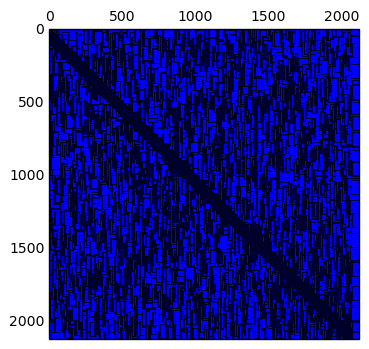

In [196]:
plt.spy(D)

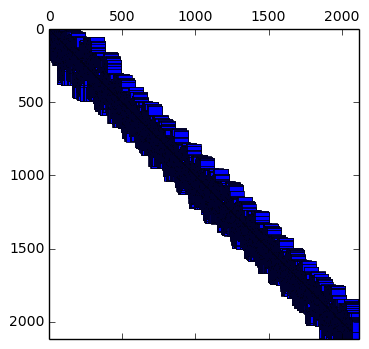

In [198]:
plt.spy(sol_data['D'])

In [202]:
sol_data['D'].nnz

20662

In [206]:
D.max(), D.min()

(0.1671136, -0.2411094)

In [208]:
D2 = sol_data['D']
D2.max(), D2.min()

(40.53532451458311, -67.982201138836061)

In [209]:
D2.max()/D.max()

242.56149418469298

In [211]:
D2.min()/D.min()

281.95583058493804